In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

In [3]:
from displayframesasgif import display_frames_as_gif
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay
from ddpg import DDPG
import nn
from movingaverage import MovingAverage

In [4]:
# Constants
RENDER = True
TIMESTEPS = 30000
REPLAY_BUFFER_SIZE = 100000
LEARNING_START = 10000
BATCH_SIZE = 256
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.001
TRAIN_UPDATES_PER_STEP = 1

In [5]:
env = gym.make('Pendulum-v0') #Pendulum-v0, MountainCarContinuous-v0
state = np.array(env.reset())

[2017-04-11 00:26:54,999] Making new env: Pendulum-v0


In [6]:
observation = env.reset()
frames = []
reward_avg = MovingAverage(100)
total_rewards = [0]

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [7]:
print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

3
1
[ 1.  1.  8.]
[-1. -1. -8.]
[ 2.]
[-2.]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
actor_network = nn.fully_connected("Actor", session, [state_dim], [256, 128], action_dim, tf.nn.relu, env.action_space, True)
q_network = nn.fully_connected("Q", session, [state_dim, action_dim], [256, 128], 1, tf.nn.relu, None, True)

print(str(actor_network))

[] --> Actor_input_0
['Actor_input_0'] --> bn_hidden_0
['bn_hidden_0'] --> hidden_0_256
['hidden_0_256'] --> bn_hidden_1
['bn_hidden_1'] --> hidden_1_128
['hidden_1_128'] --> bn_output
['bn_output'] --> output
['output'] --> bounding



In [10]:
agent = DDPG(actor_network, q_network, discount_factor=DISCOUNT_FACTOR, tf_optimizer=tf.train.AdamOptimizer(LEARNING_RATE))

In [11]:
#tvars = tf.trainable_variables()
#tvars_vals = session.run(tvars)

#for var, val in zip(tvars, tvars_vals):
#    print(var.name, val)

In [12]:
experience_replay = ExperienceReplay(agent, REPLAY_BUFFER_SIZE)

In [13]:
progress_bar = tqdm(total=TIMESTEPS)
episode_reward = 0
episote_duration = 0

for t in xrange(TIMESTEPS):   
    action = None
    
    exploration_probability = ((TIMESTEPS - t) / float(TIMESTEPS)) ** 2
    if t < LEARNING_START:
        exploration_probability = 1
    
    if random.uniform(0, 1) < exploration_probability:
        action = env.action_space.sample()
    else:
        action = agent.action(state)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(observation, (state_dim,))
    
    if t < LEARNING_START:
        priority = 1
    experience_replay.add_experience(state, action, reward, next_state, done)
    state = next_state
    
    episode_reward += reward
    episote_duration += 1
    total_rewards.append(total_rewards[-1] + reward)
    
    if done:
        state = np.array(env.reset())
        print("Episode over. Total reward: {}. Solved in {} steps.".format(episode_reward, episote_duration))
        episode_reward = 0
        episote_duration = 0
        
    if t >= LEARNING_START:
        experience_replay.train_agent(BATCH_SIZE, TRAIN_UPDATES_PER_STEP)
        
        if RENDER and t % 60 == 0:
            frames.append(env.render(mode = 'rgb_array'))
            
    reward_avg.add_value(reward)    
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, Exploration proba: {:.2f}, action: {}, td-error: {:.4f}' \
        .format(t, reward, reward_avg.get_average(), exploration_probability, str(action), priority))
    progress_bar.update()
    
        
progress_bar.close()

[29999] reward: -0.00, reward 100-step MA: -0.01, Exploration proba: 0.00, action: [ 1.08227456], td-error: 1.0000: 100%|██████████| 30000/30000 [03:46<00:00, 132.56it/s]| 382/30000 [00:00<00:07, 3813.56it/s]


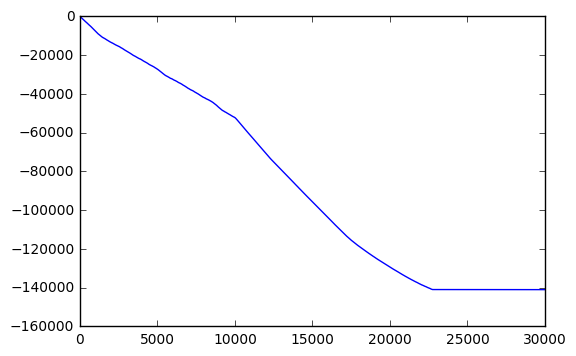

In [14]:
plt.plot(total_rewards)


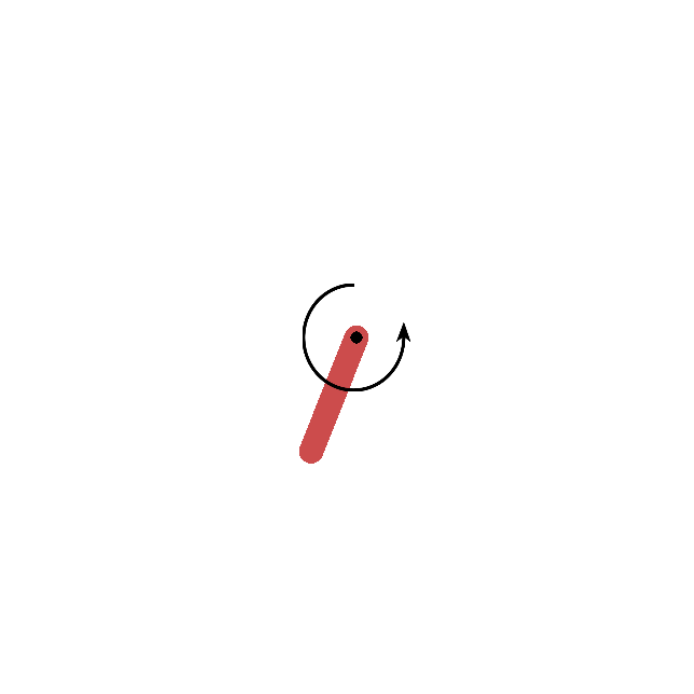
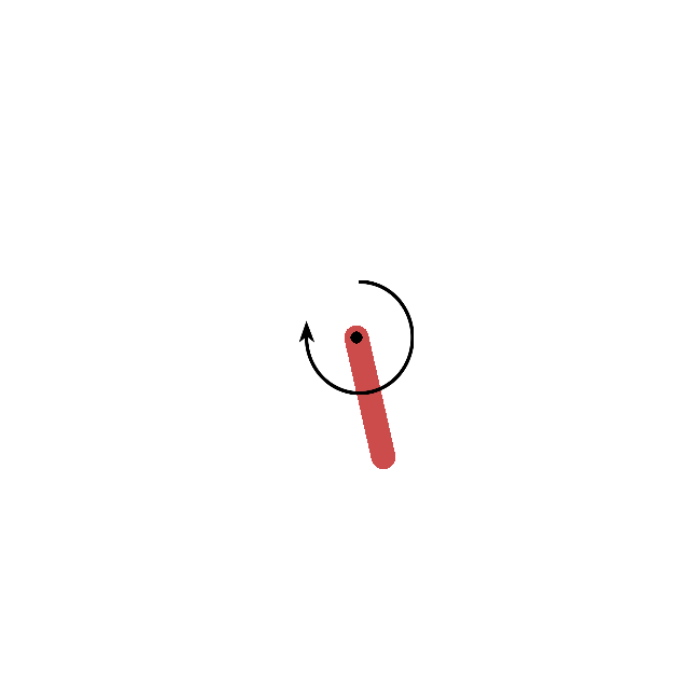
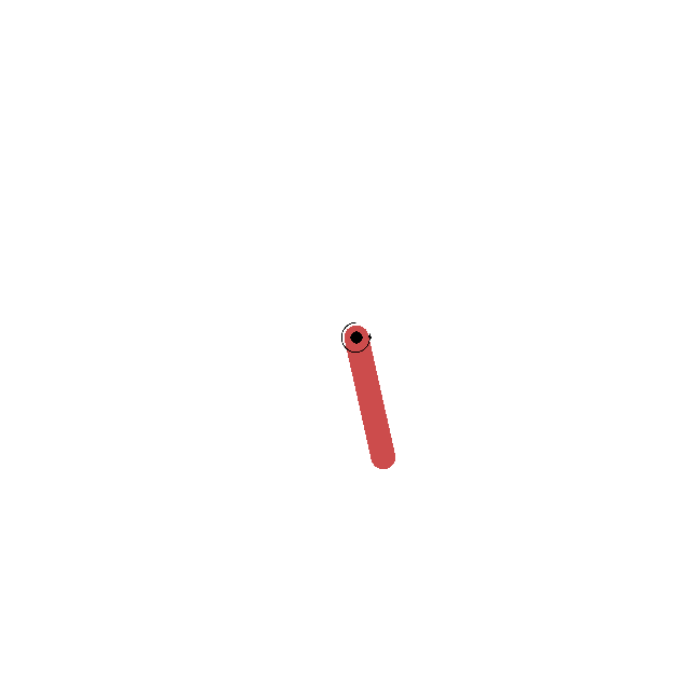
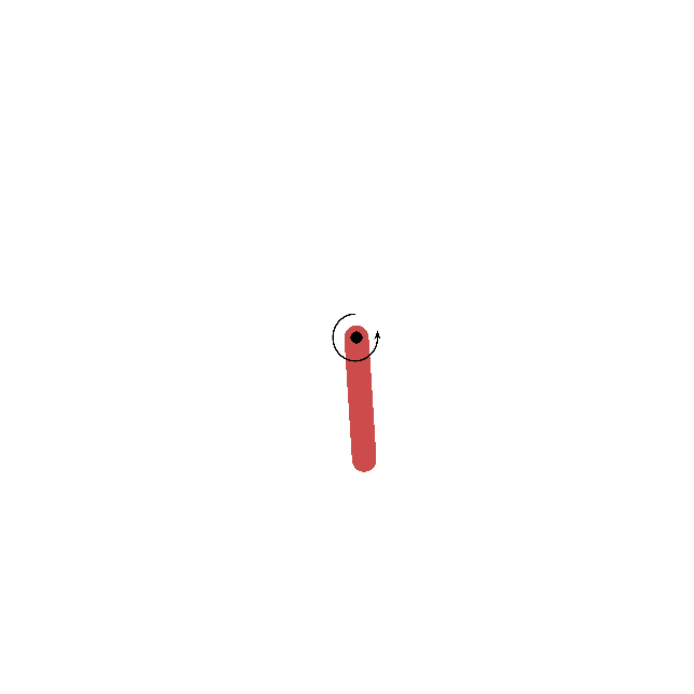
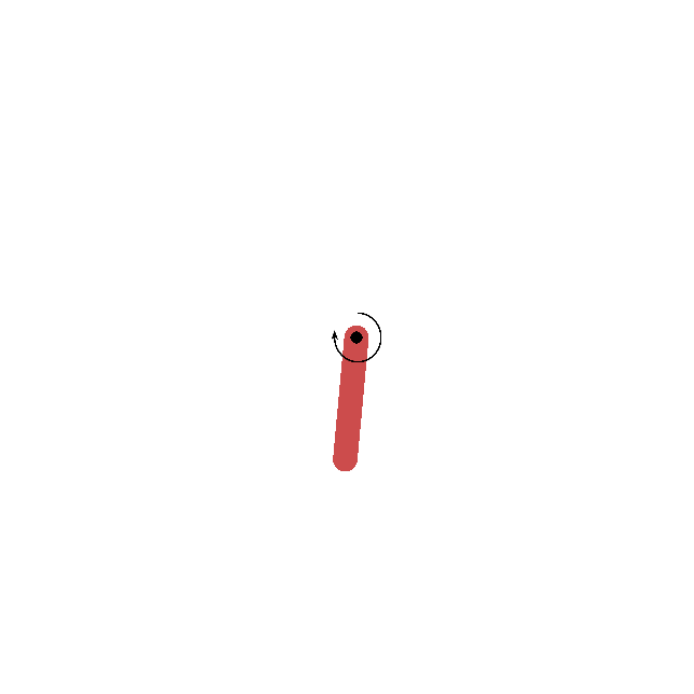
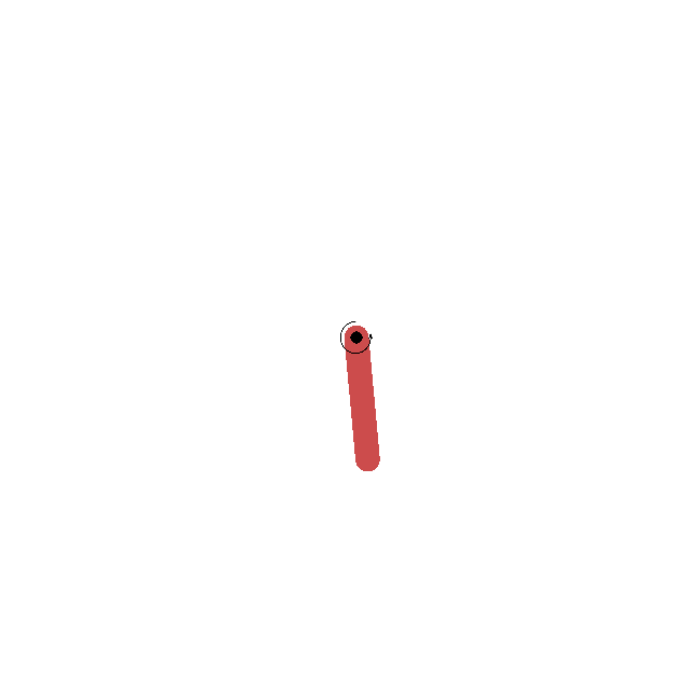
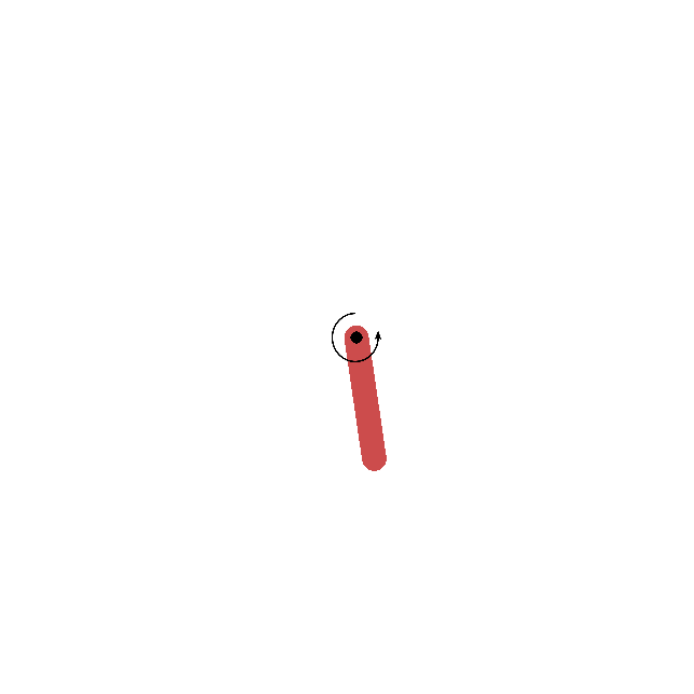
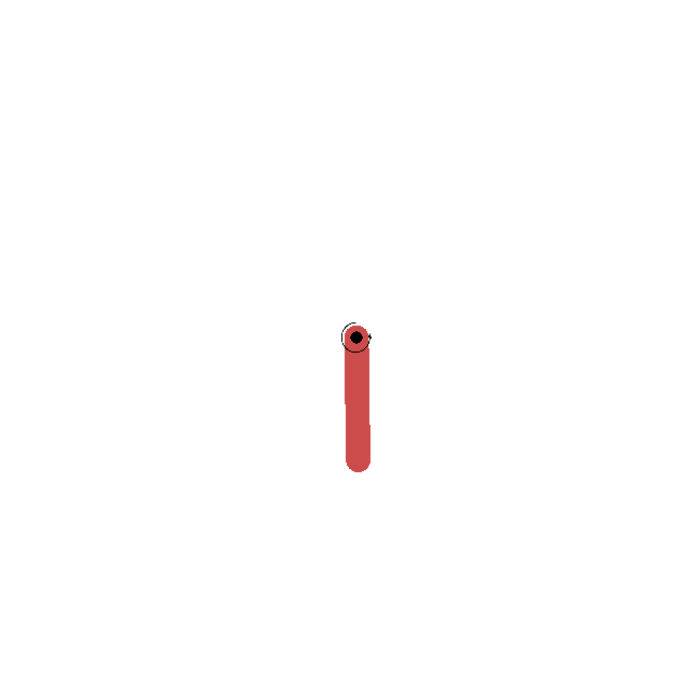
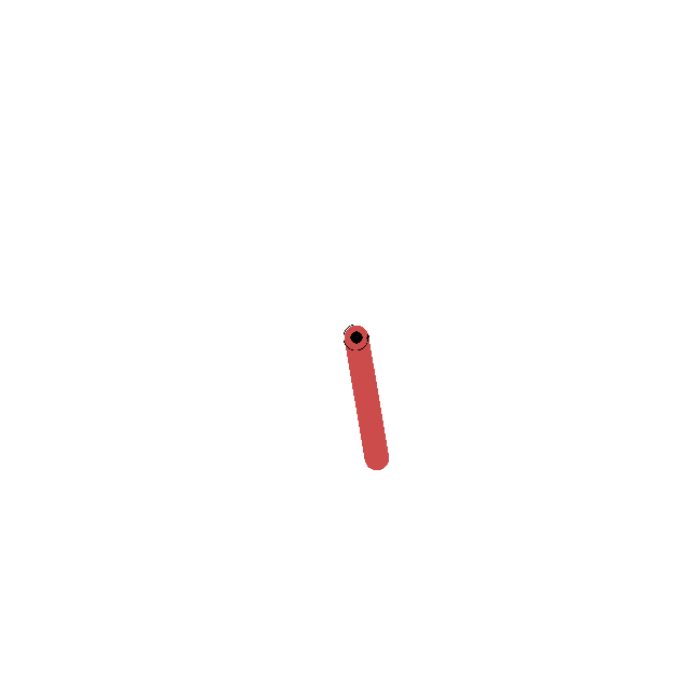
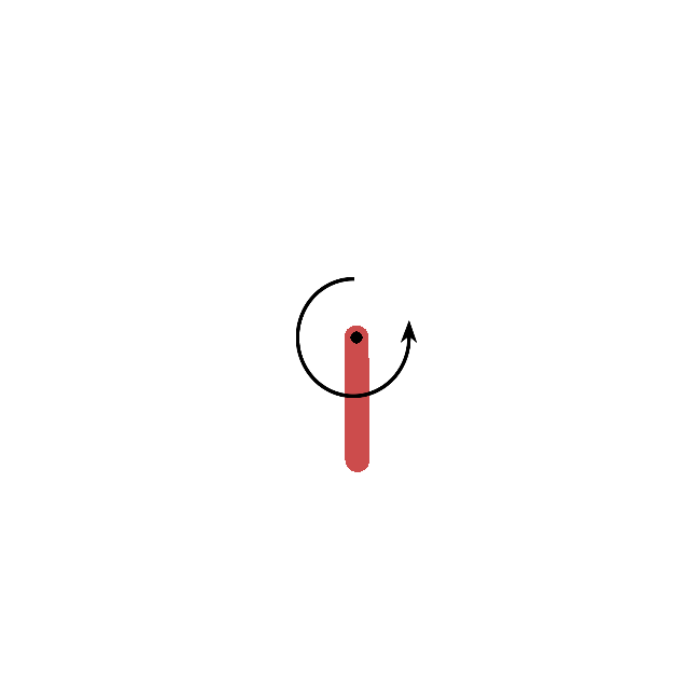
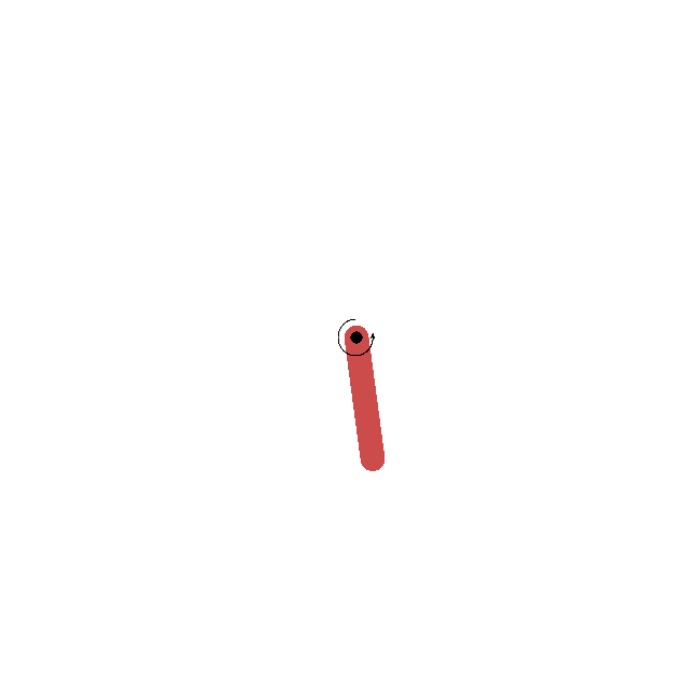
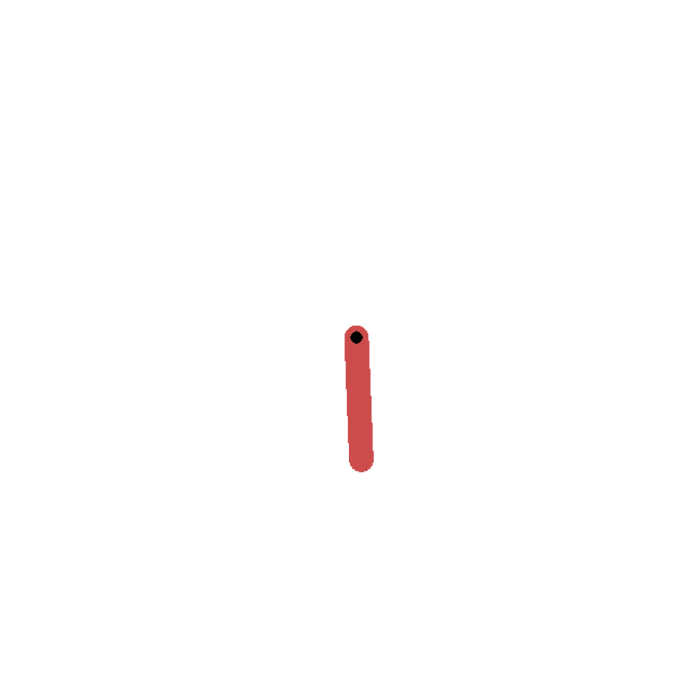
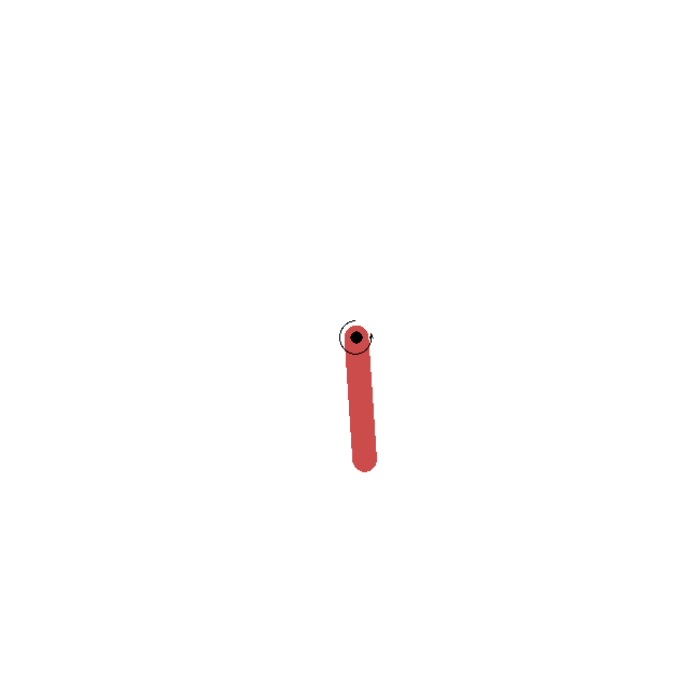
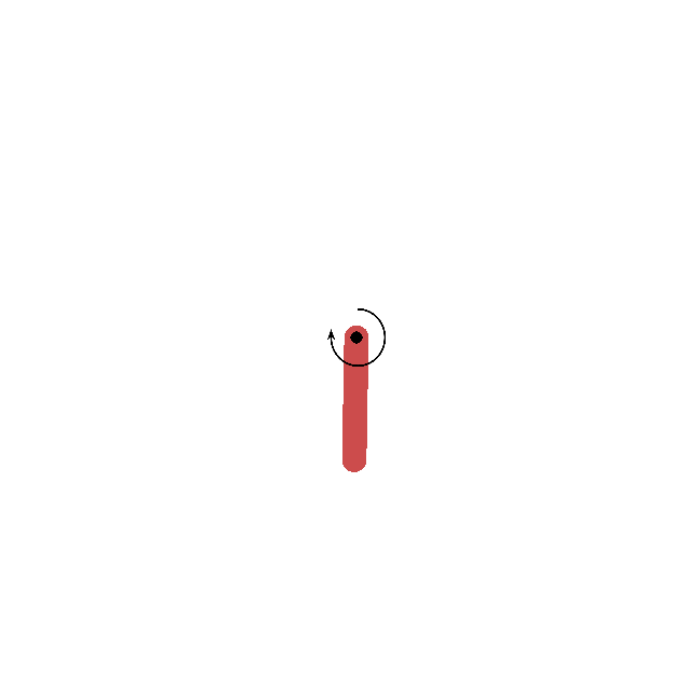
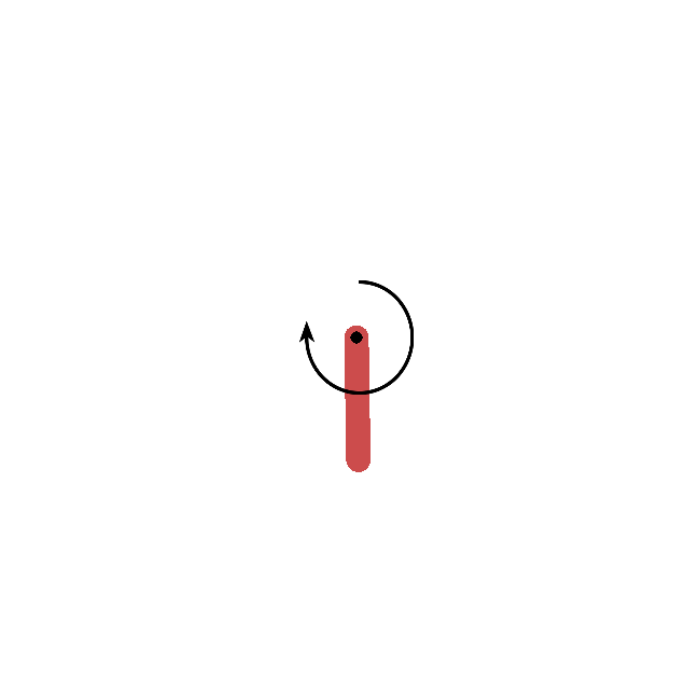
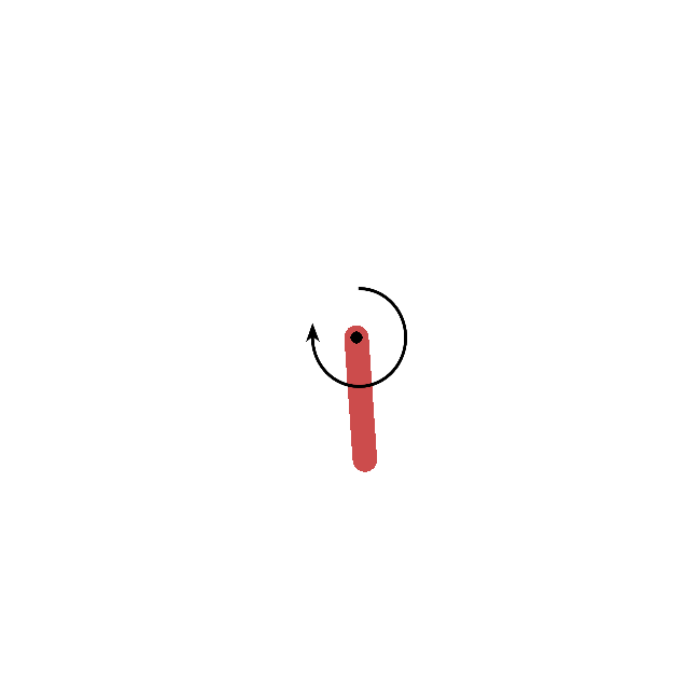
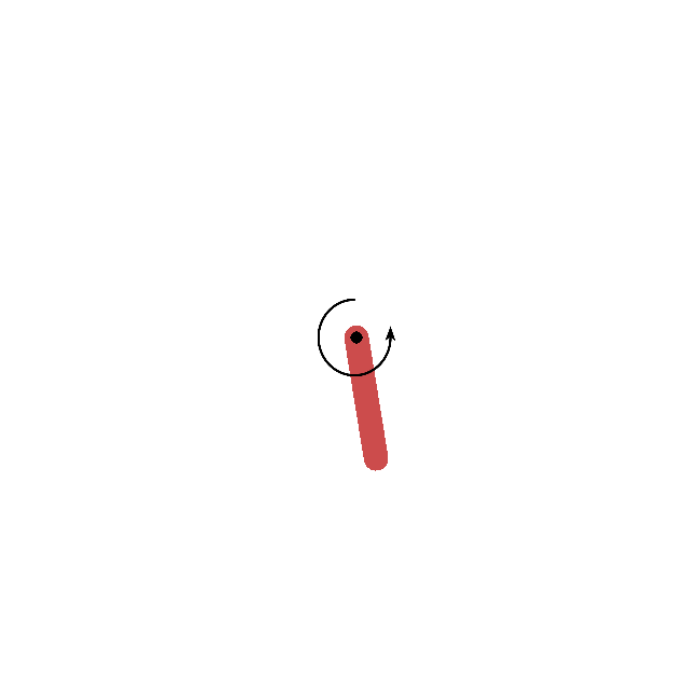
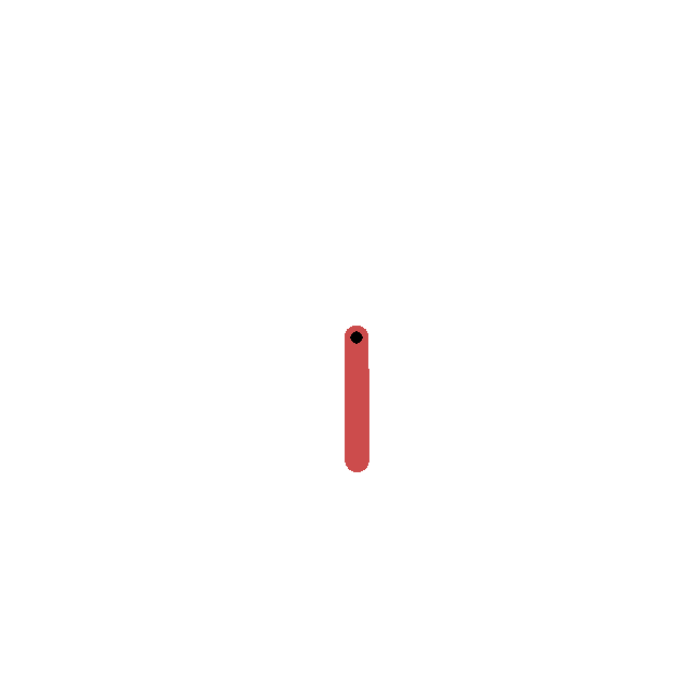
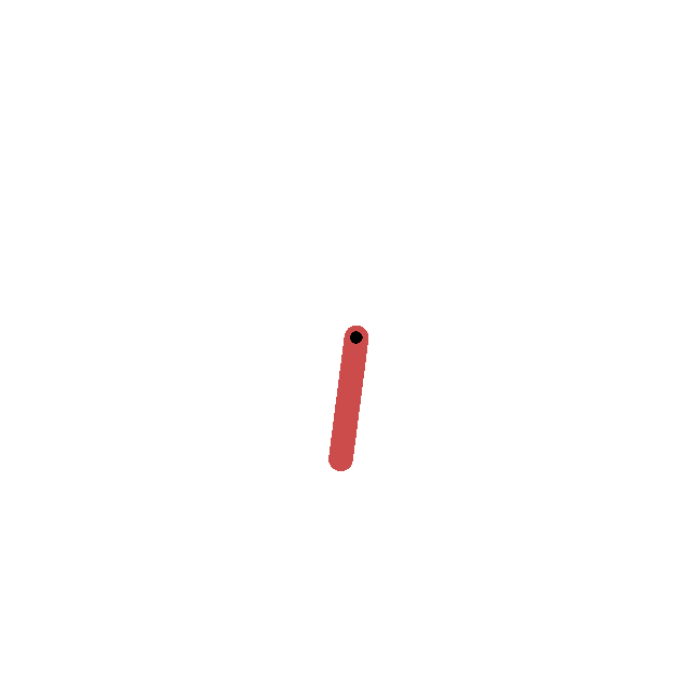
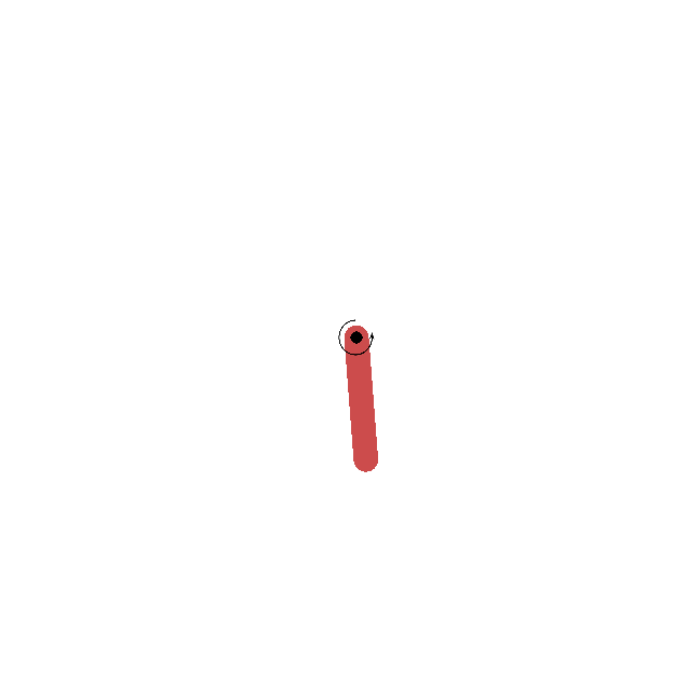
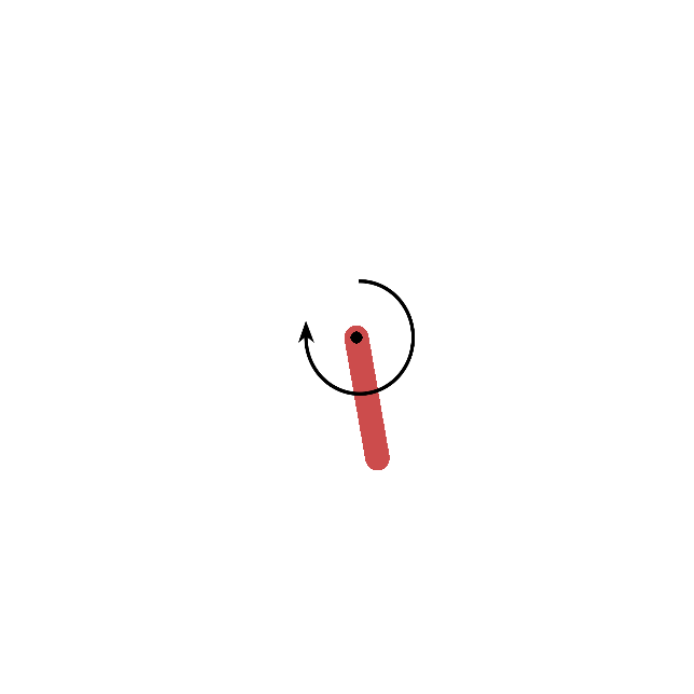
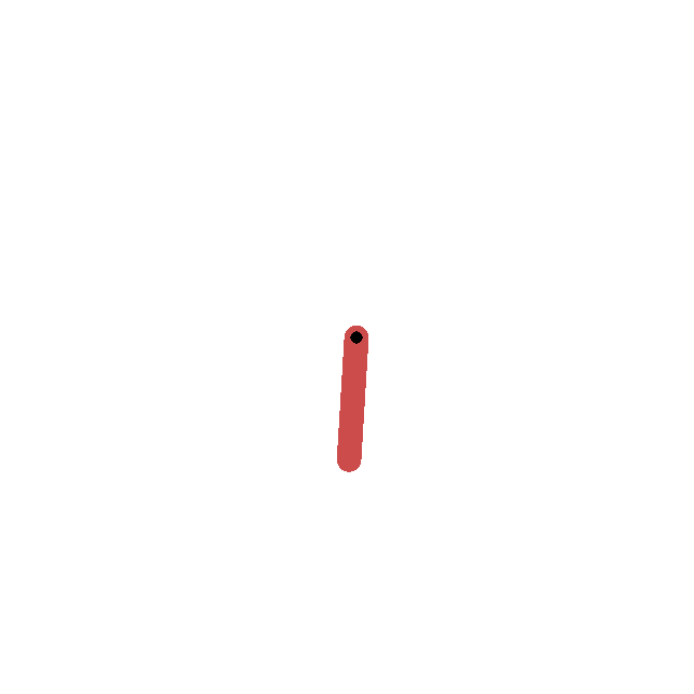
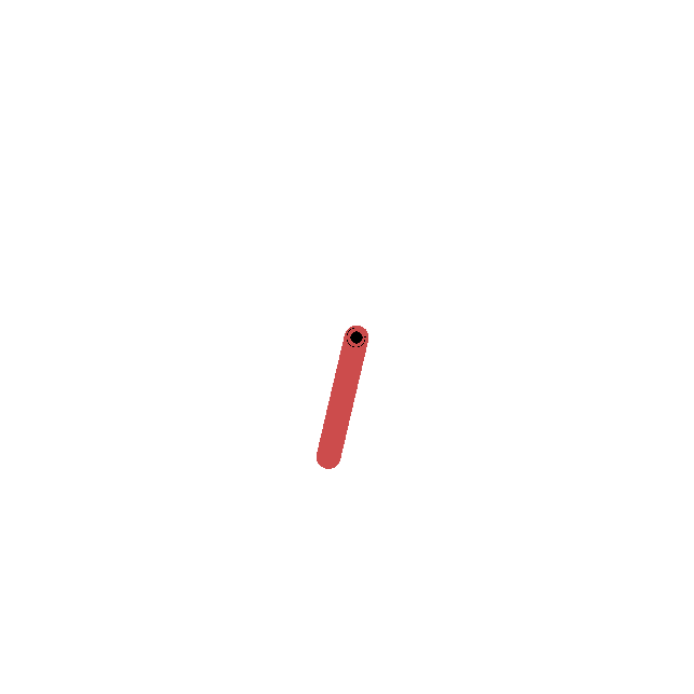
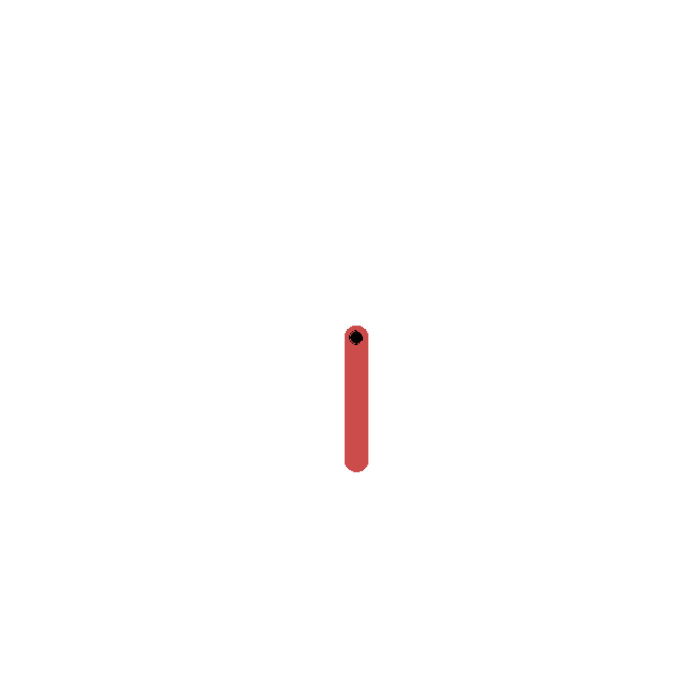
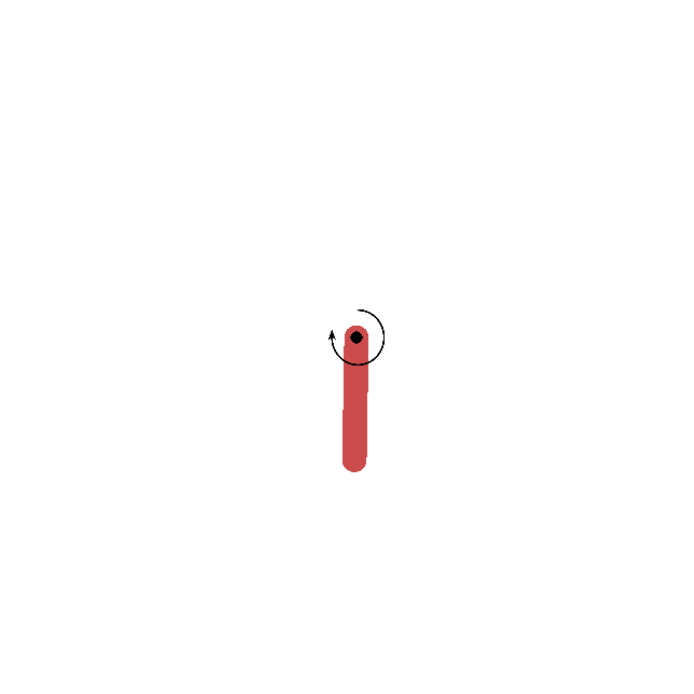
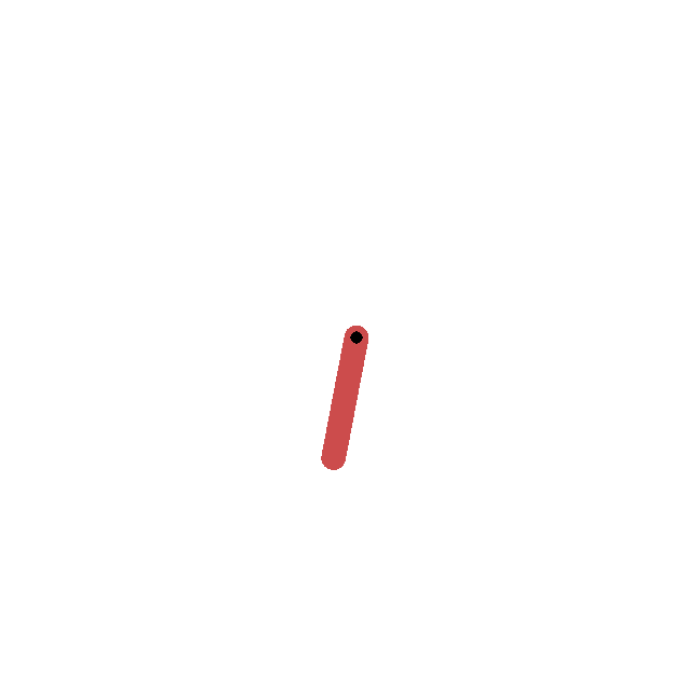
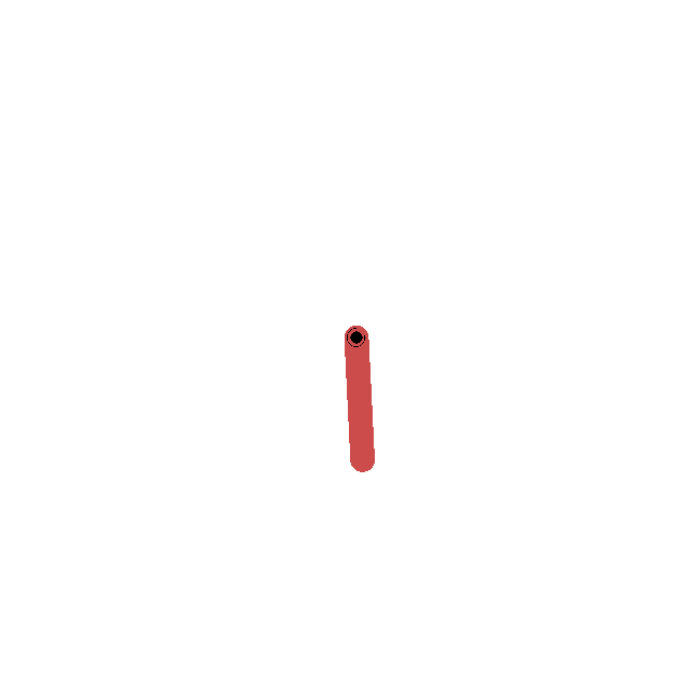
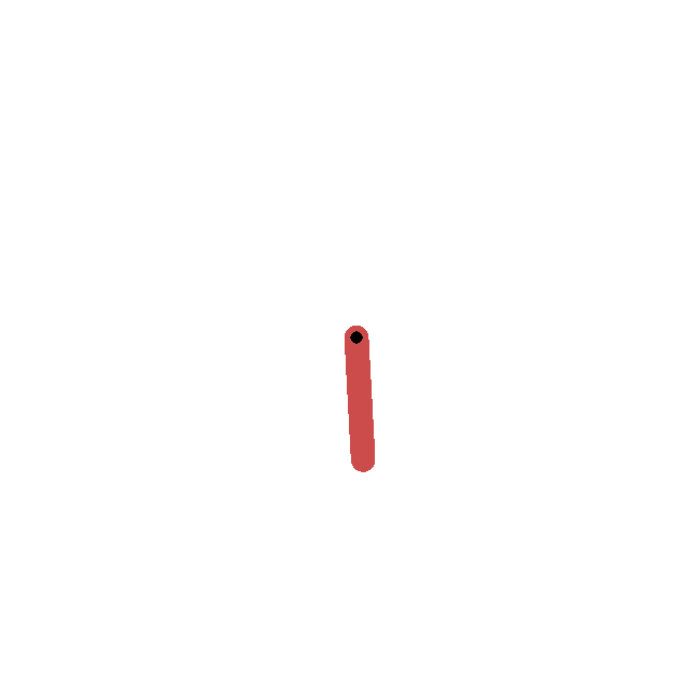
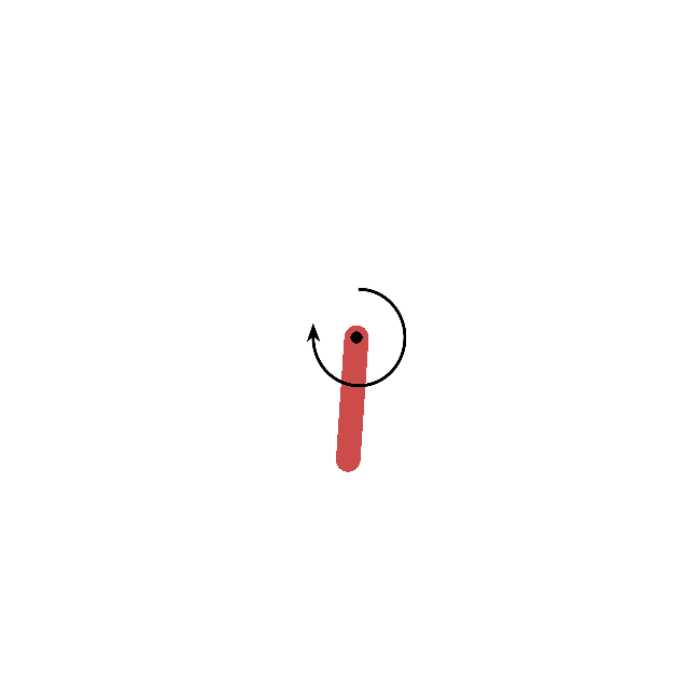
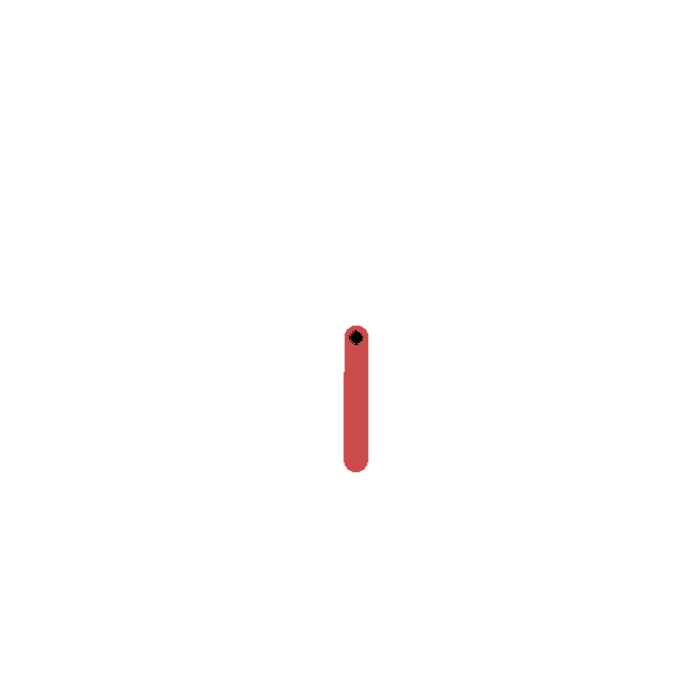
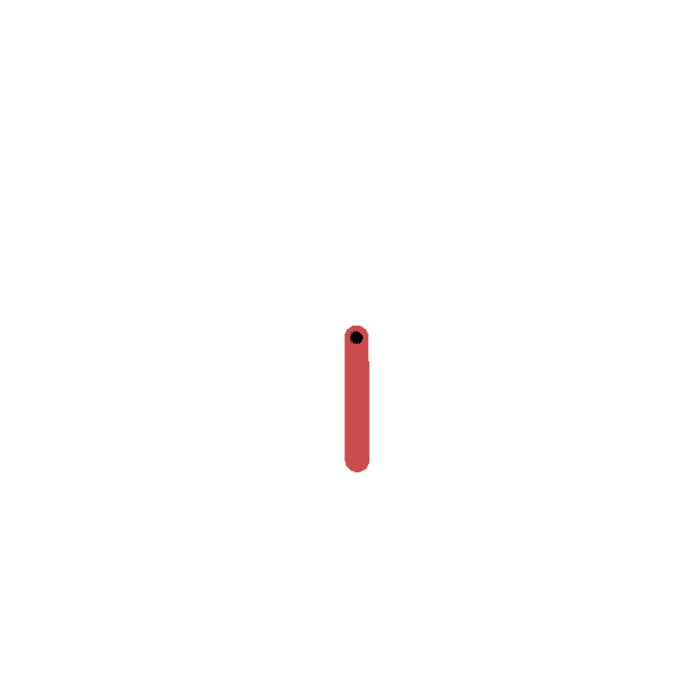
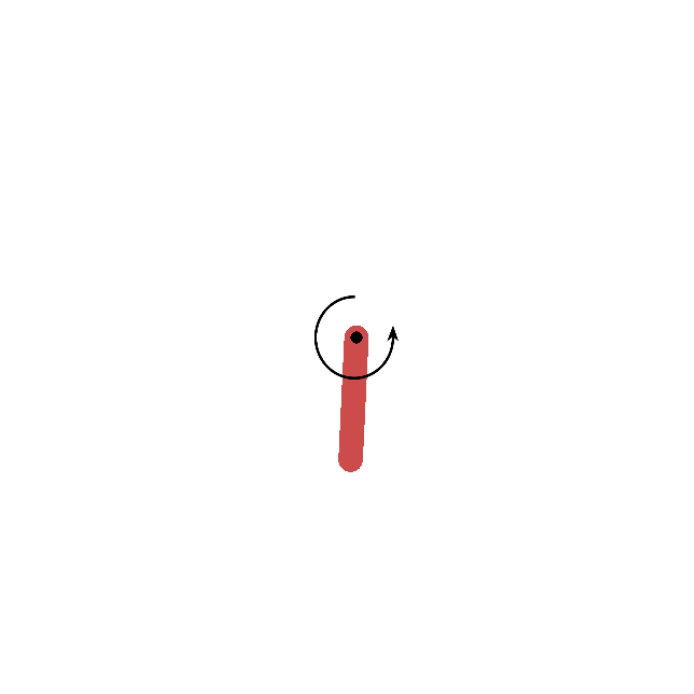
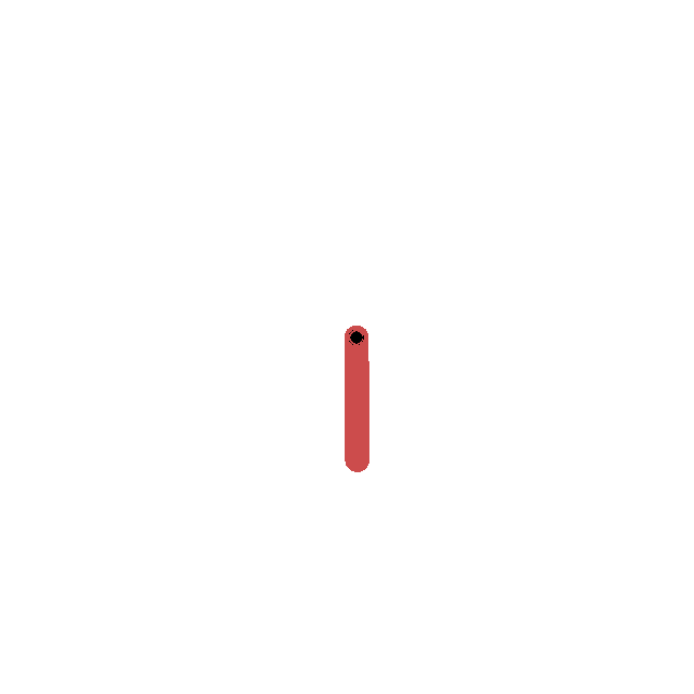
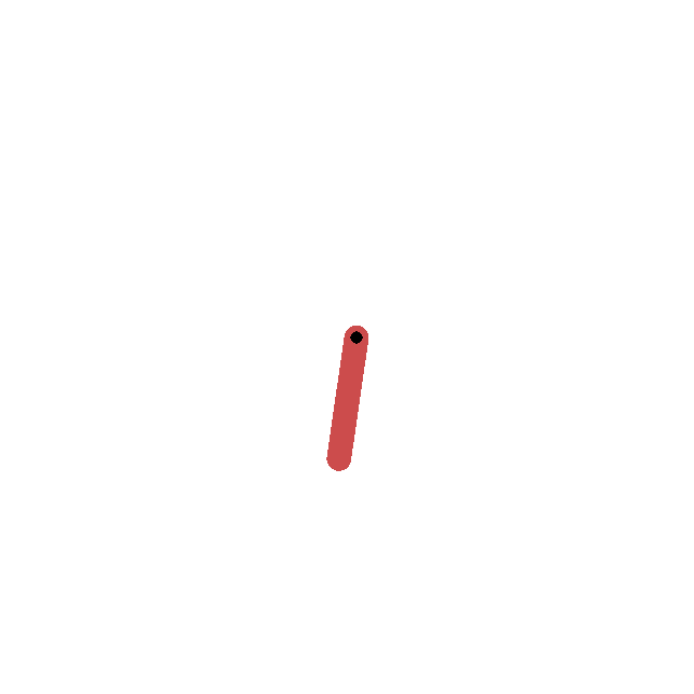
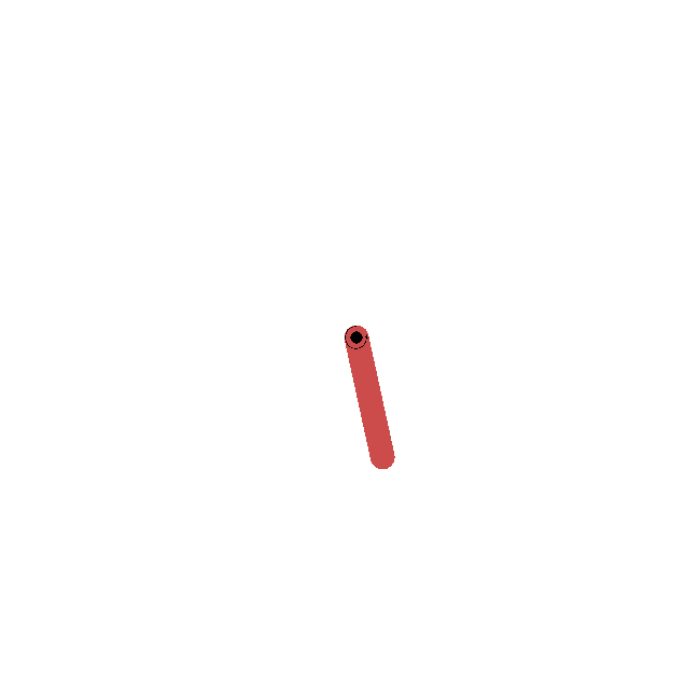
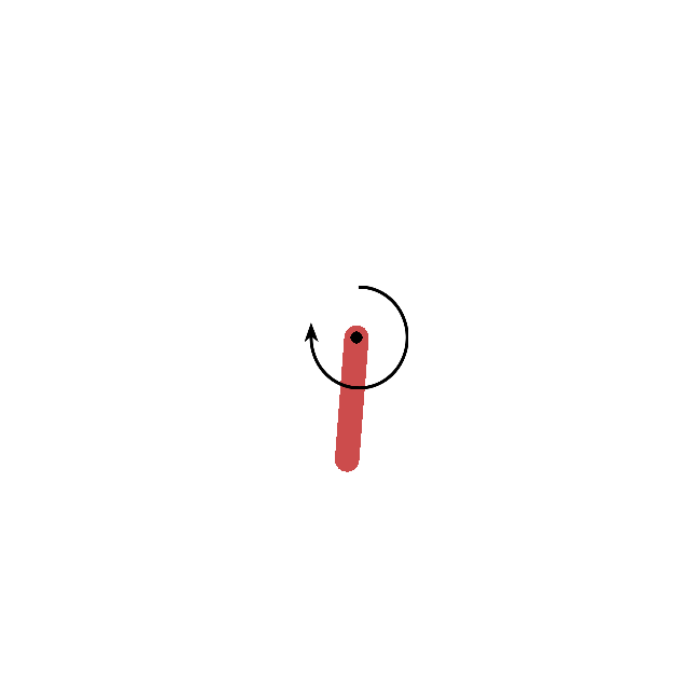
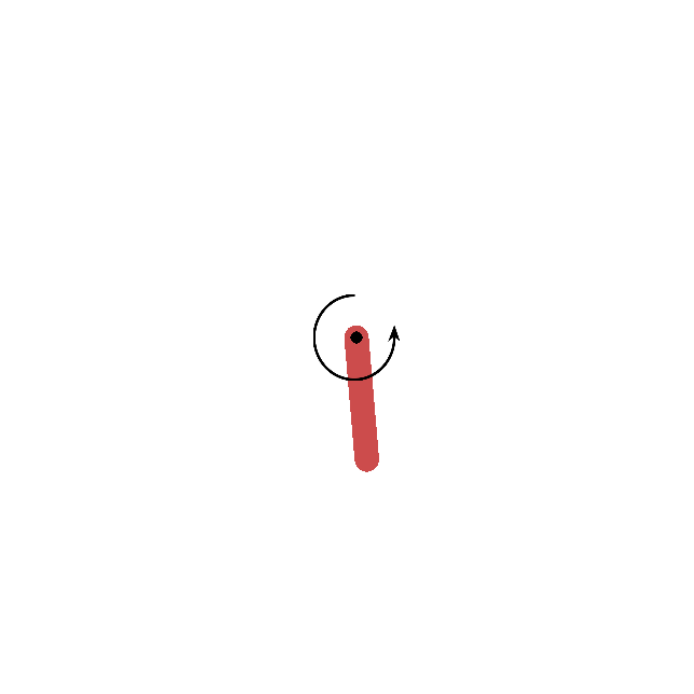
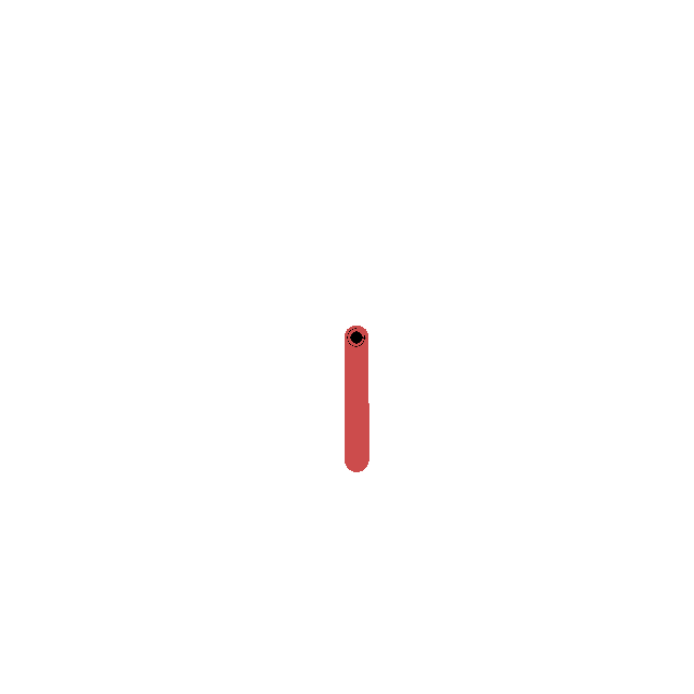
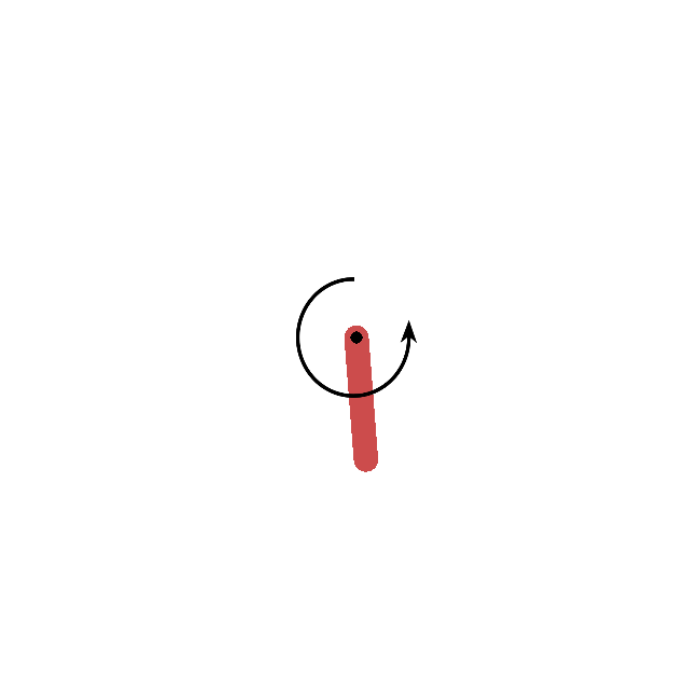
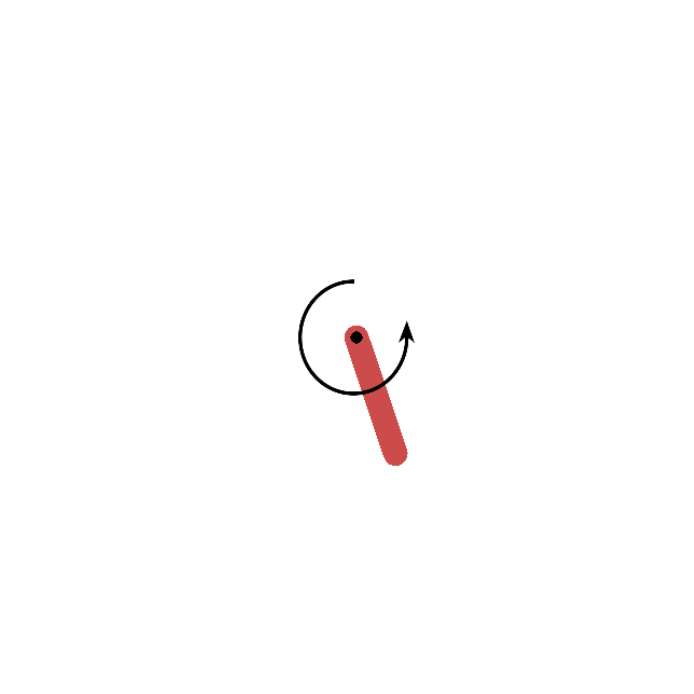
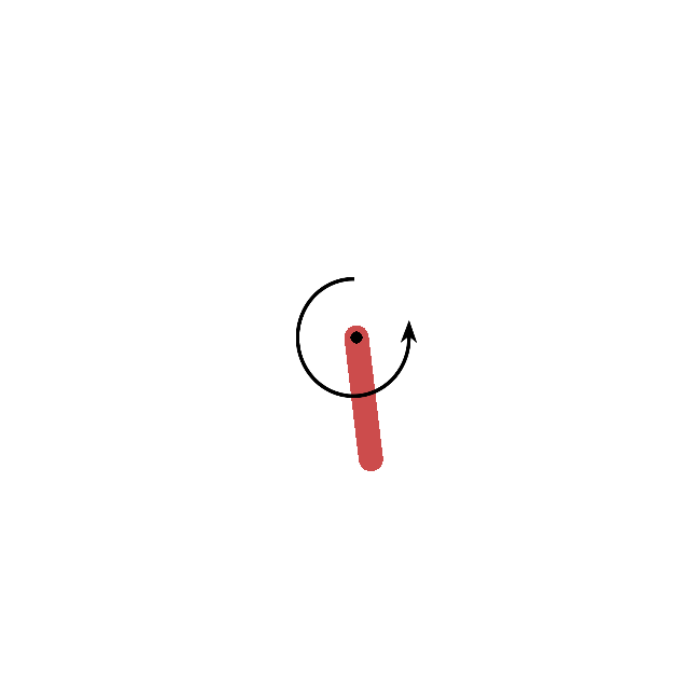
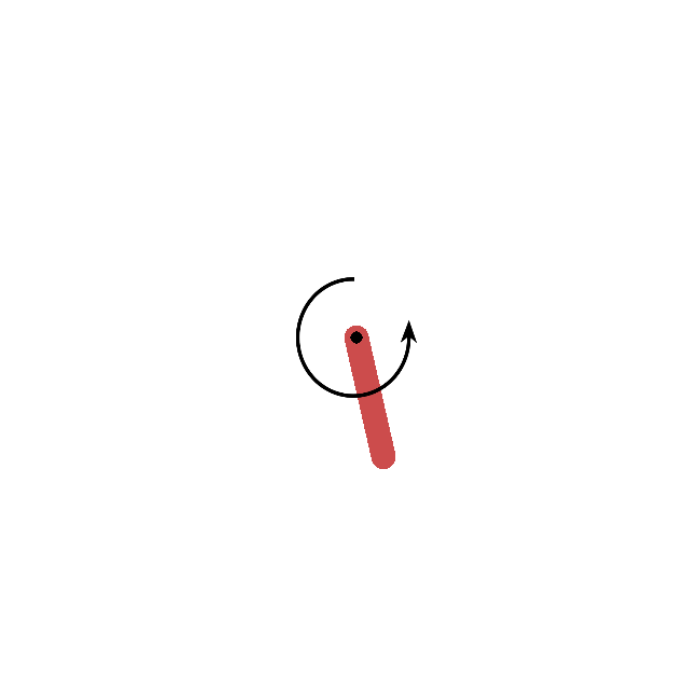
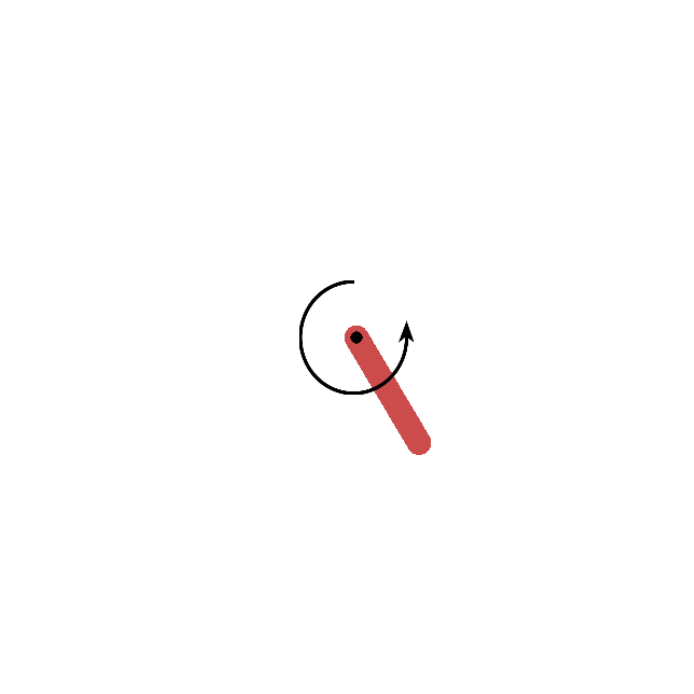
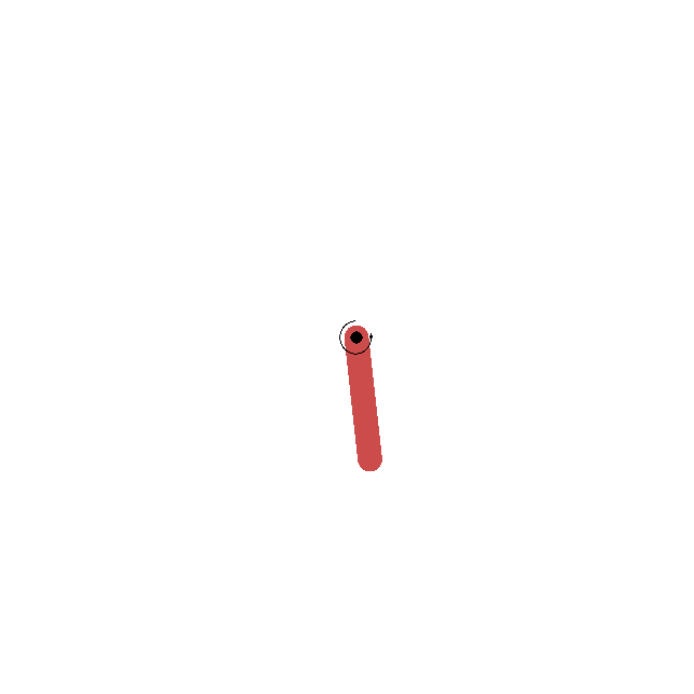
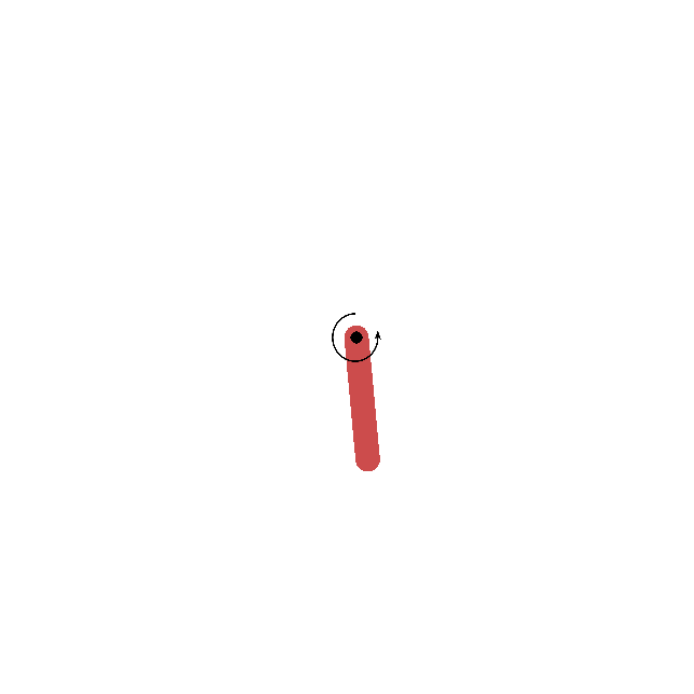
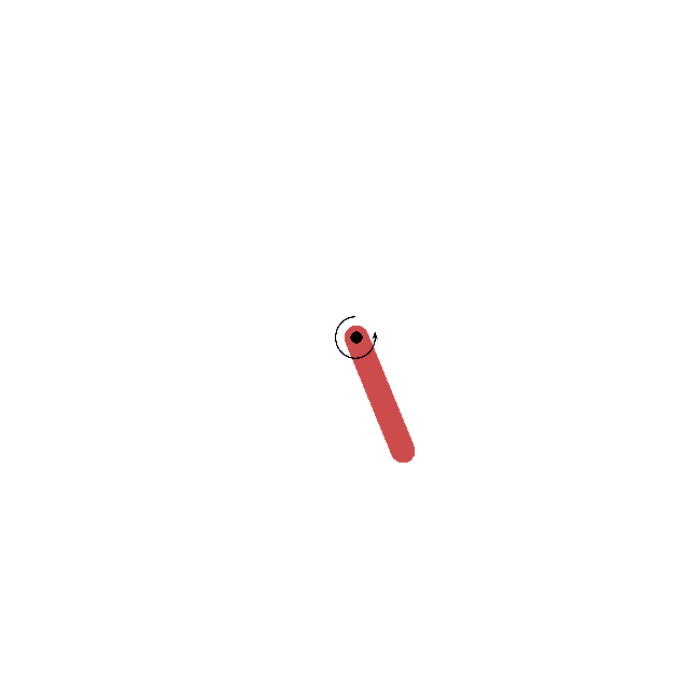
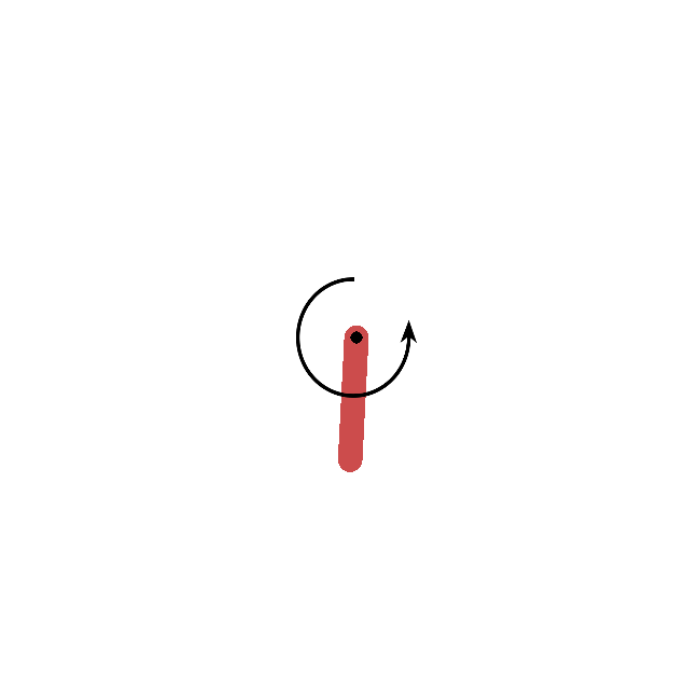
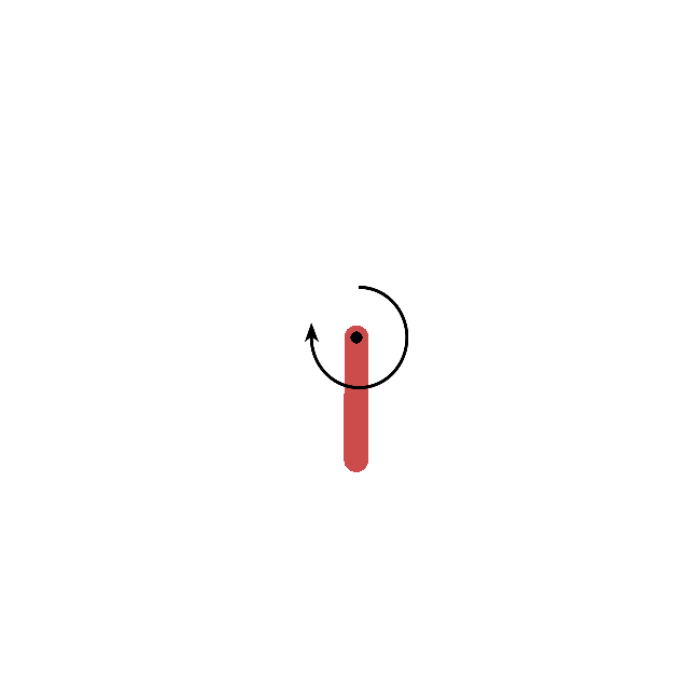
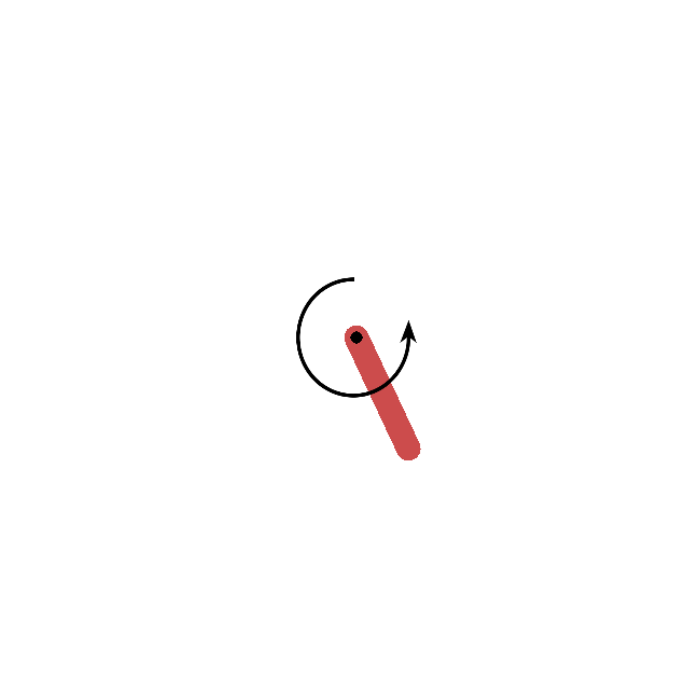
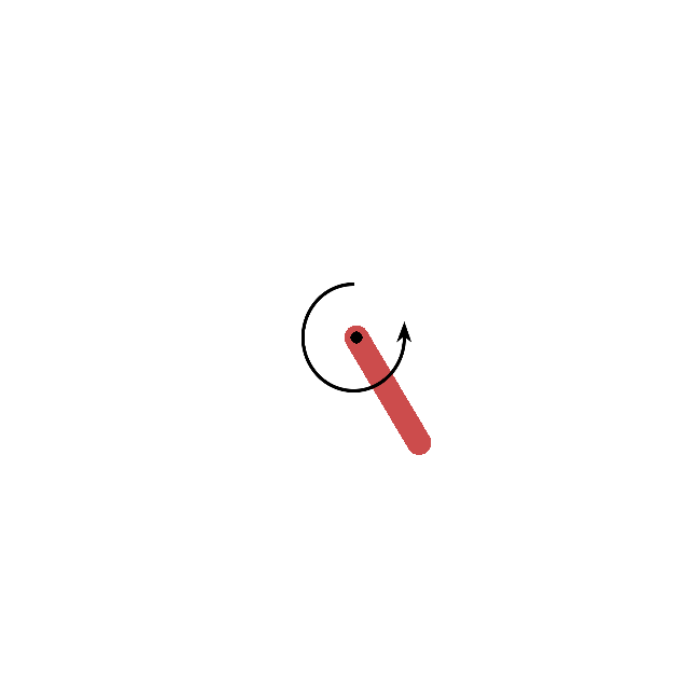
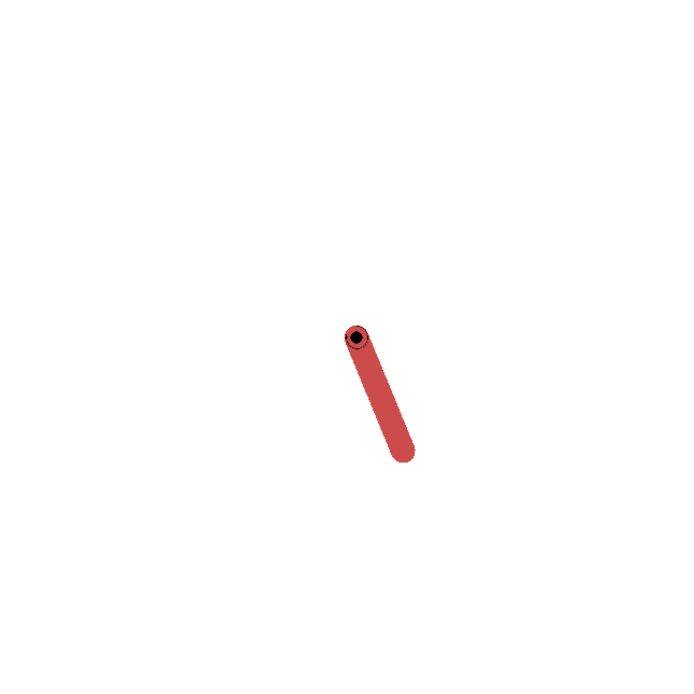
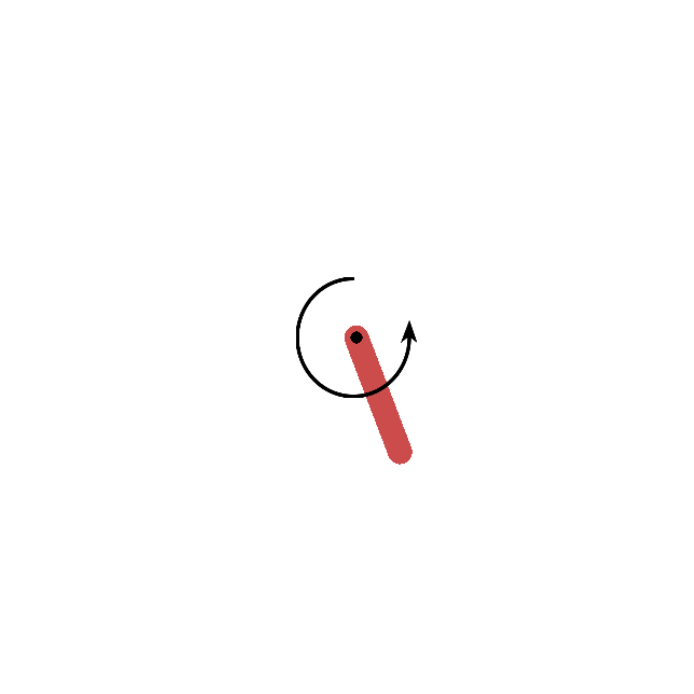
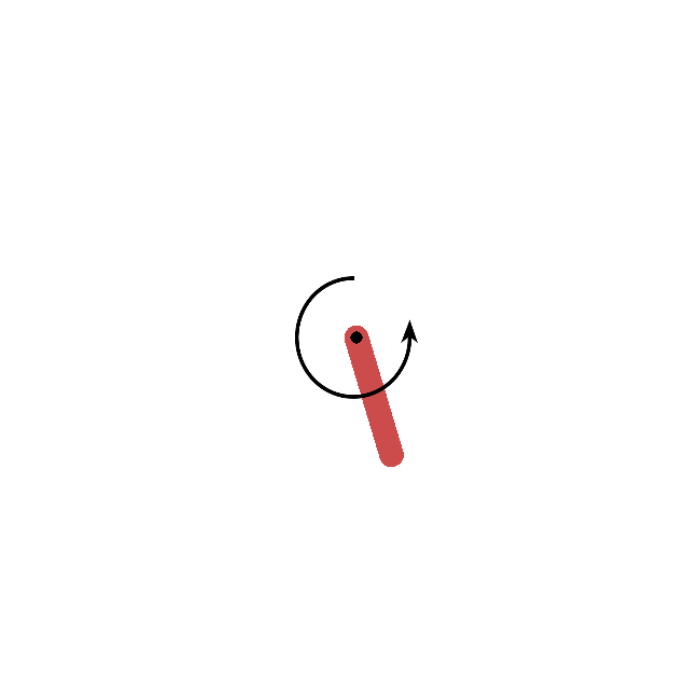
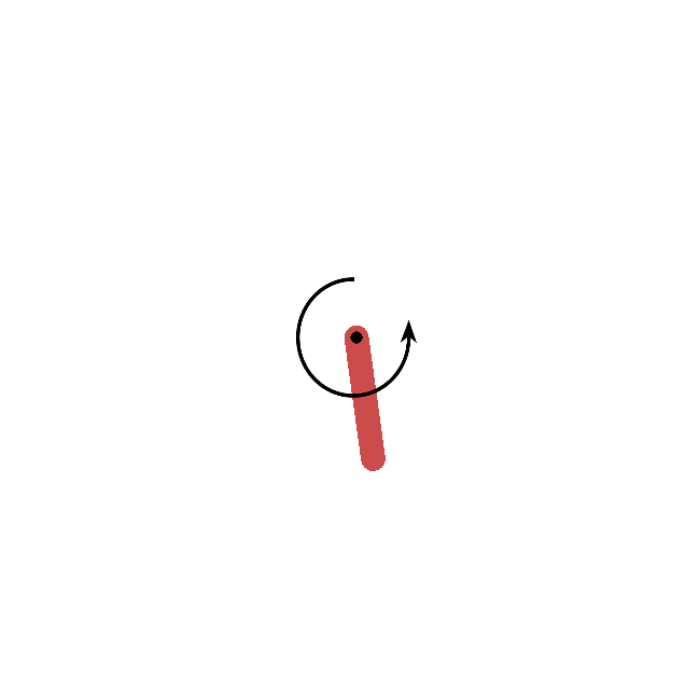
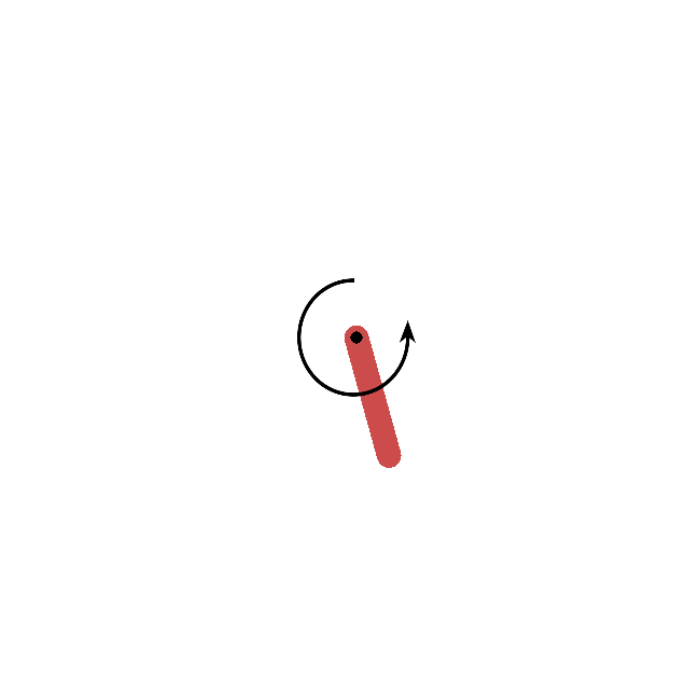
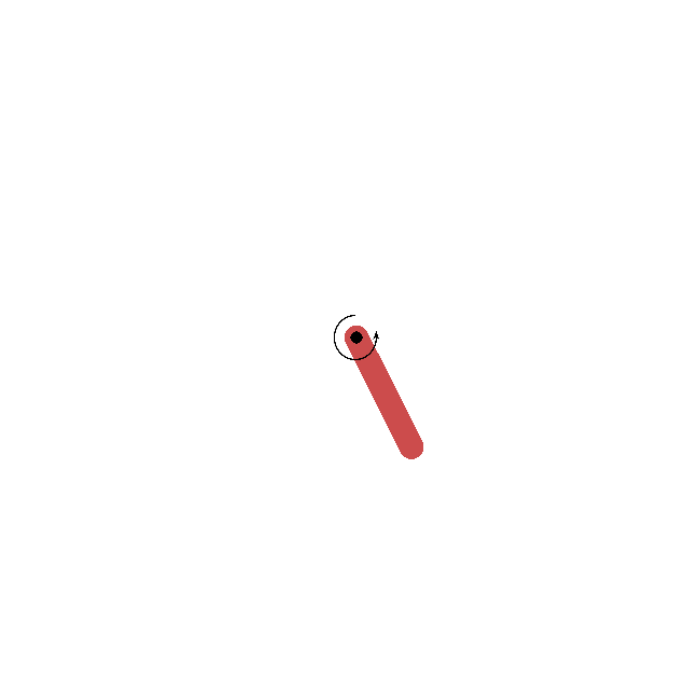
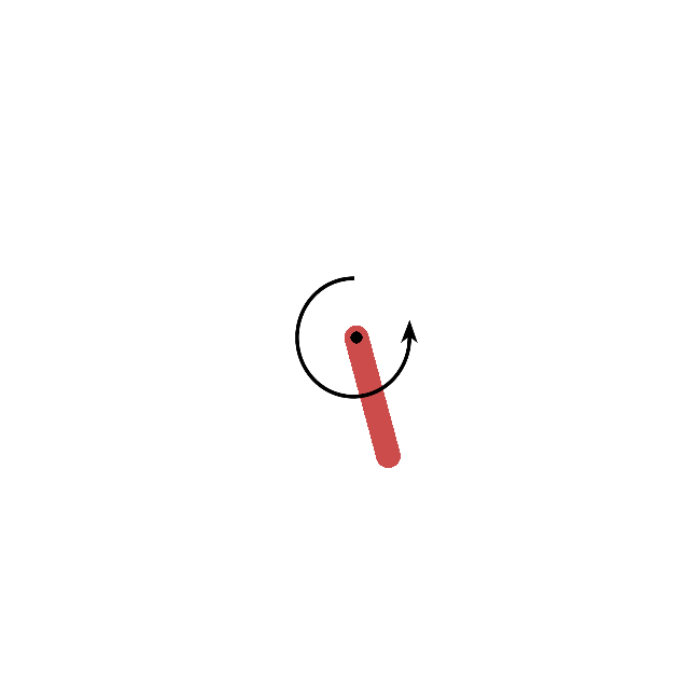
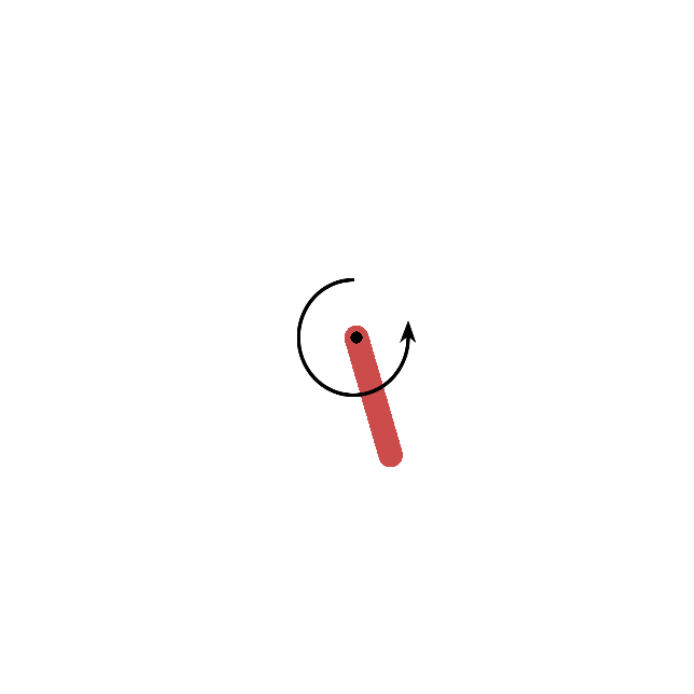
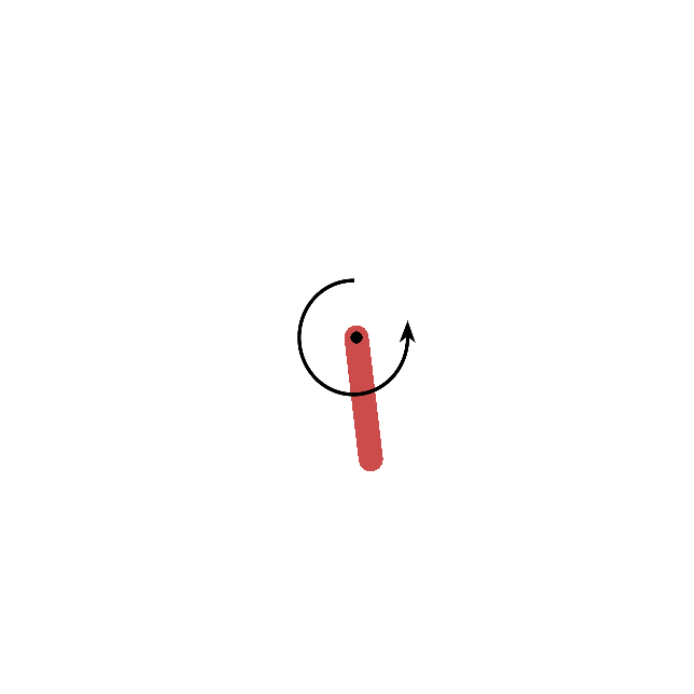
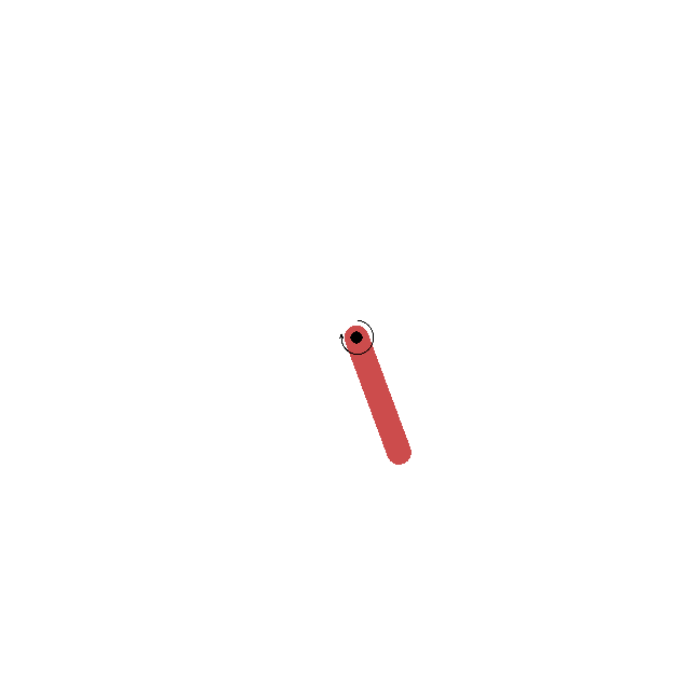
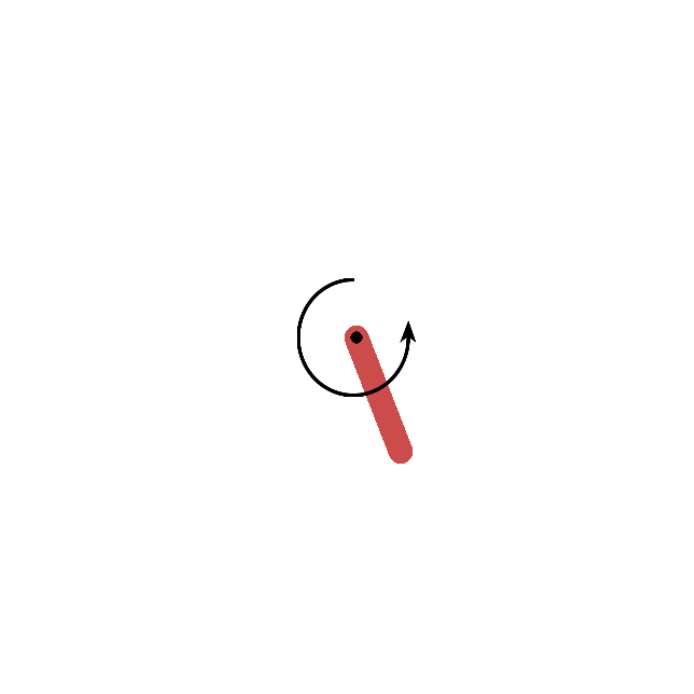
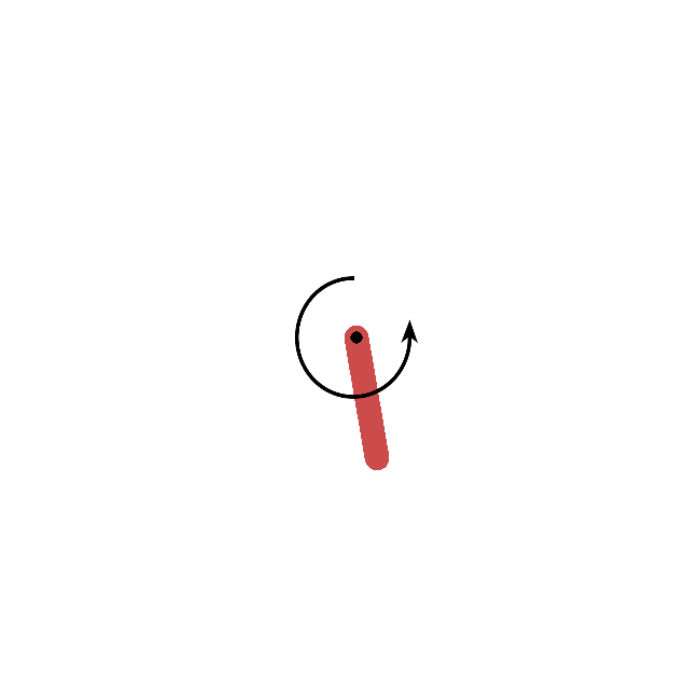
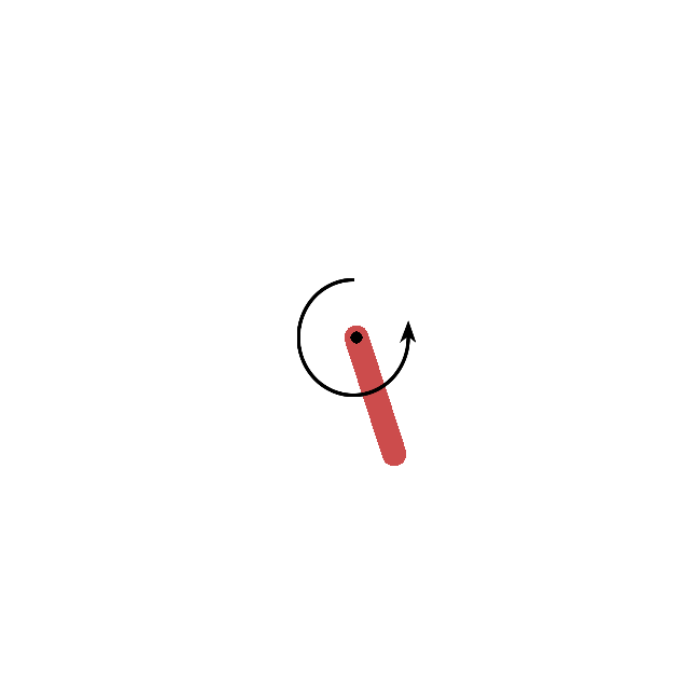
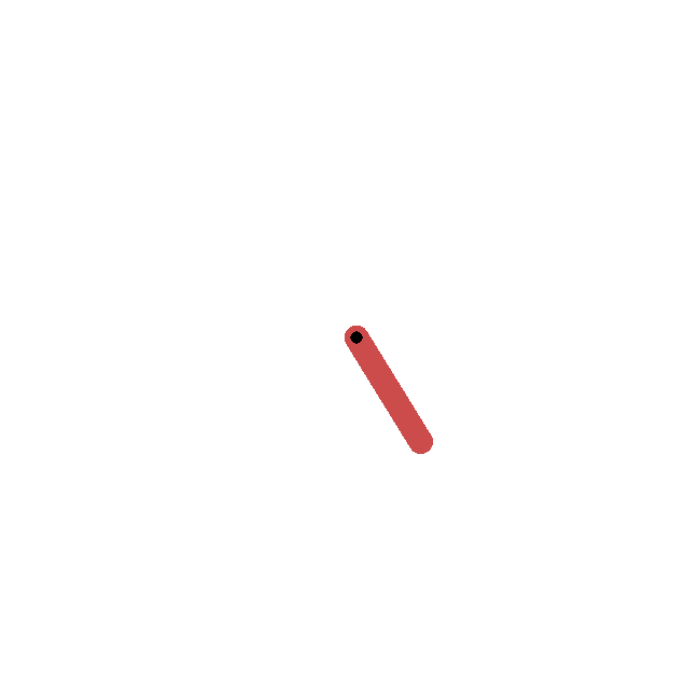
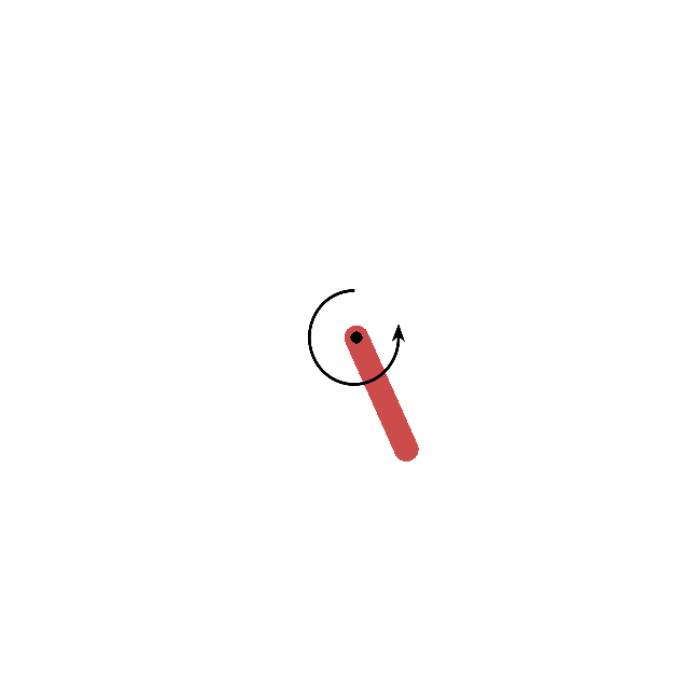
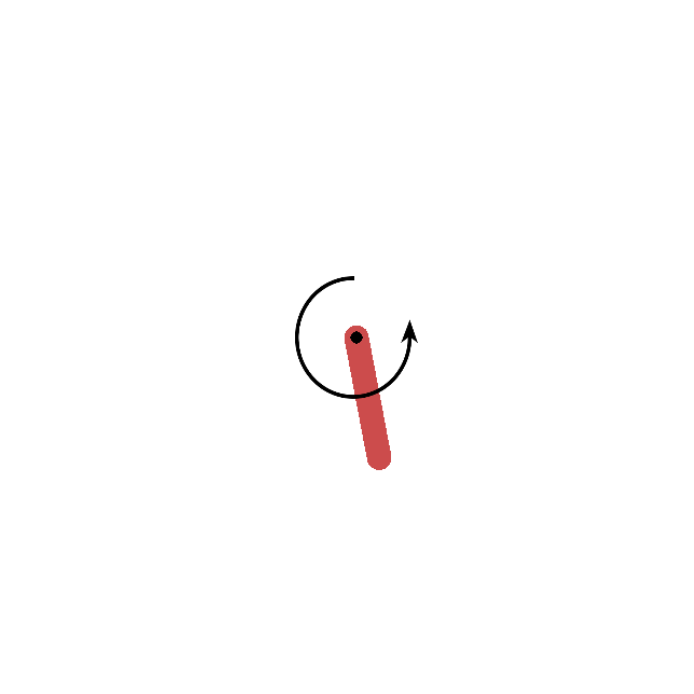
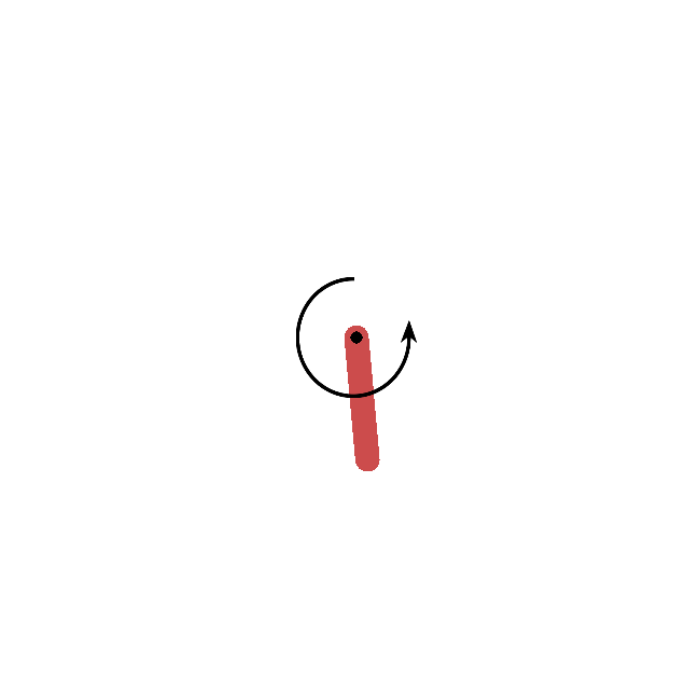
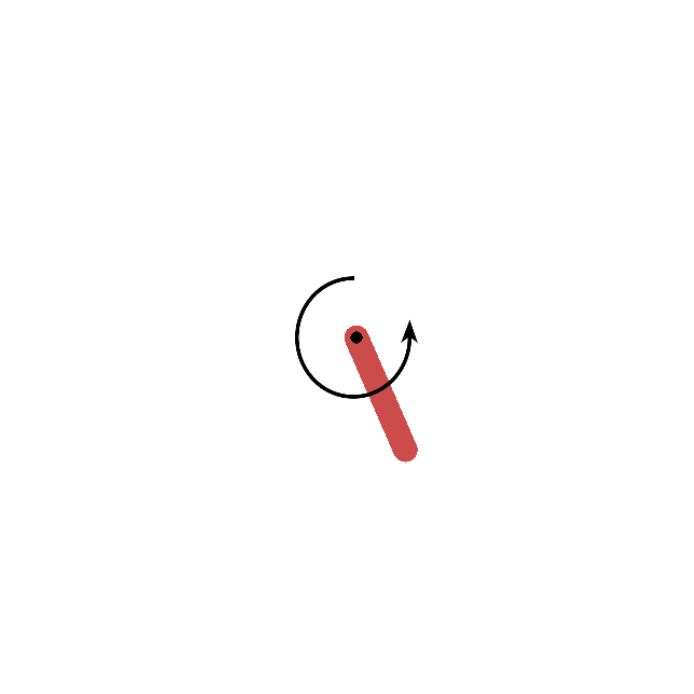
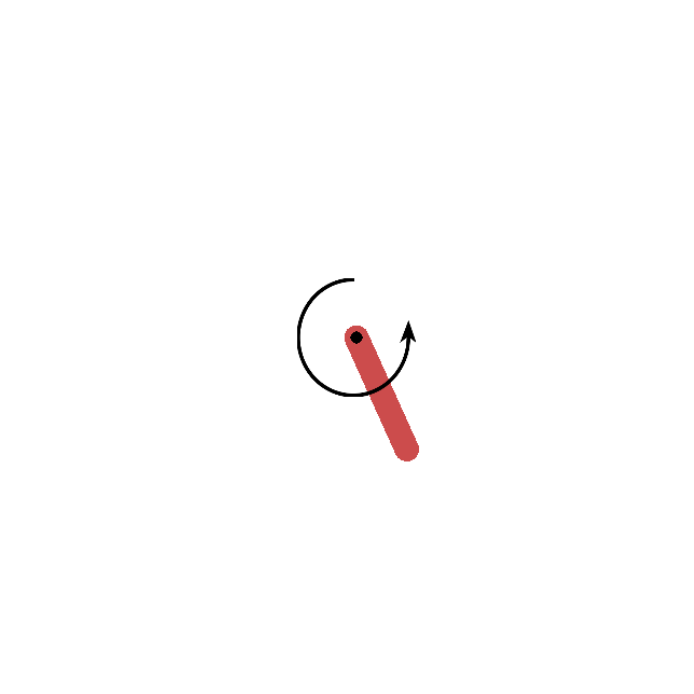
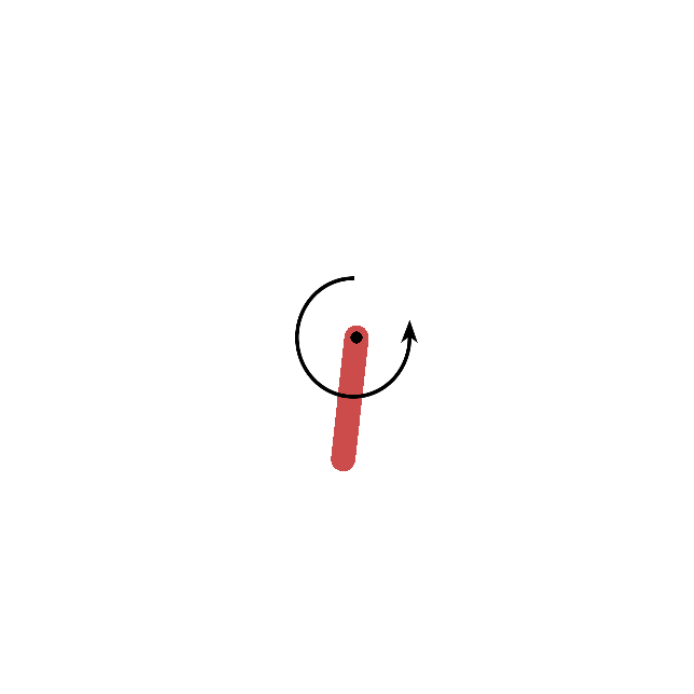
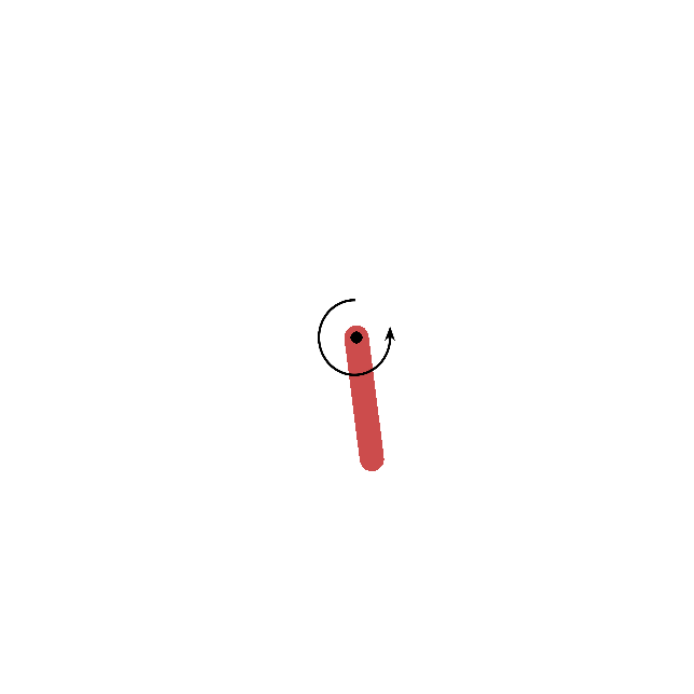
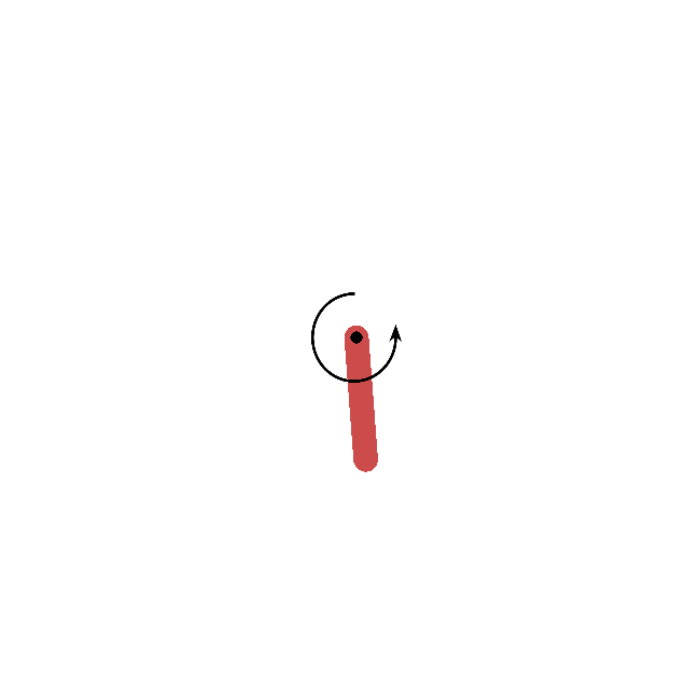
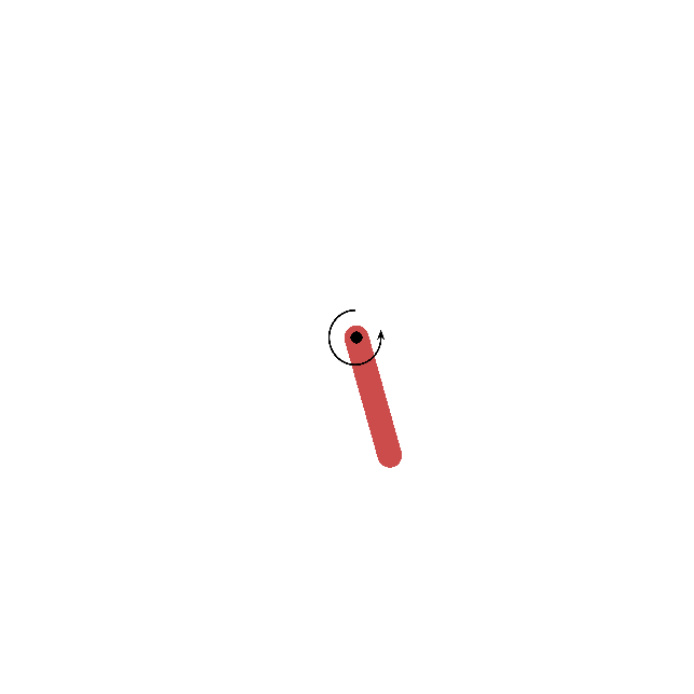
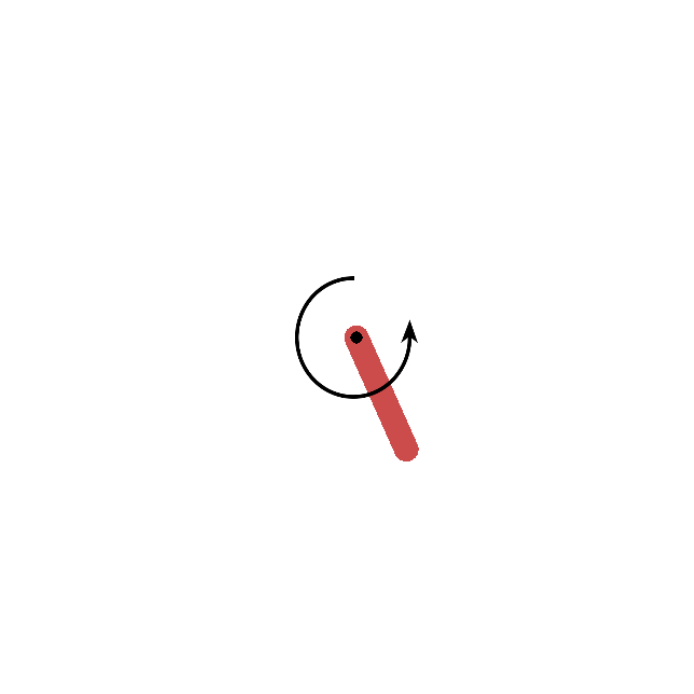
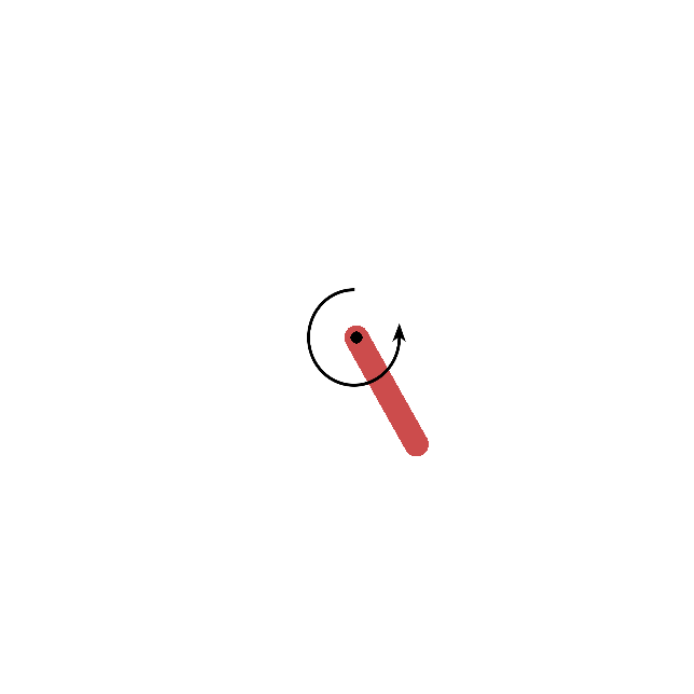
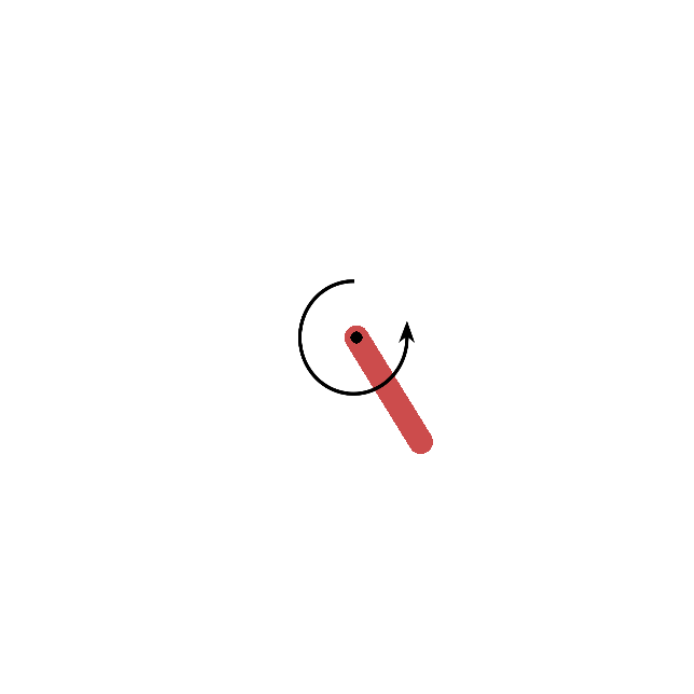
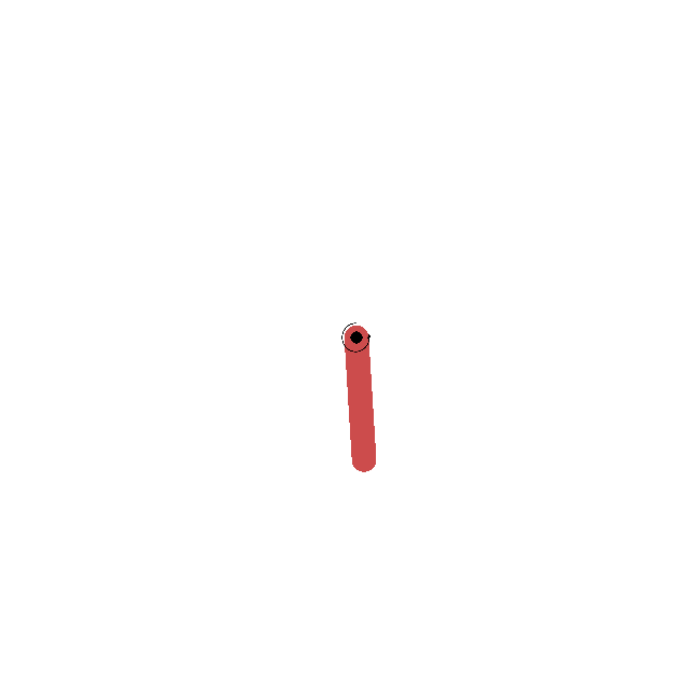
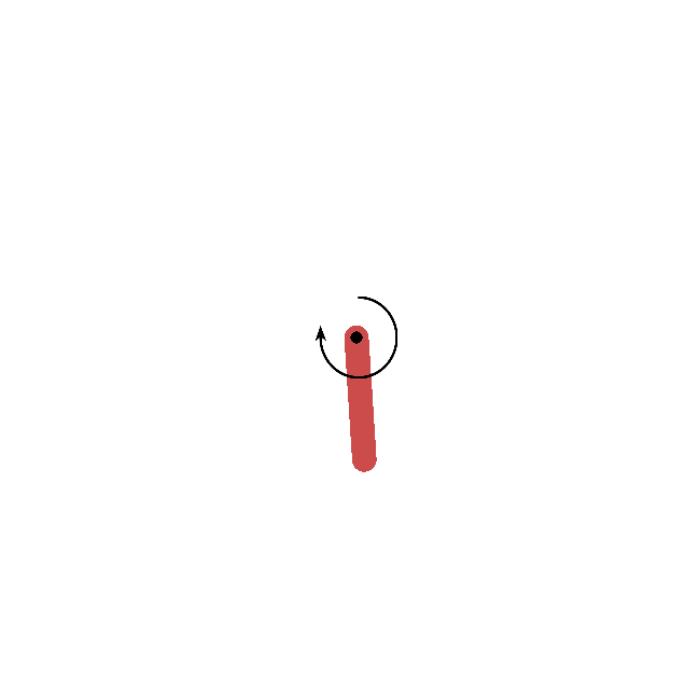
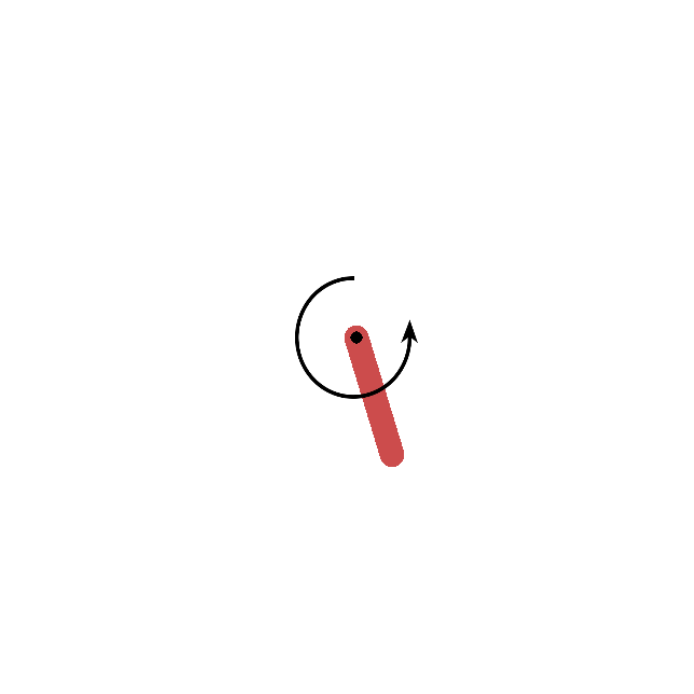
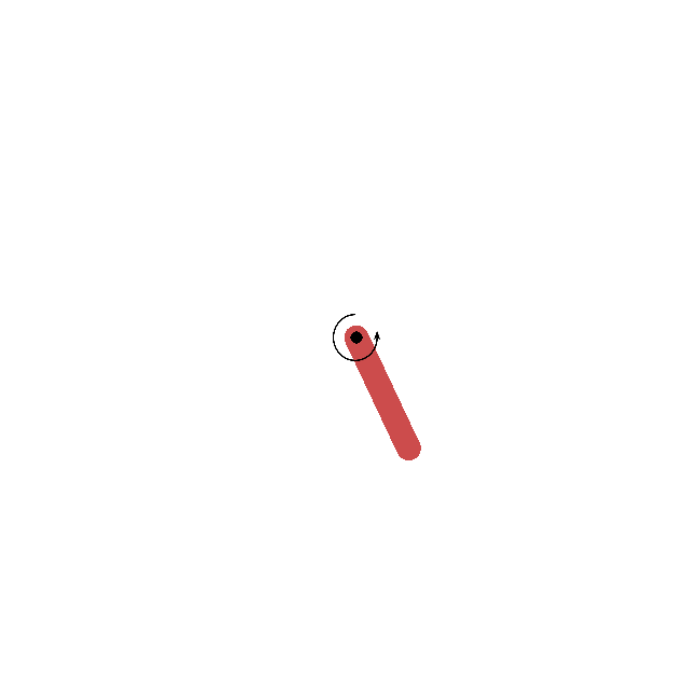
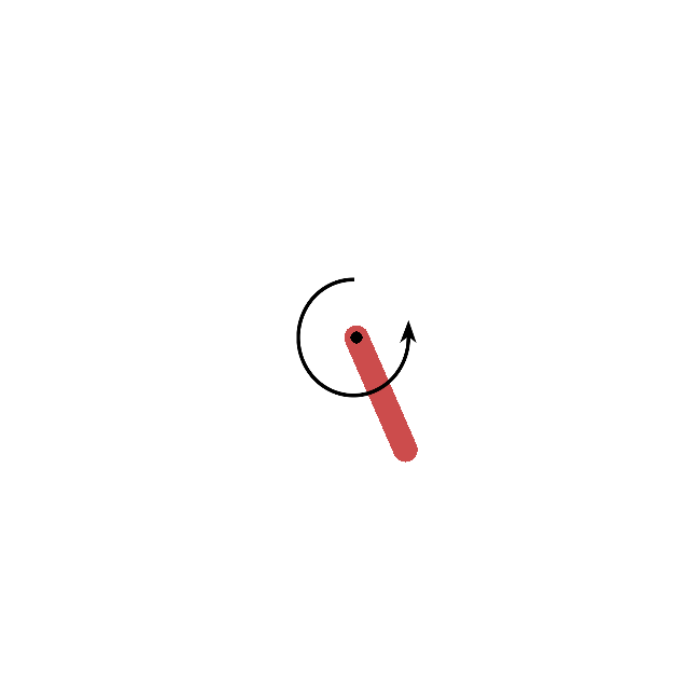
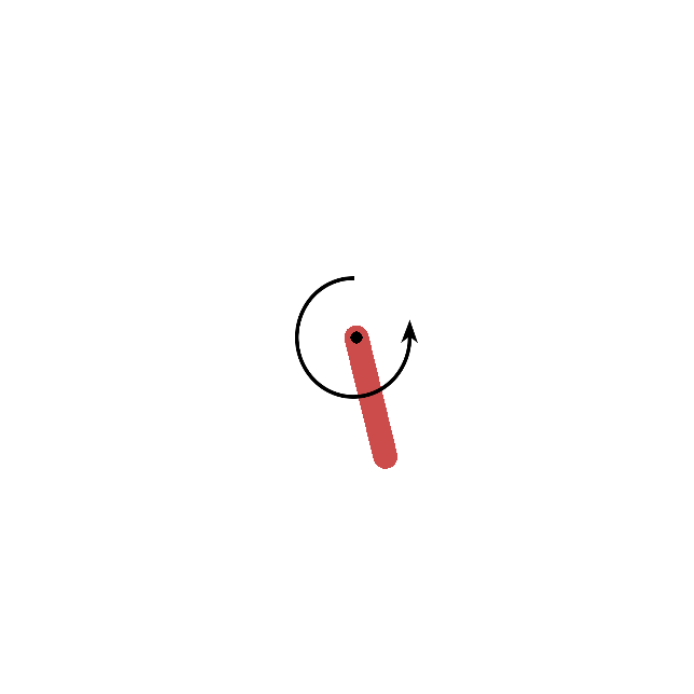
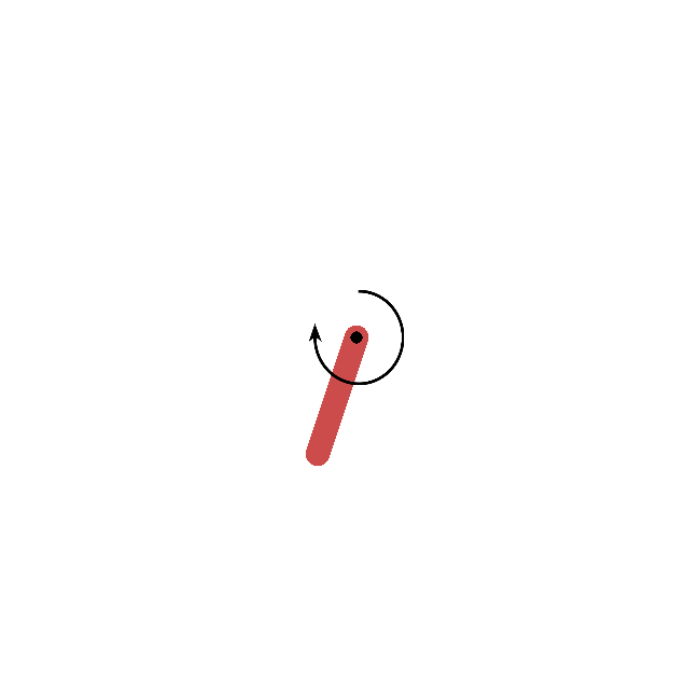
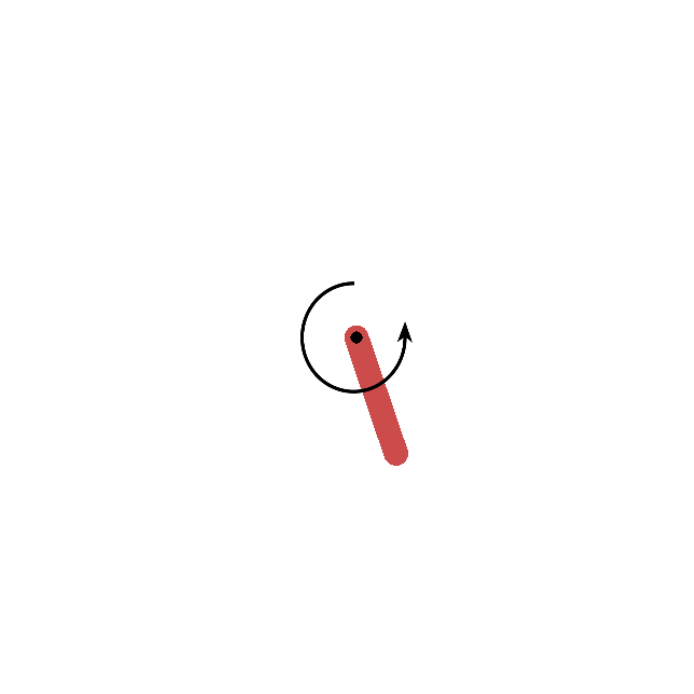
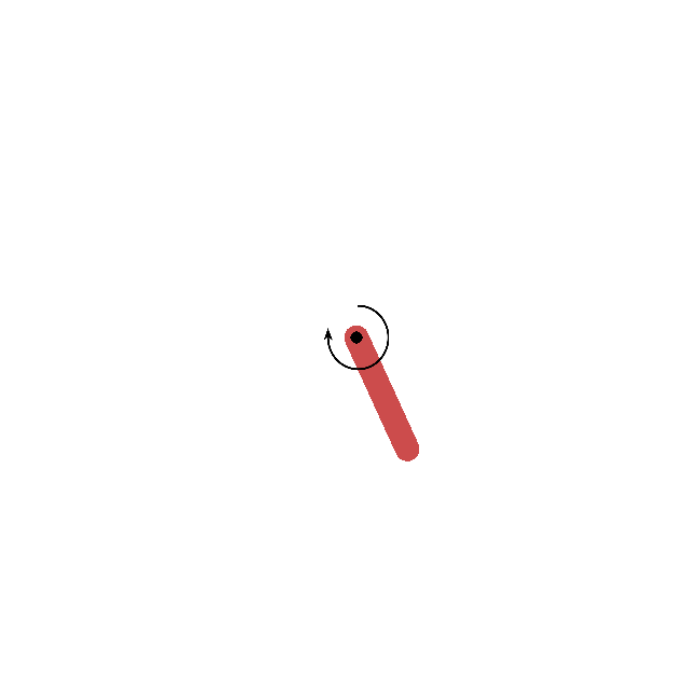
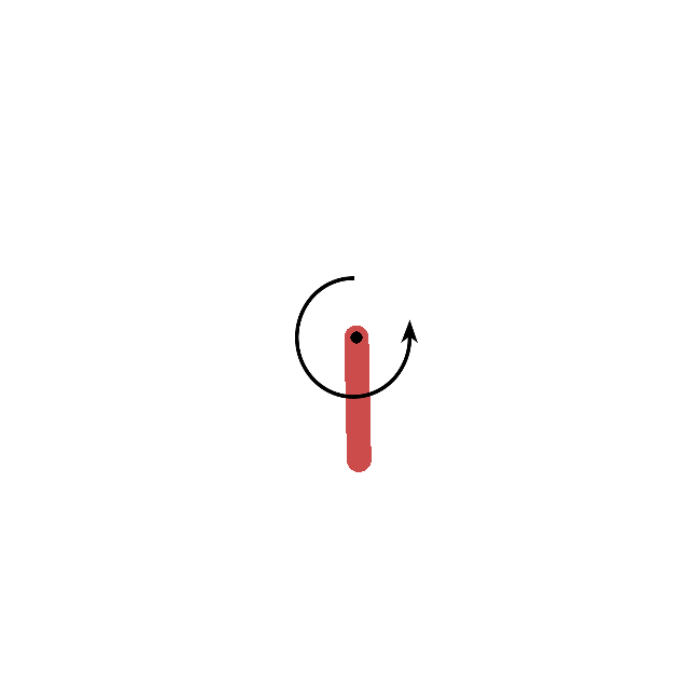
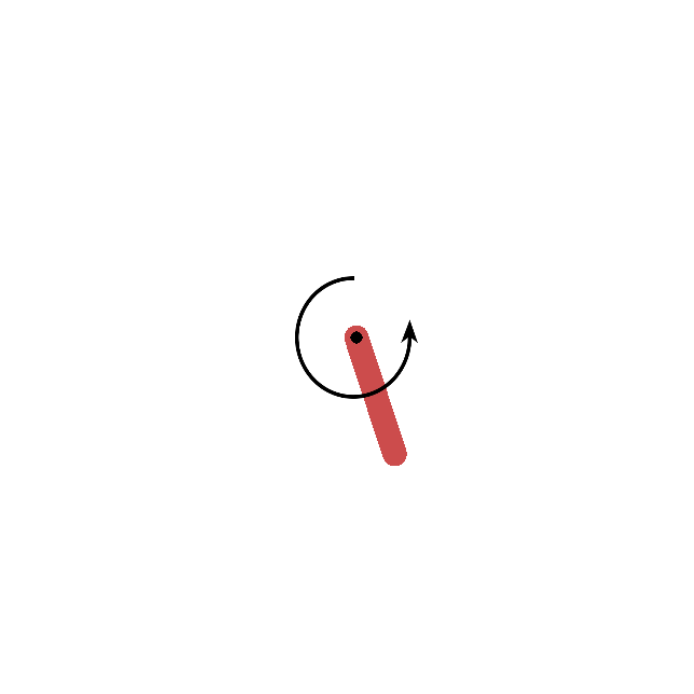
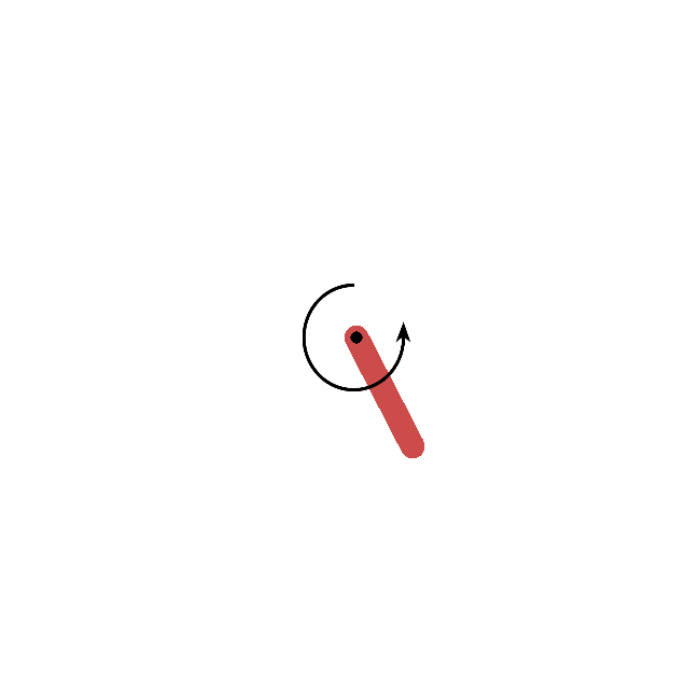
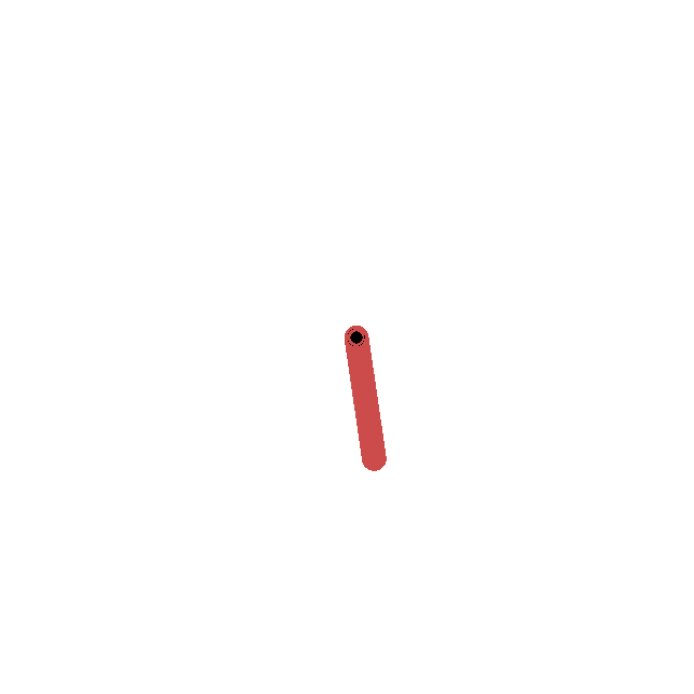
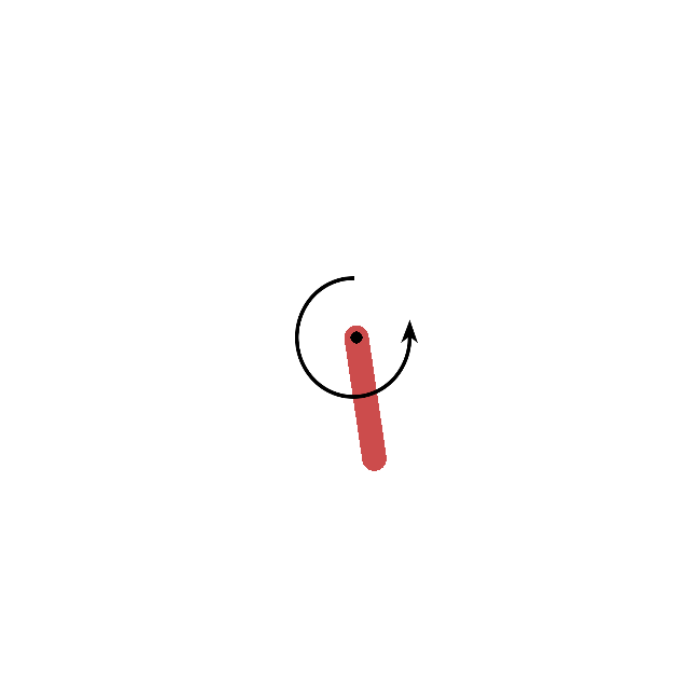
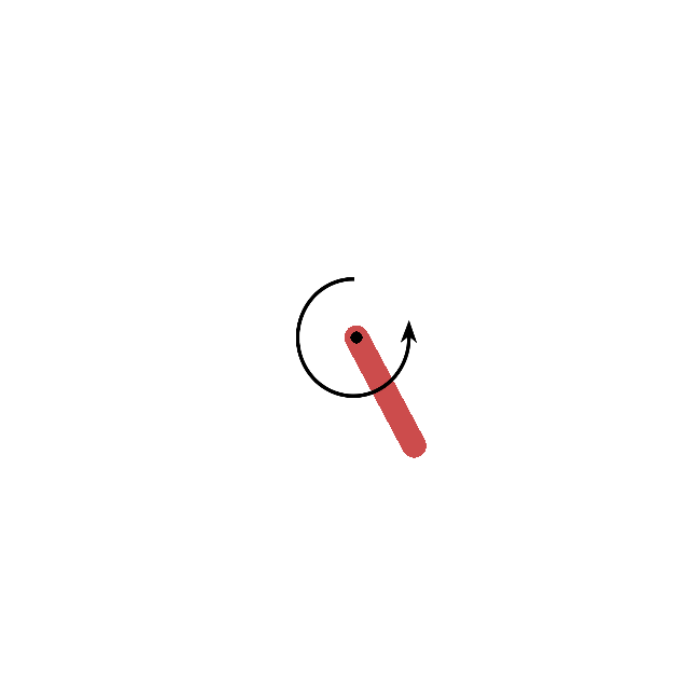
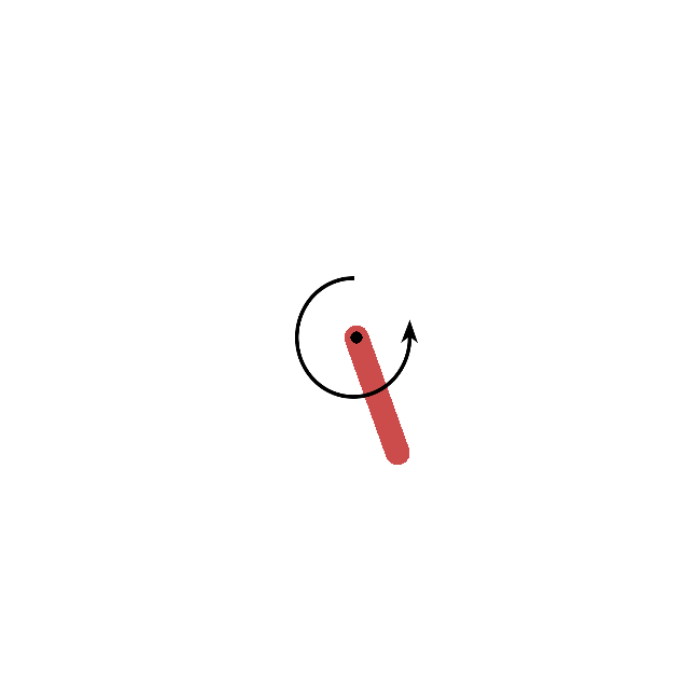
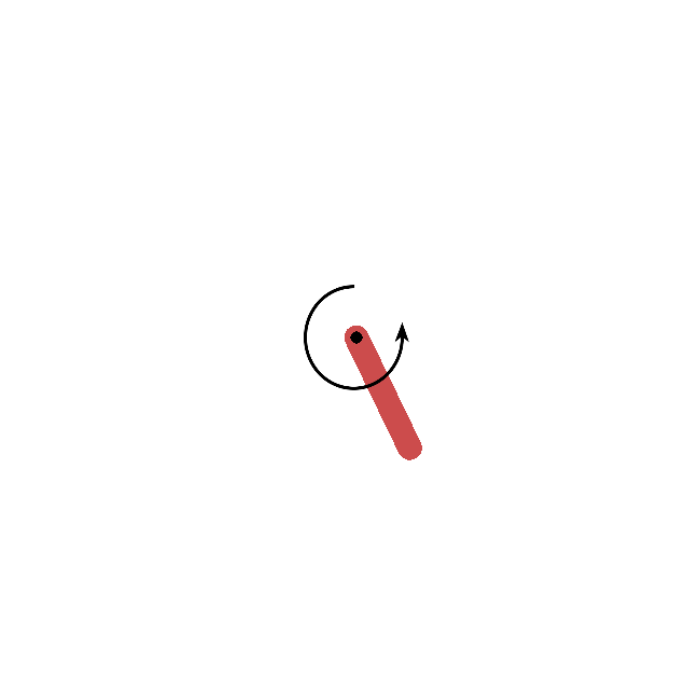
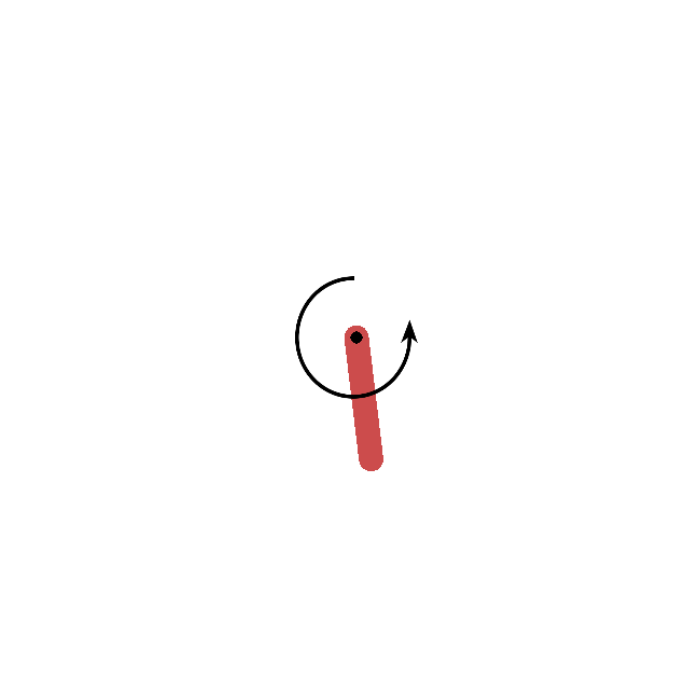
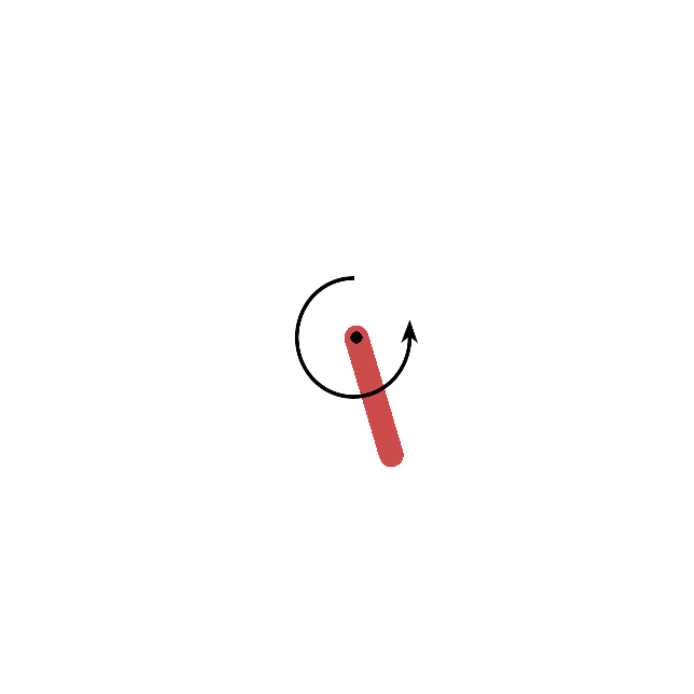
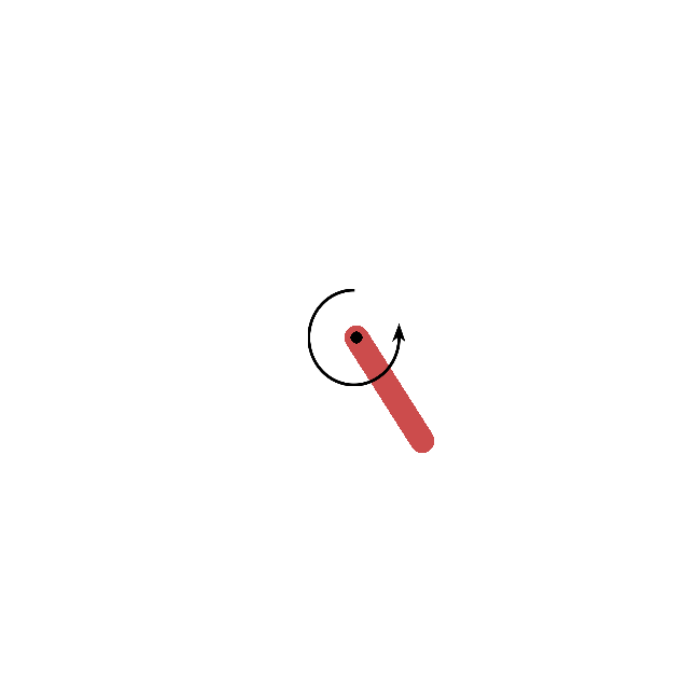
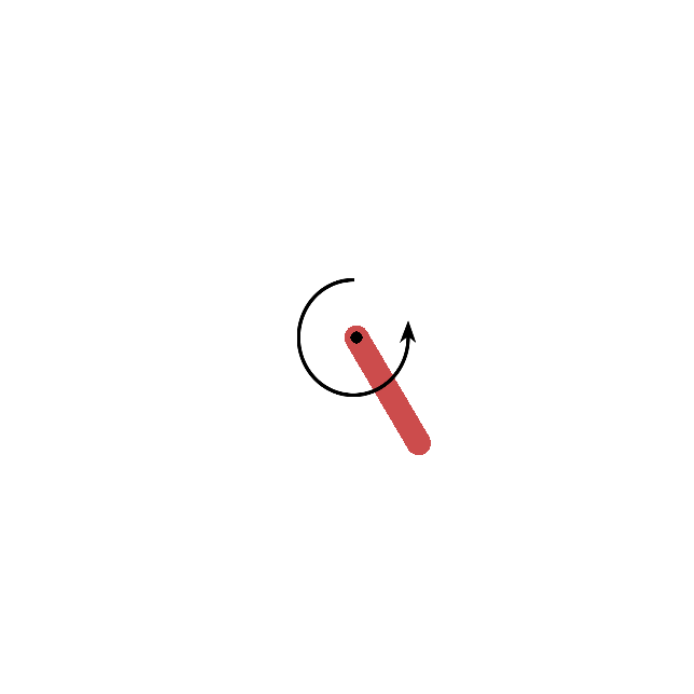
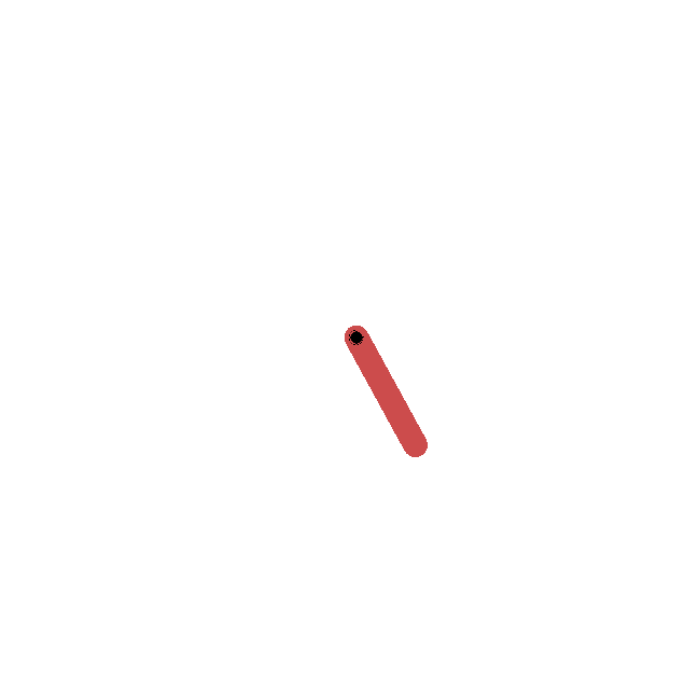
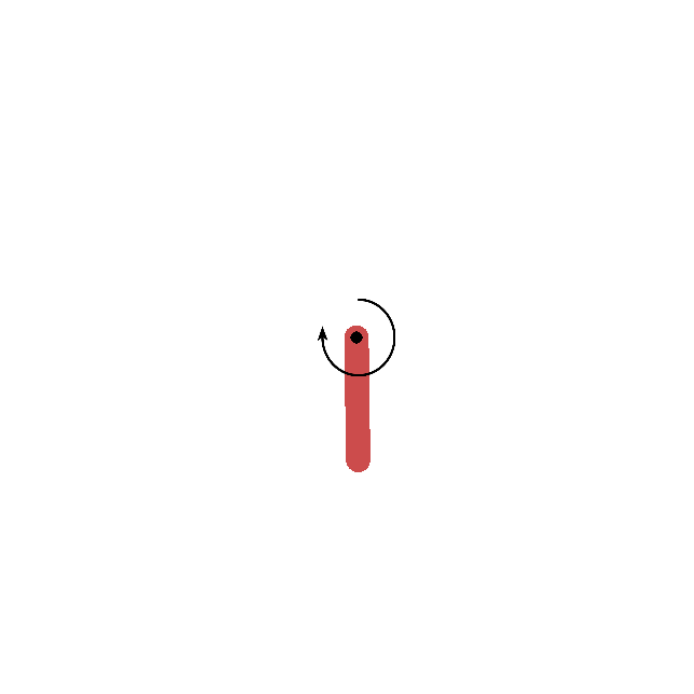
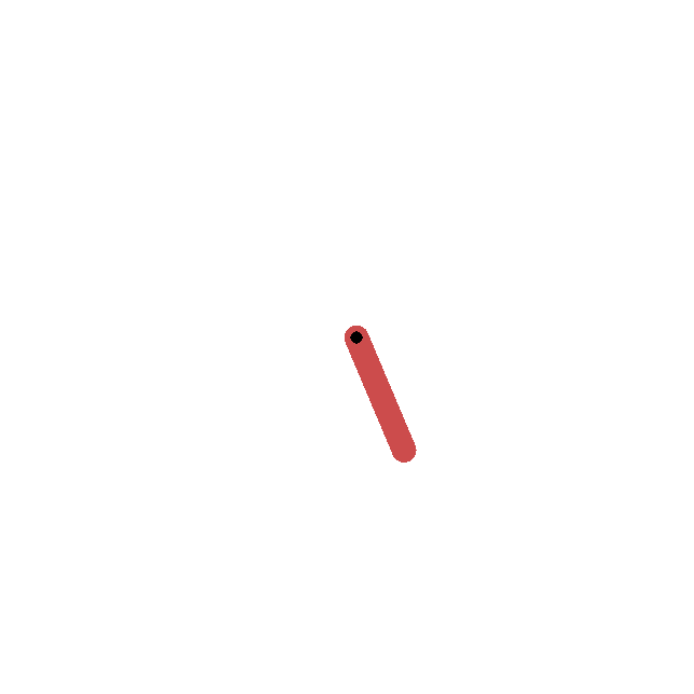
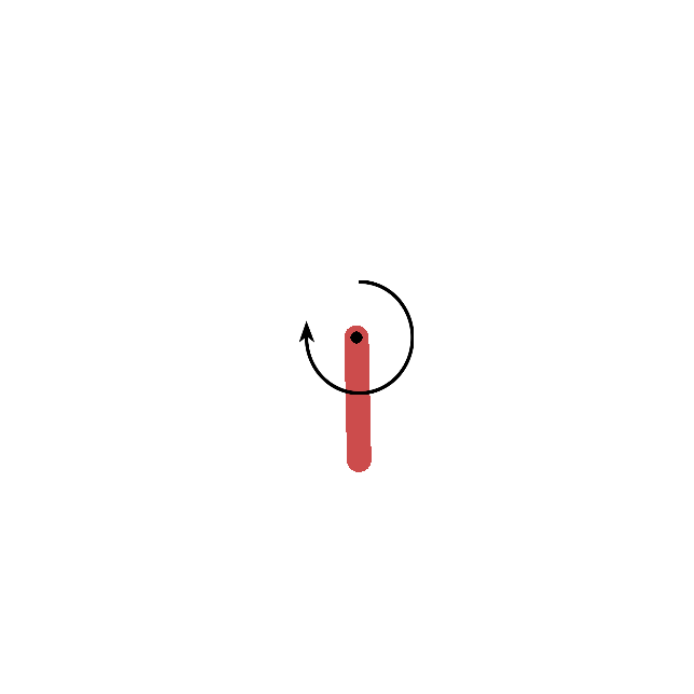
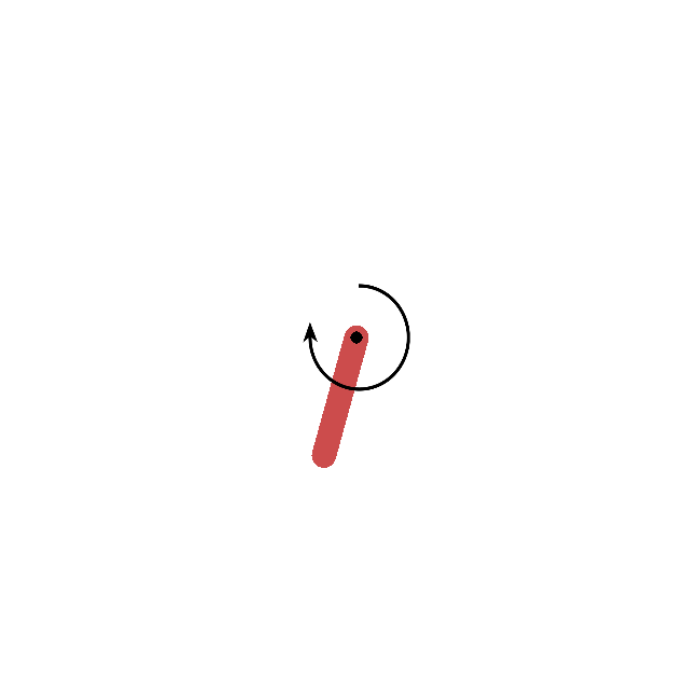
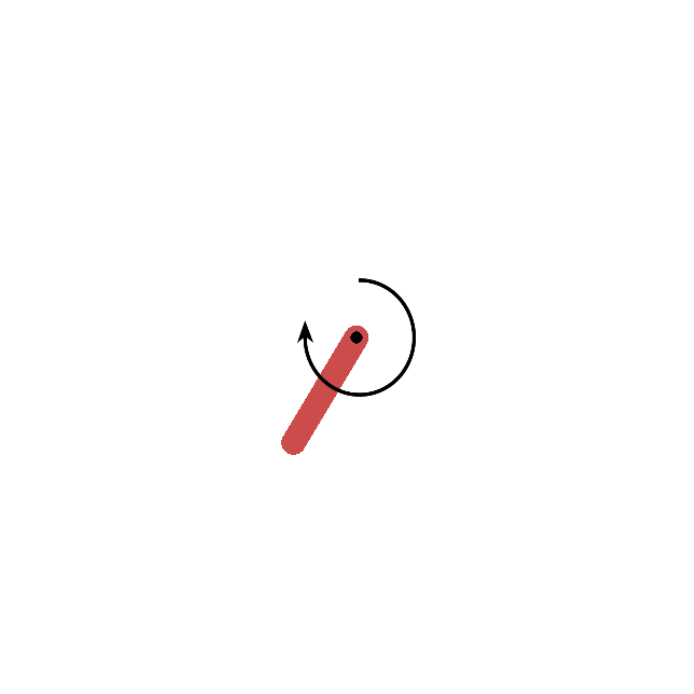
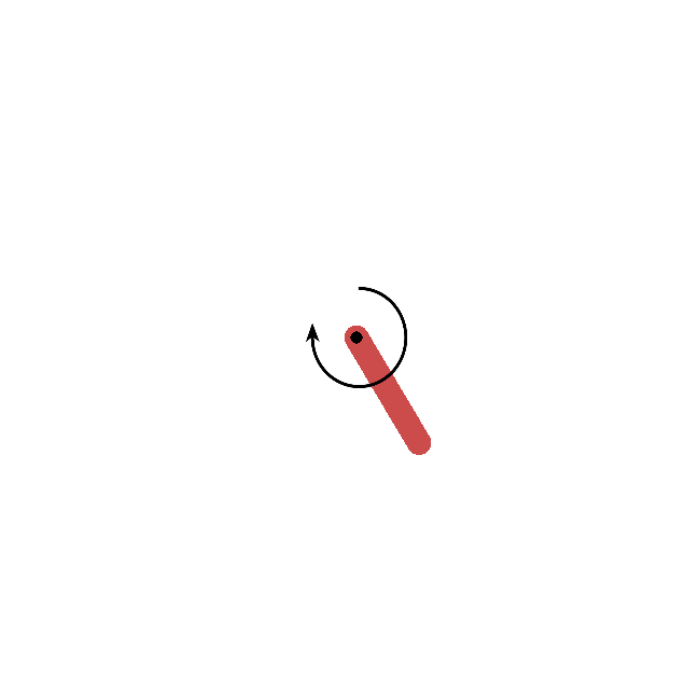
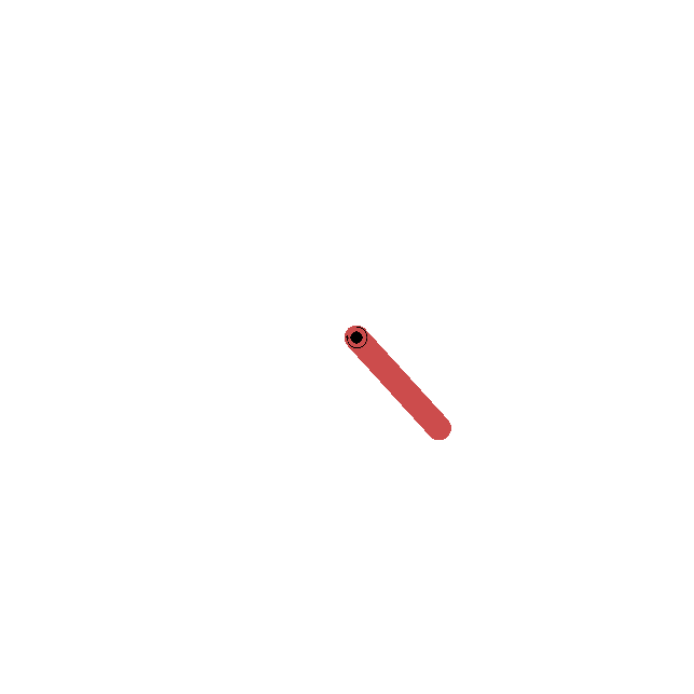
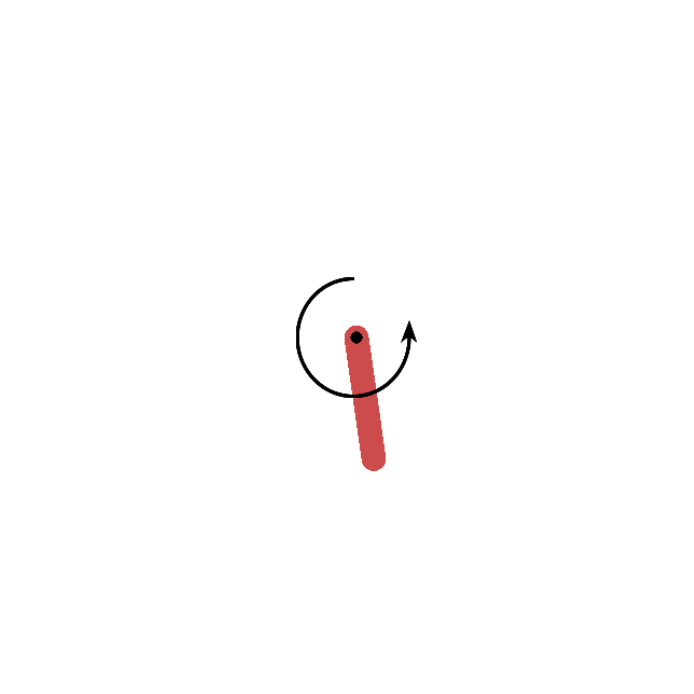
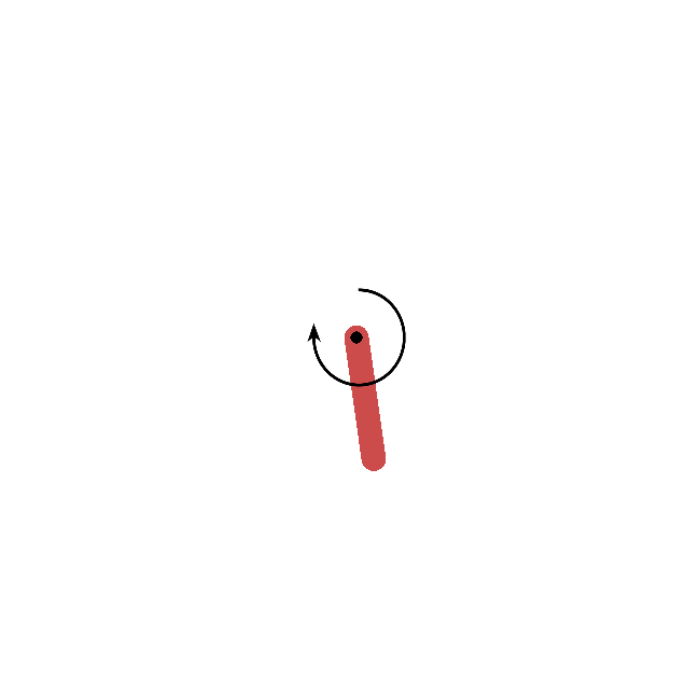
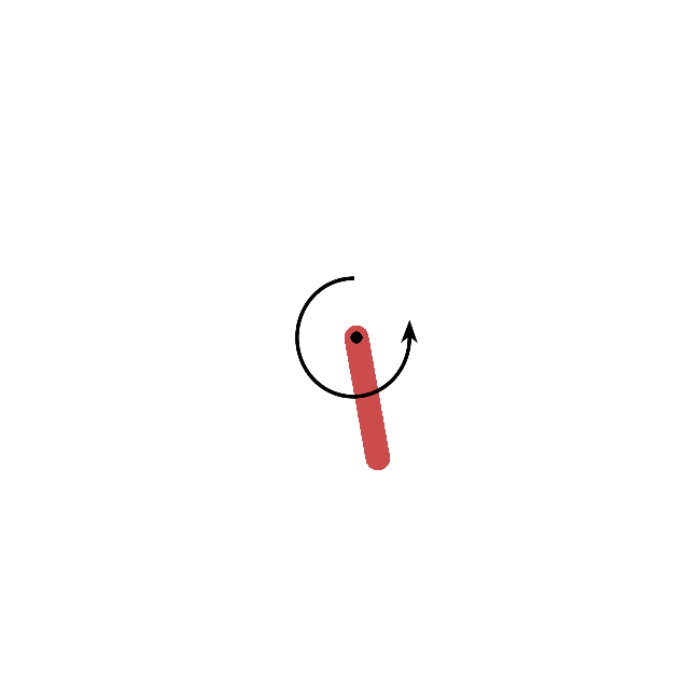
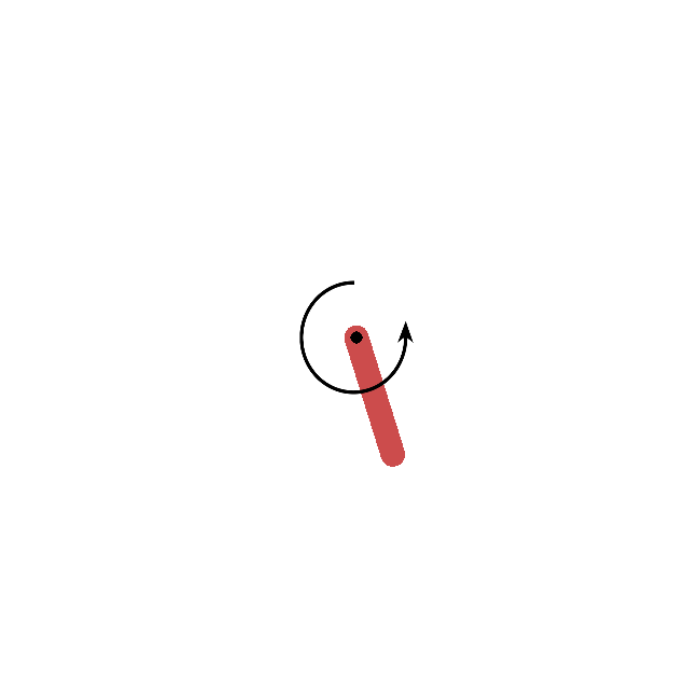
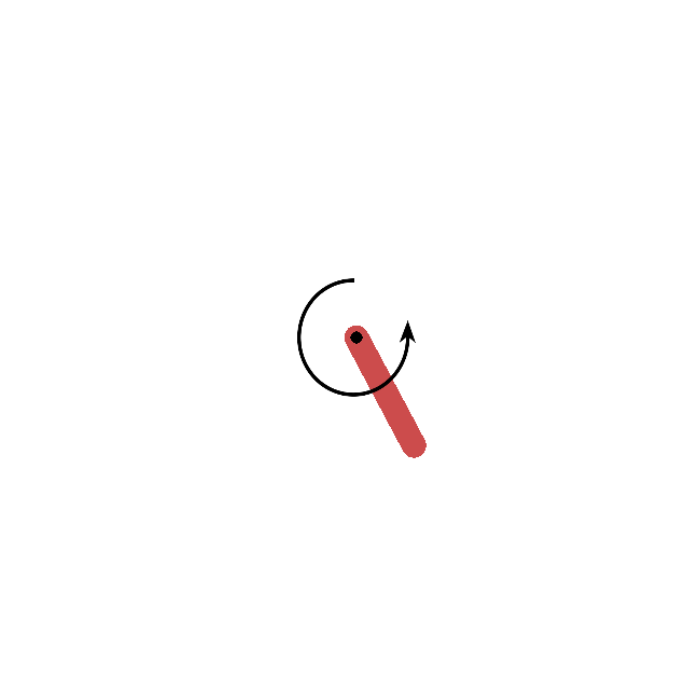
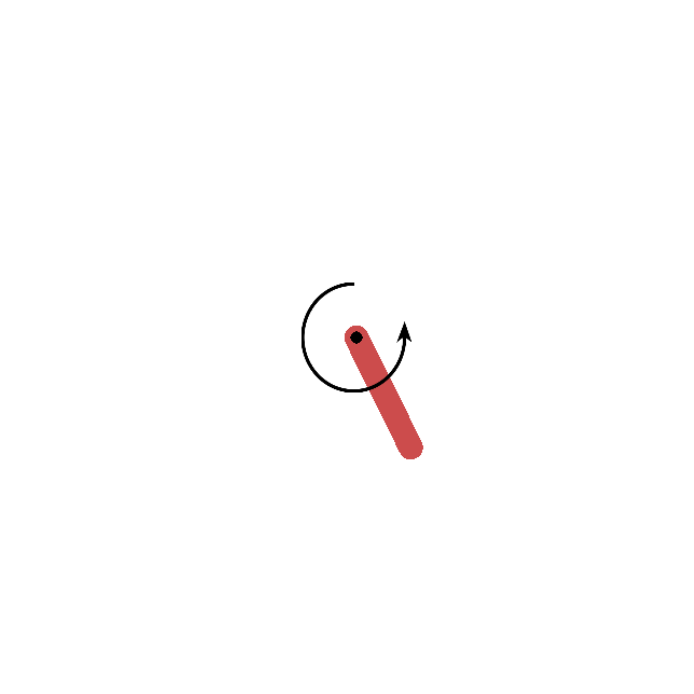
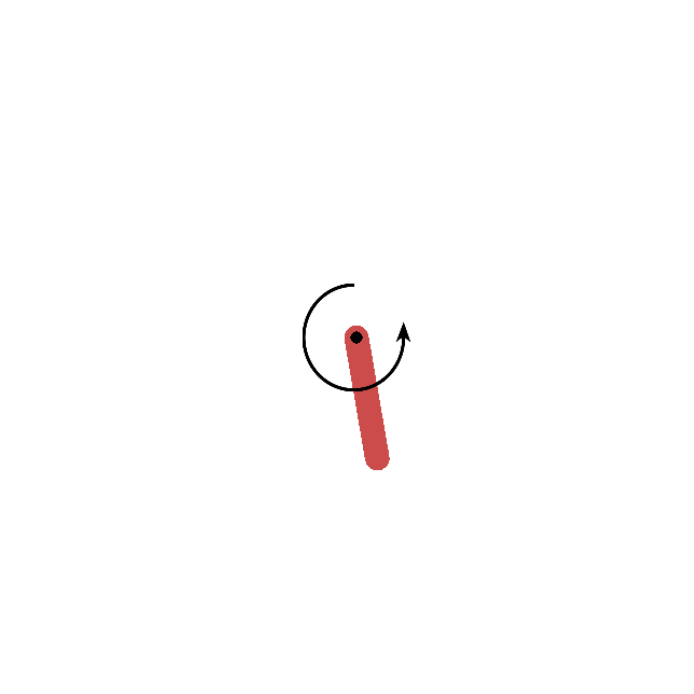
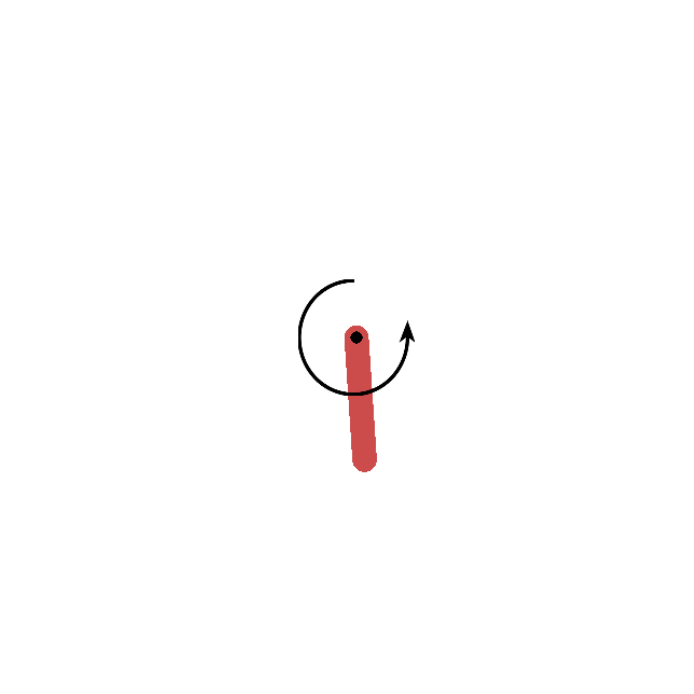
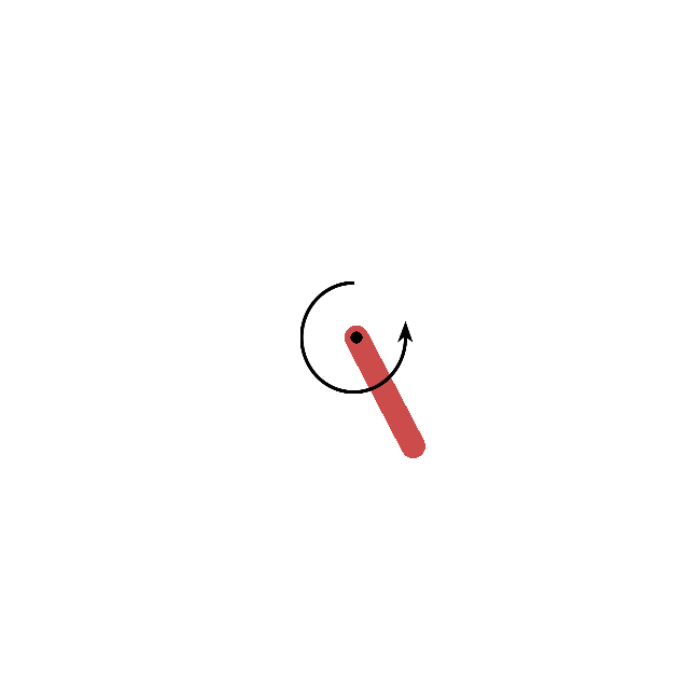
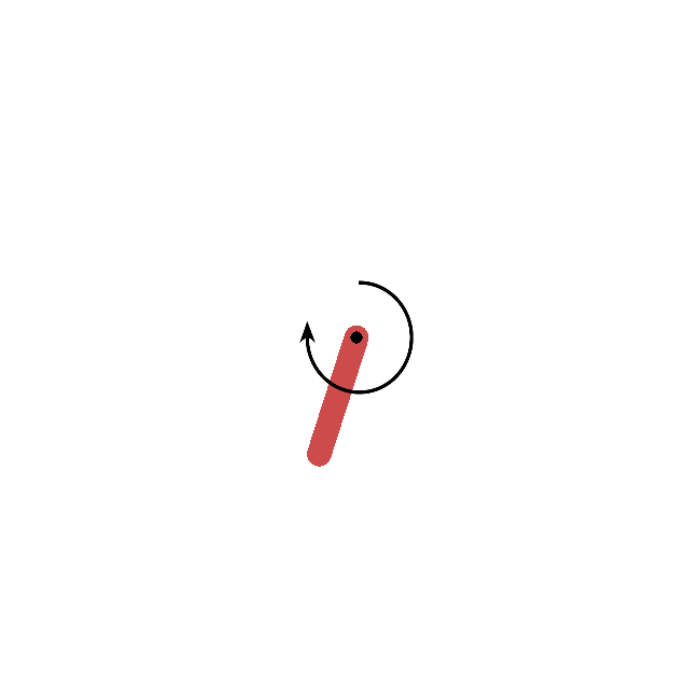
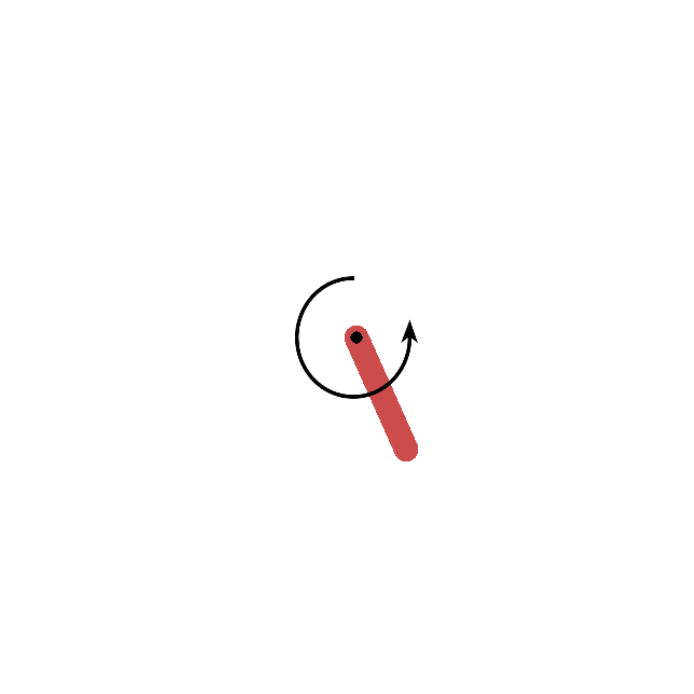
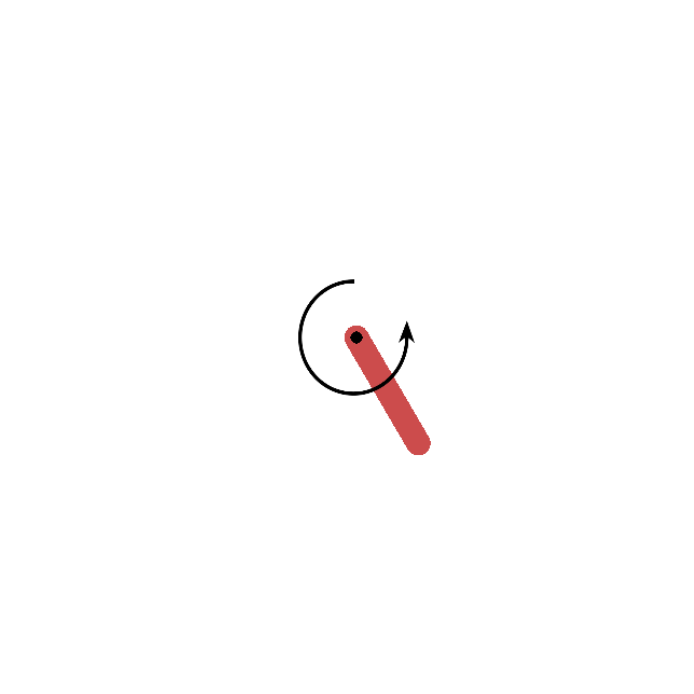
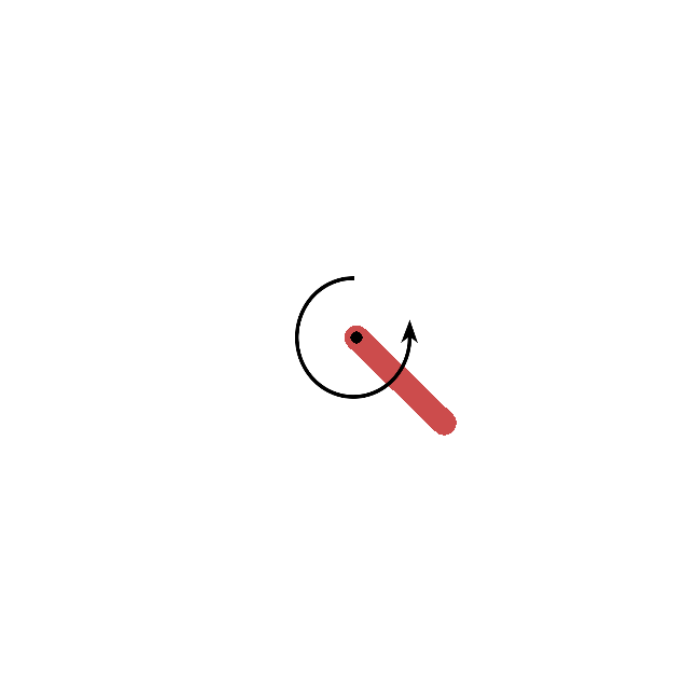
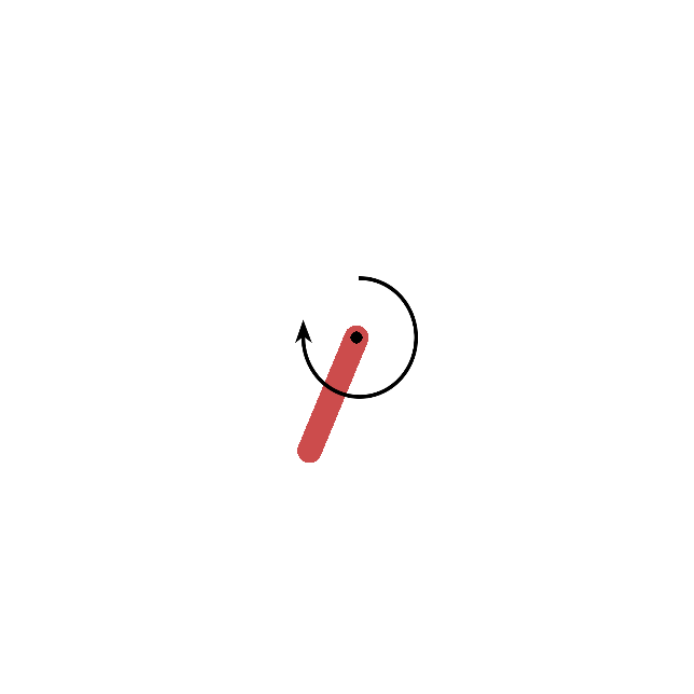
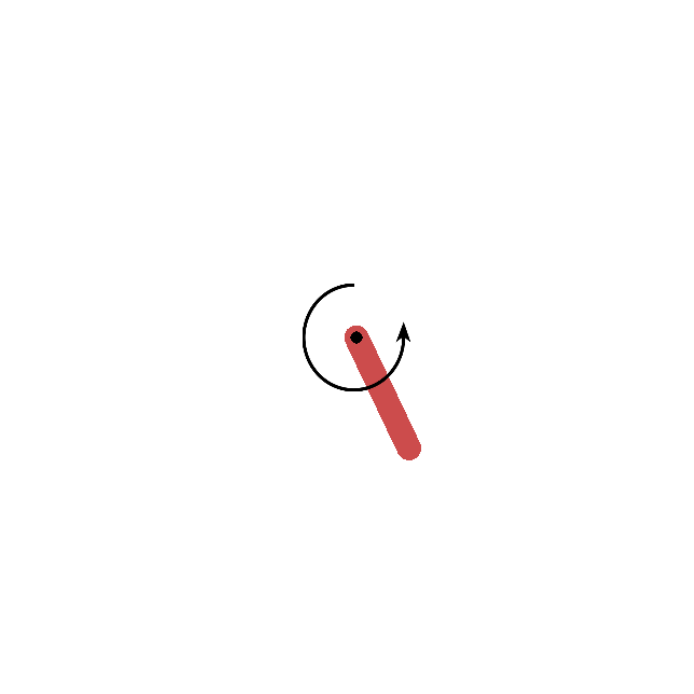
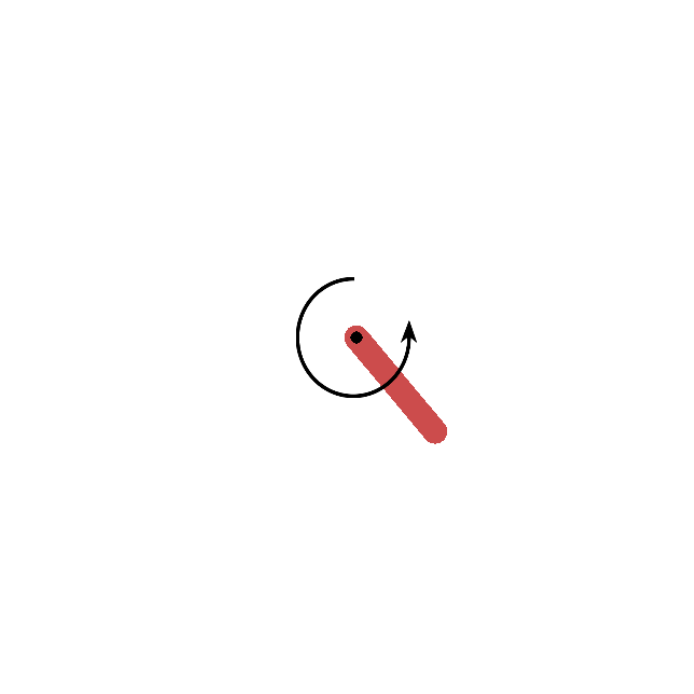
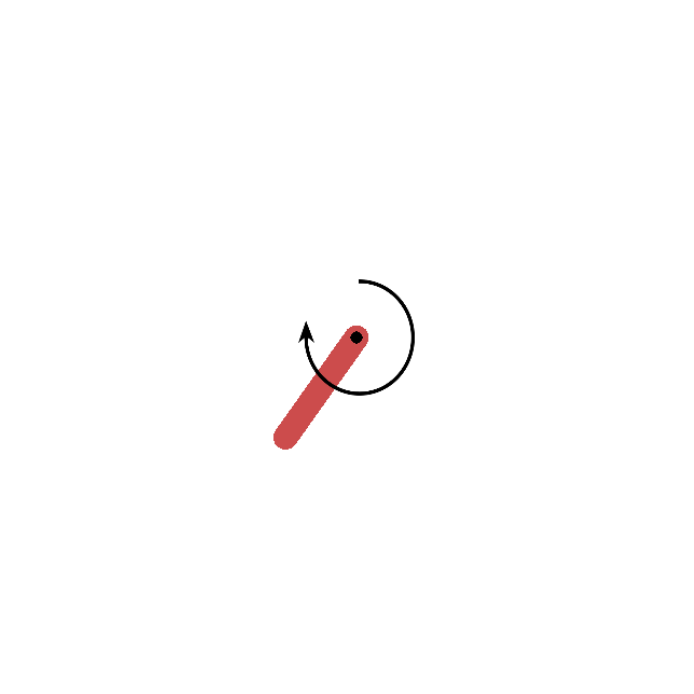
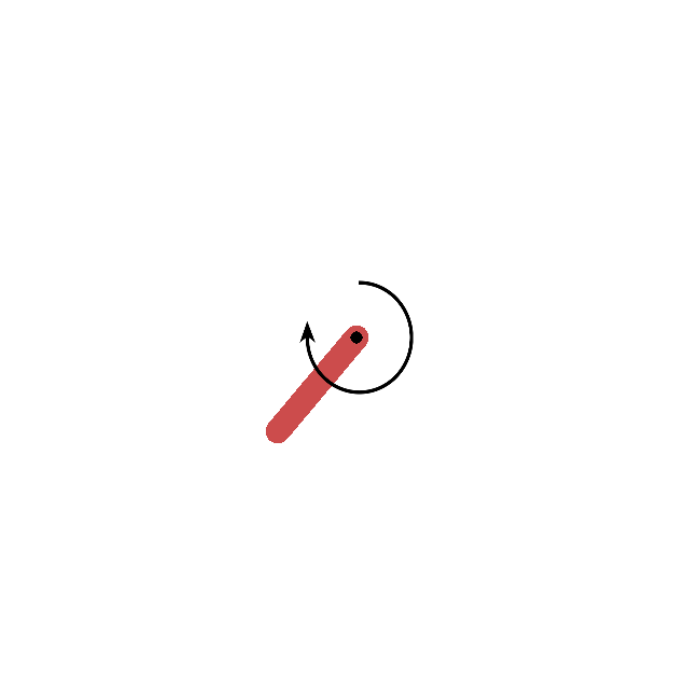
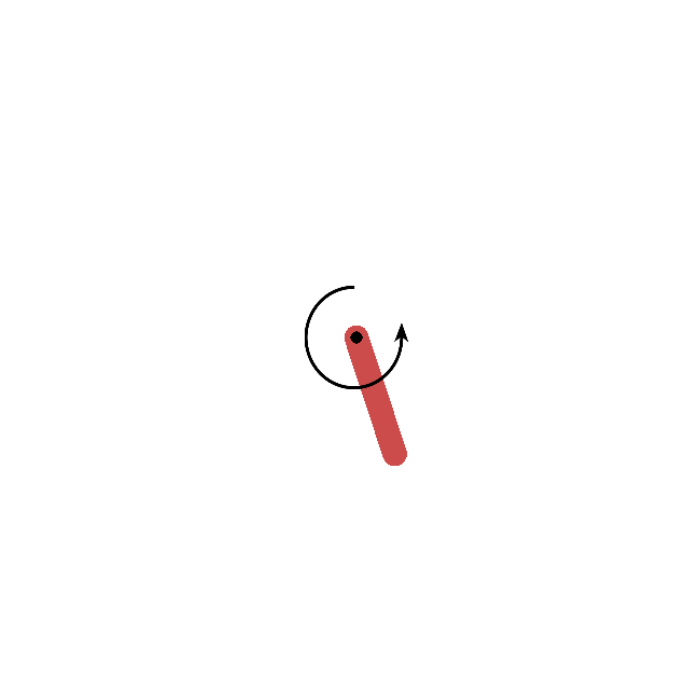
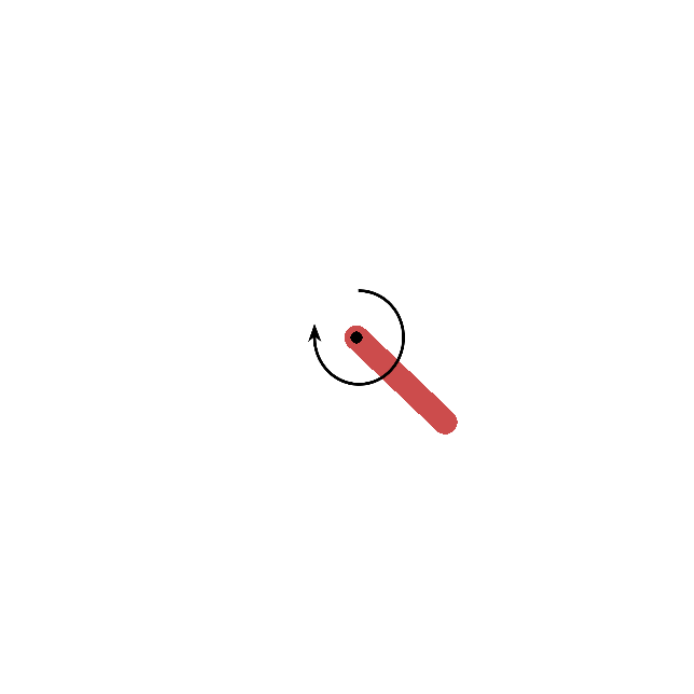
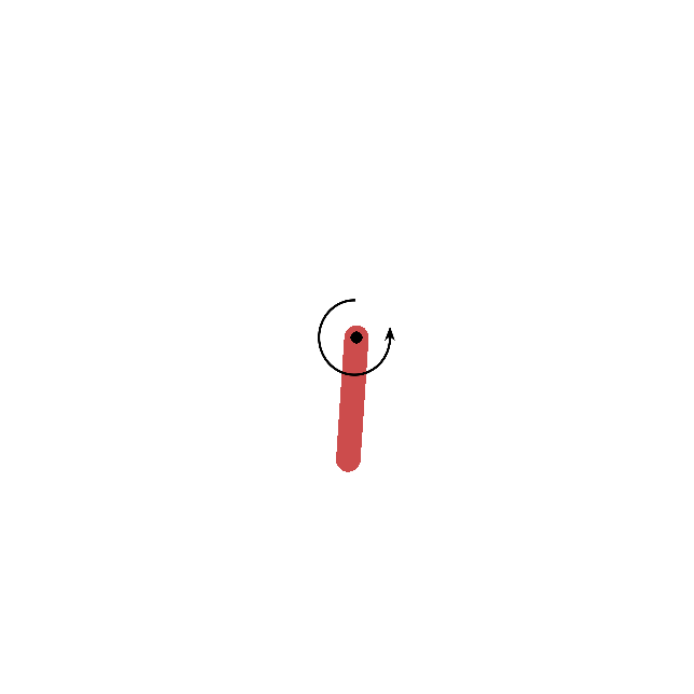
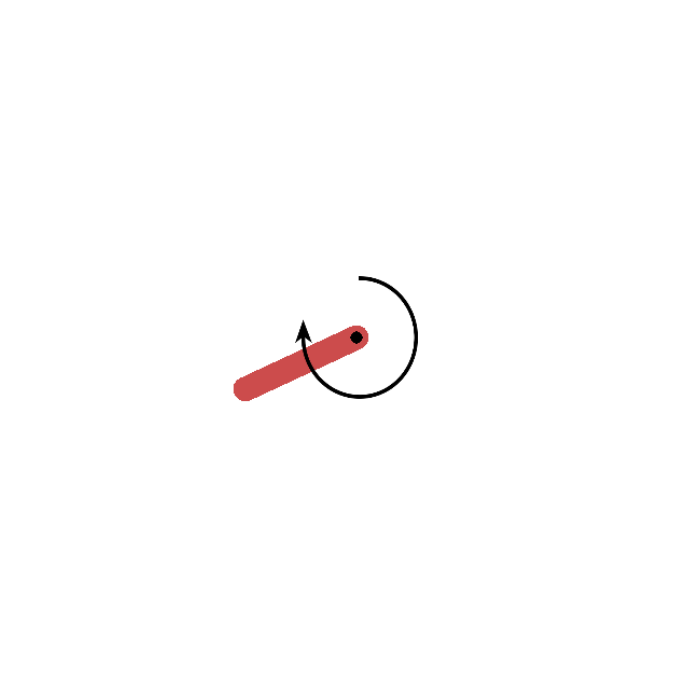
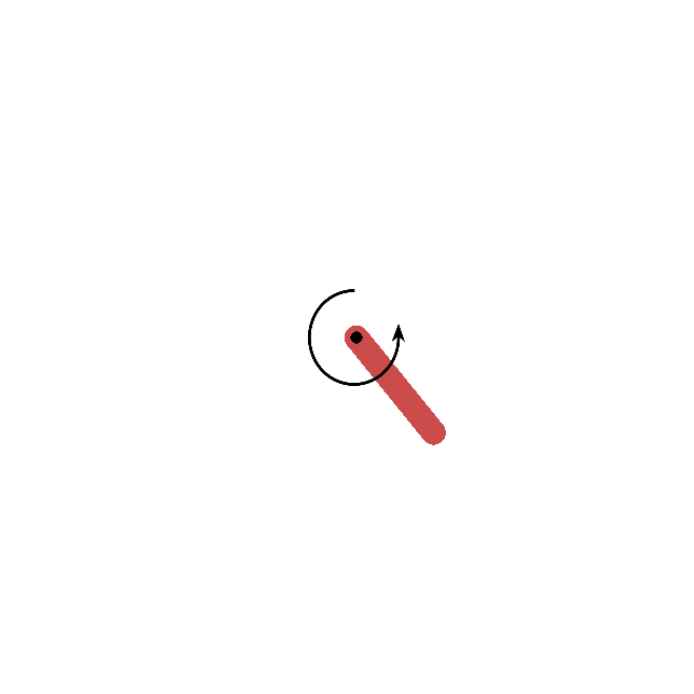
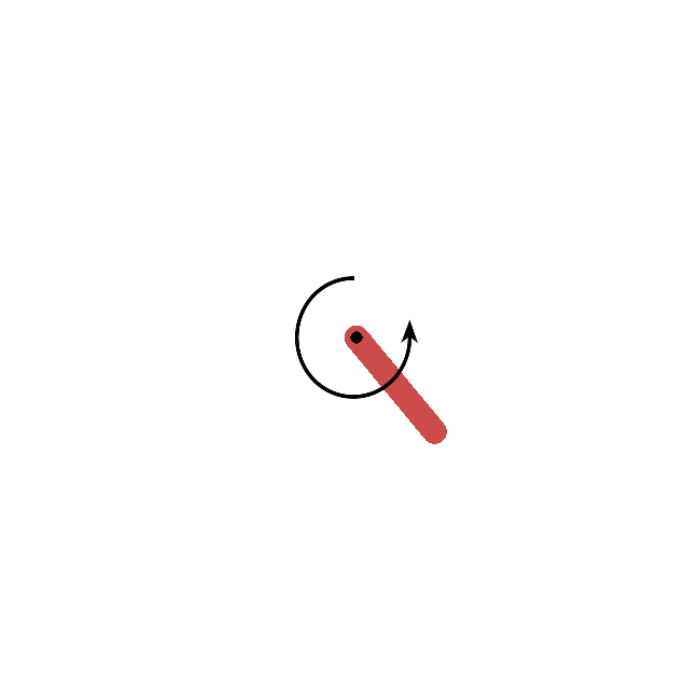
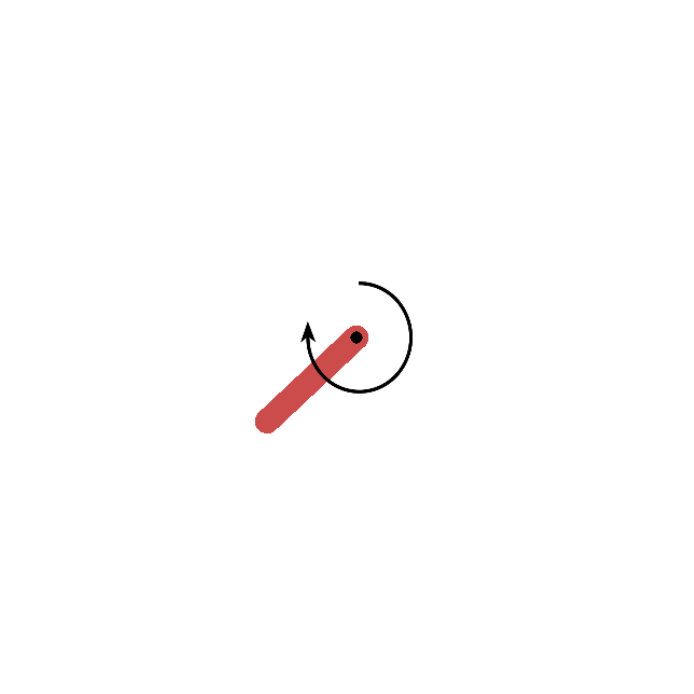
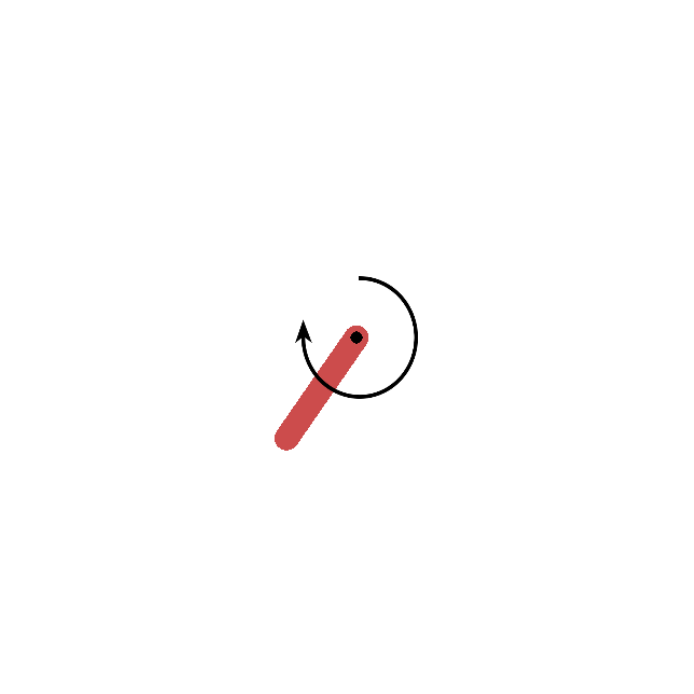
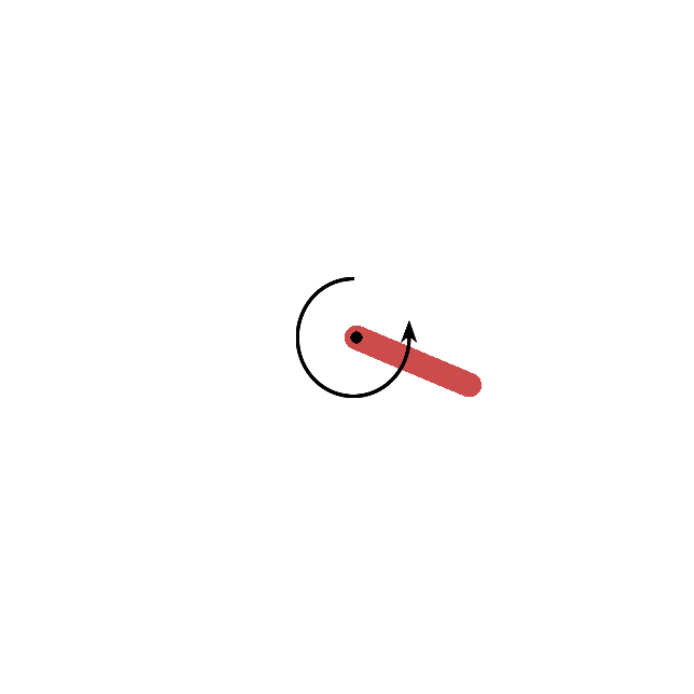
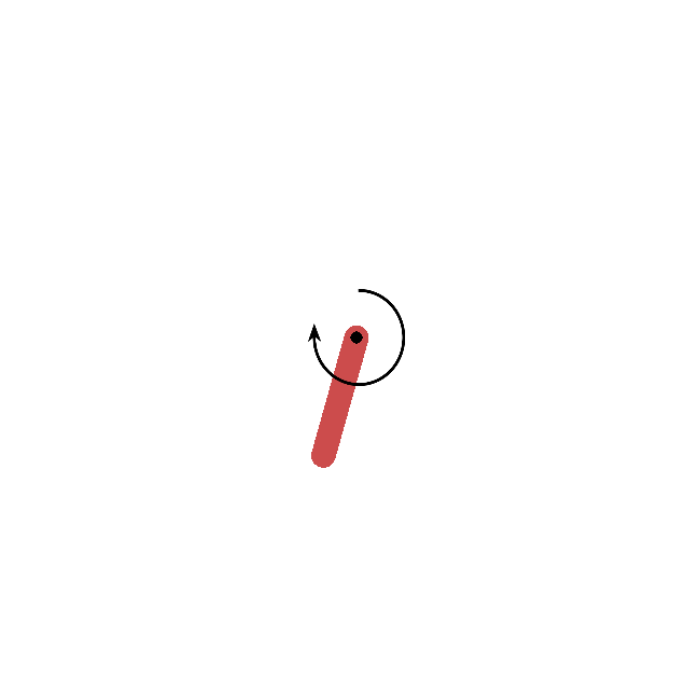
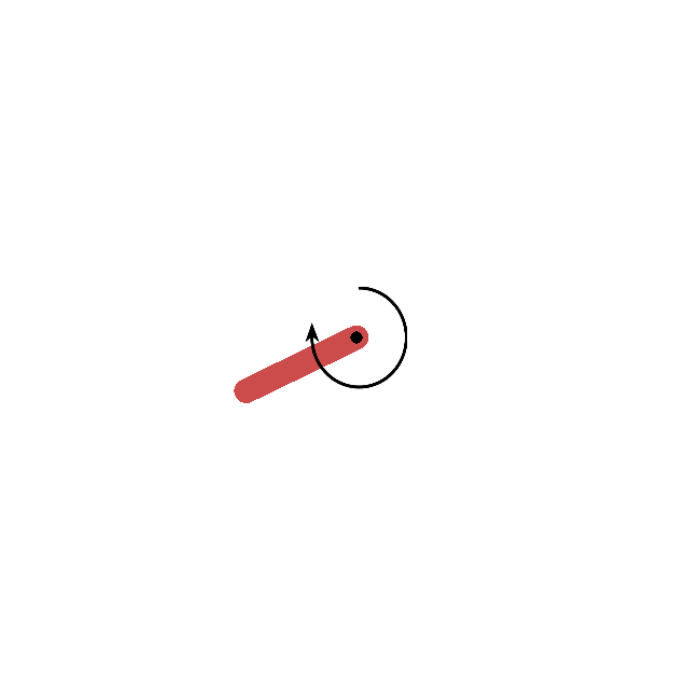
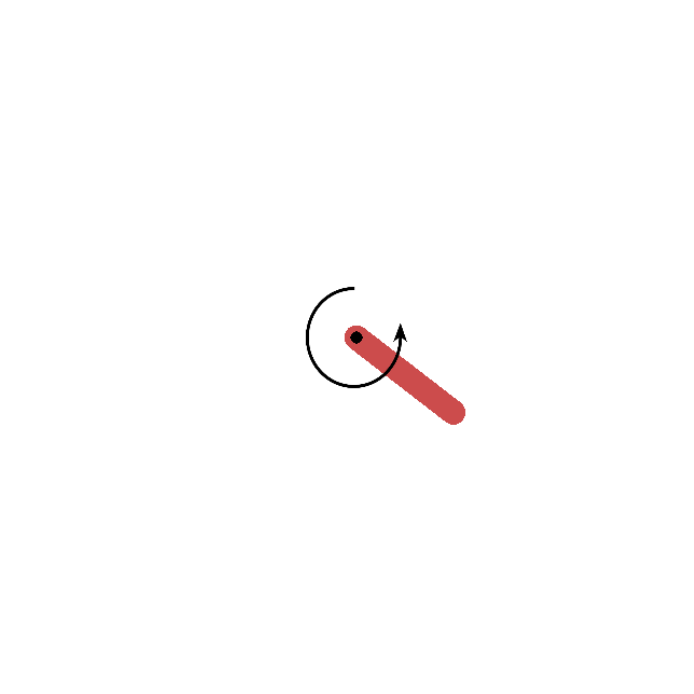
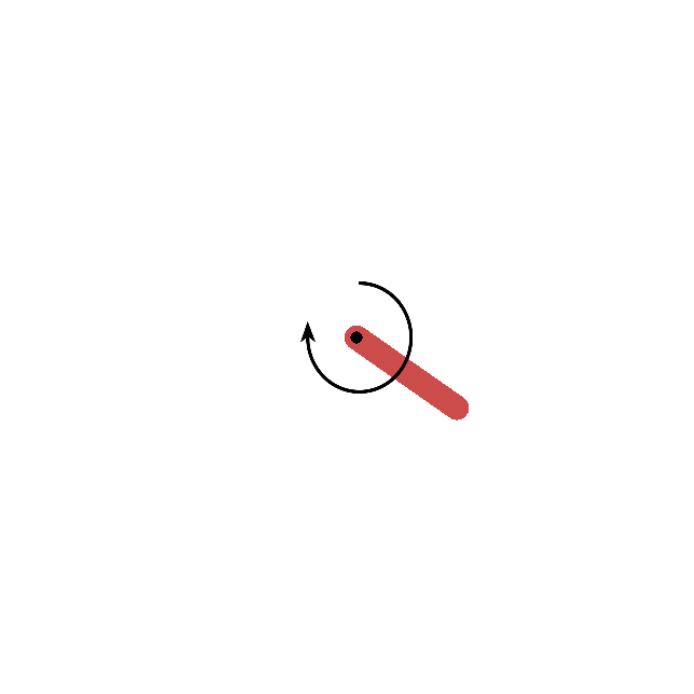
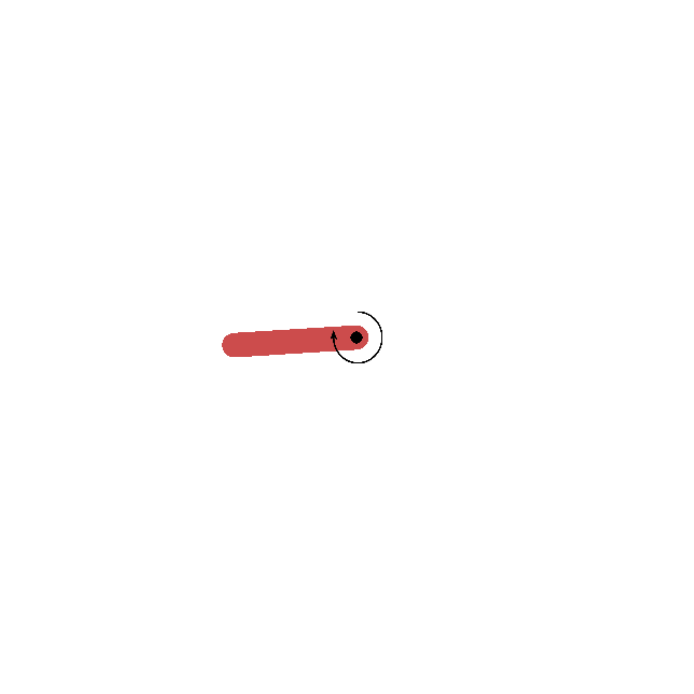
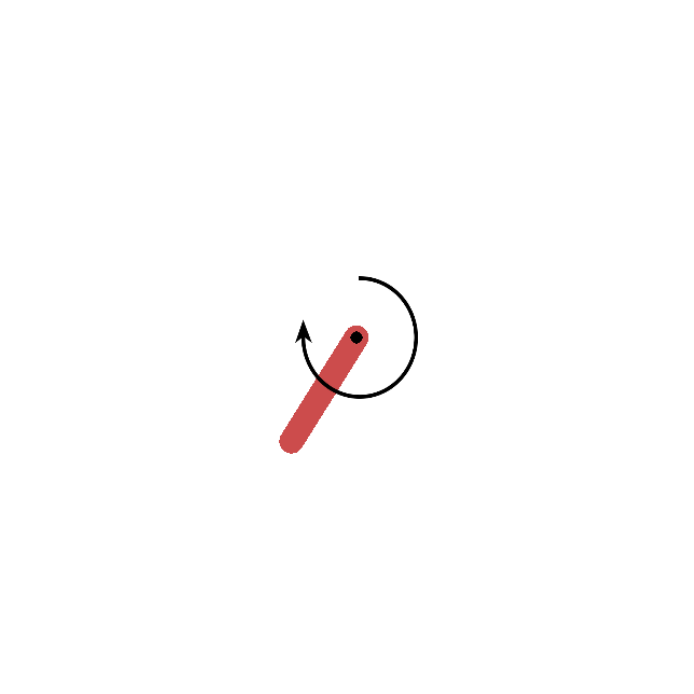
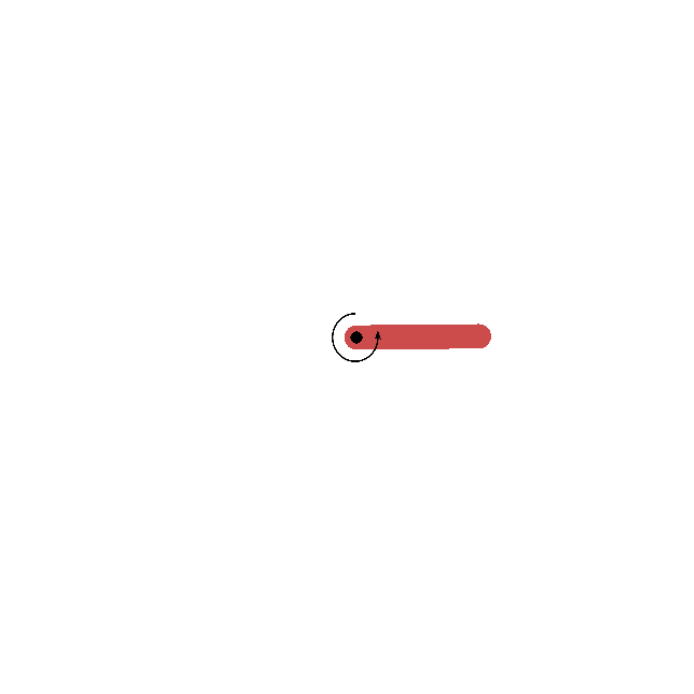
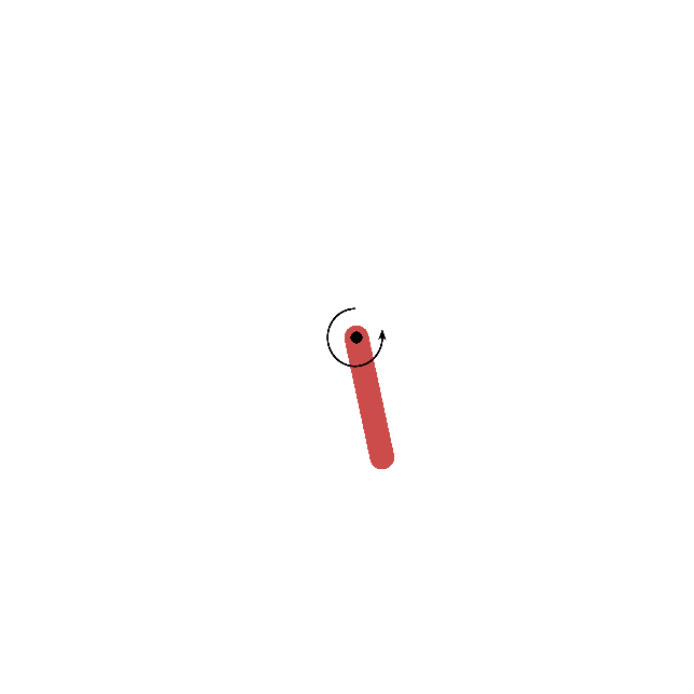
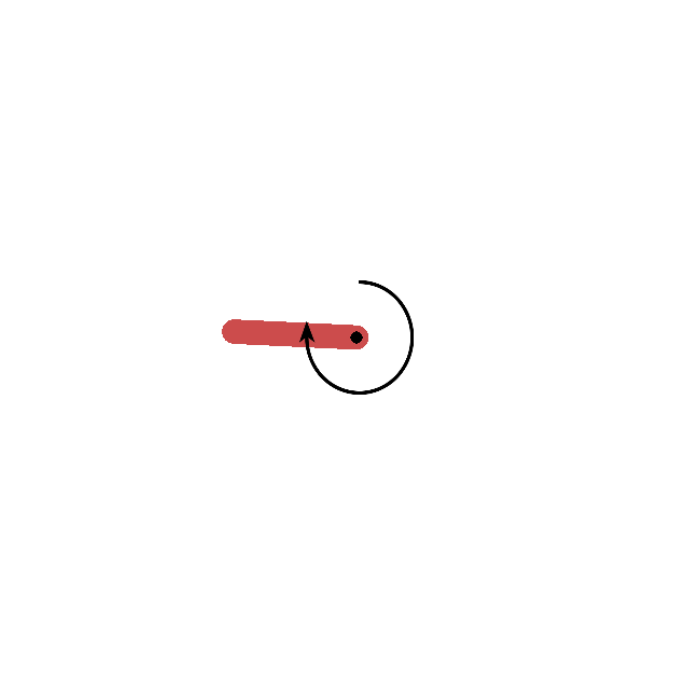
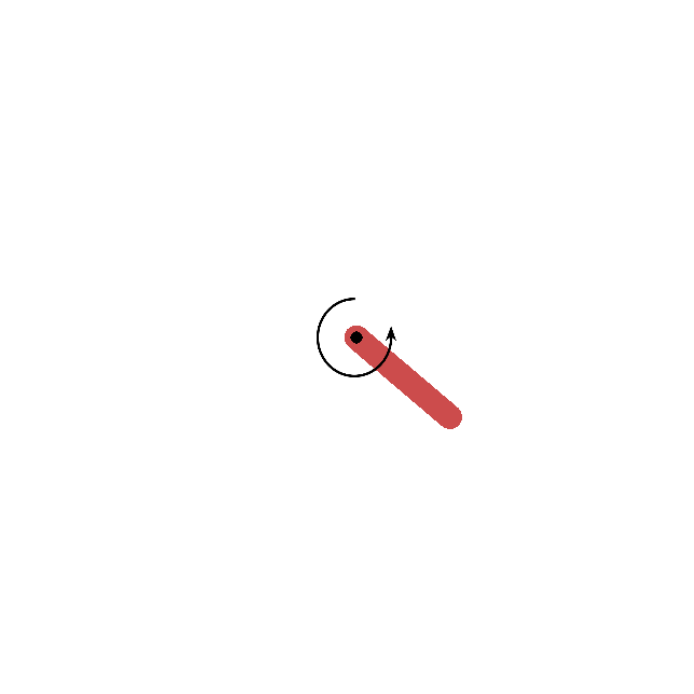
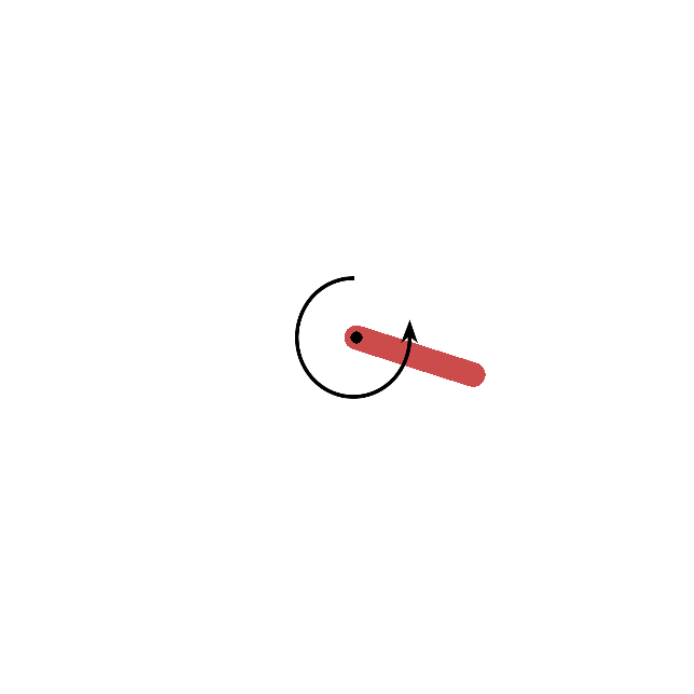
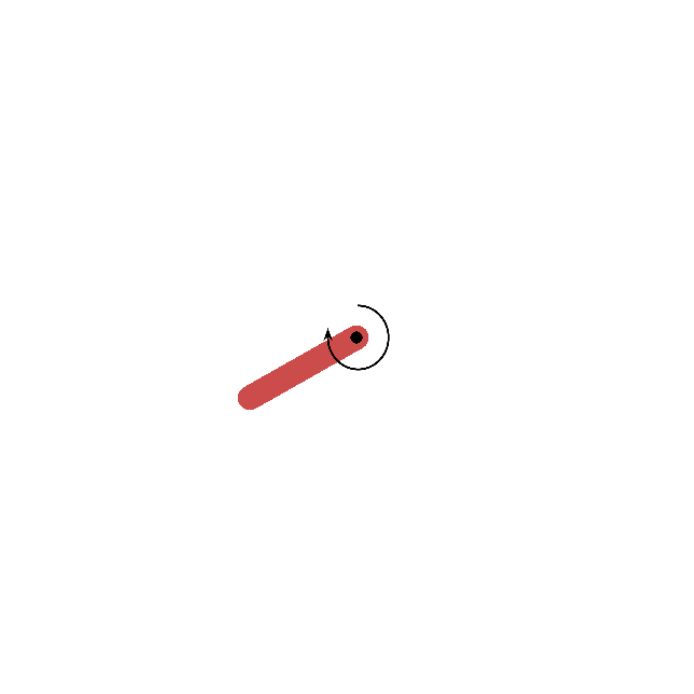
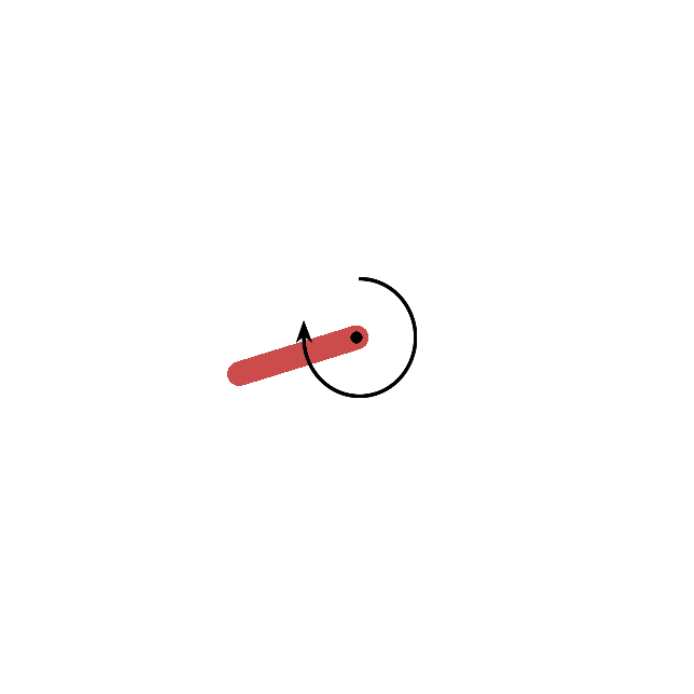
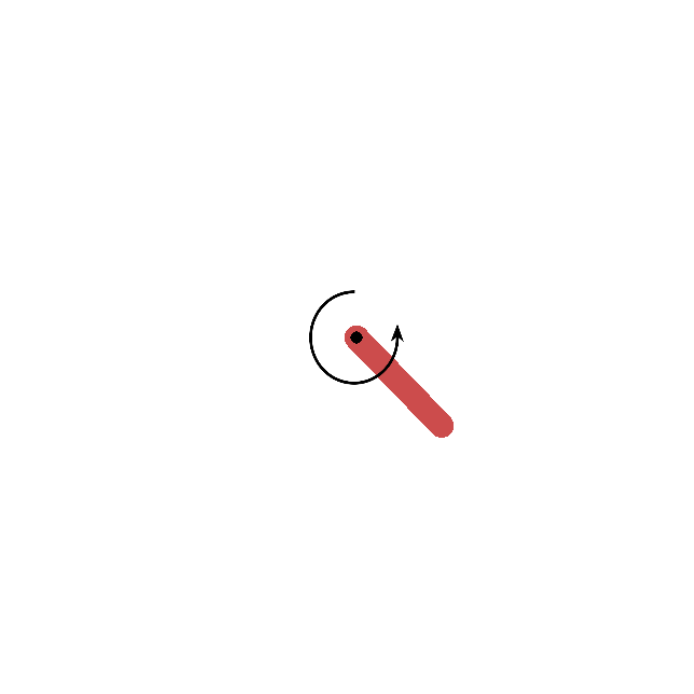
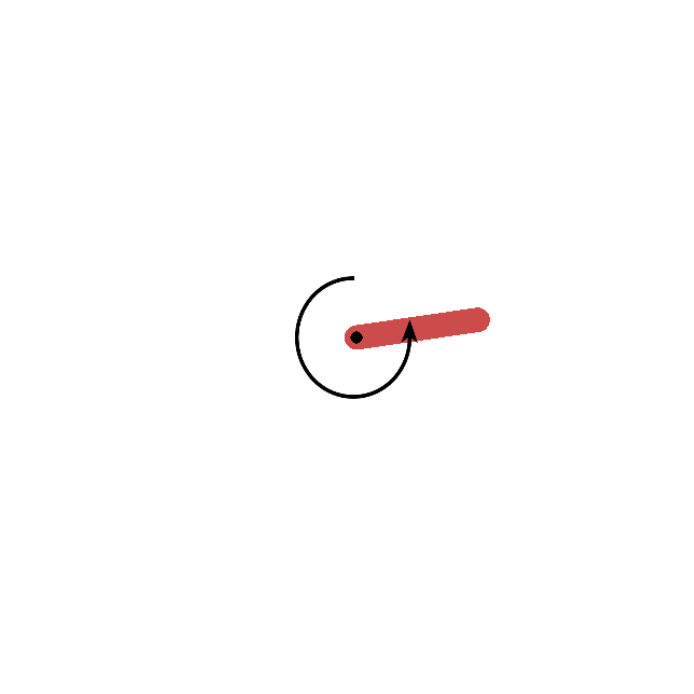
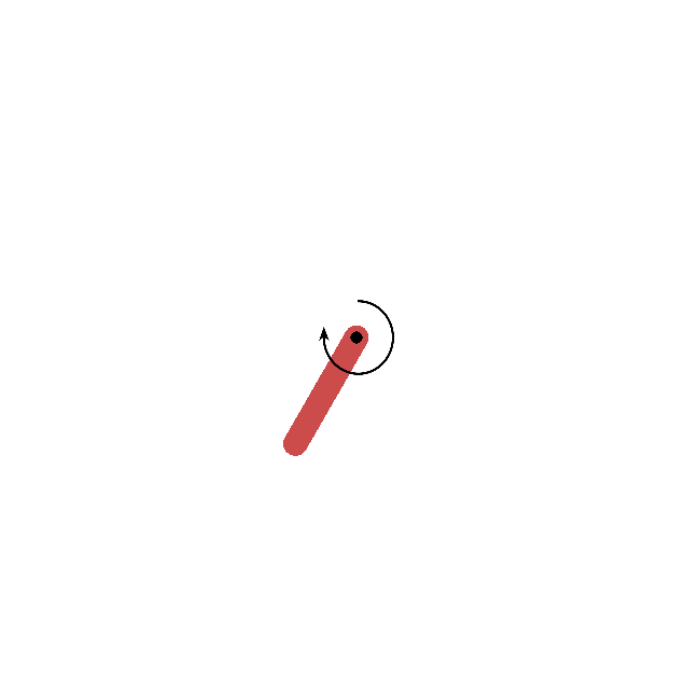
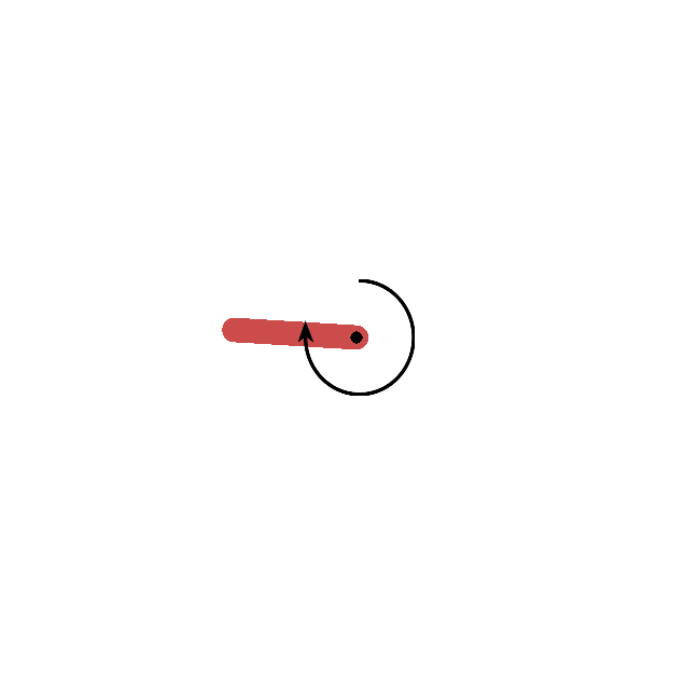
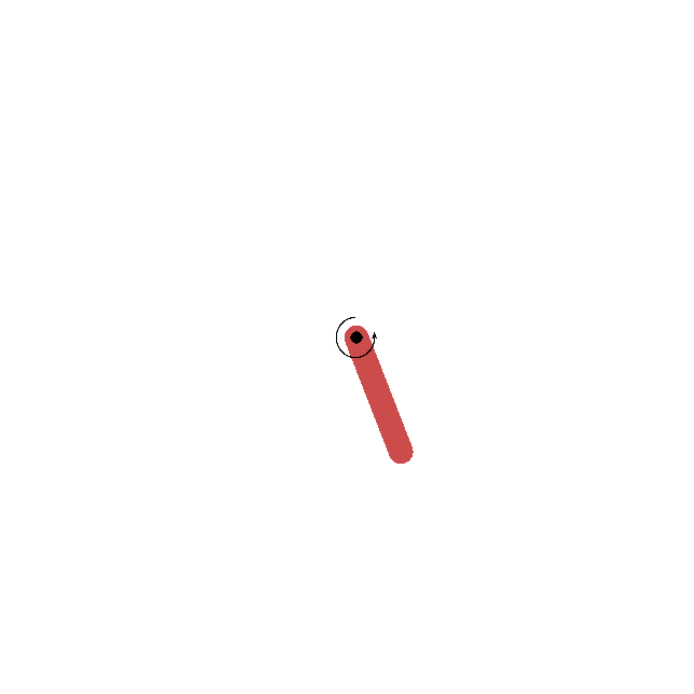
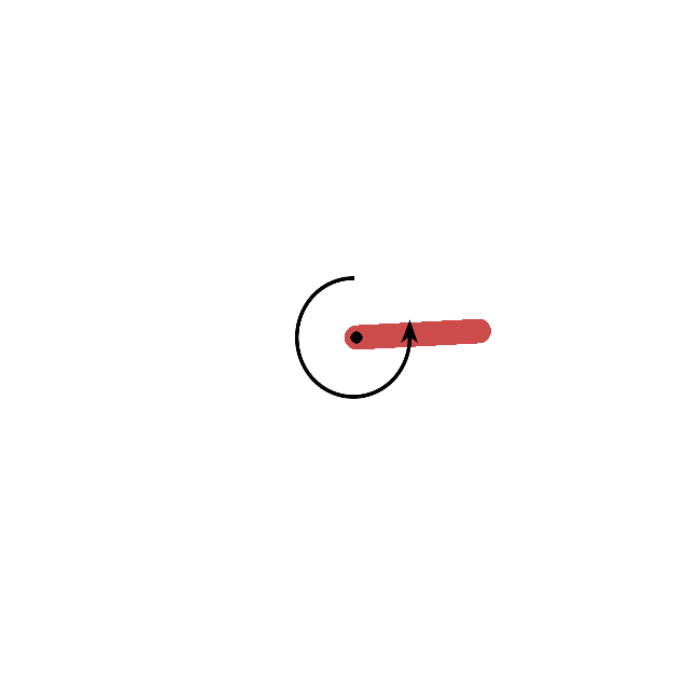
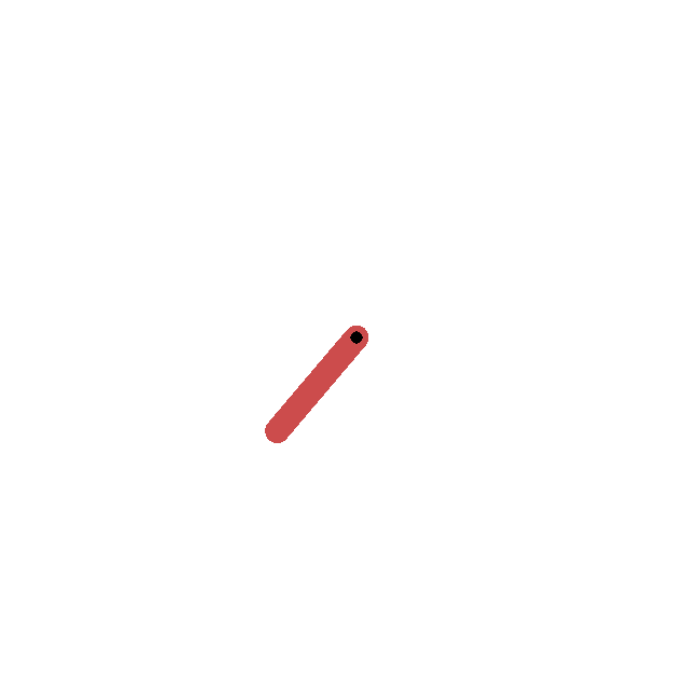
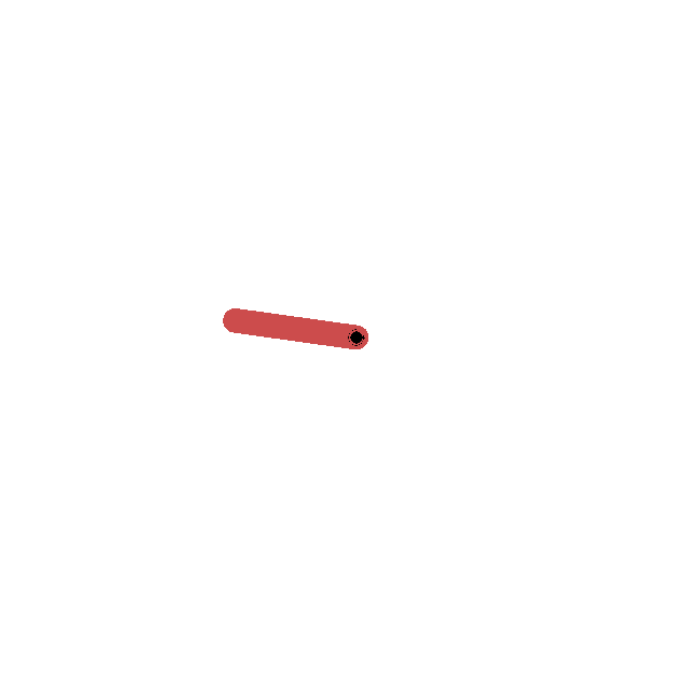
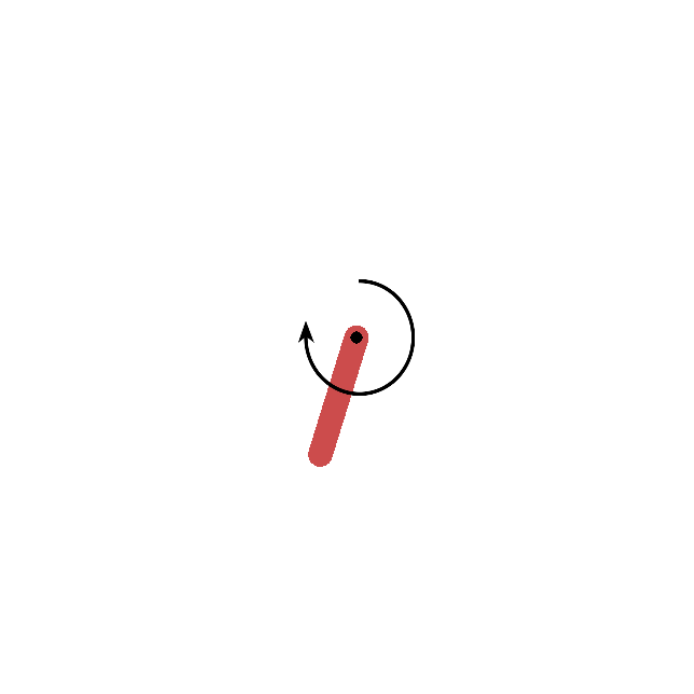
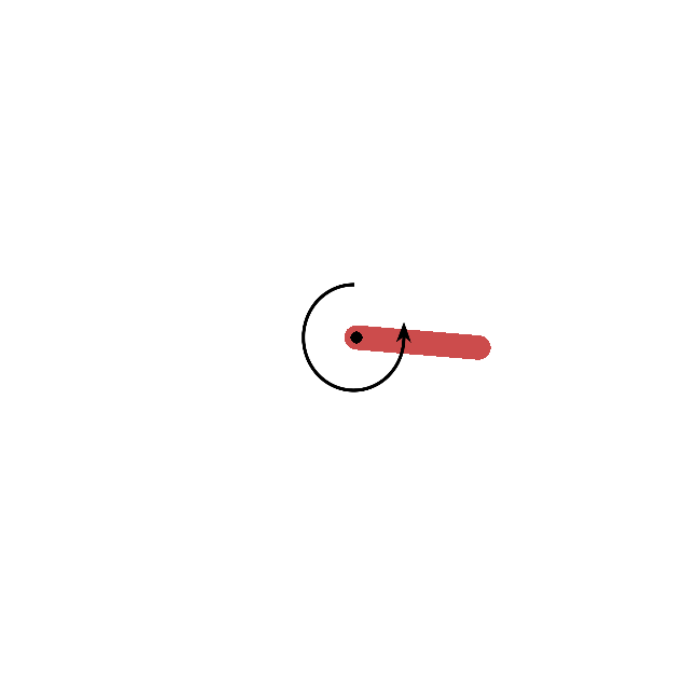
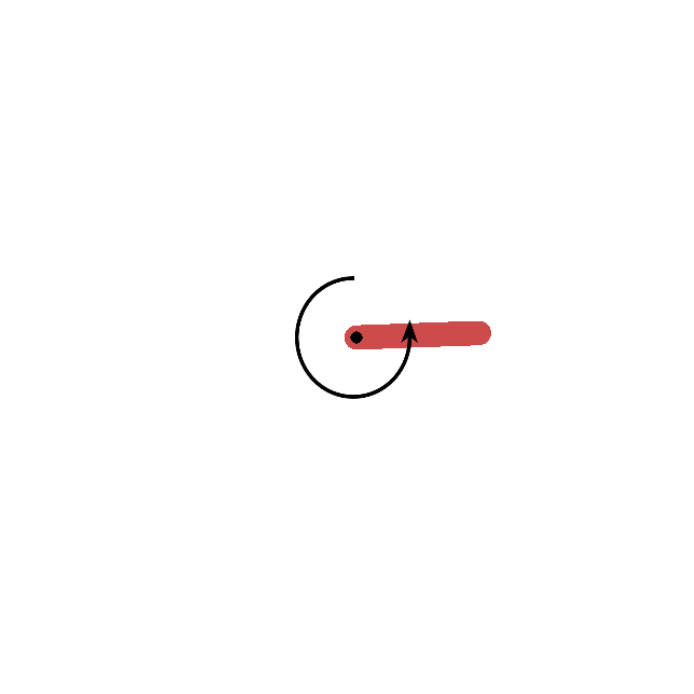
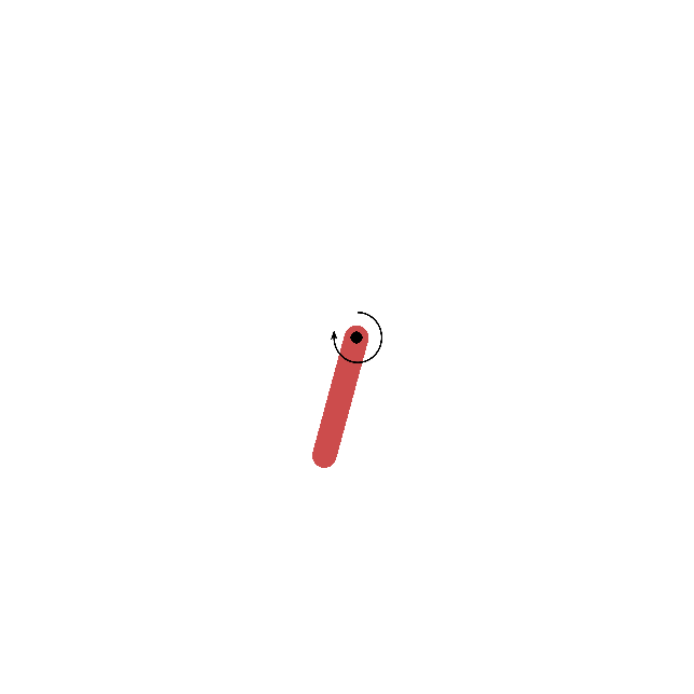
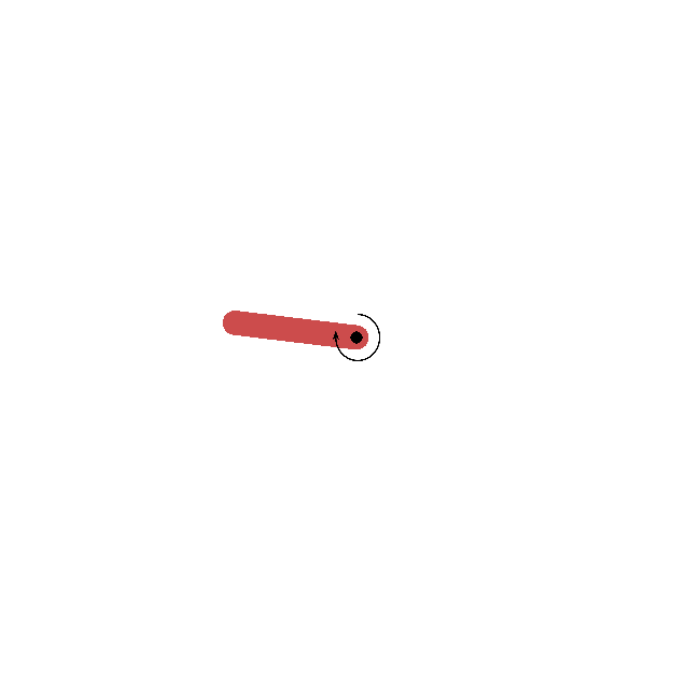
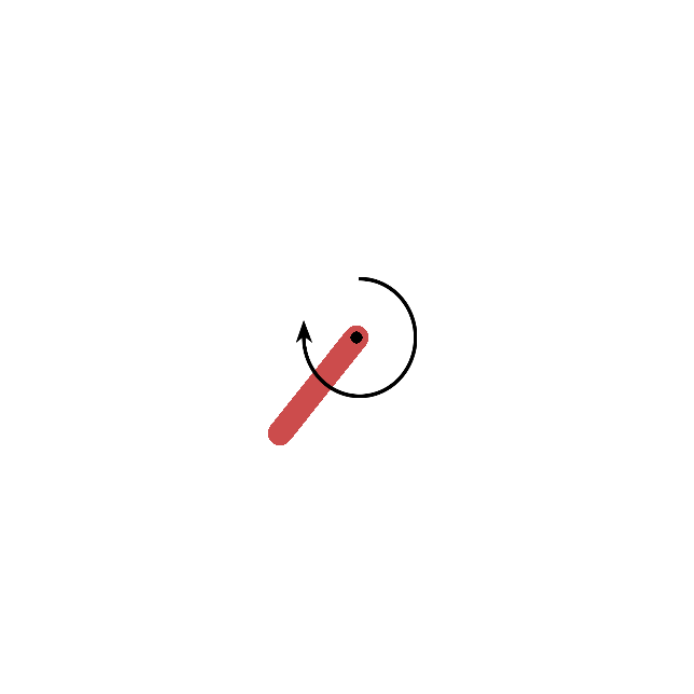
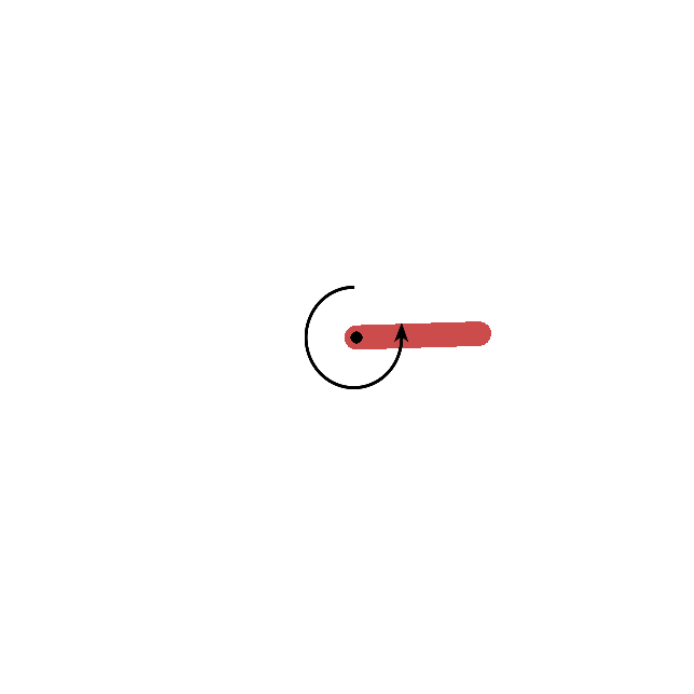
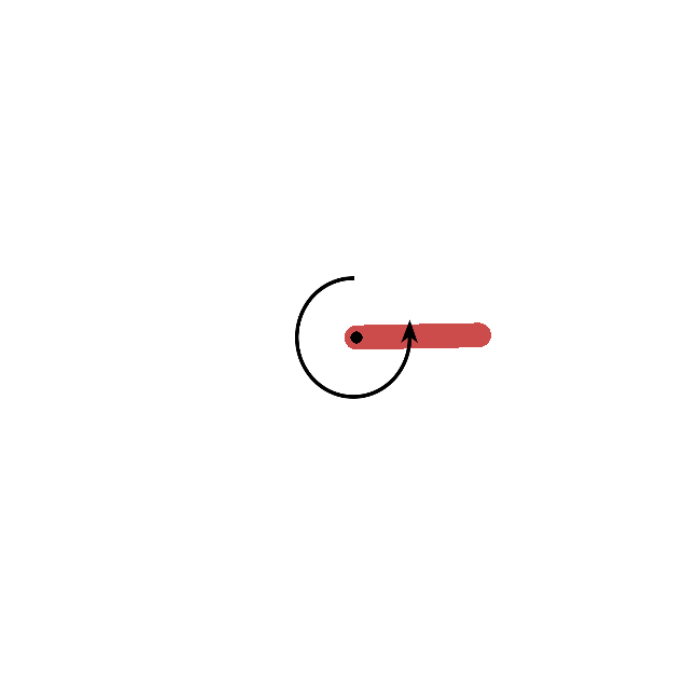
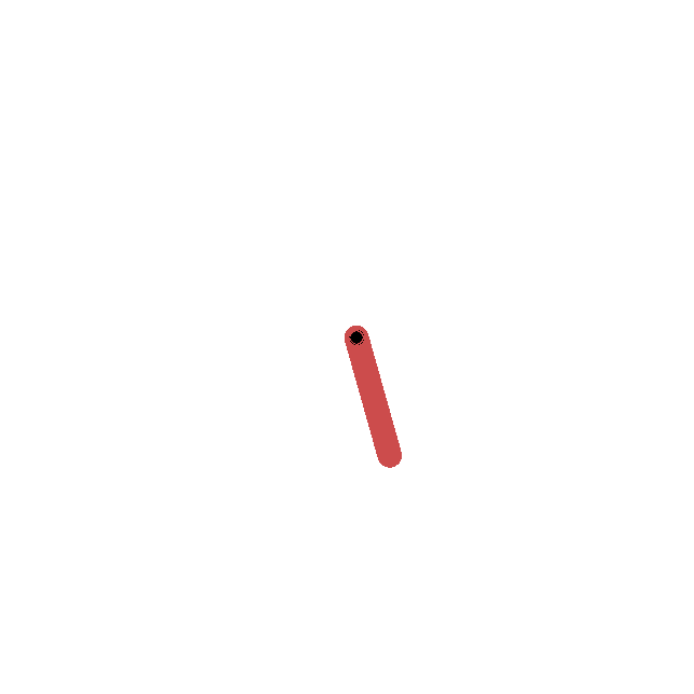
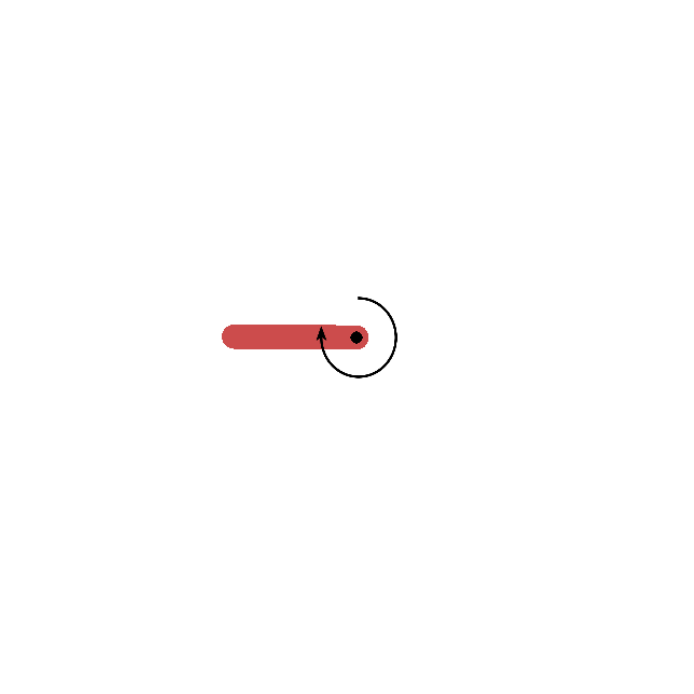
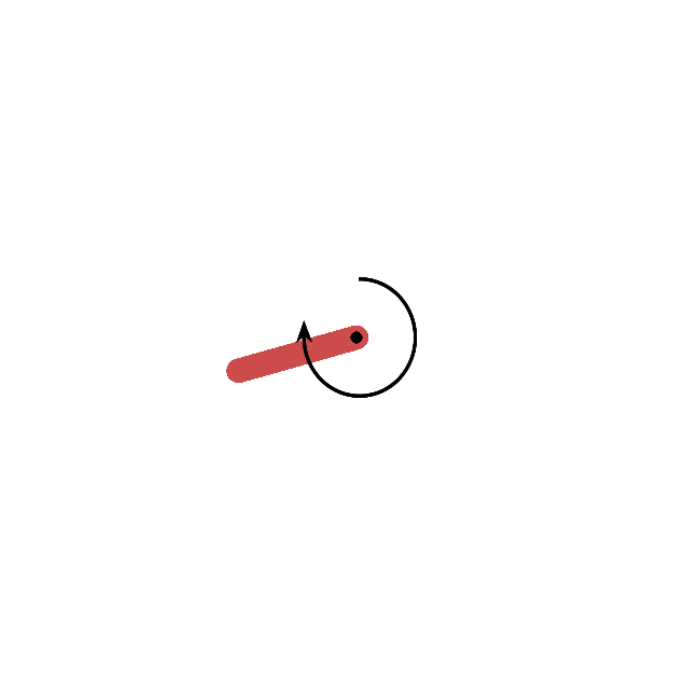
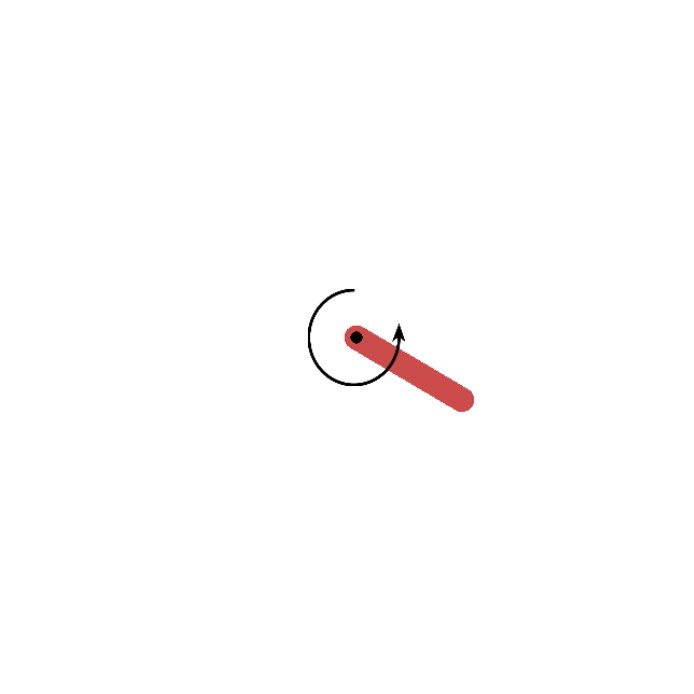
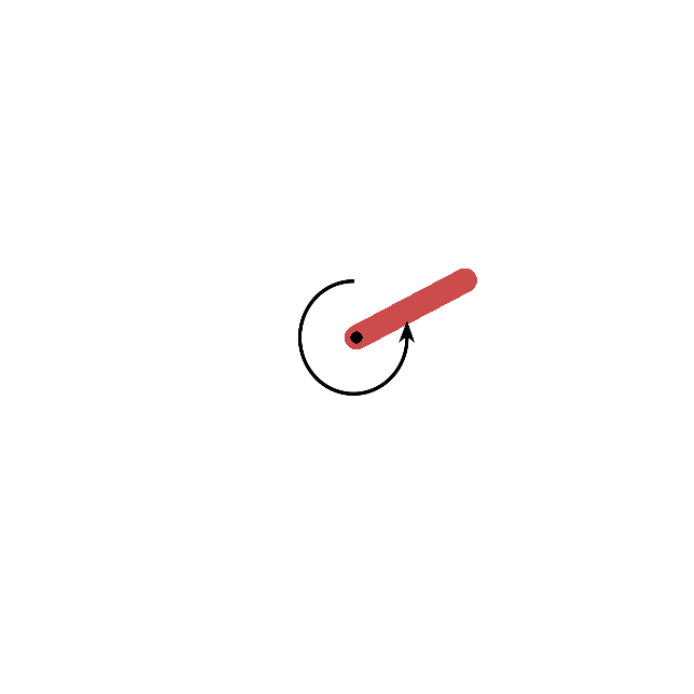
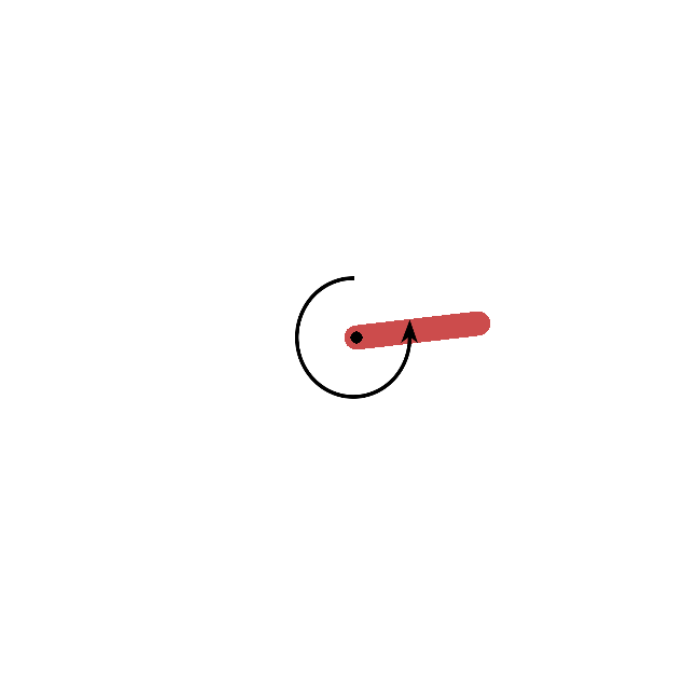
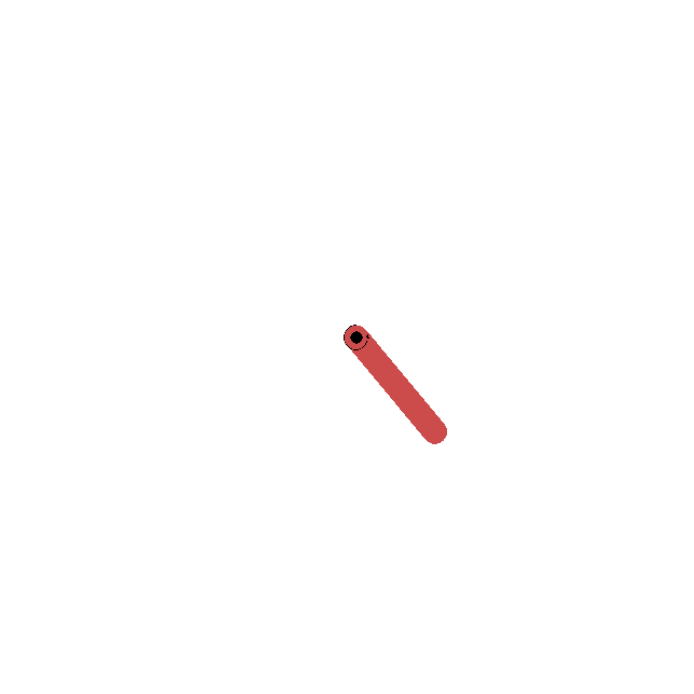
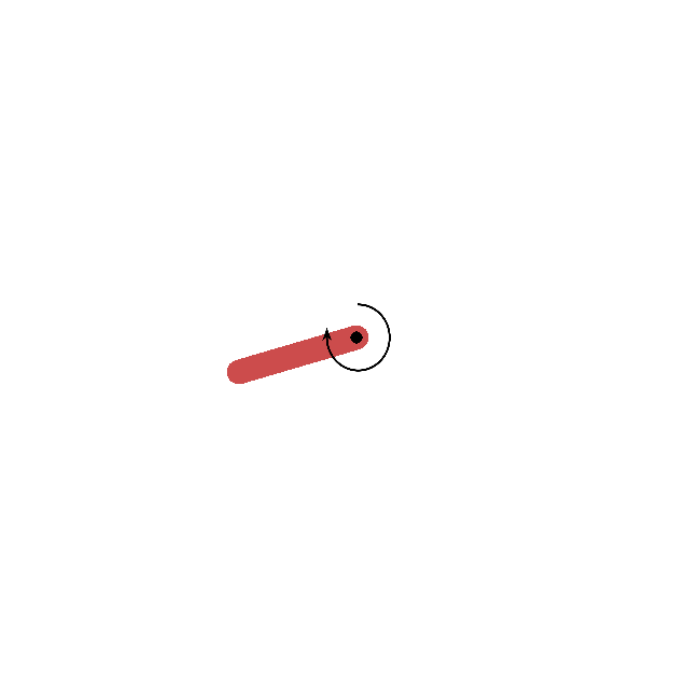
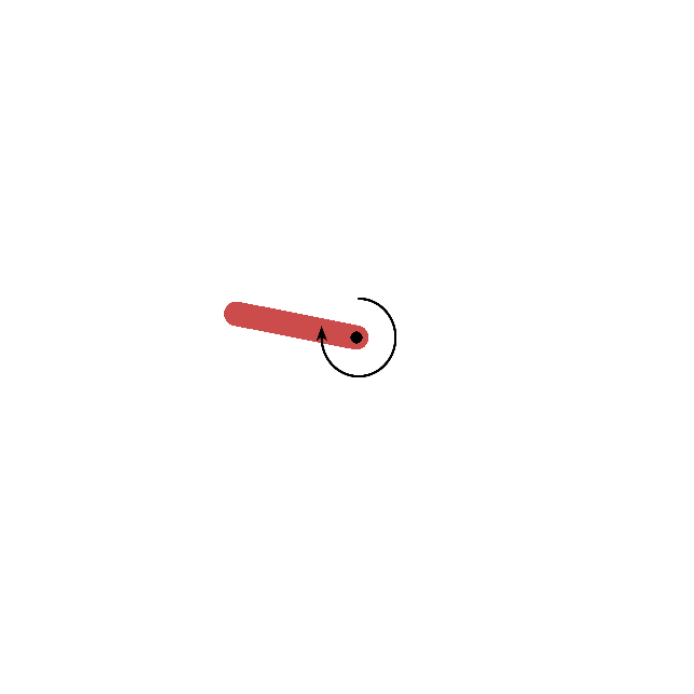
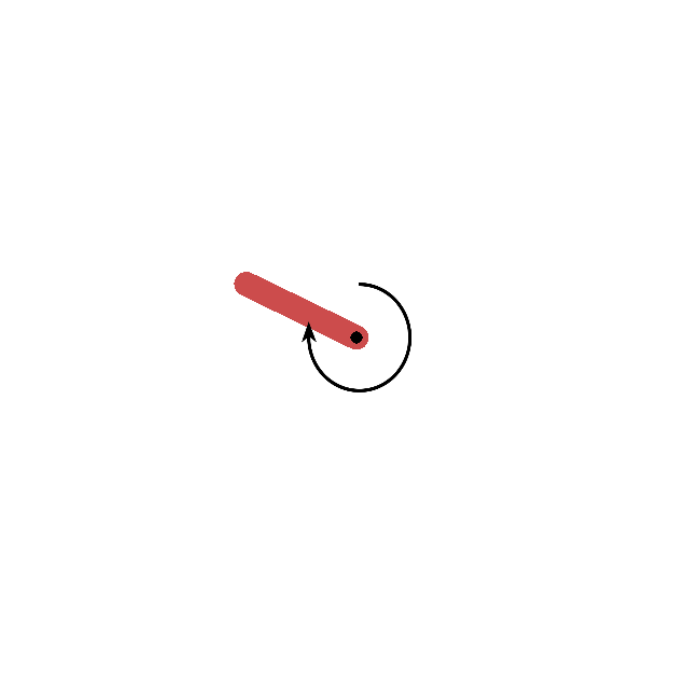
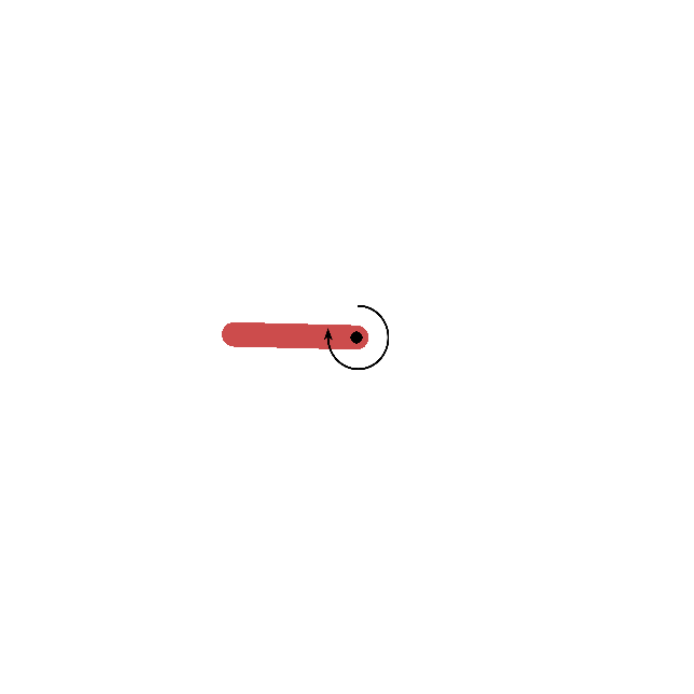
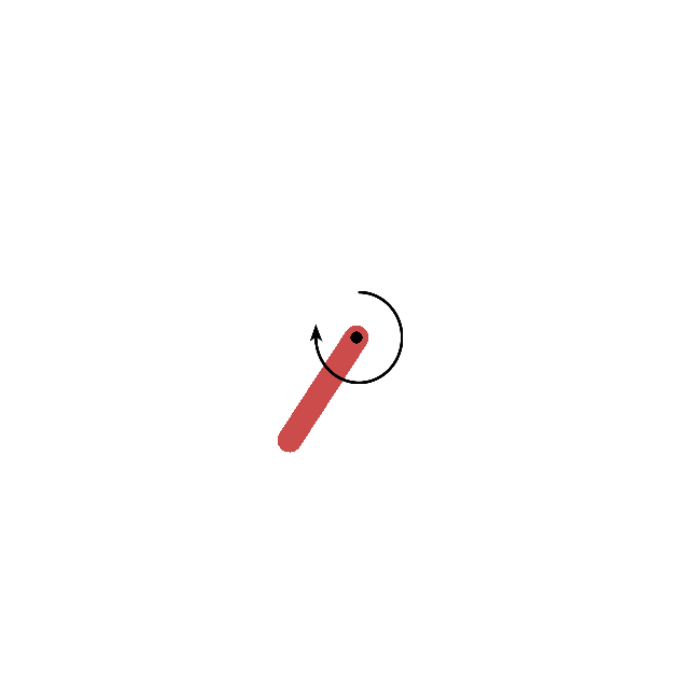
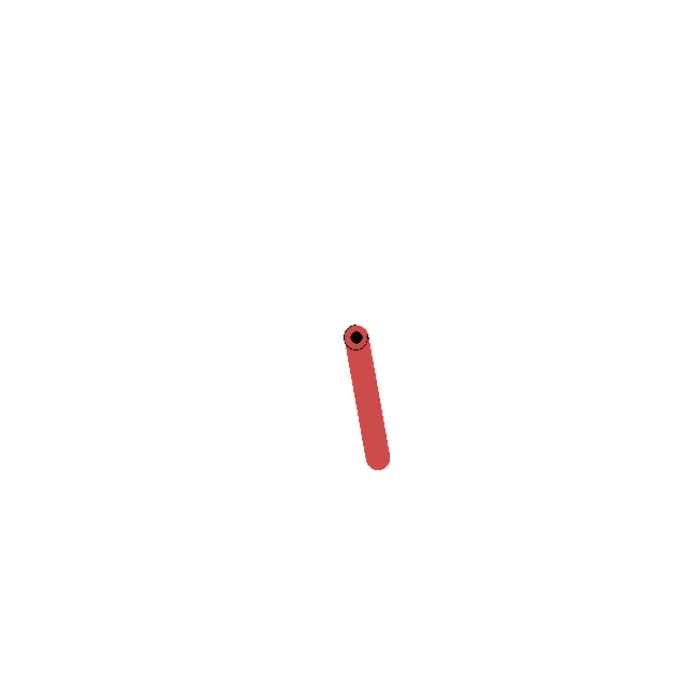
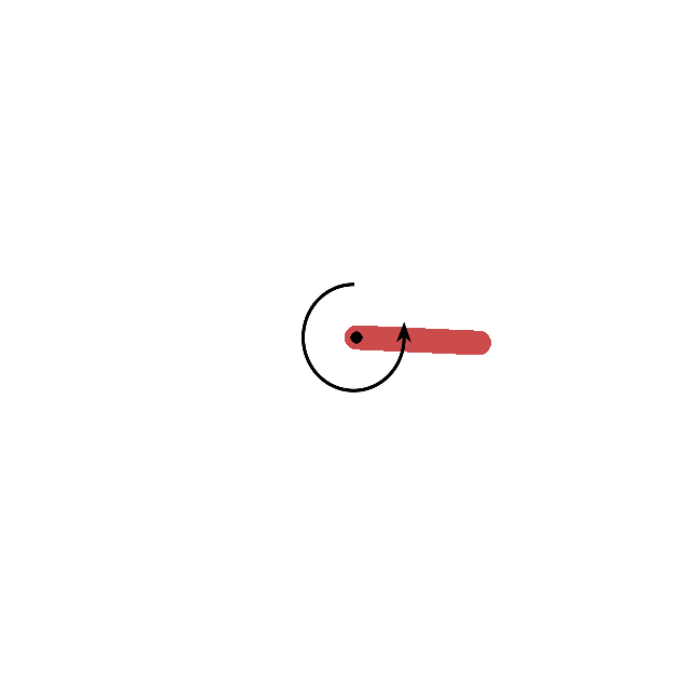
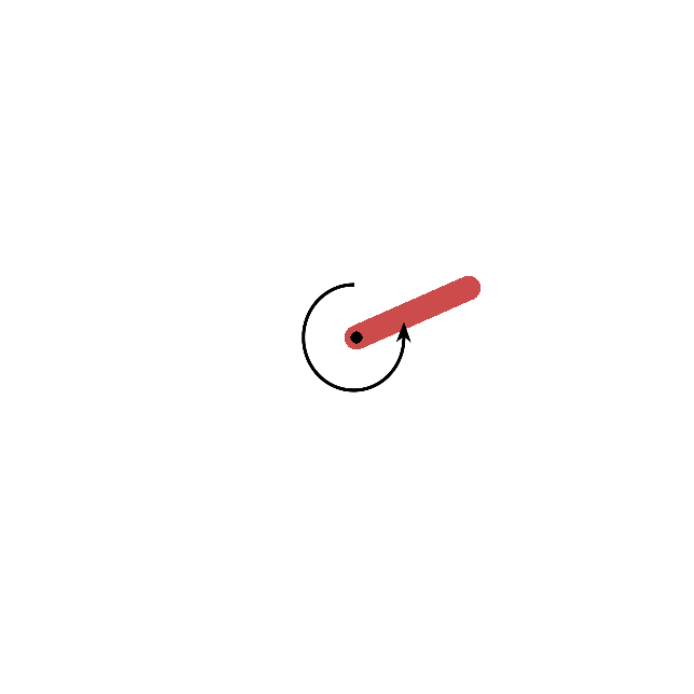
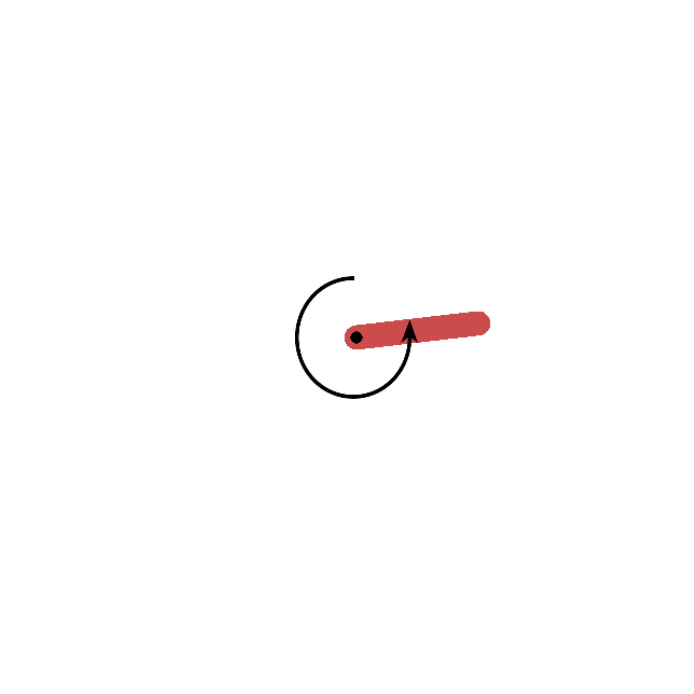
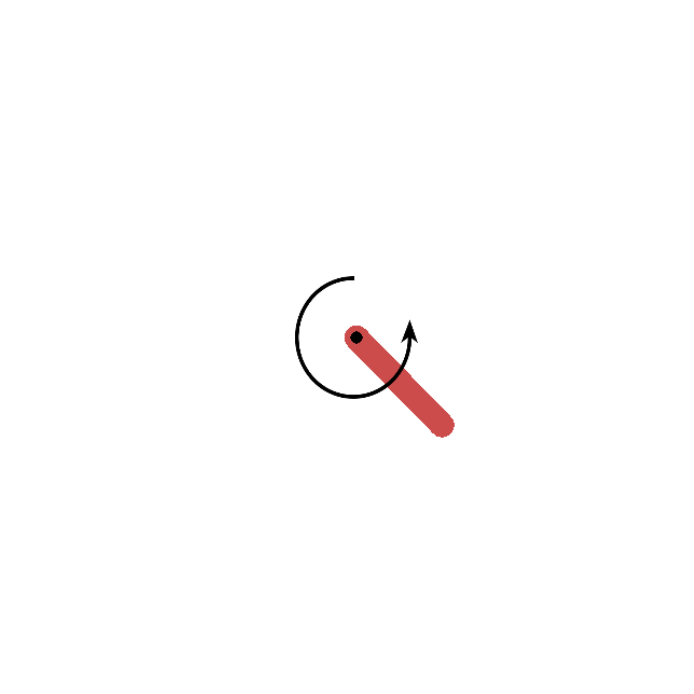
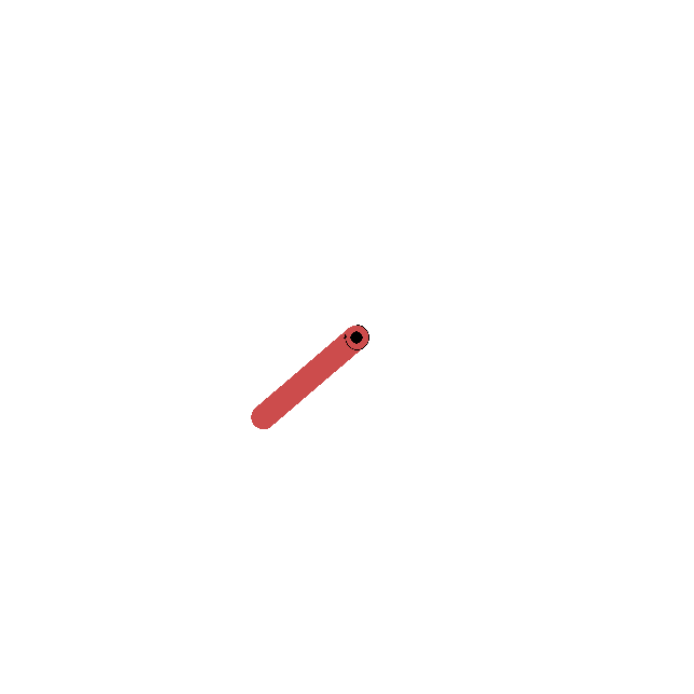
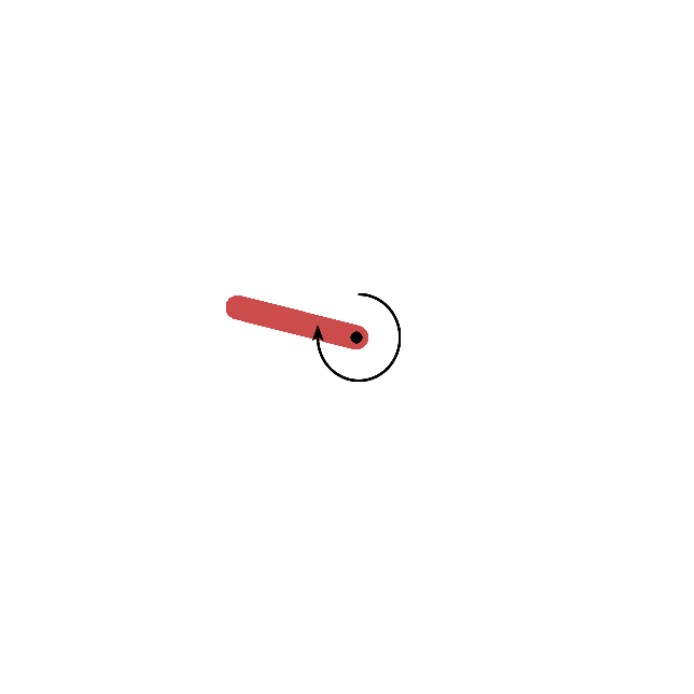
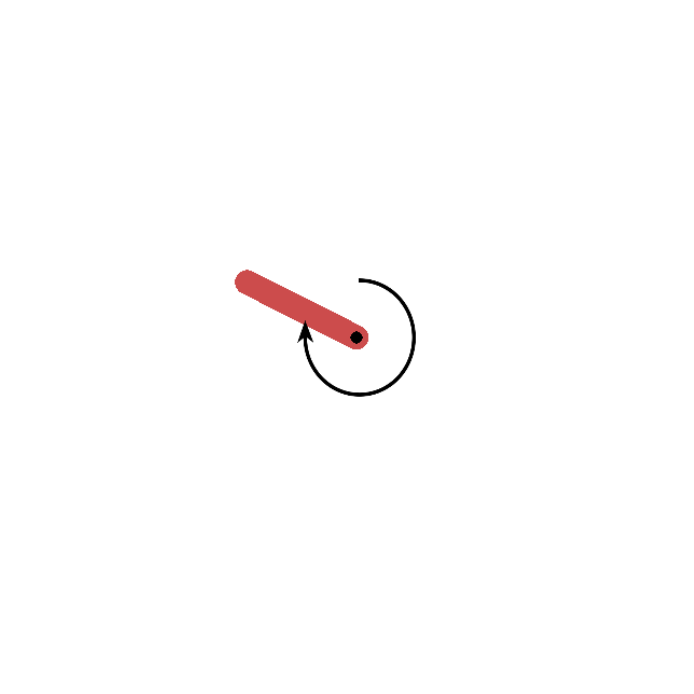
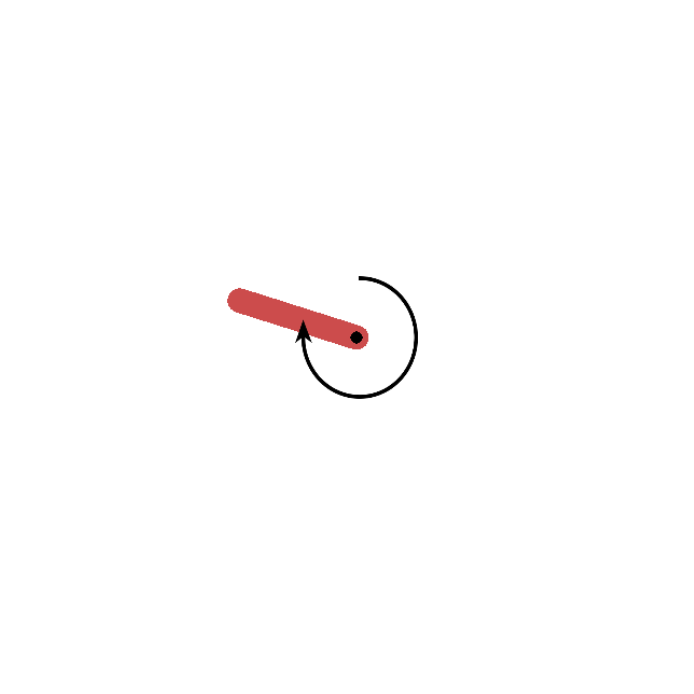
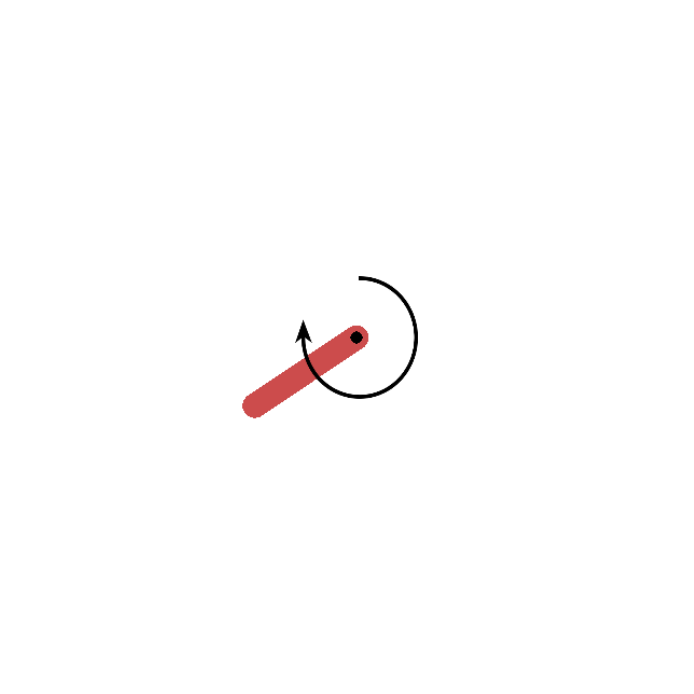
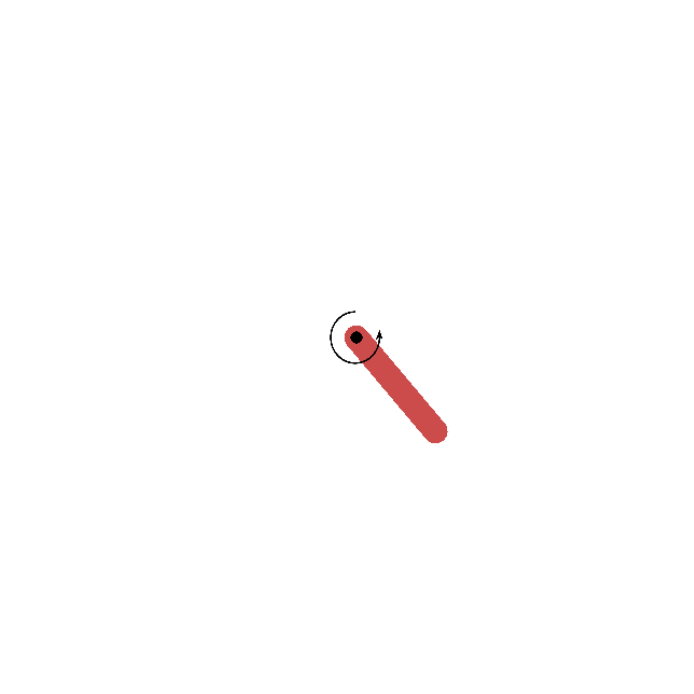
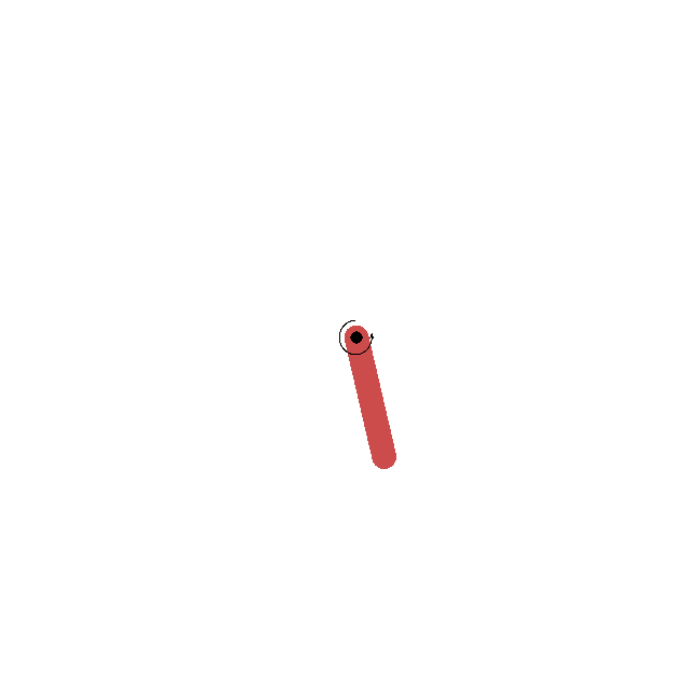
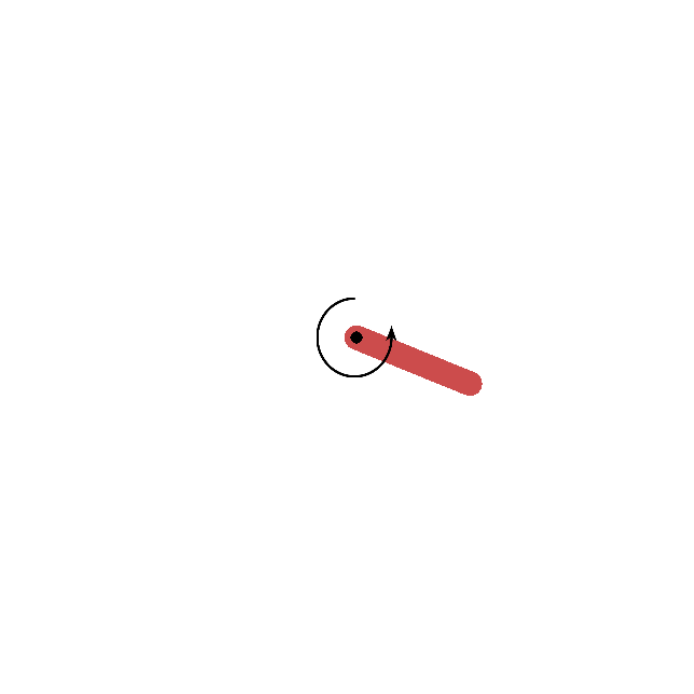
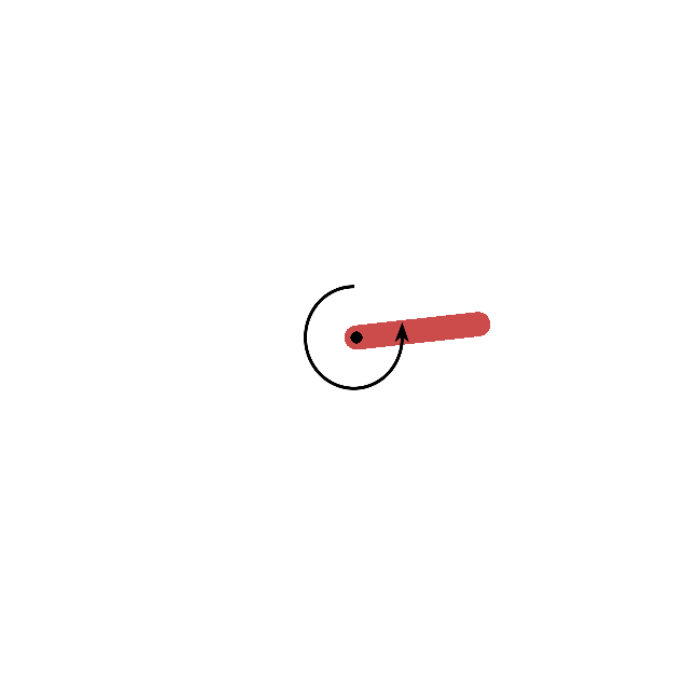
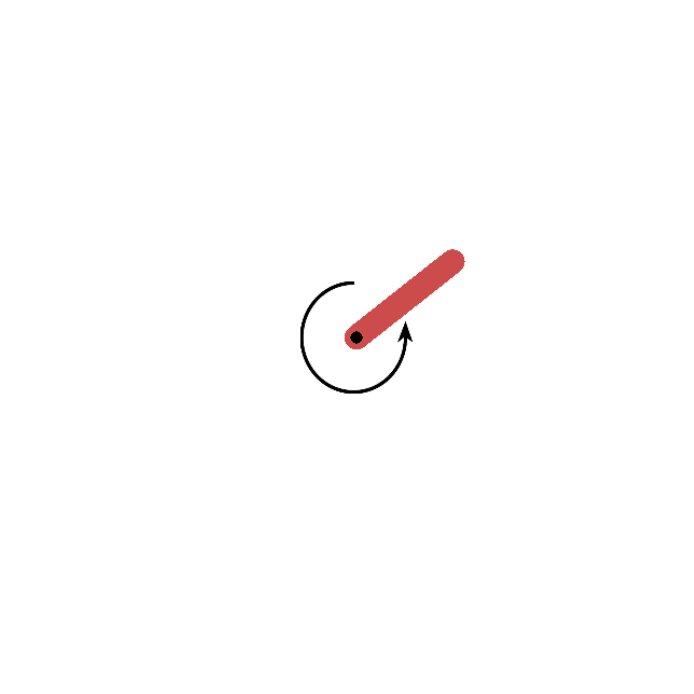
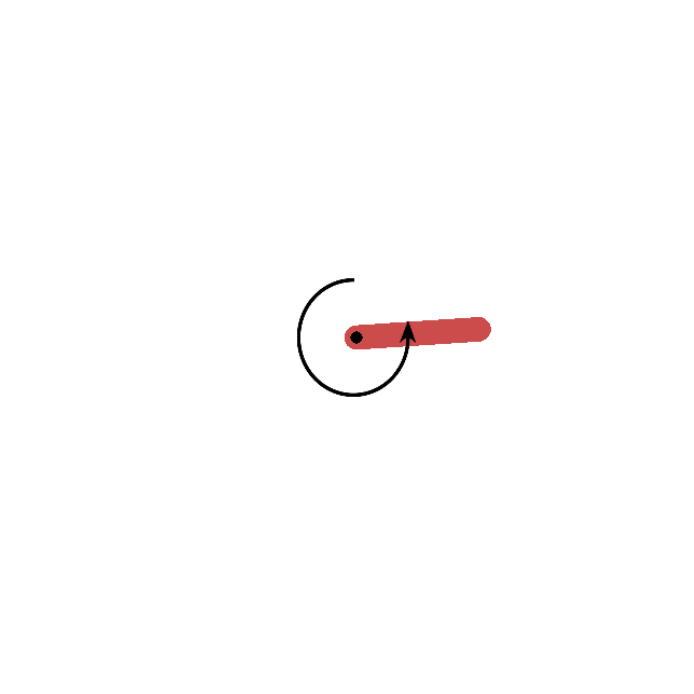
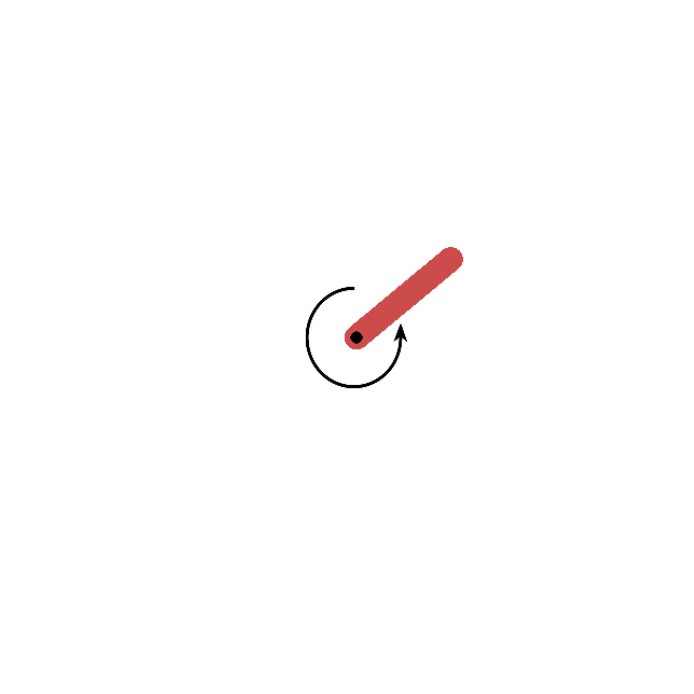
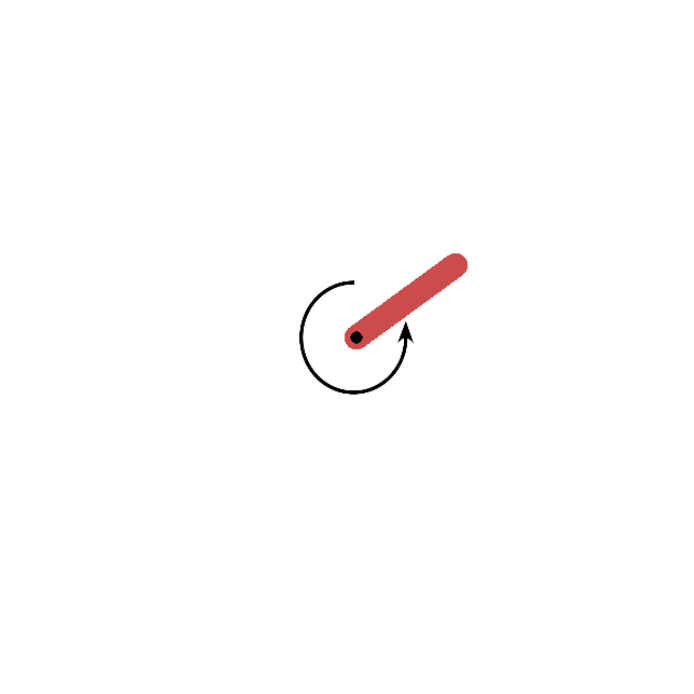
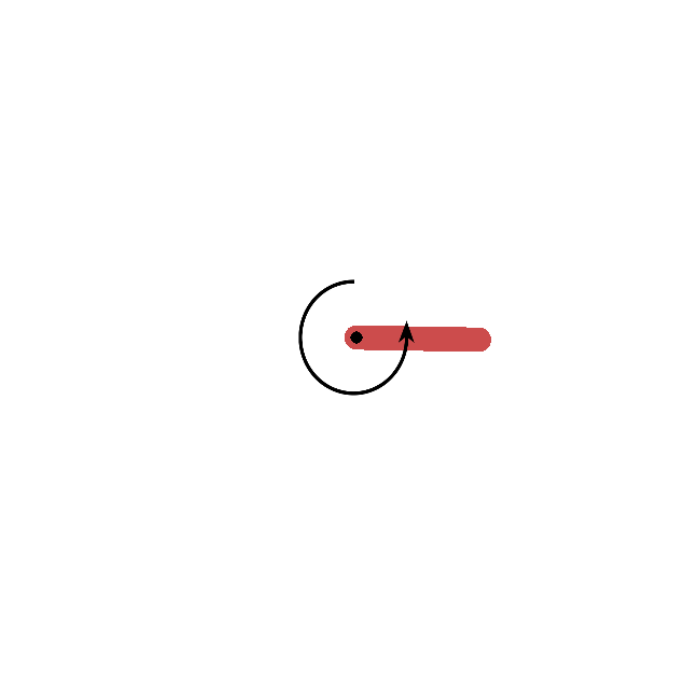
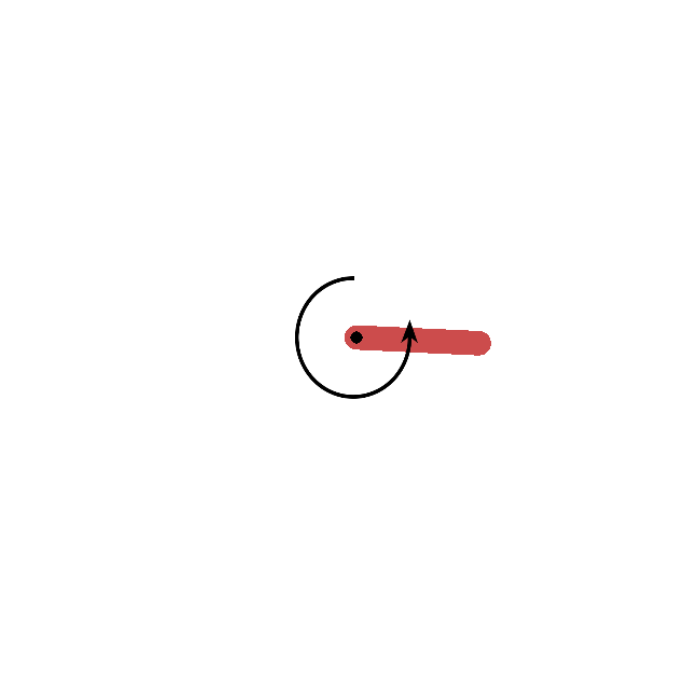
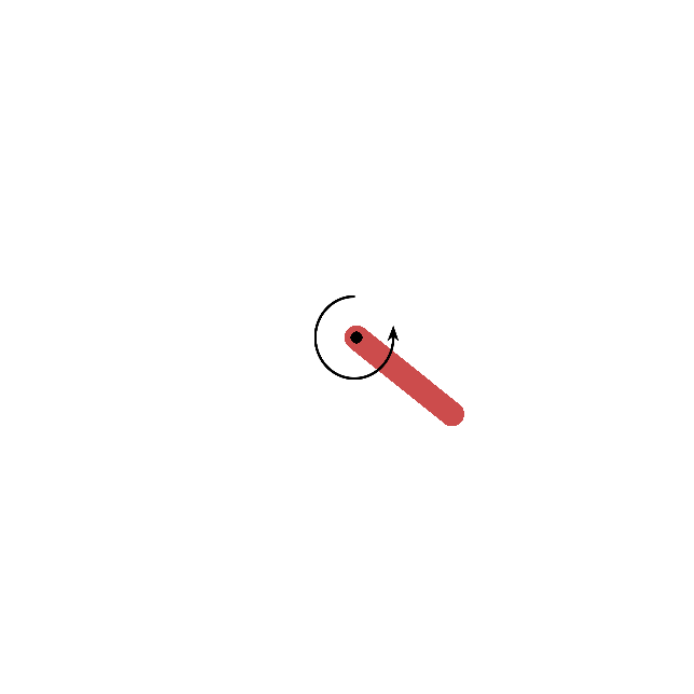
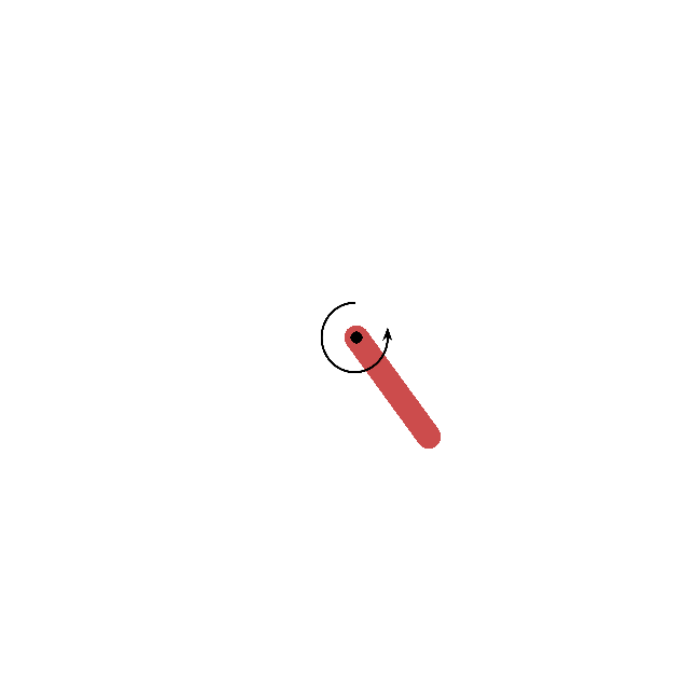
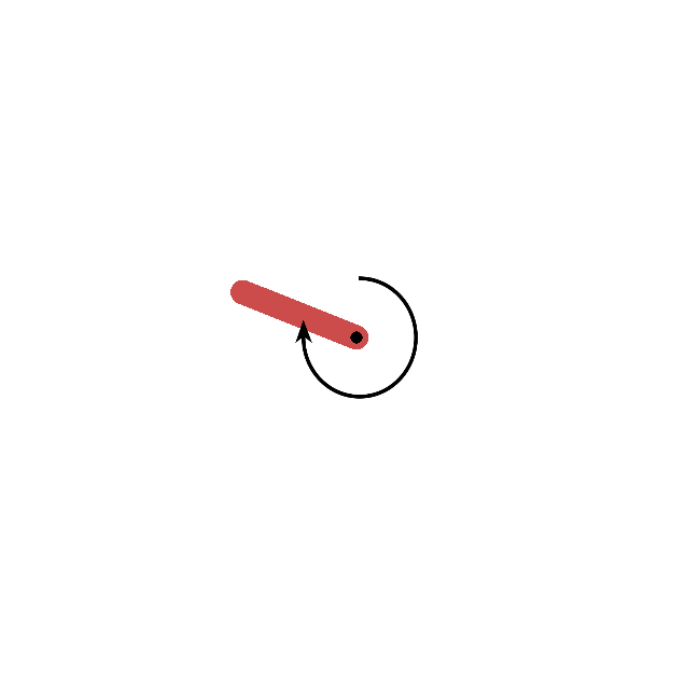
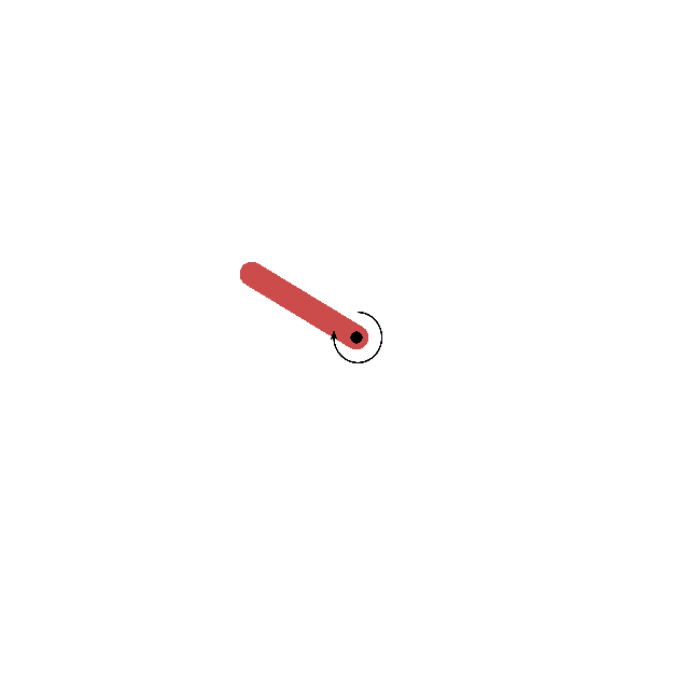
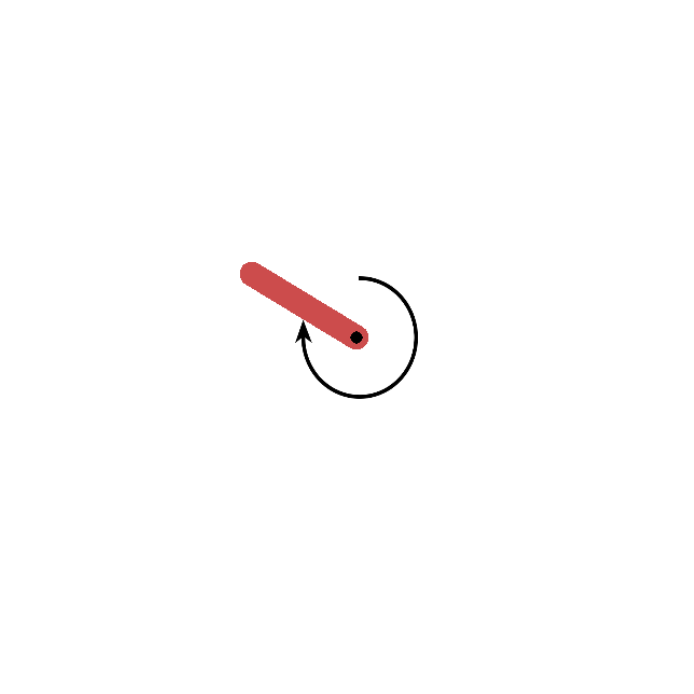
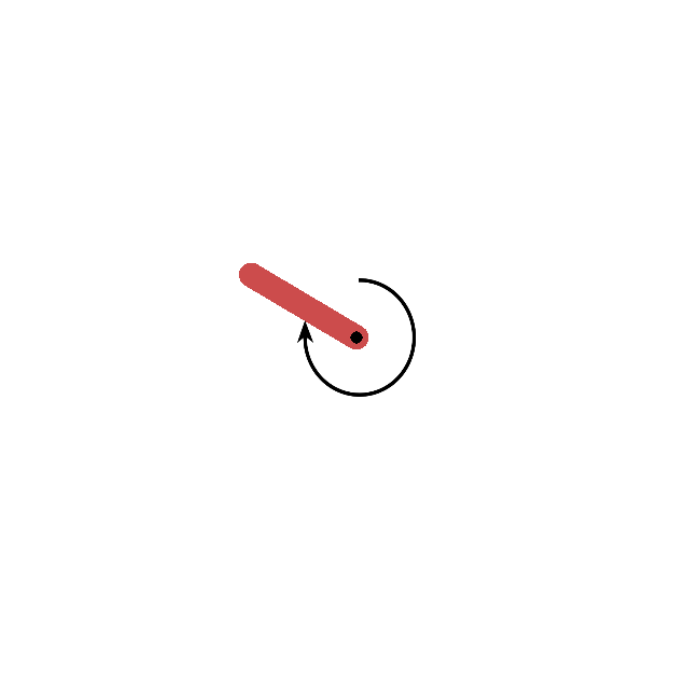
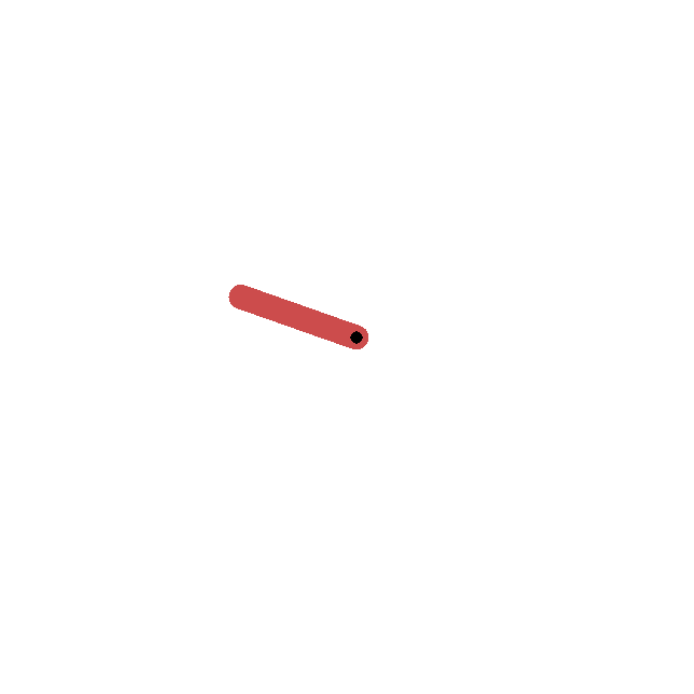
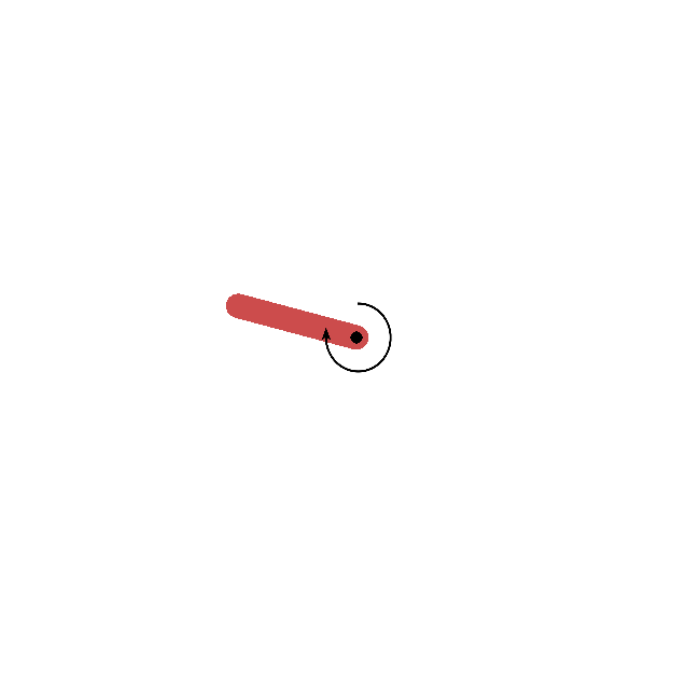
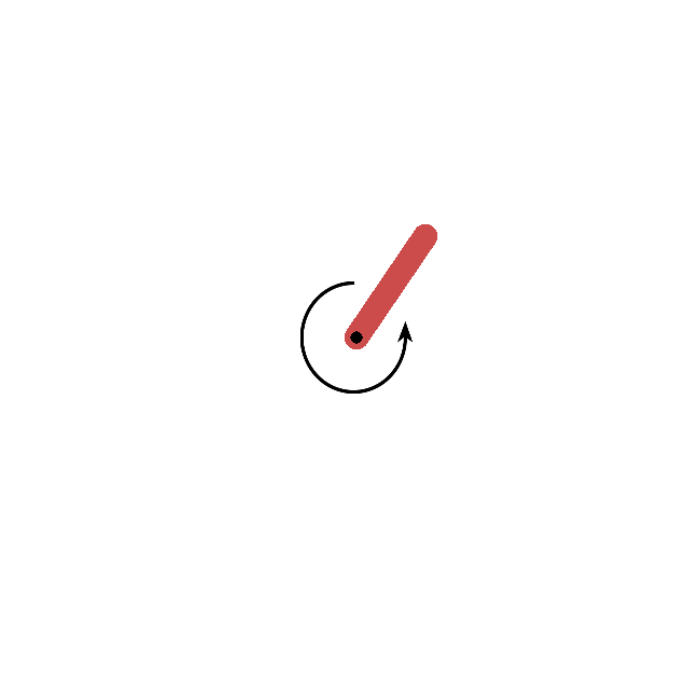
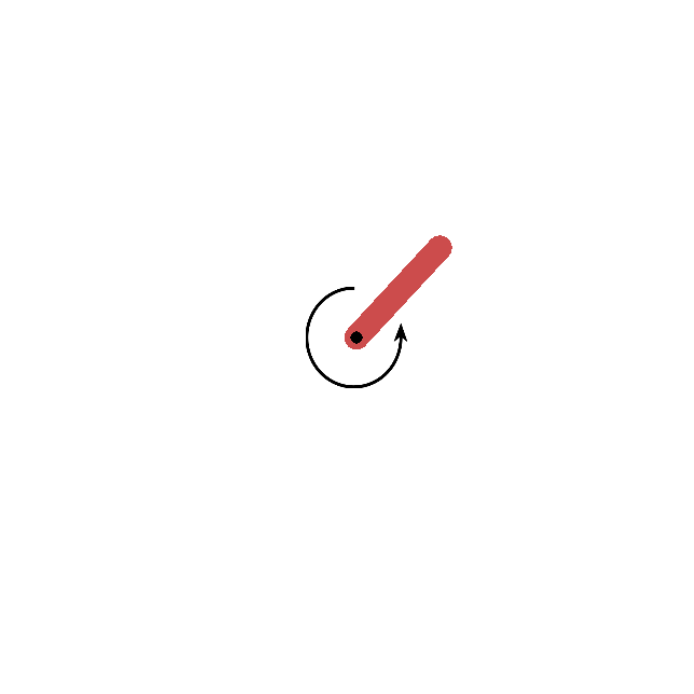
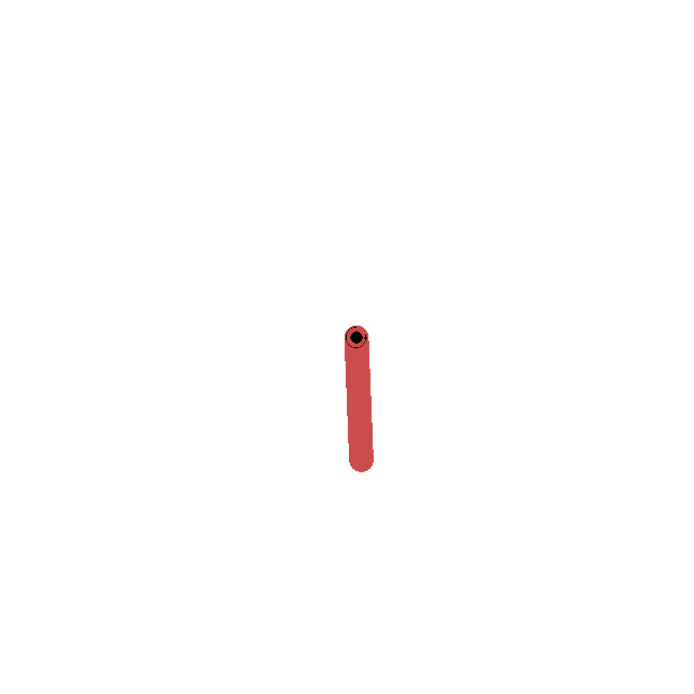
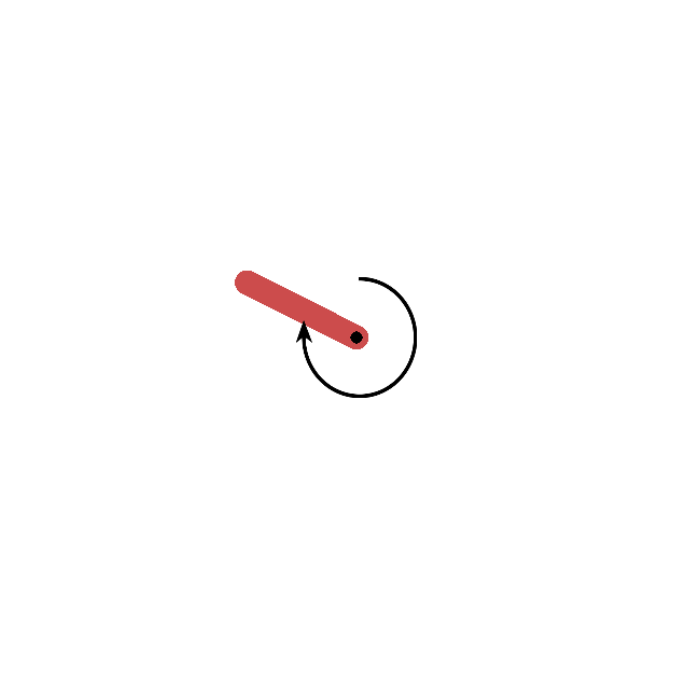
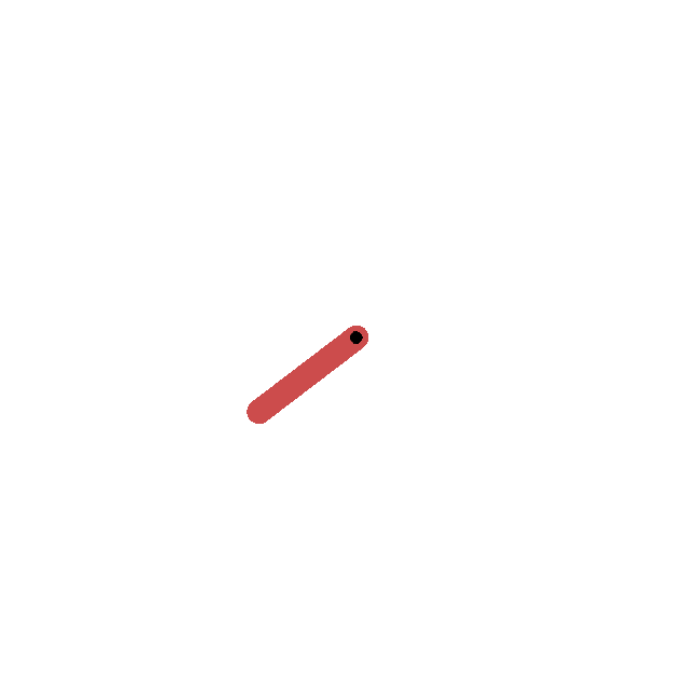
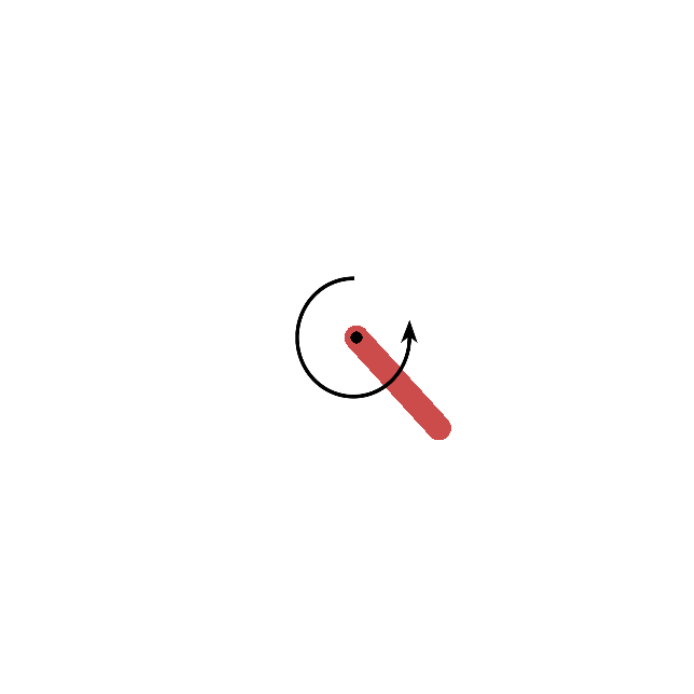
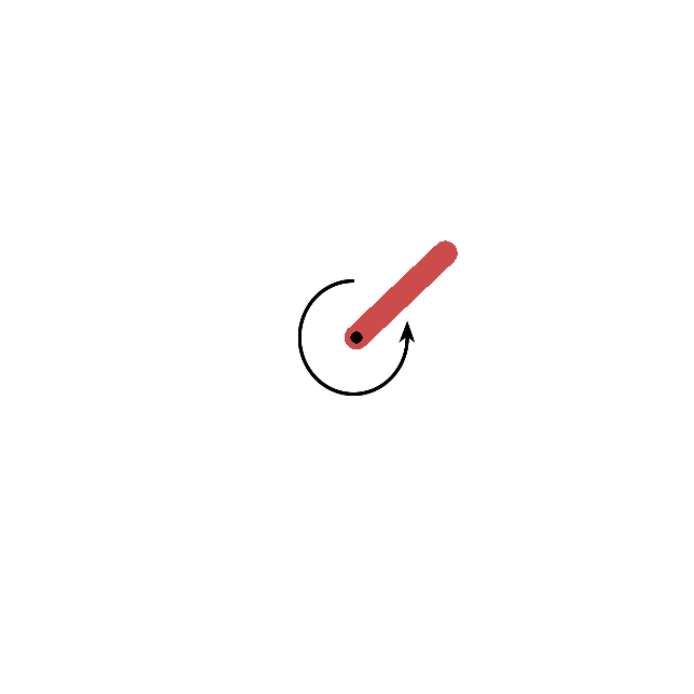
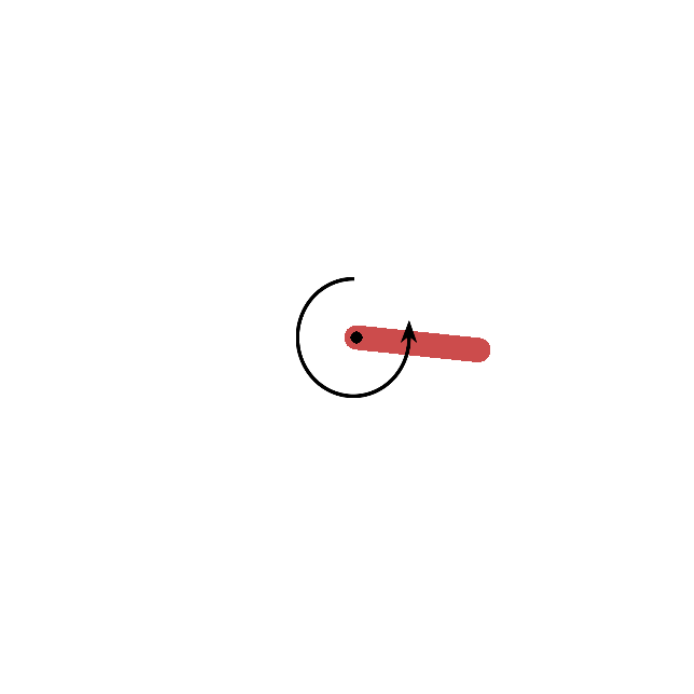
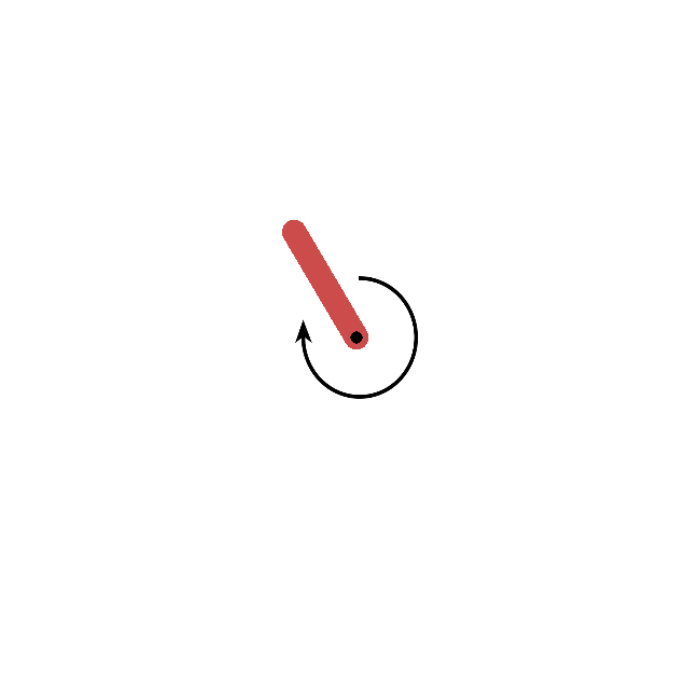
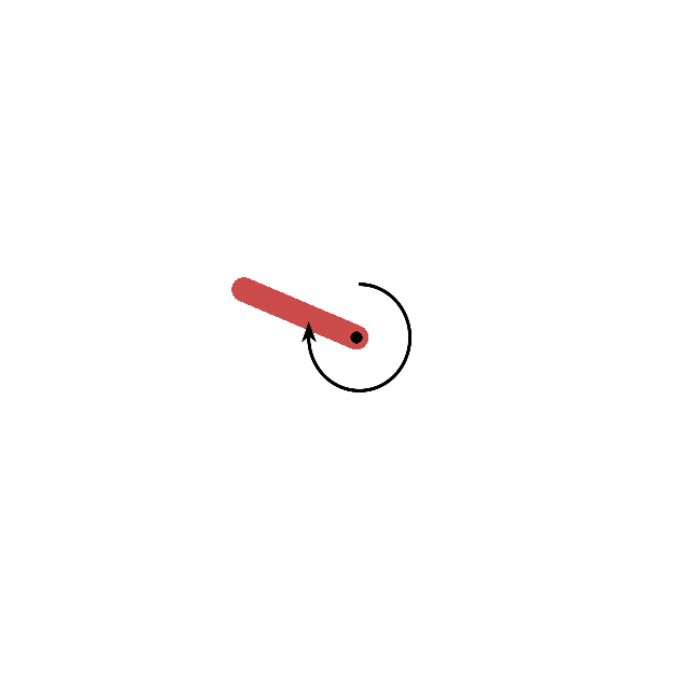
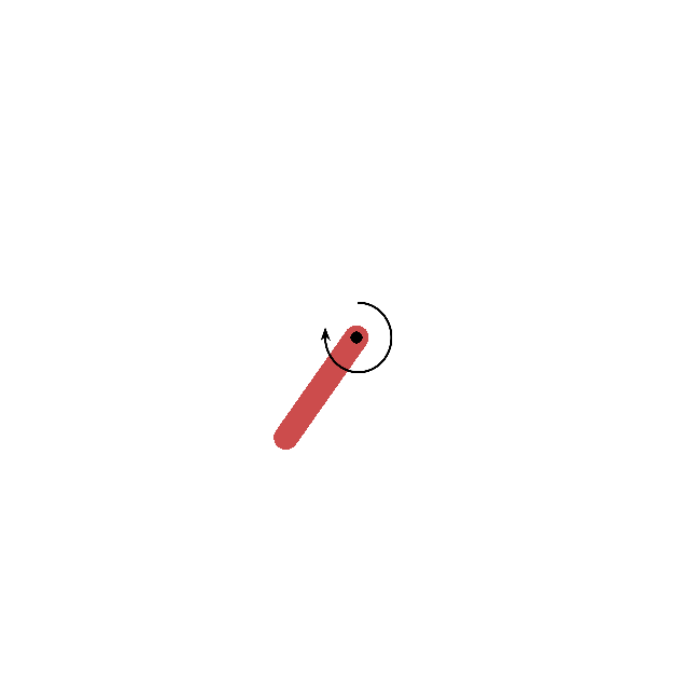
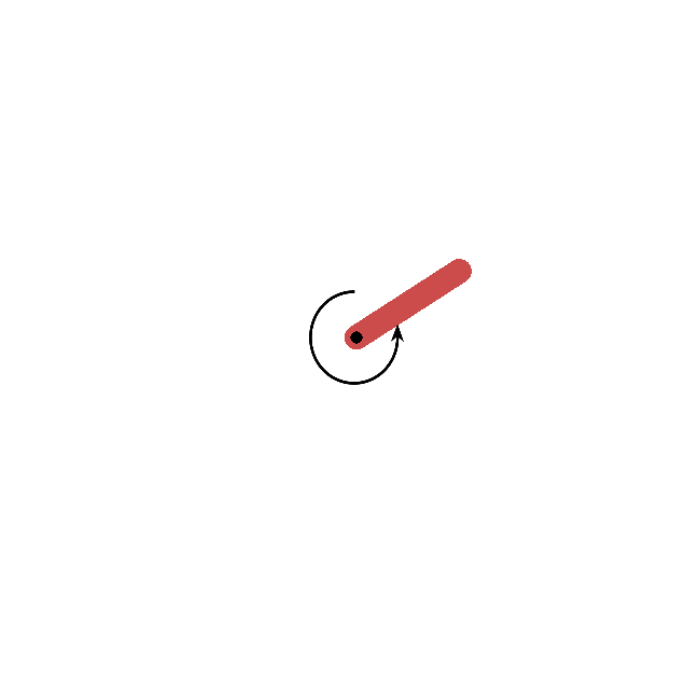
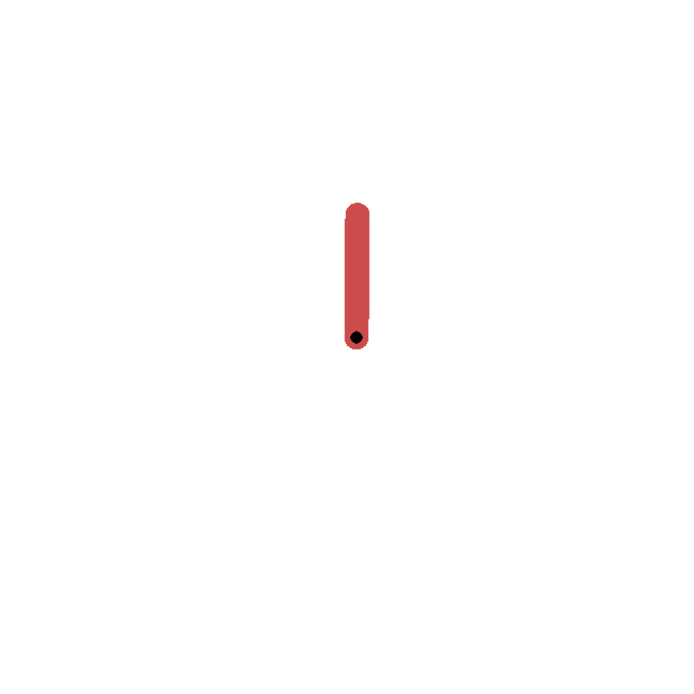
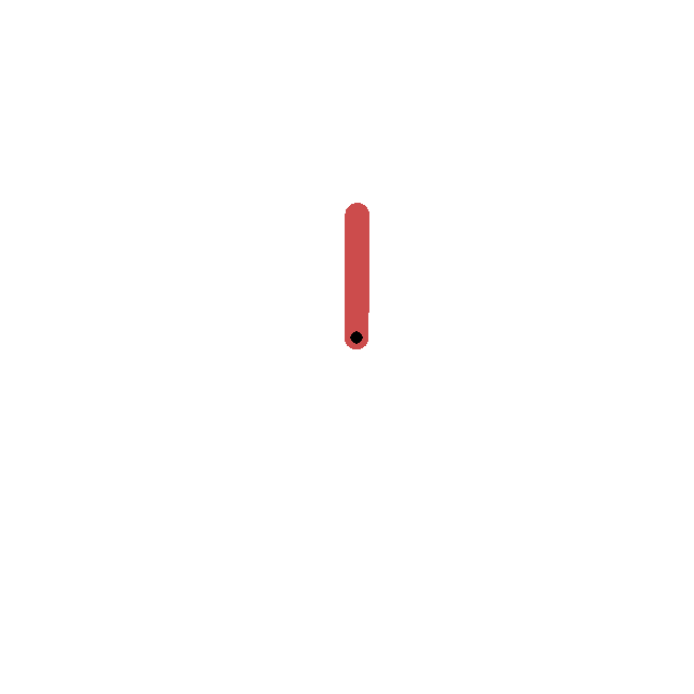
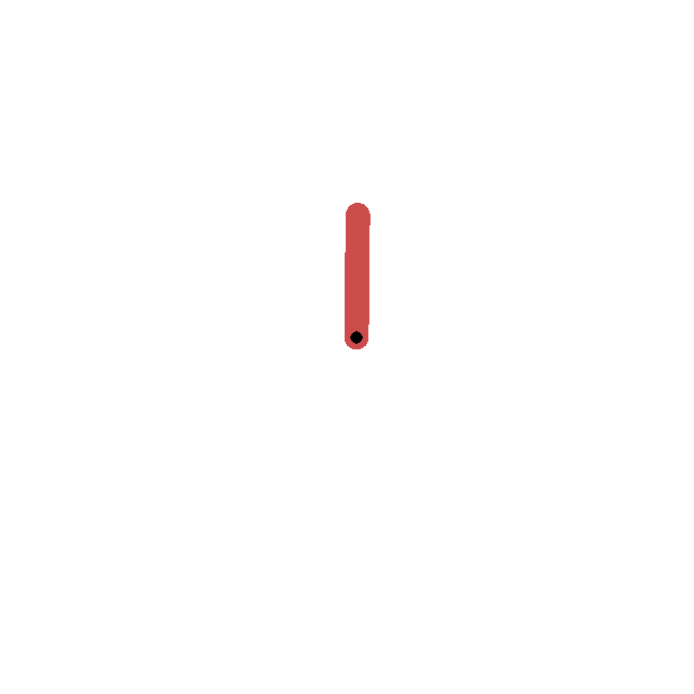
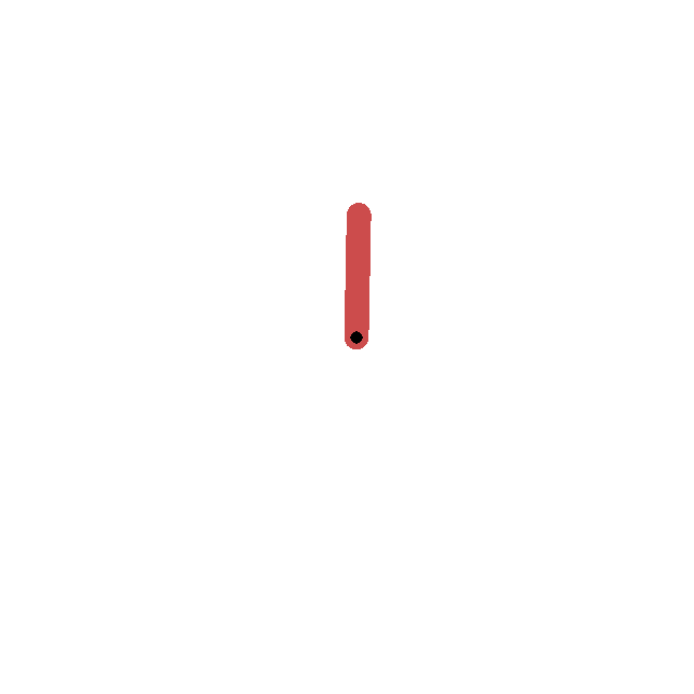
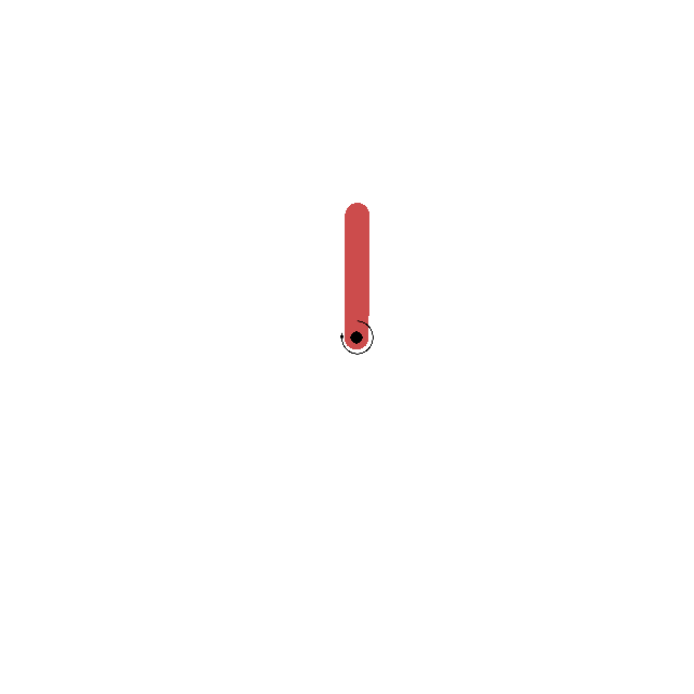
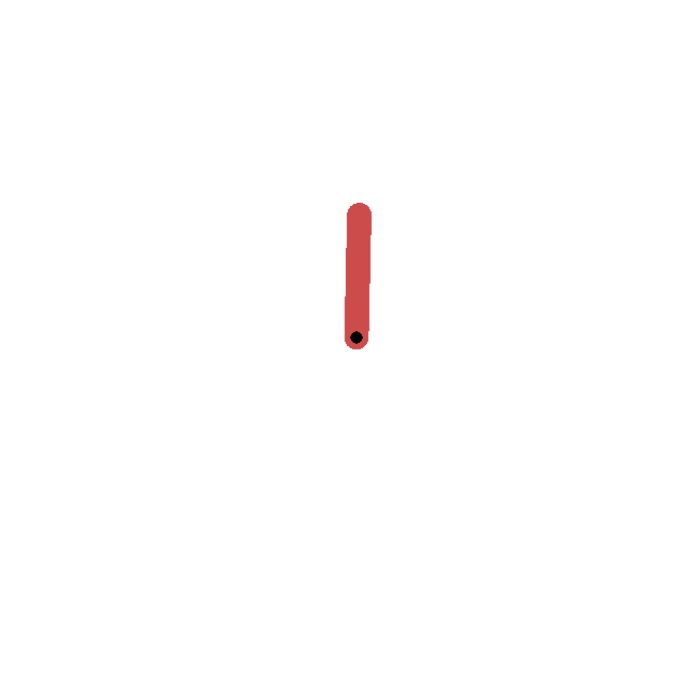
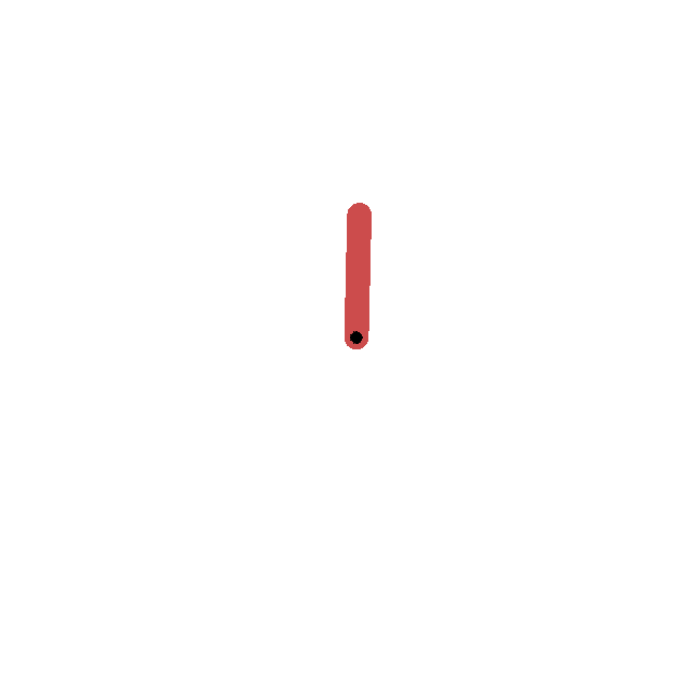
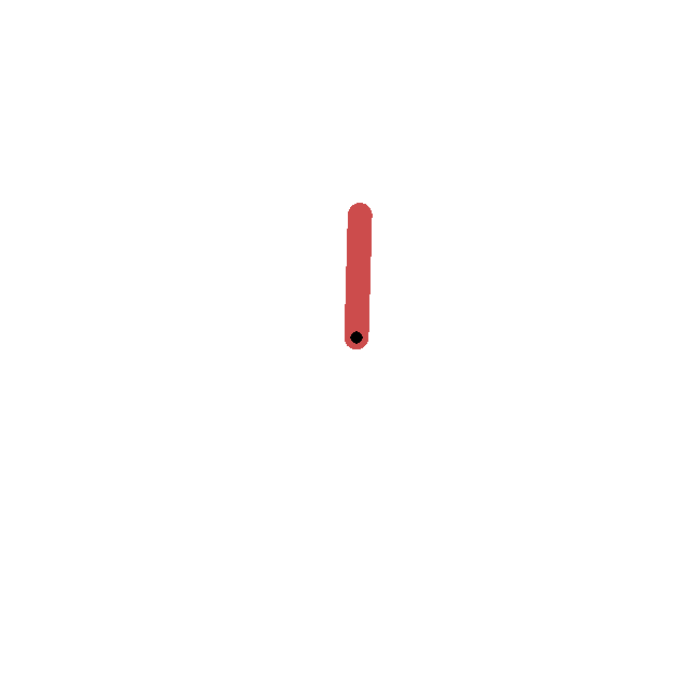
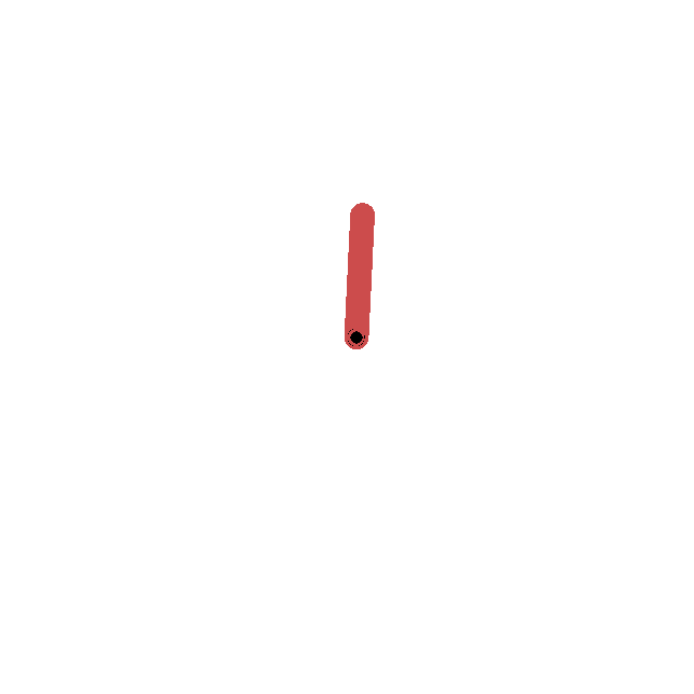
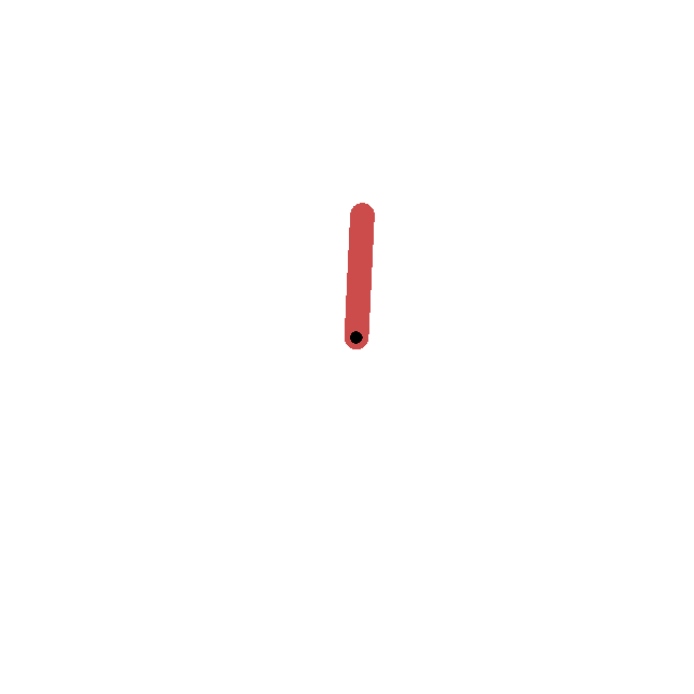
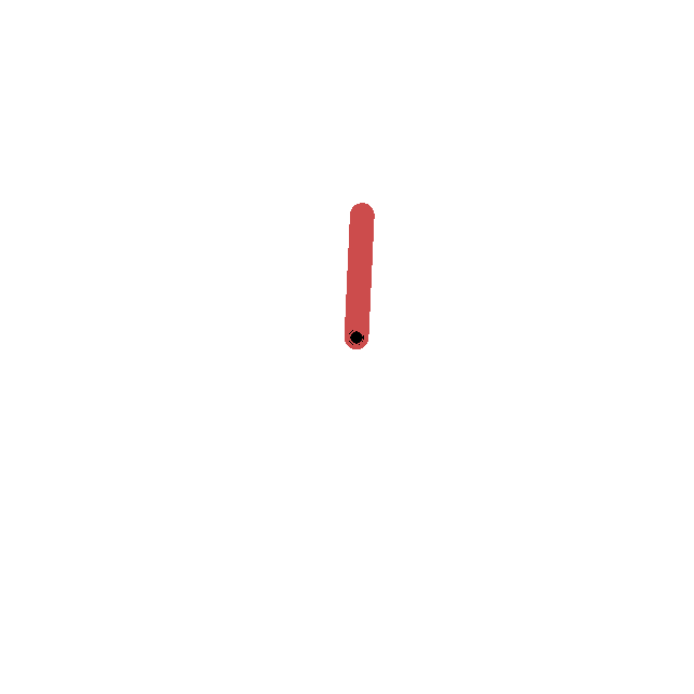
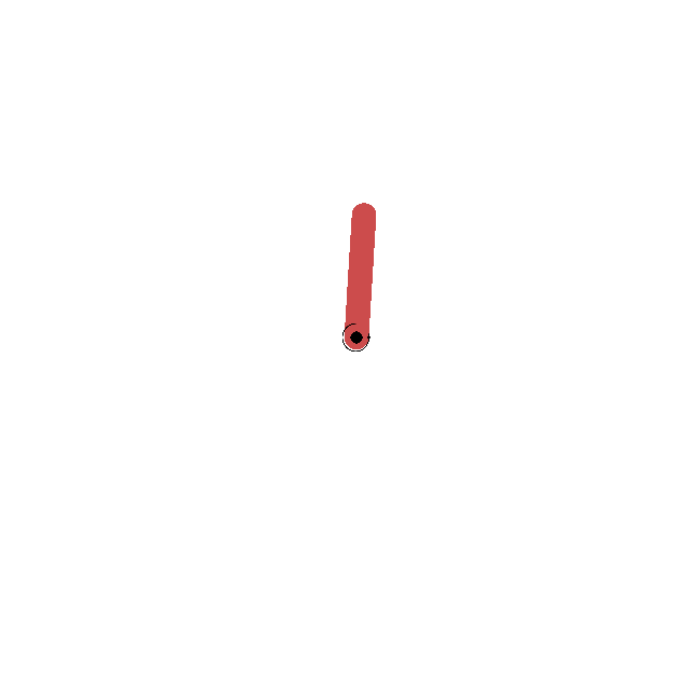
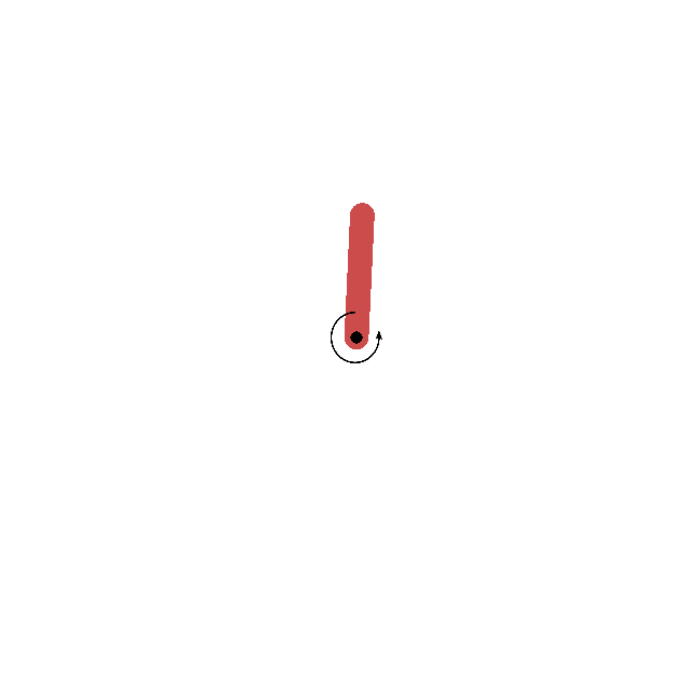
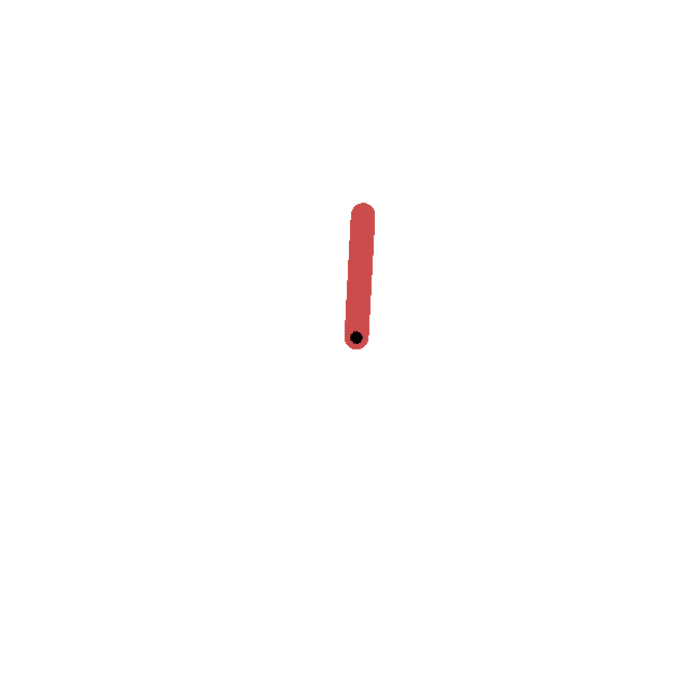
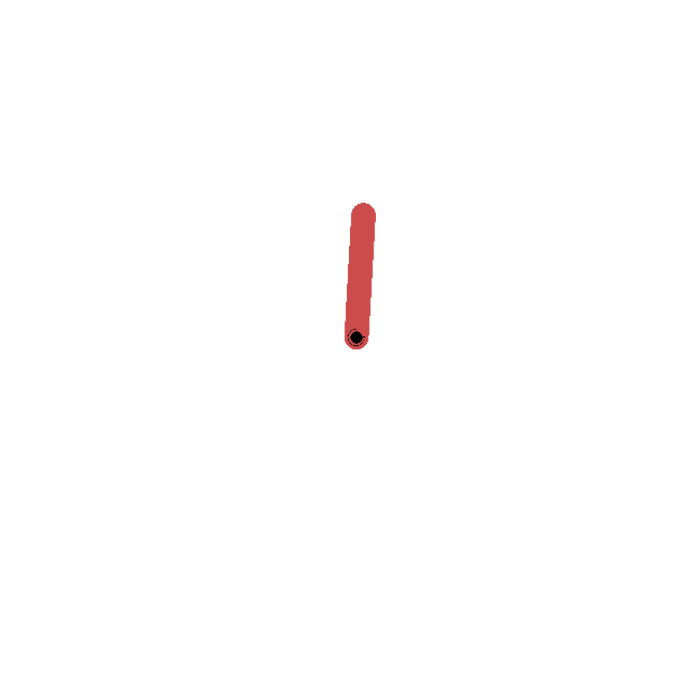
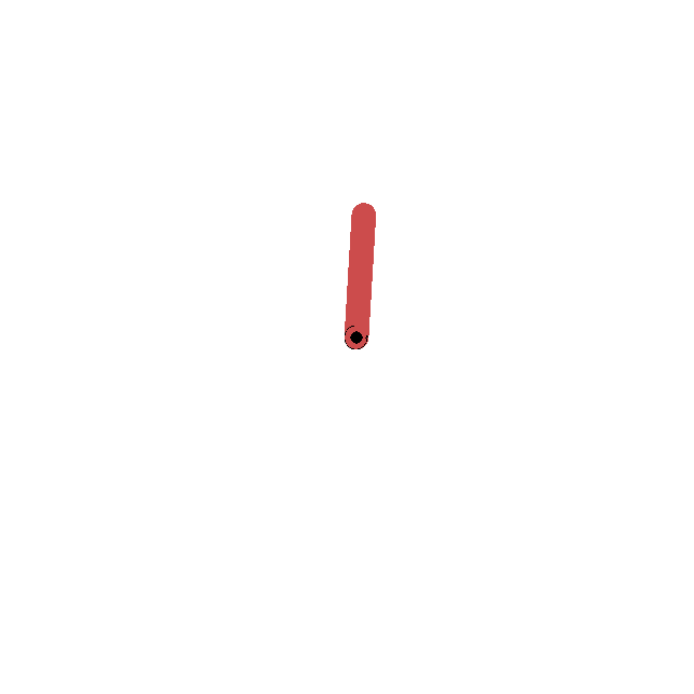
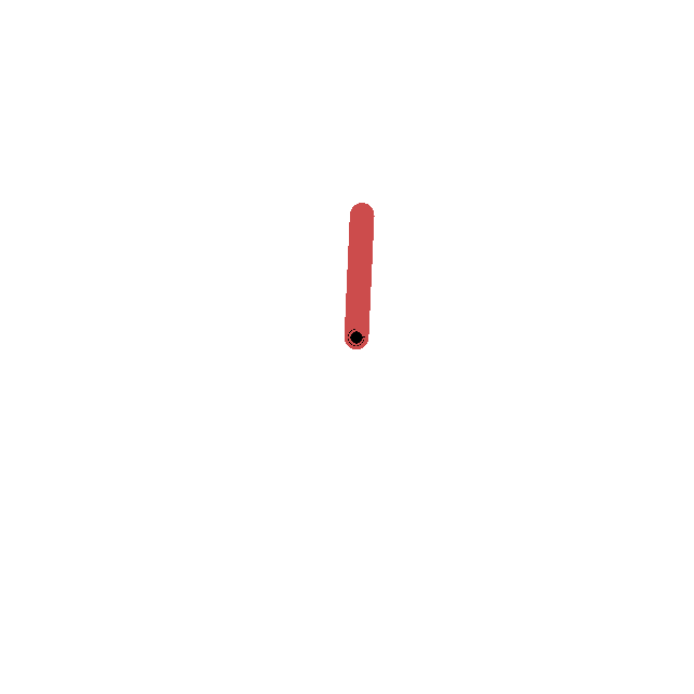
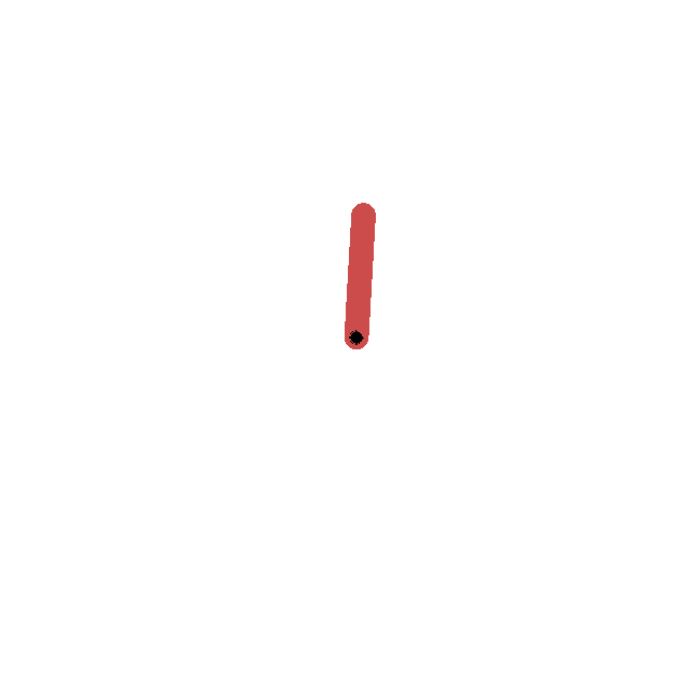
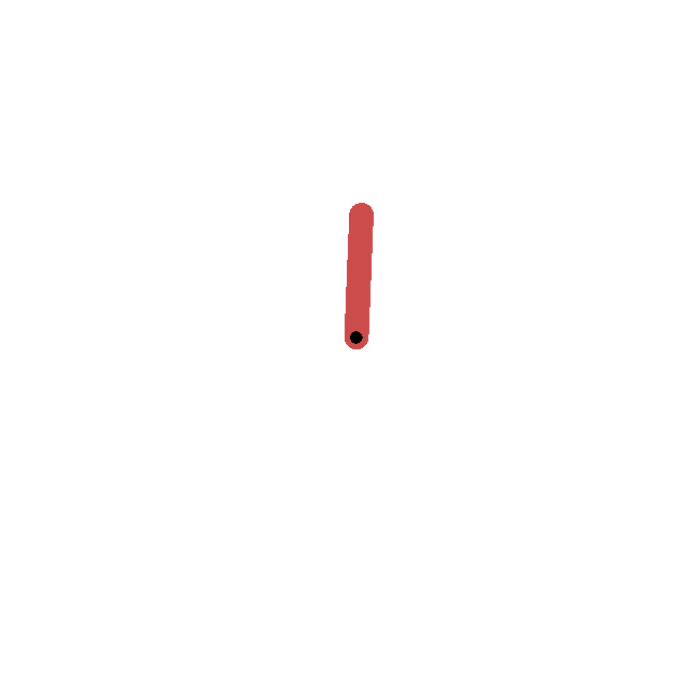
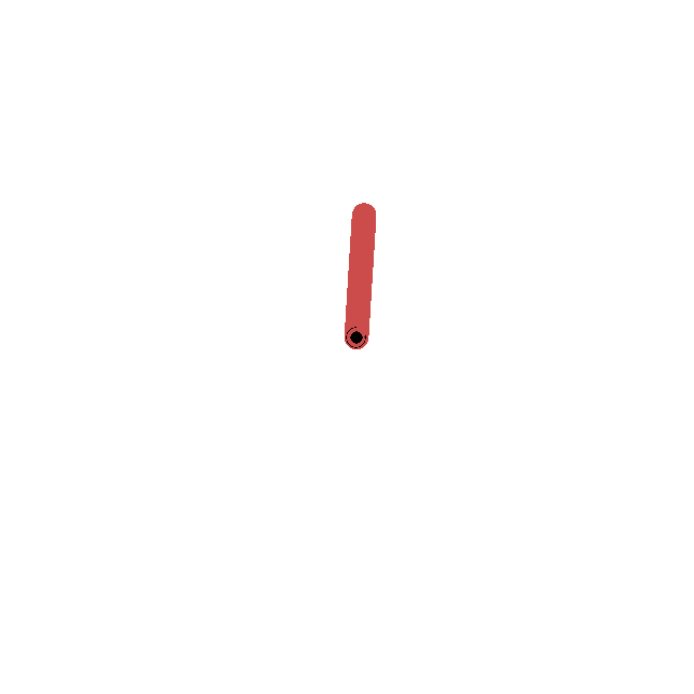
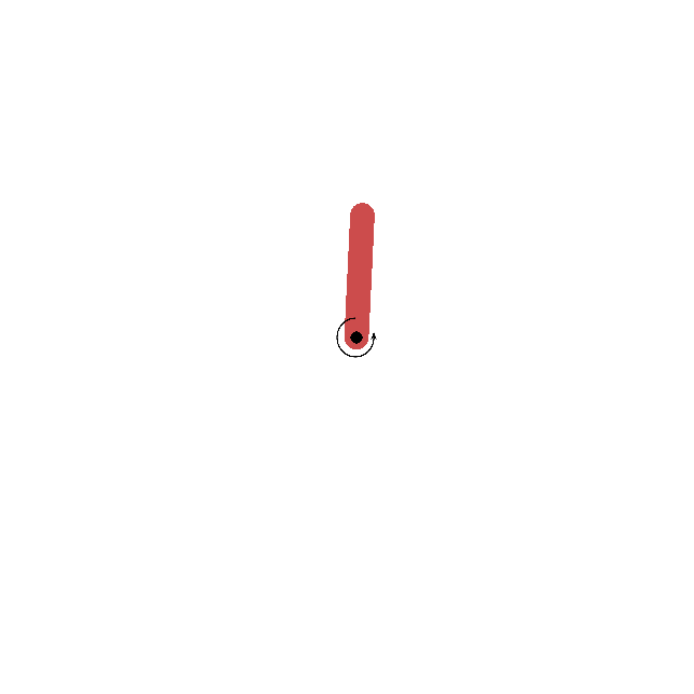
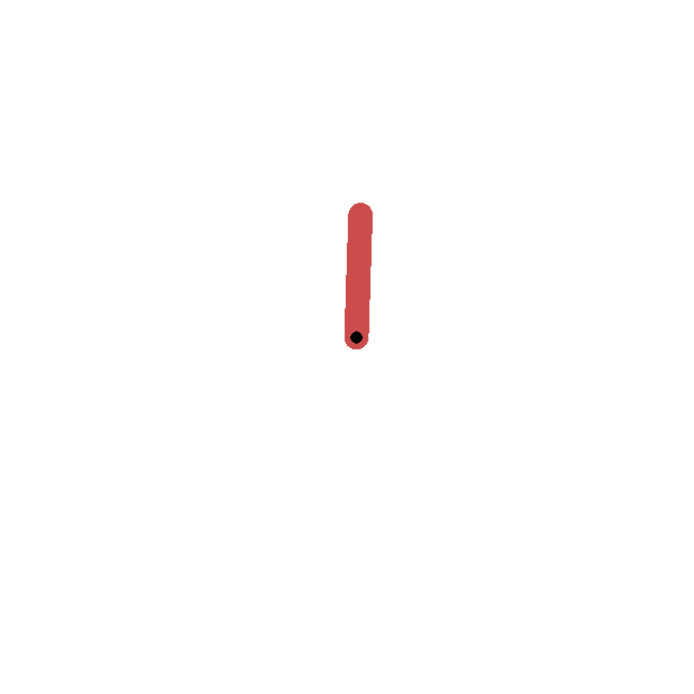
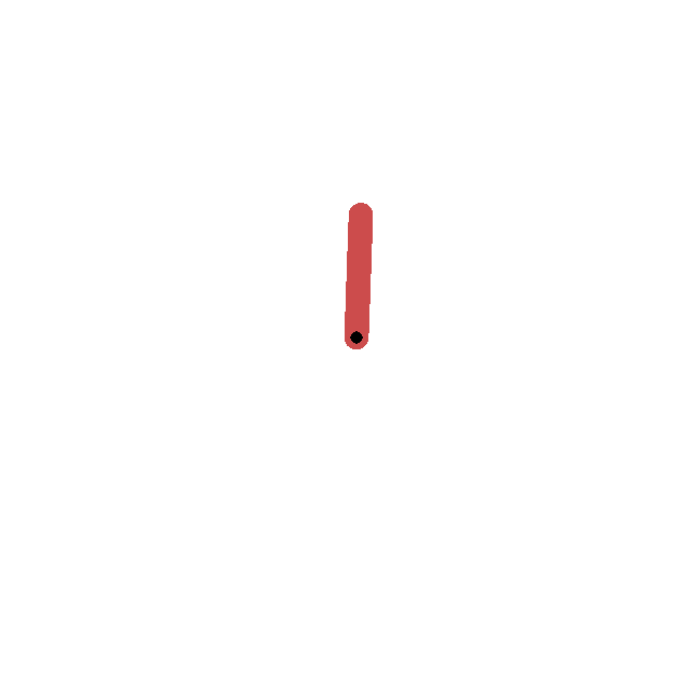
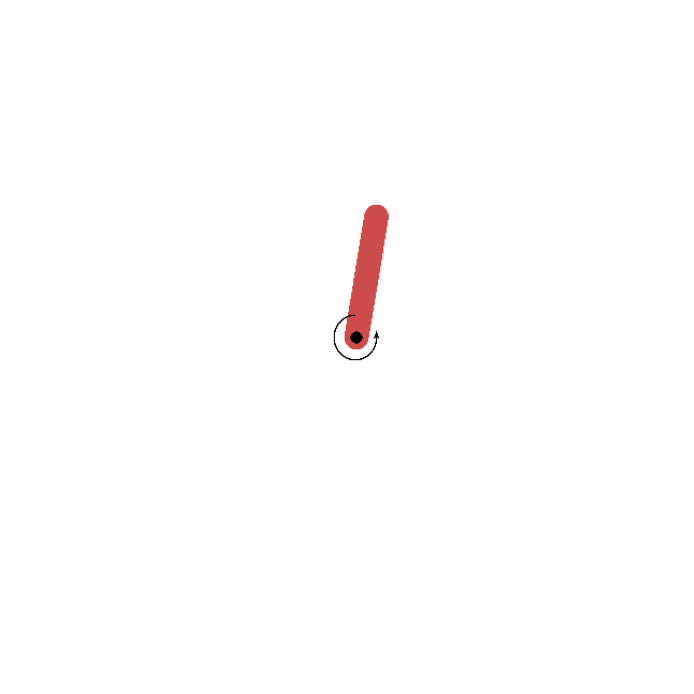
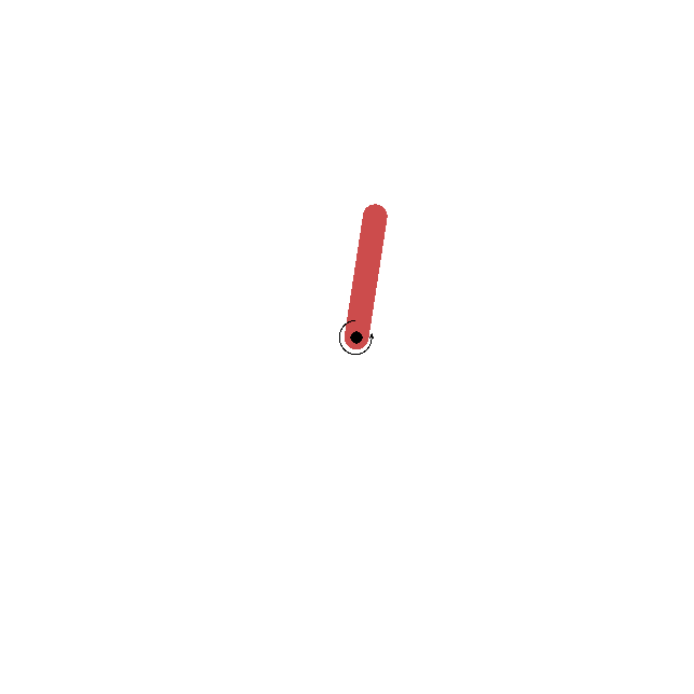
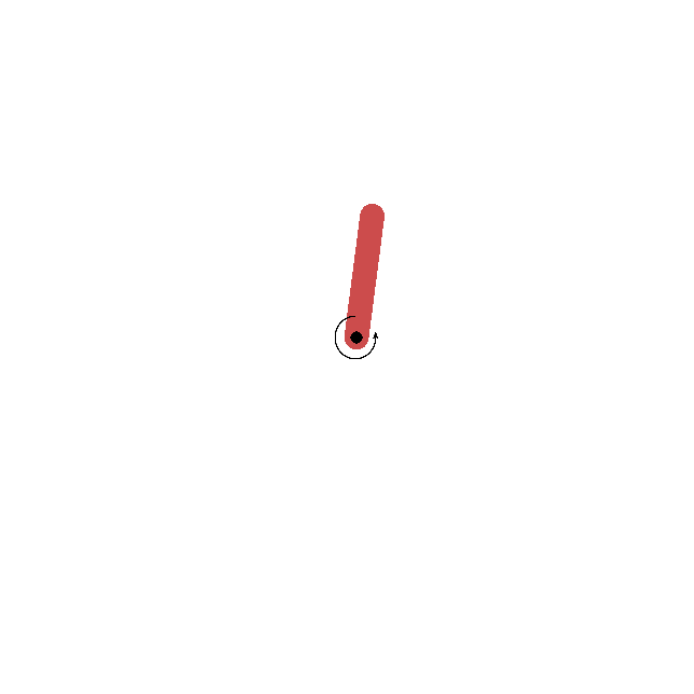
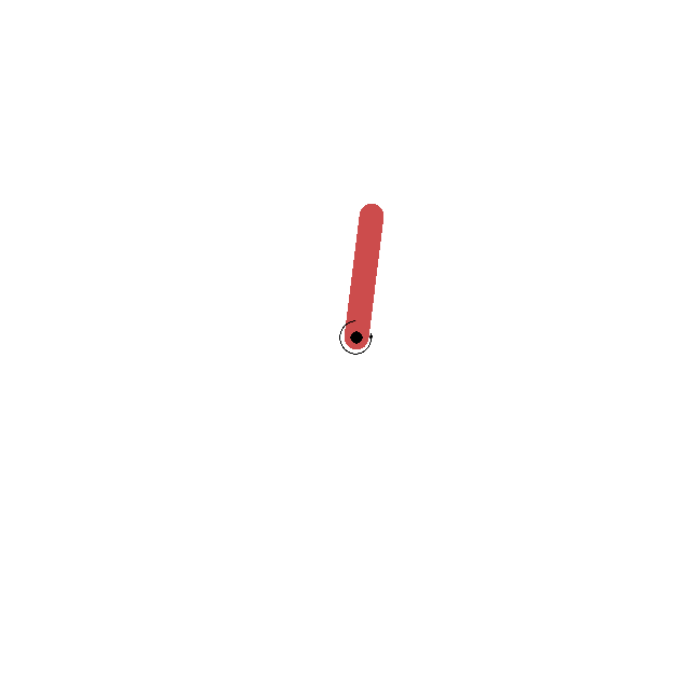
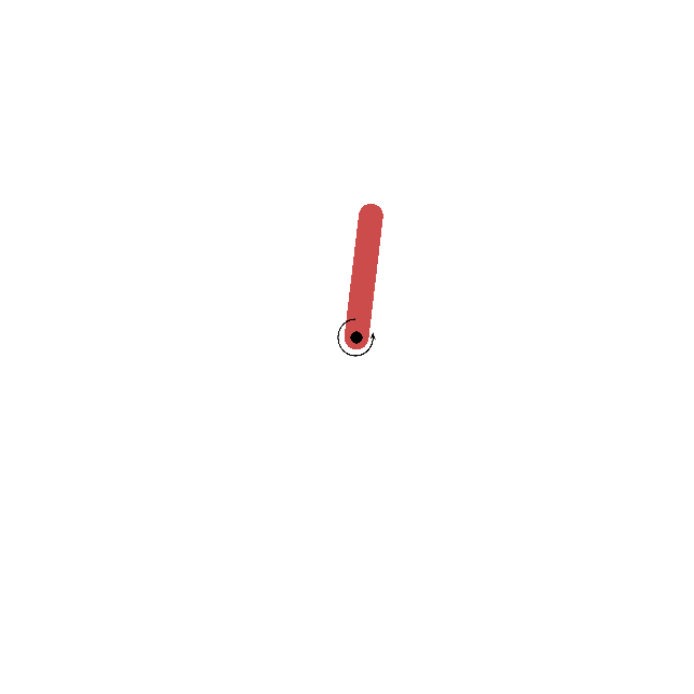
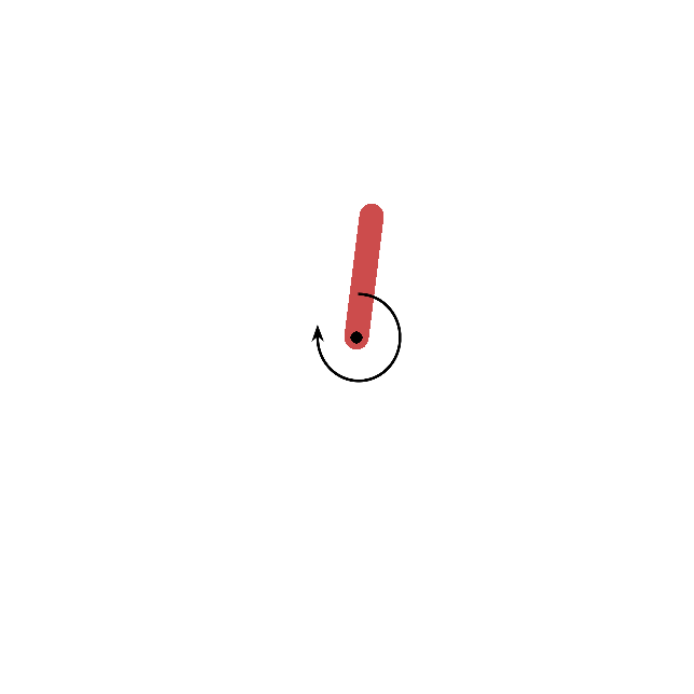
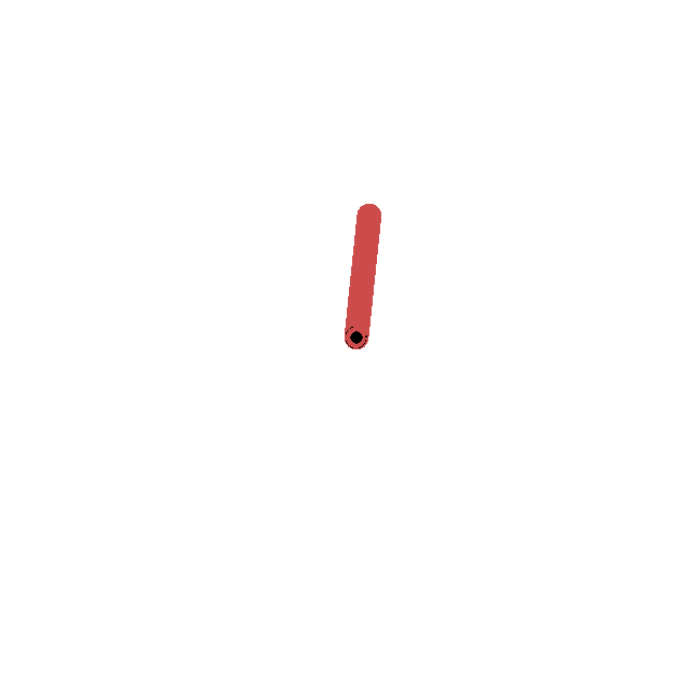
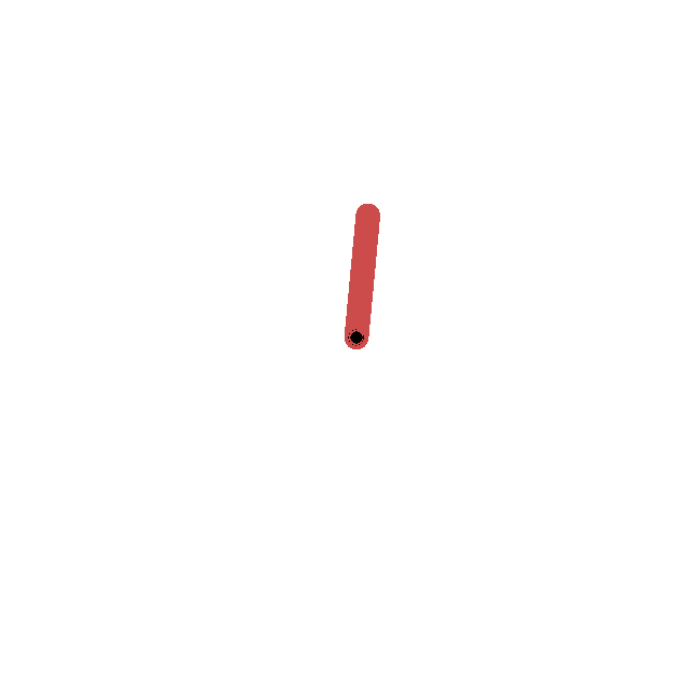
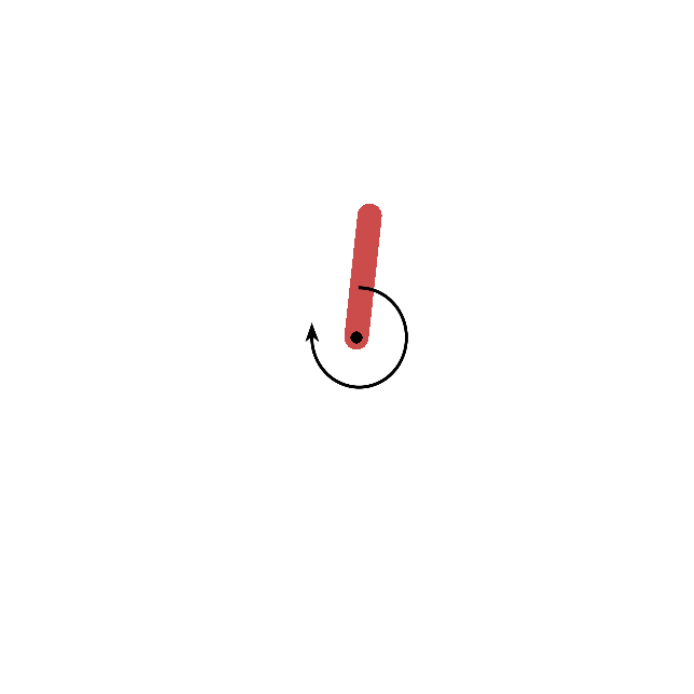
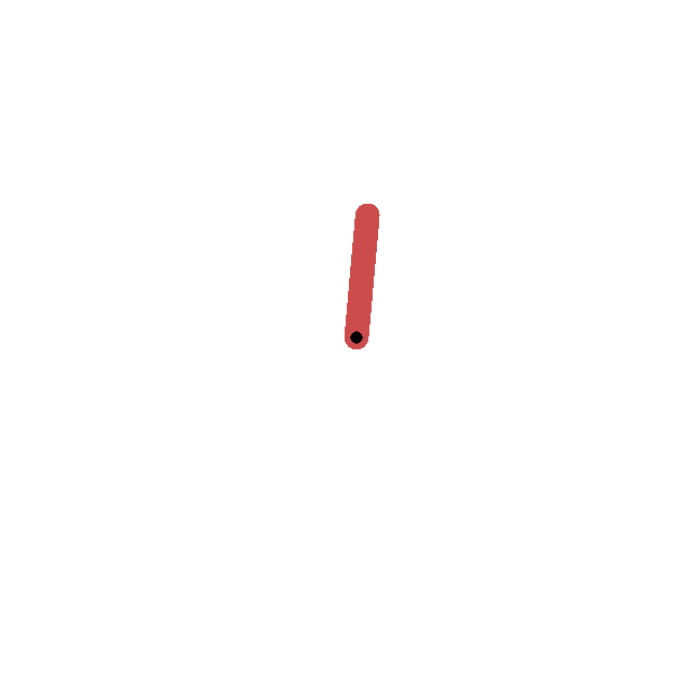
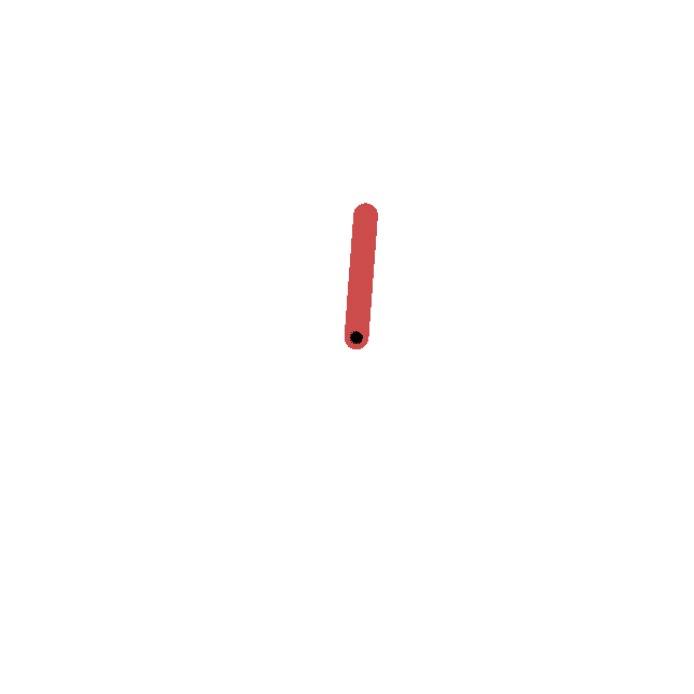
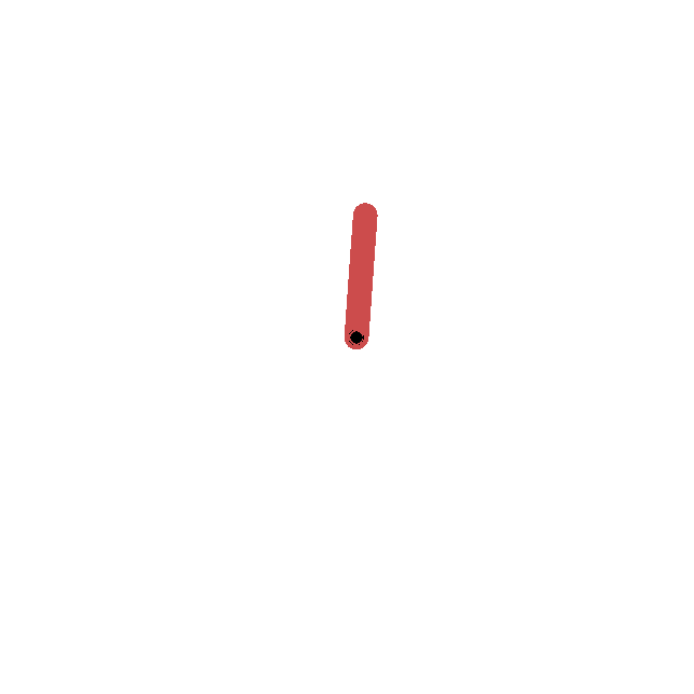
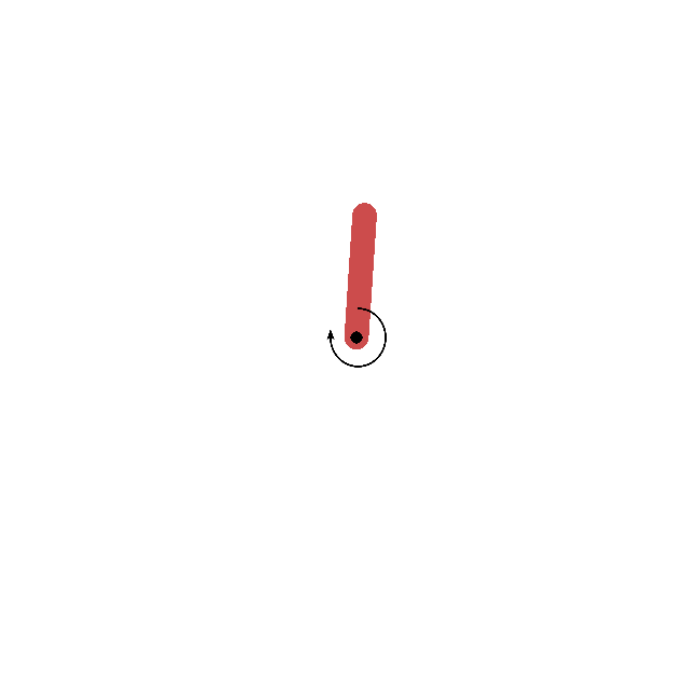
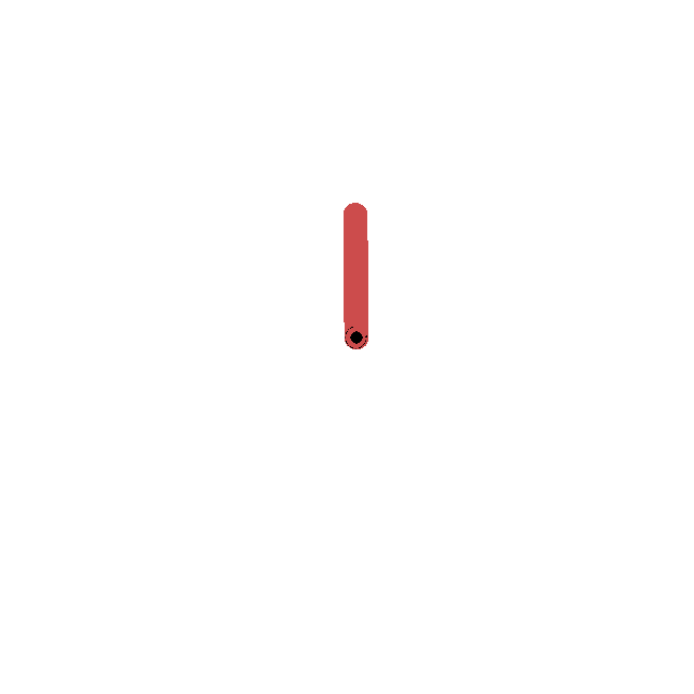
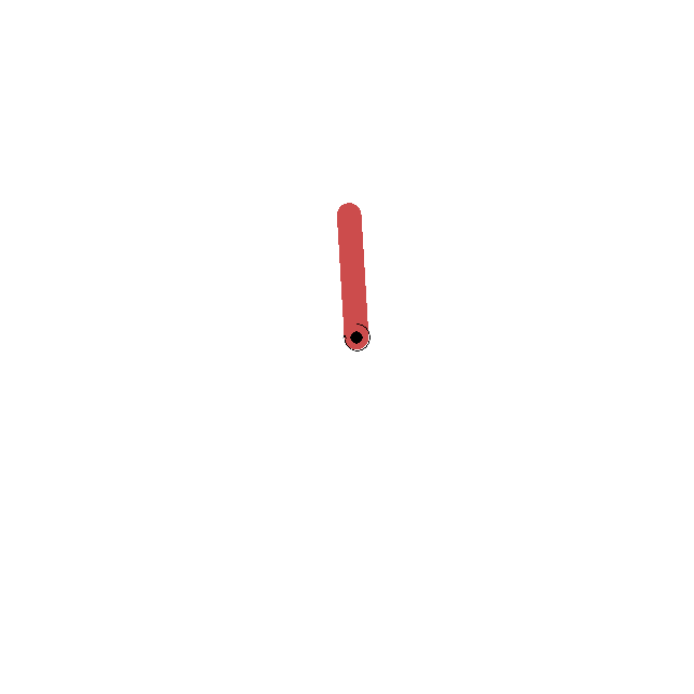
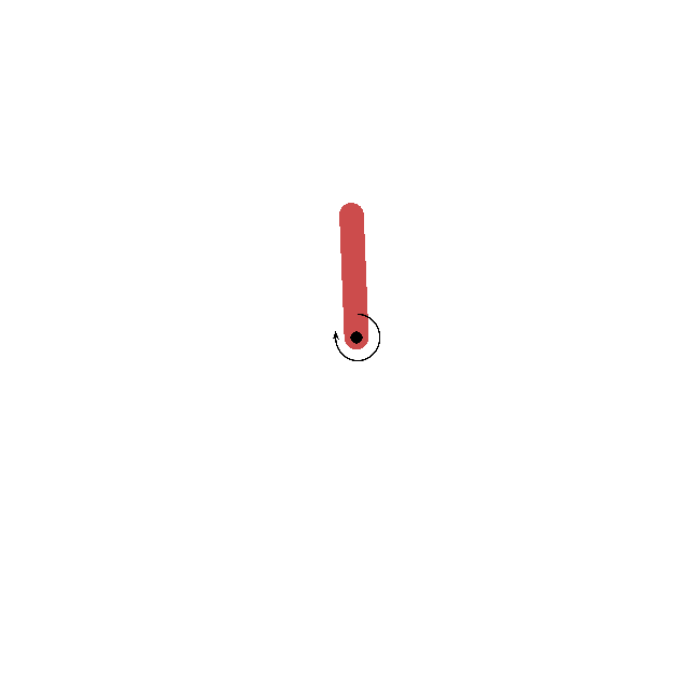
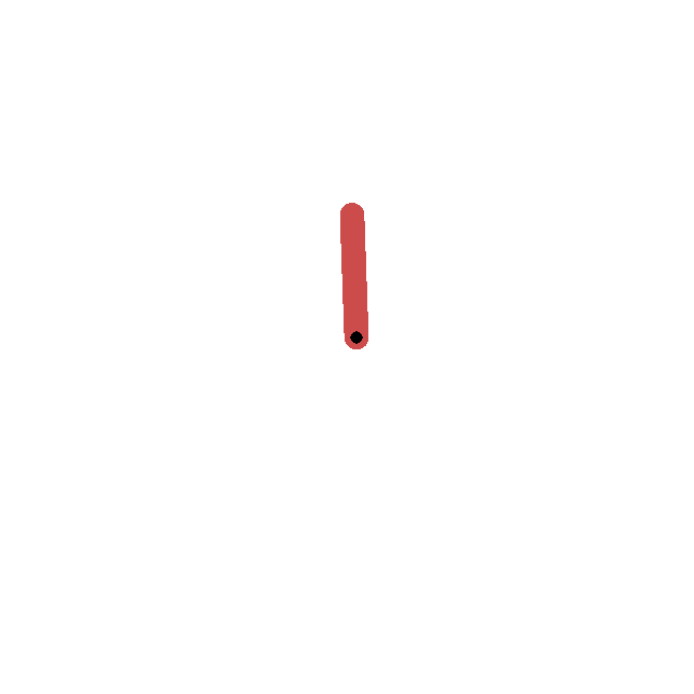
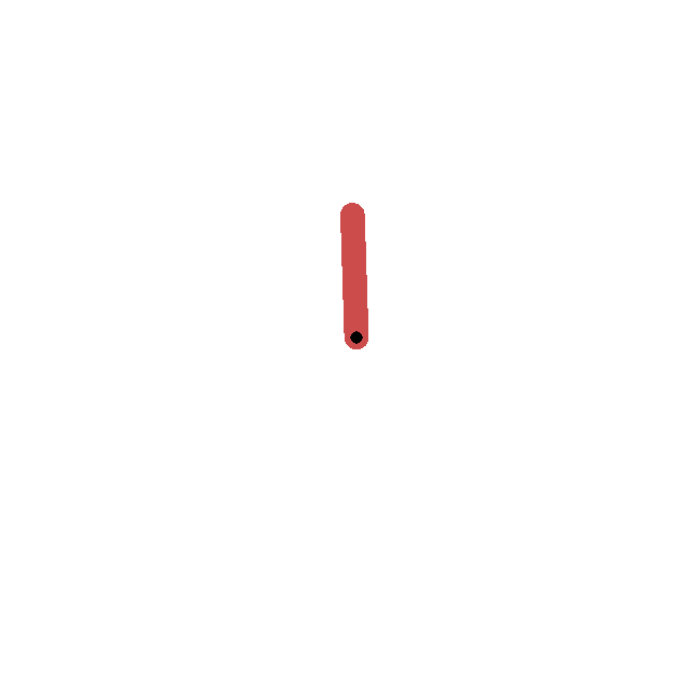
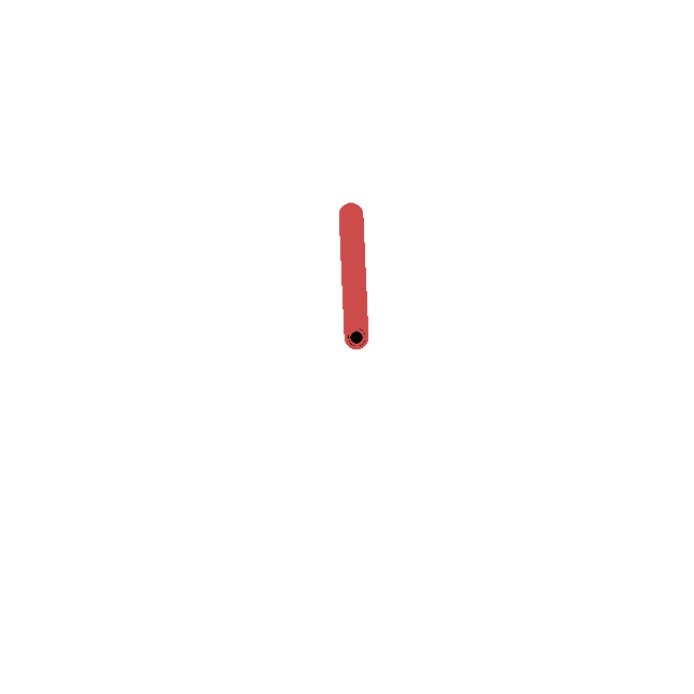
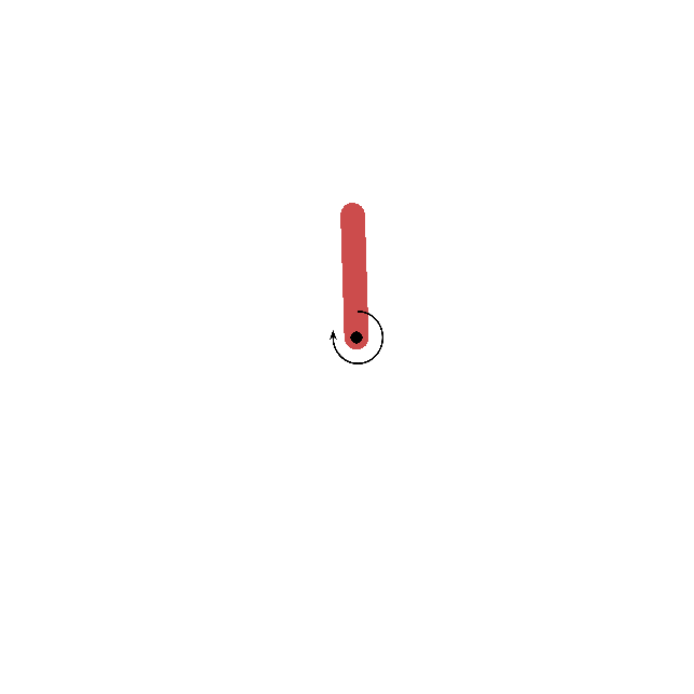
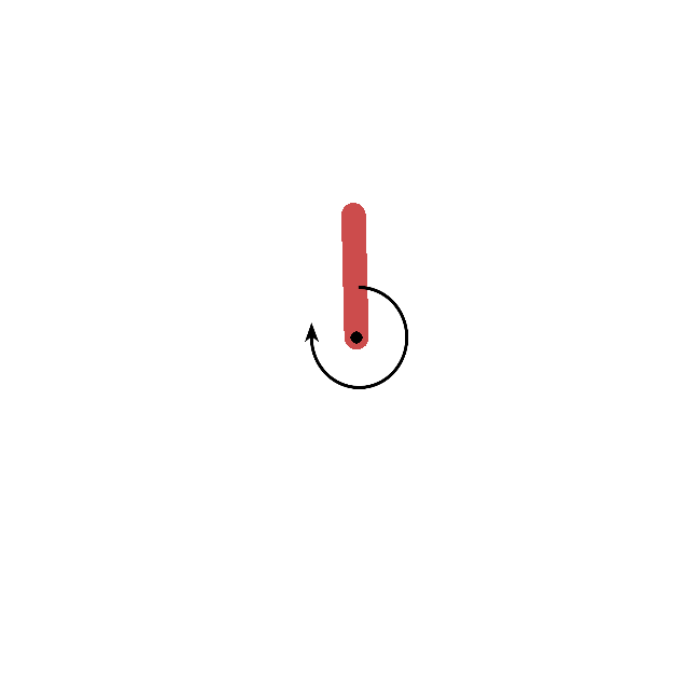
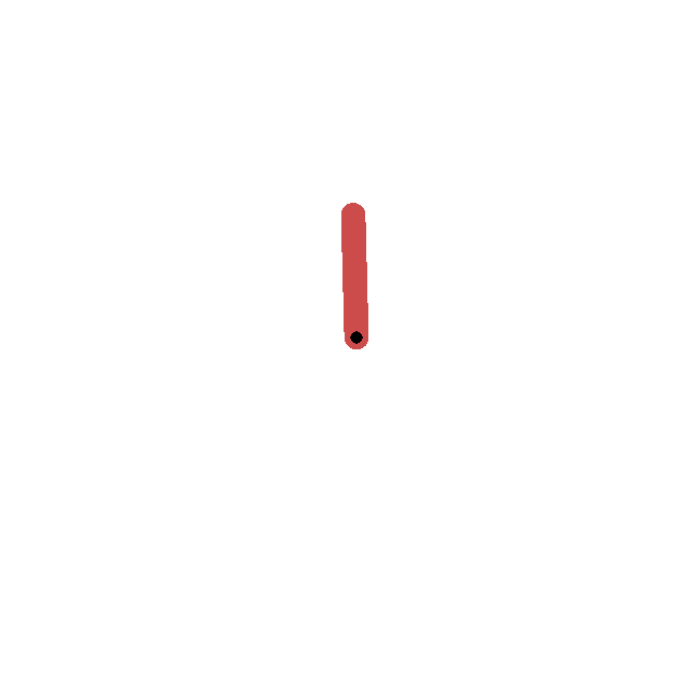
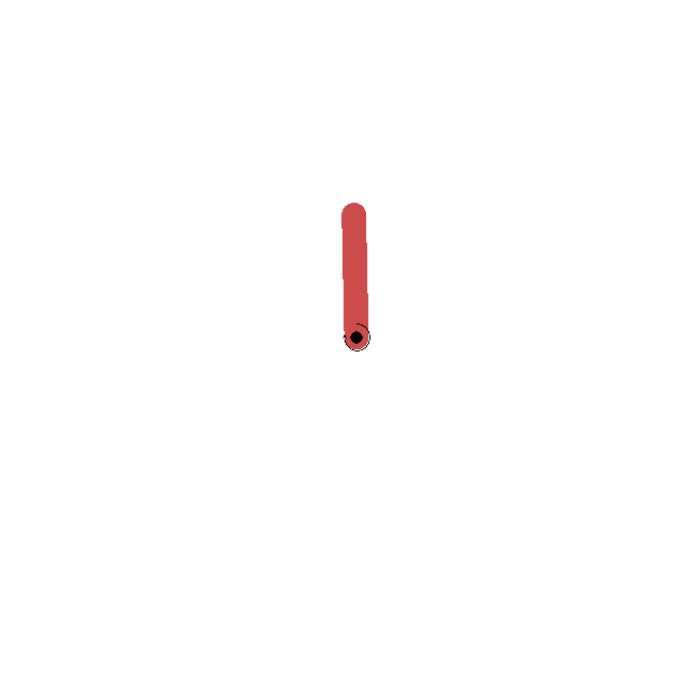
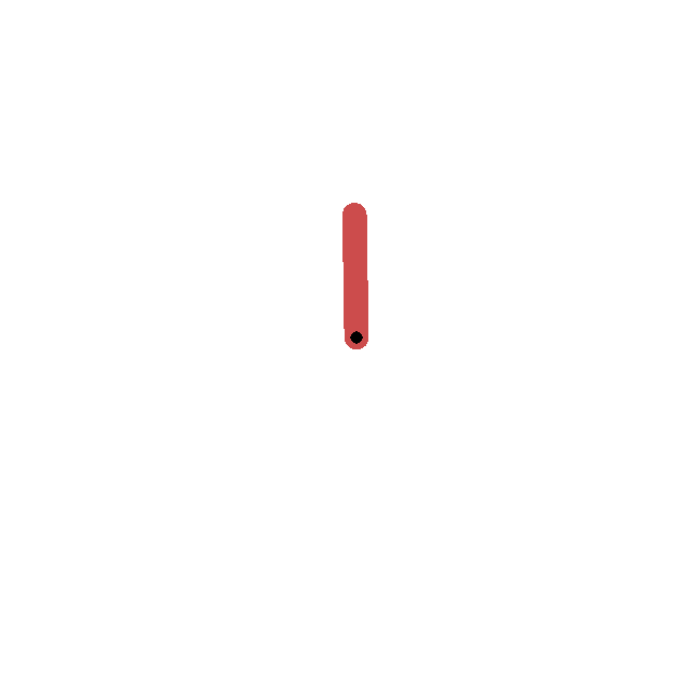
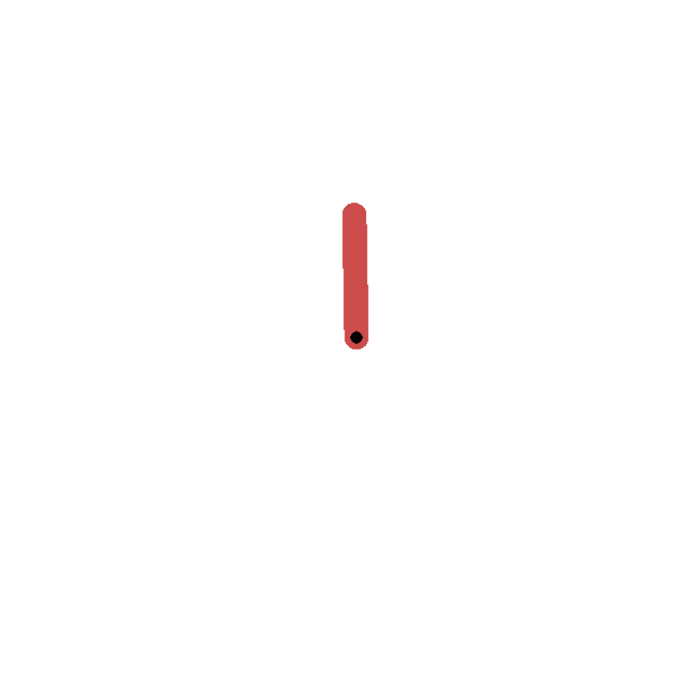
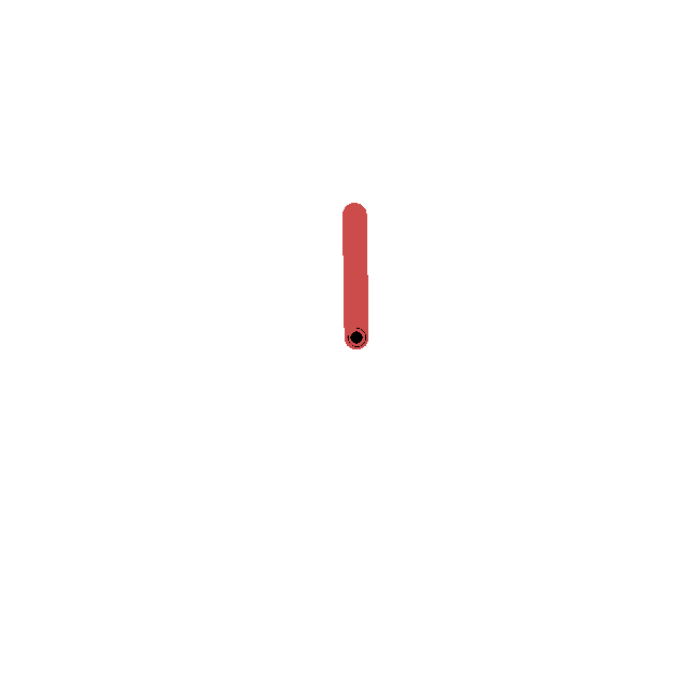
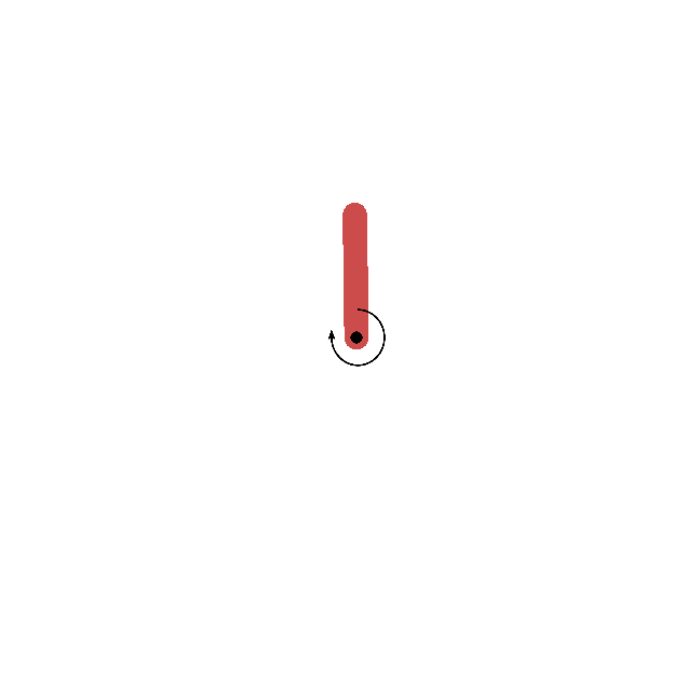
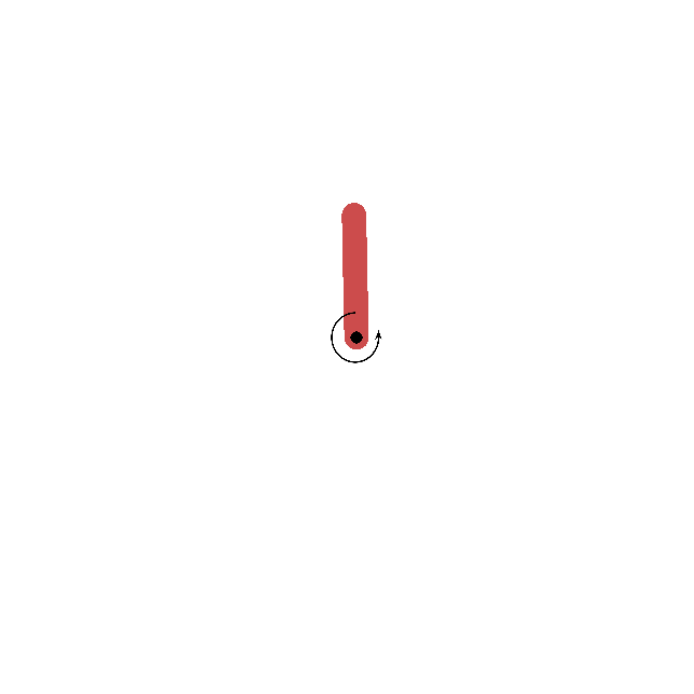
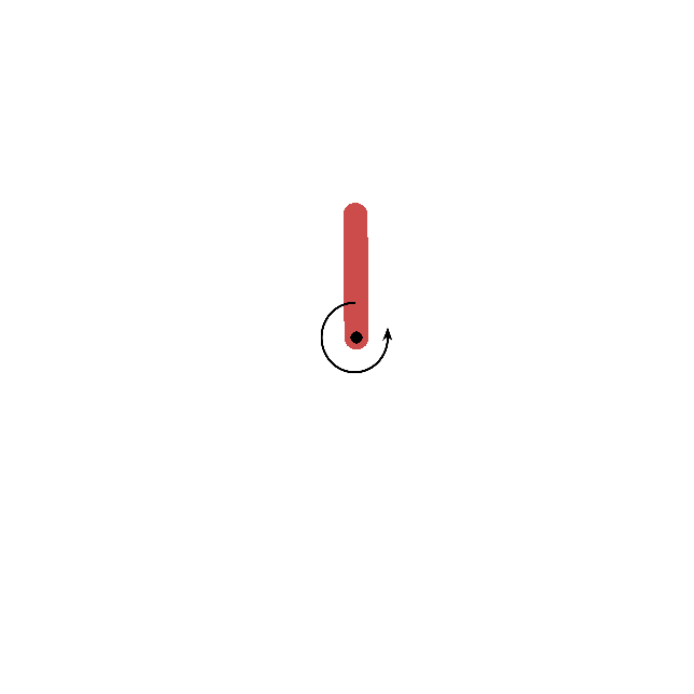
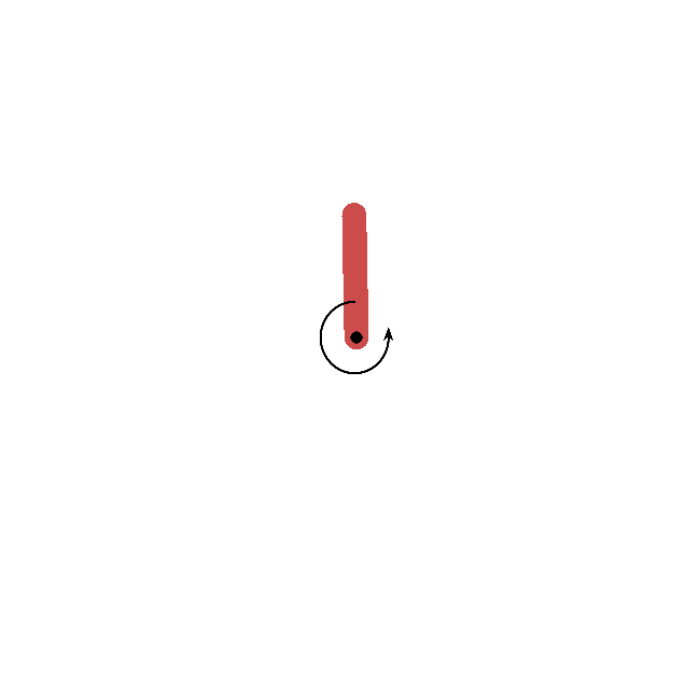
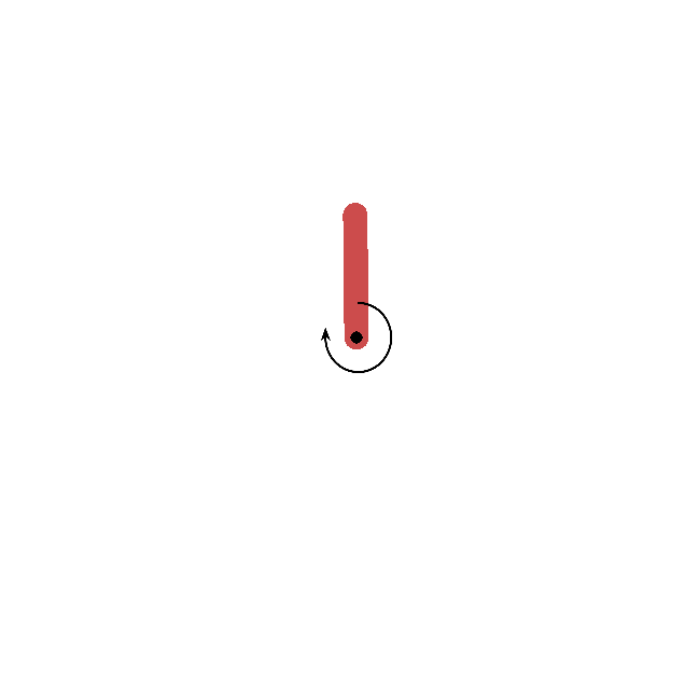
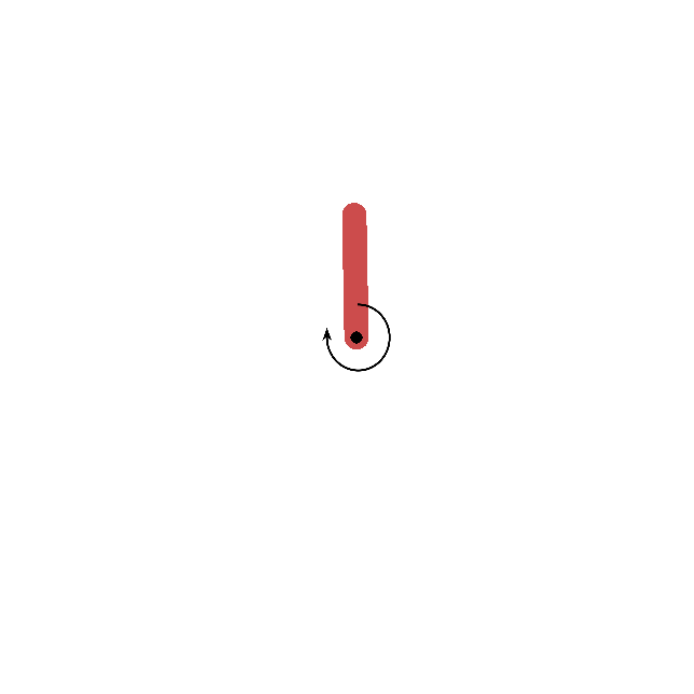
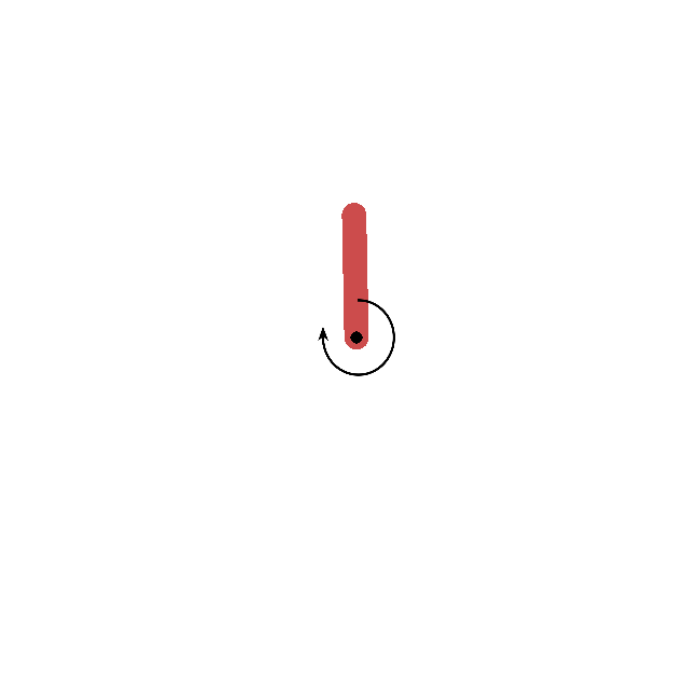
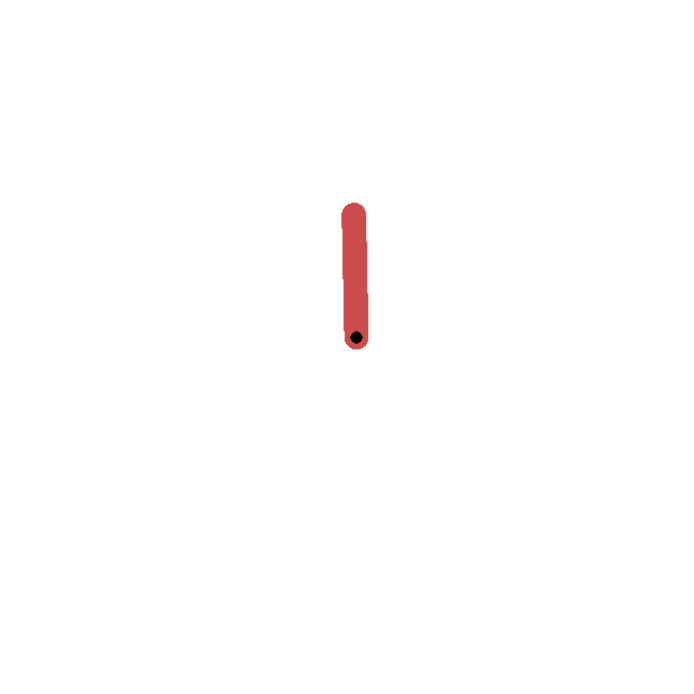
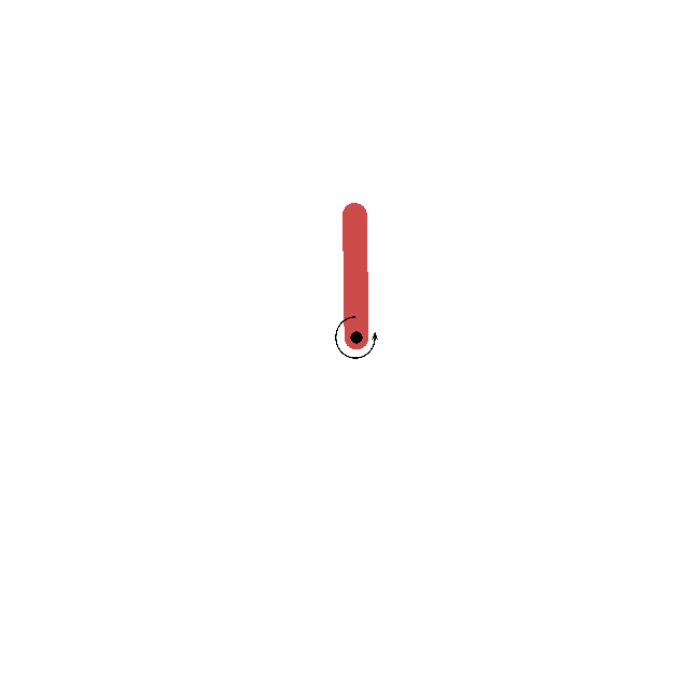
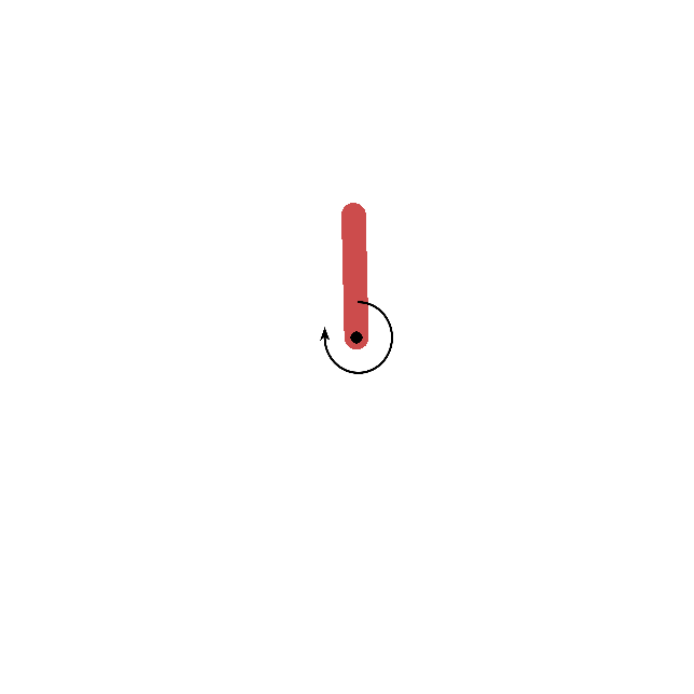
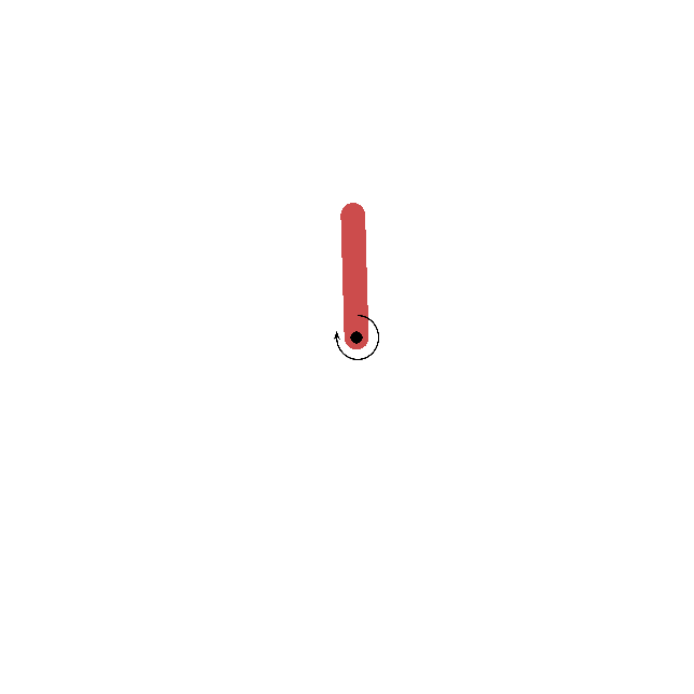
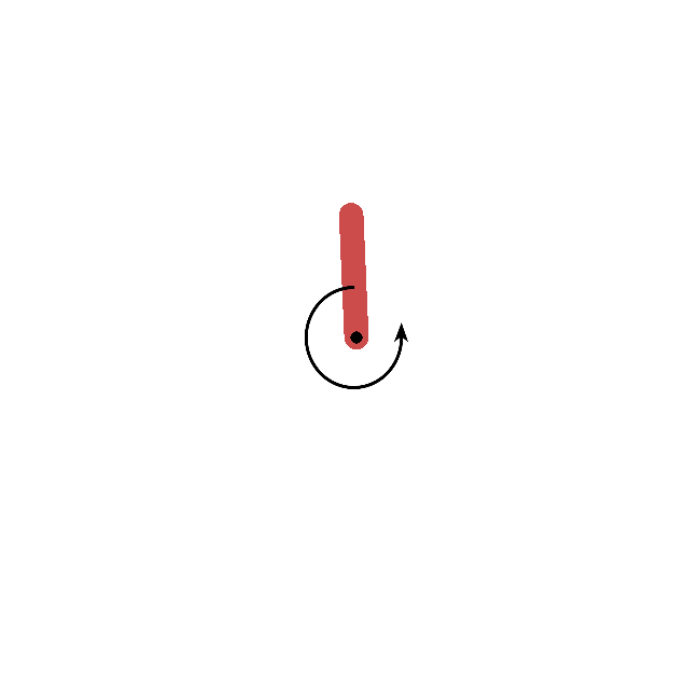
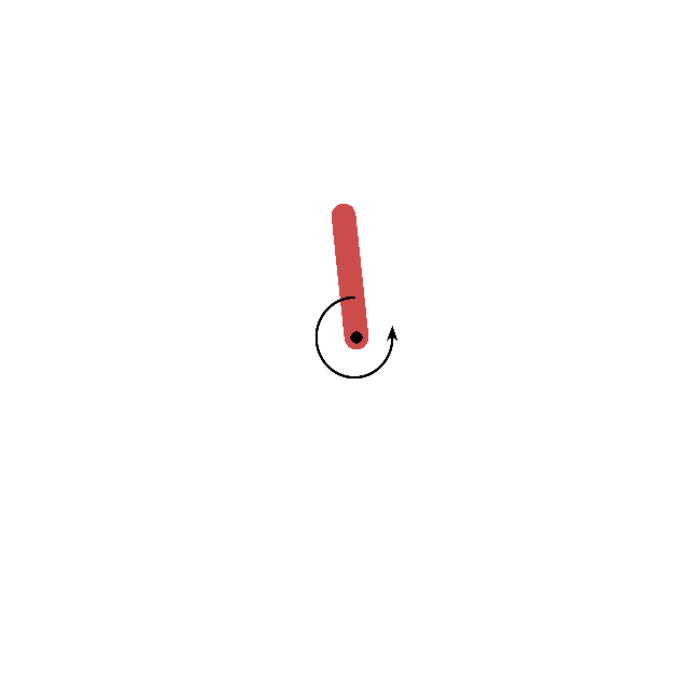
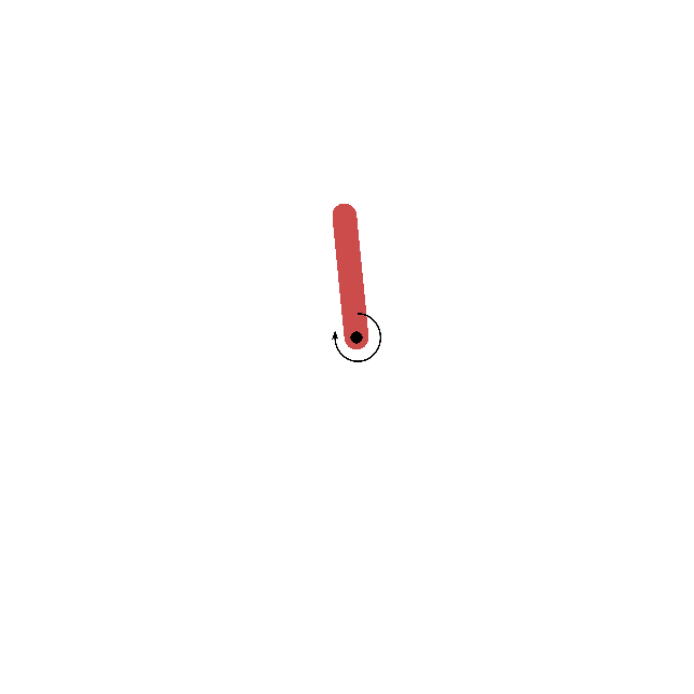
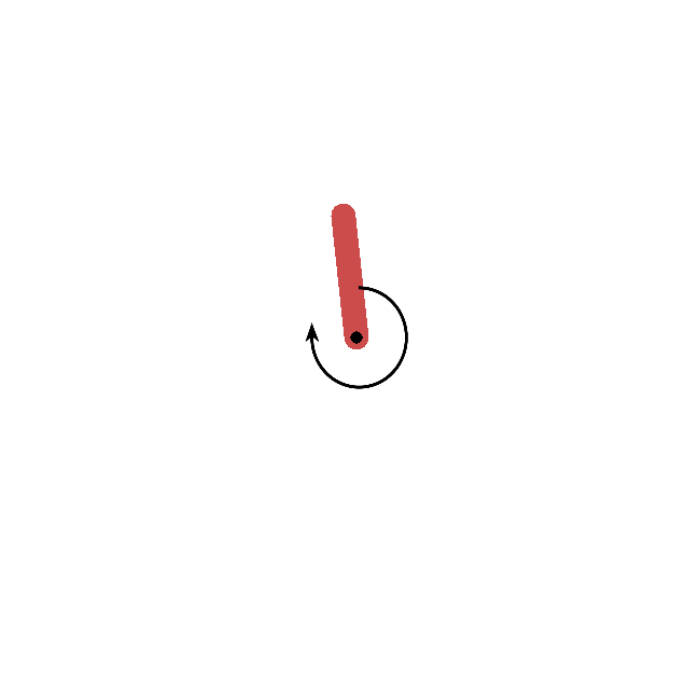
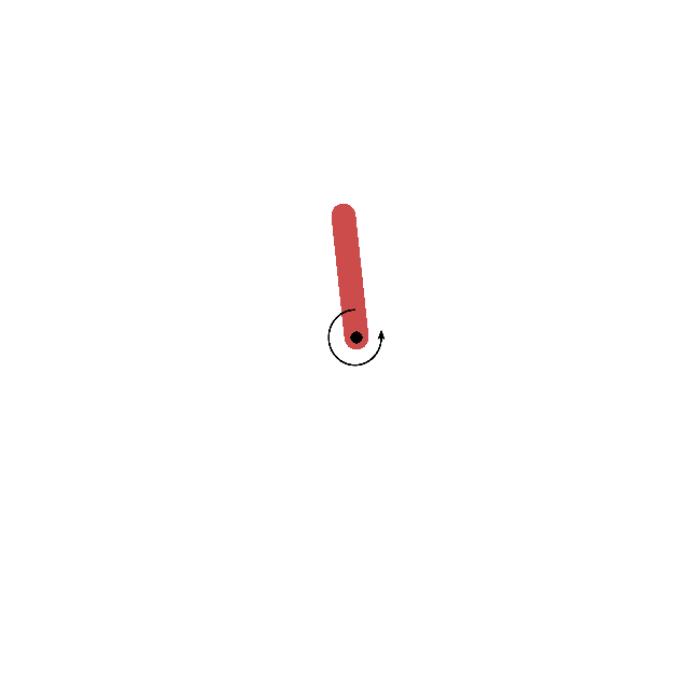
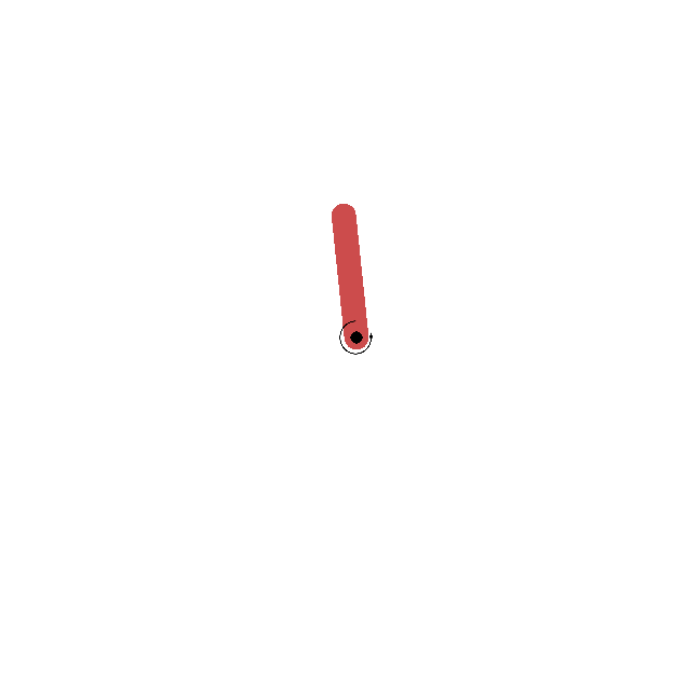
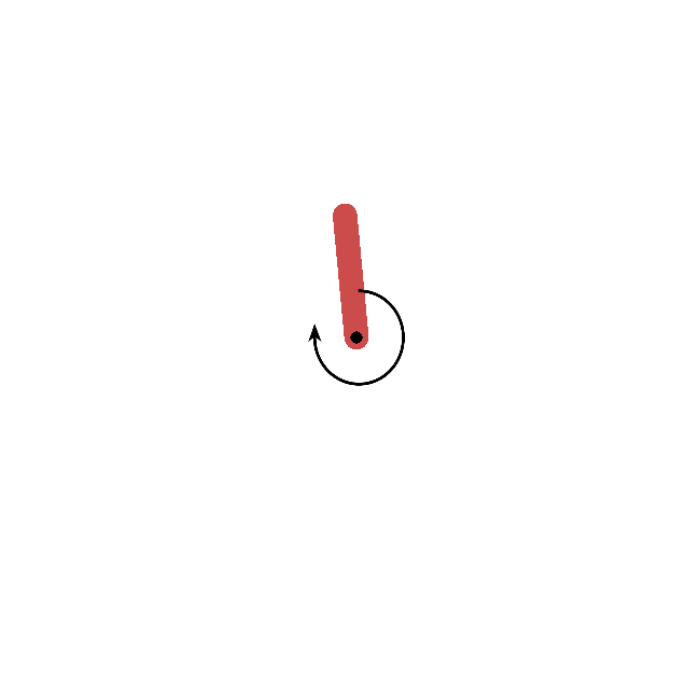
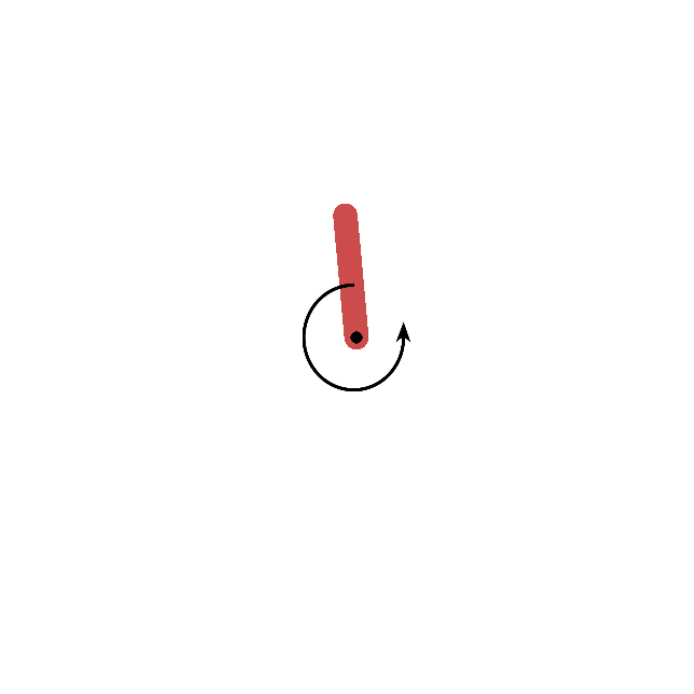
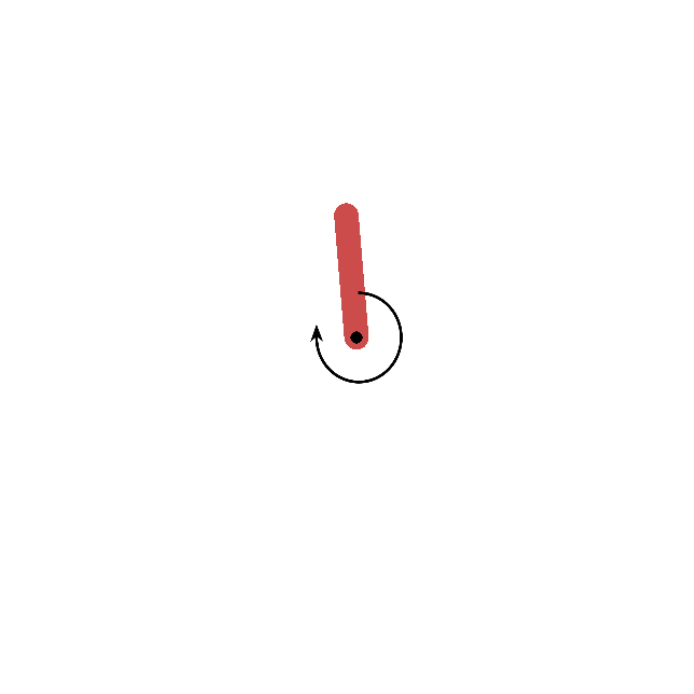
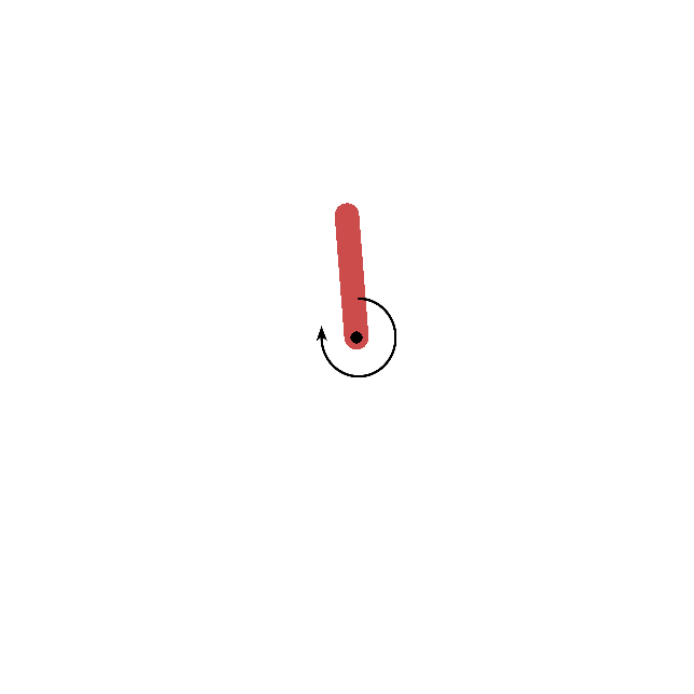
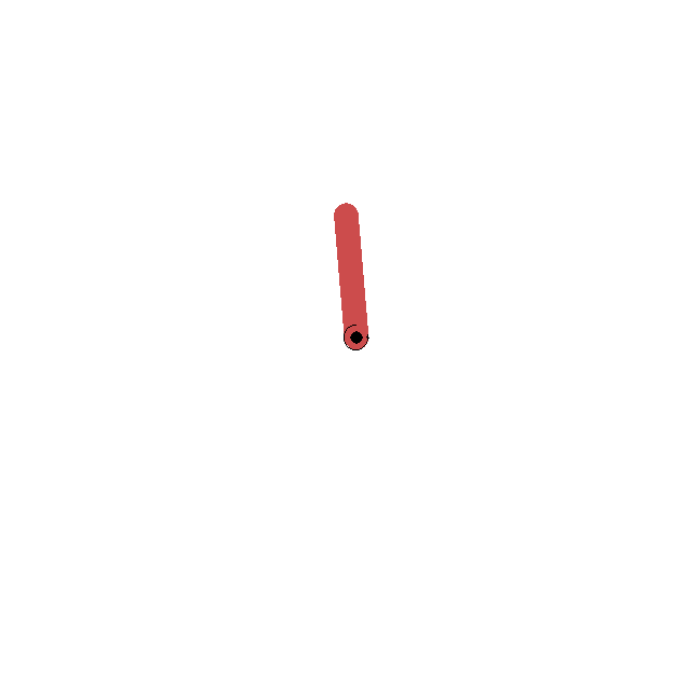
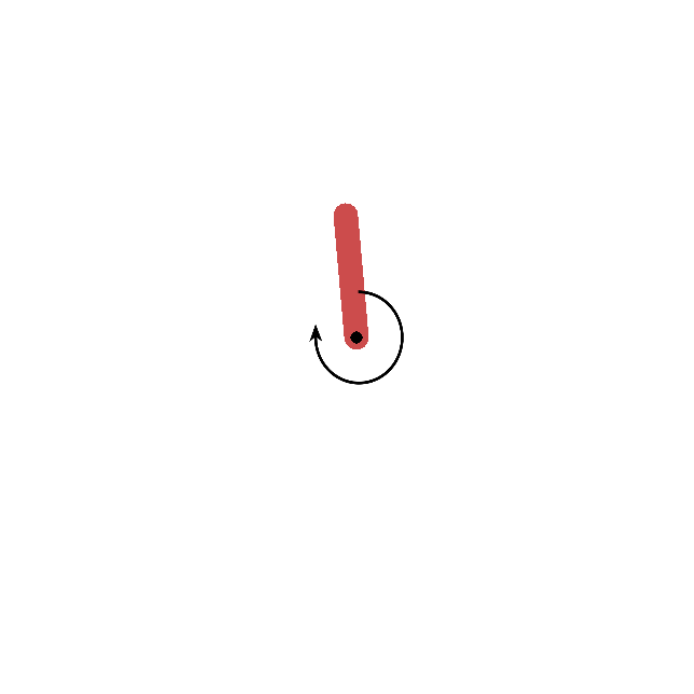
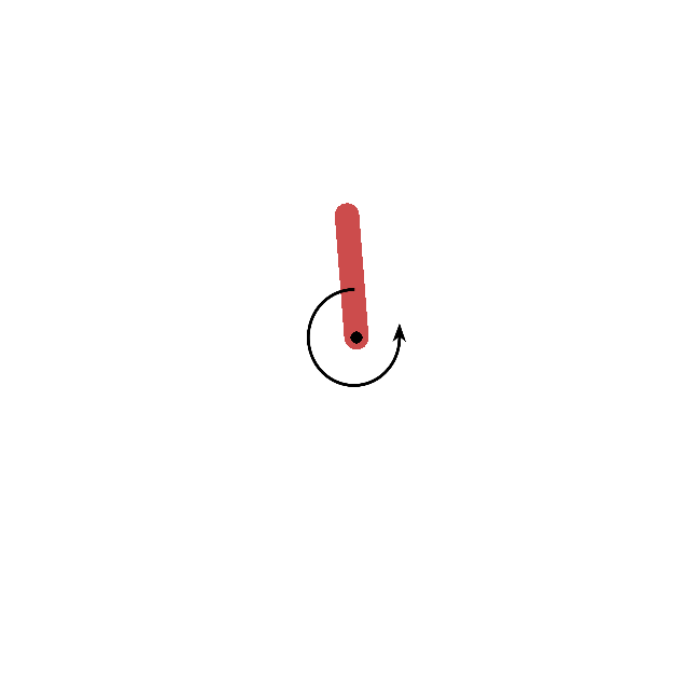
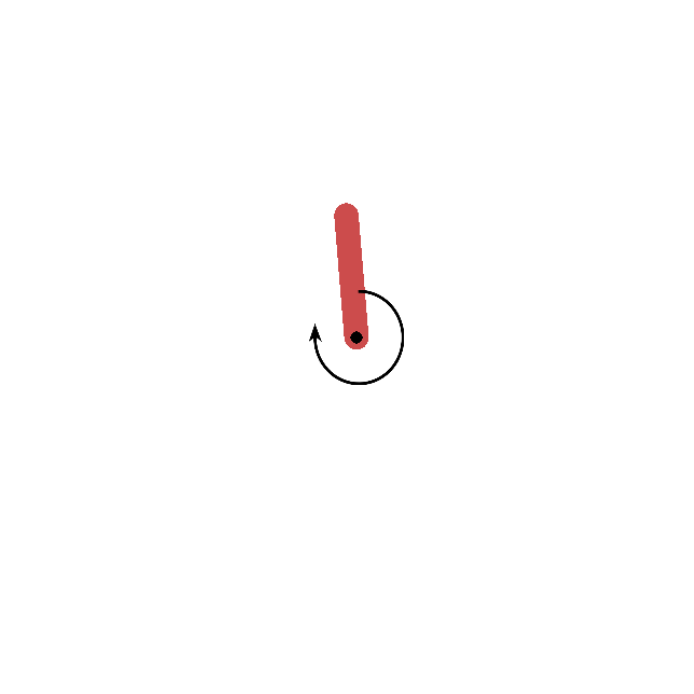
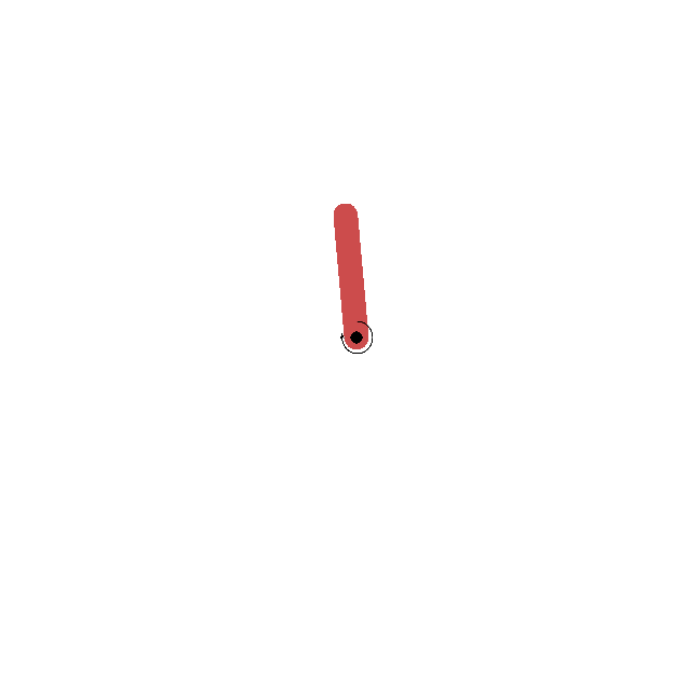
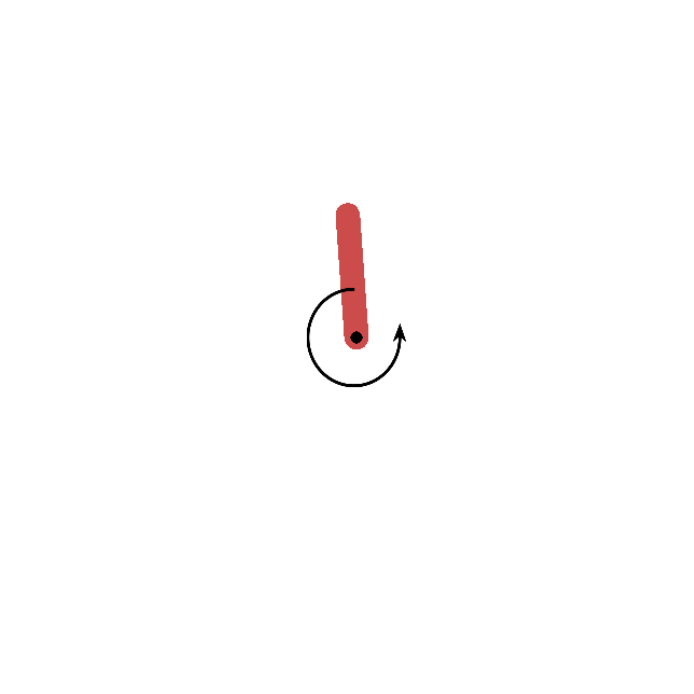
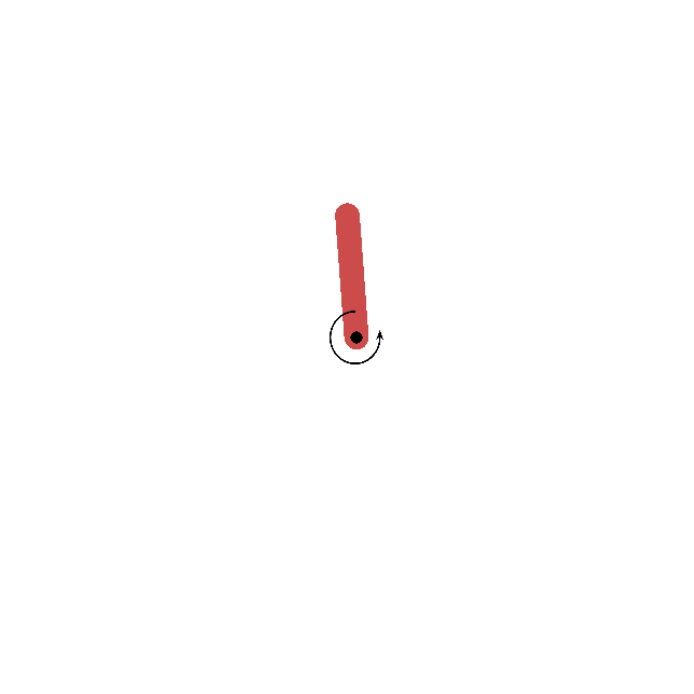
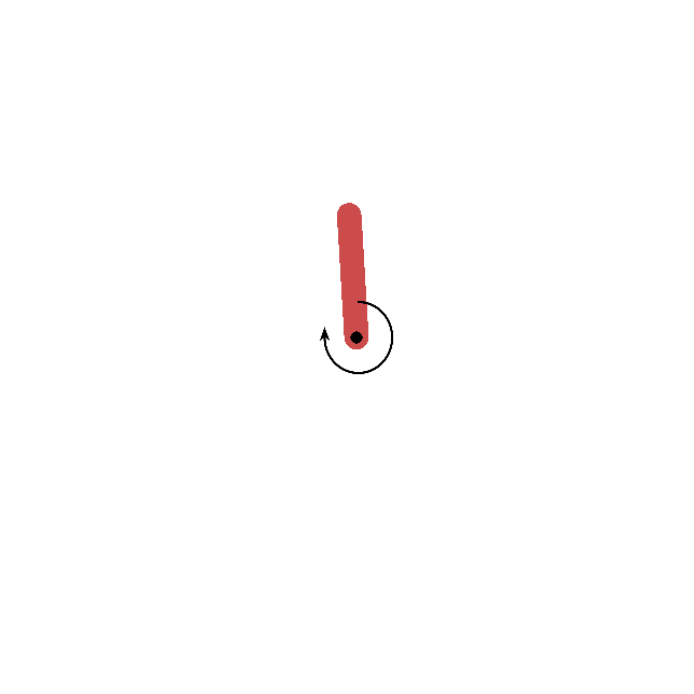
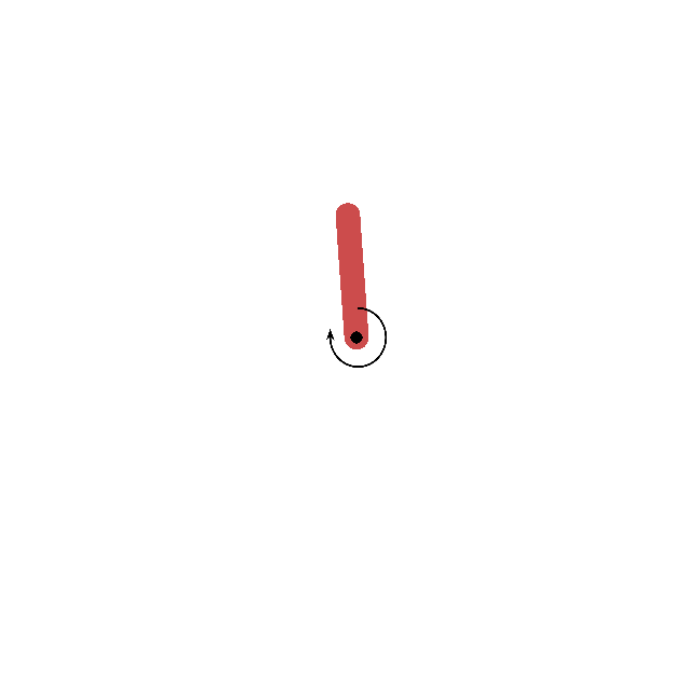
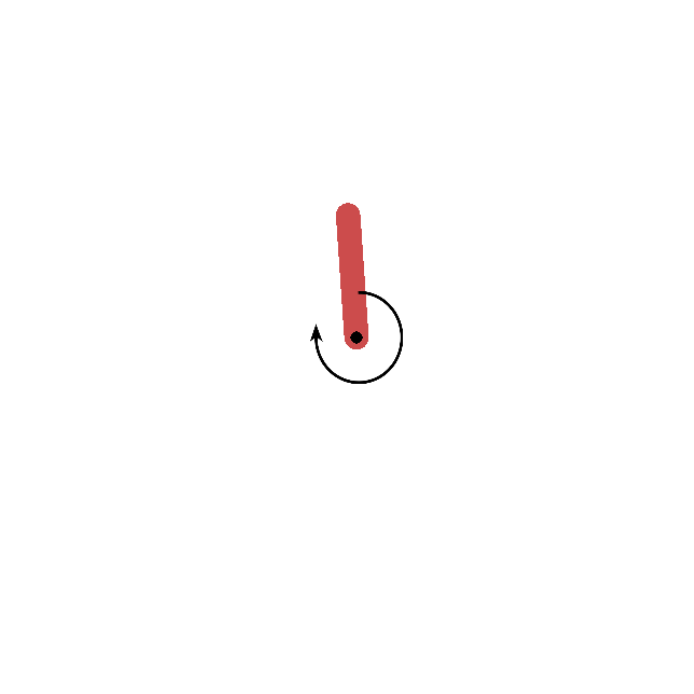
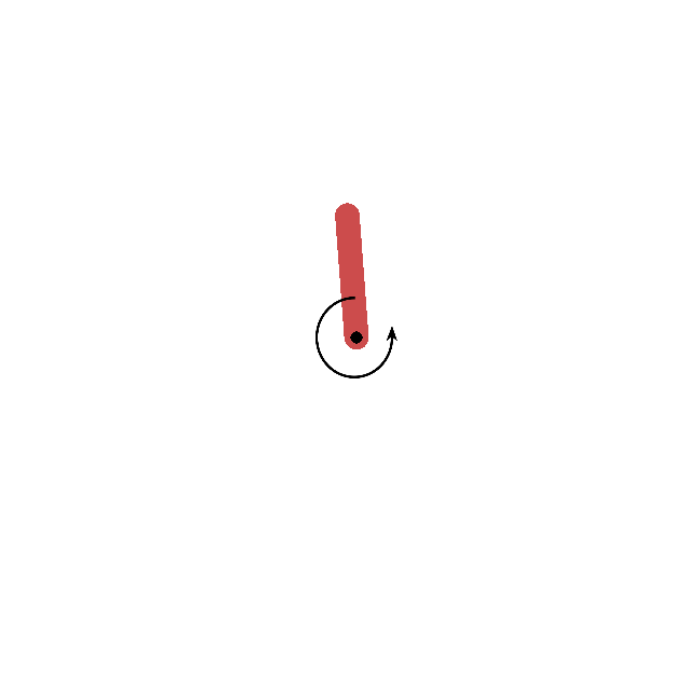
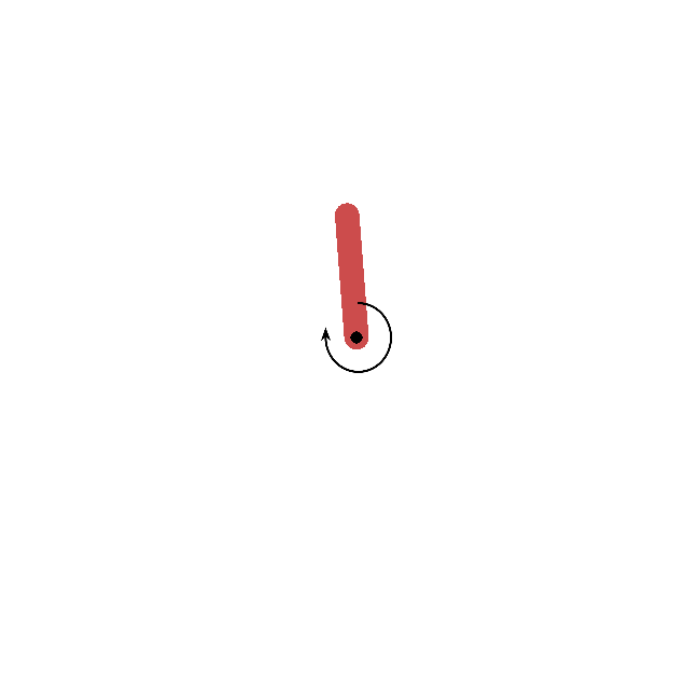
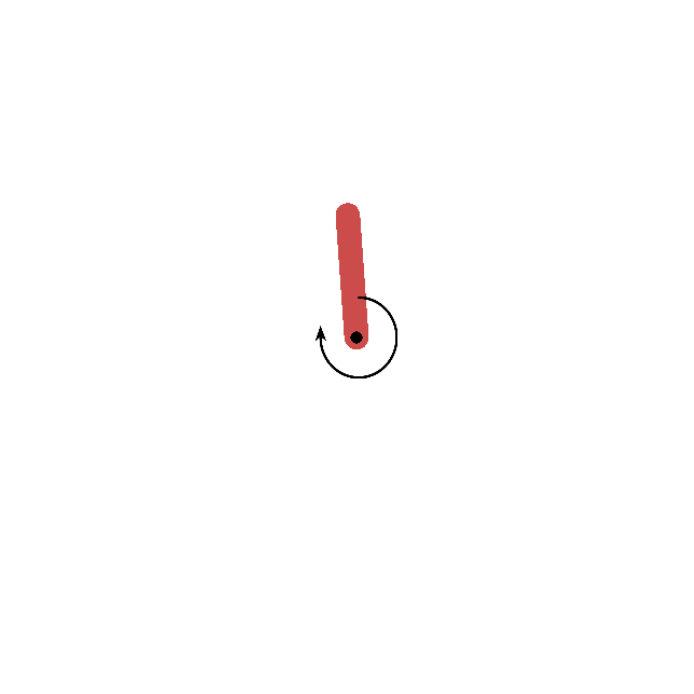
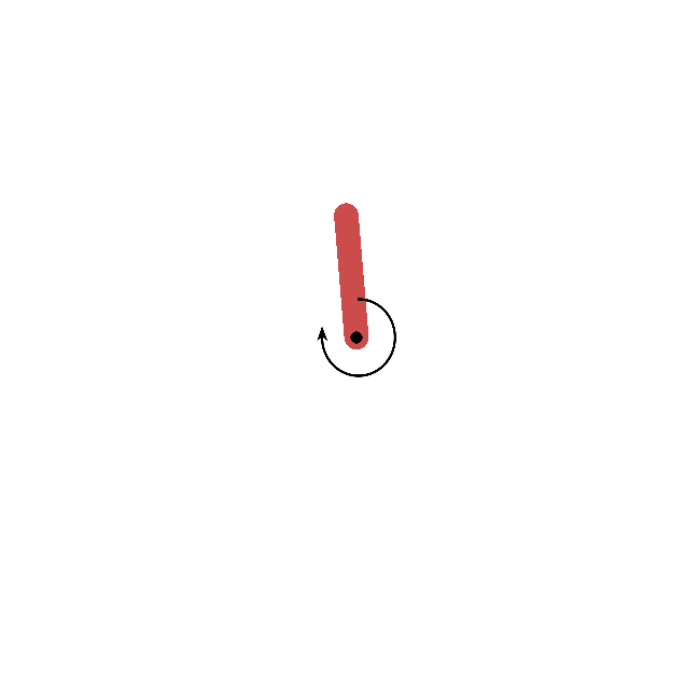
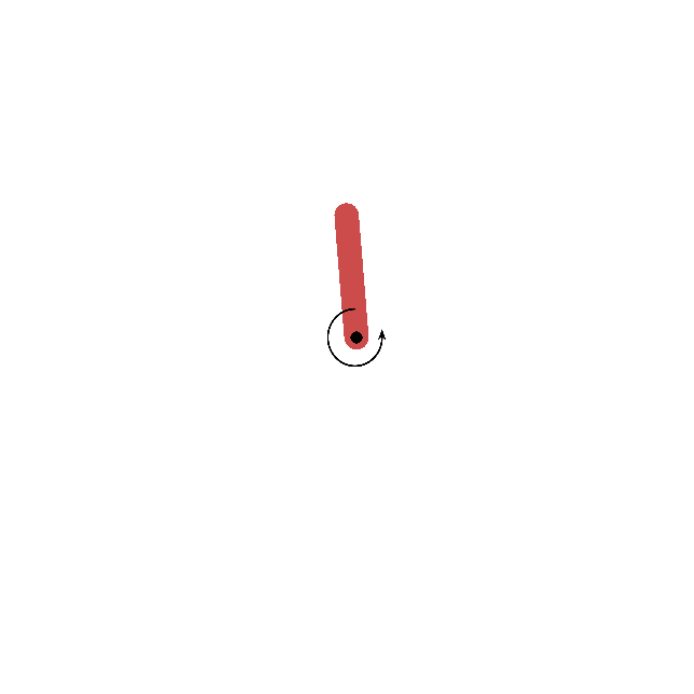
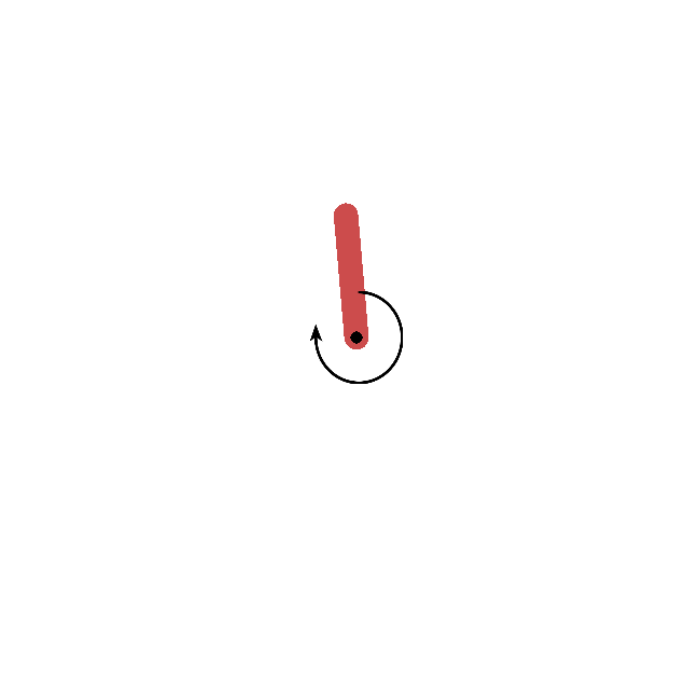
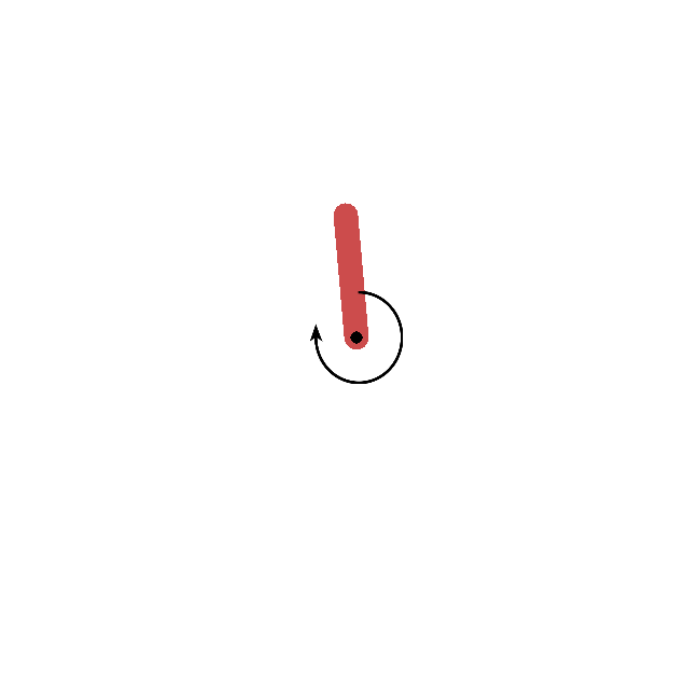
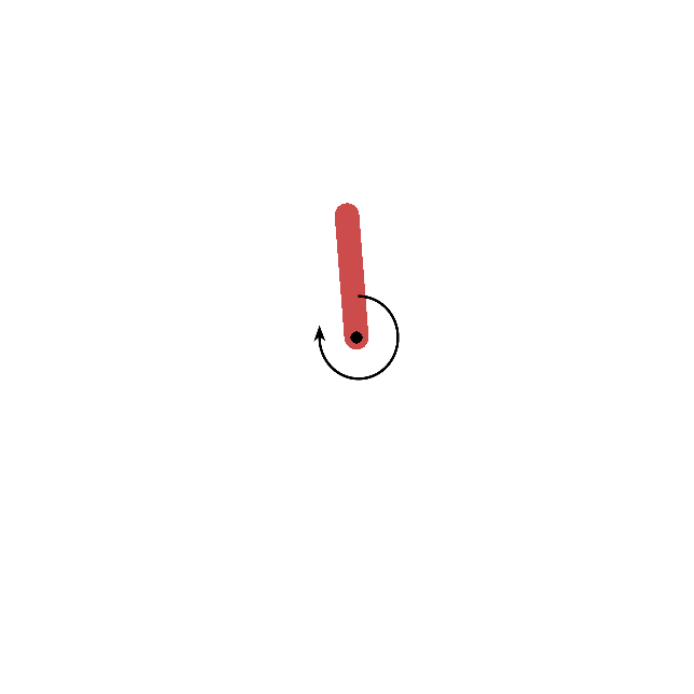
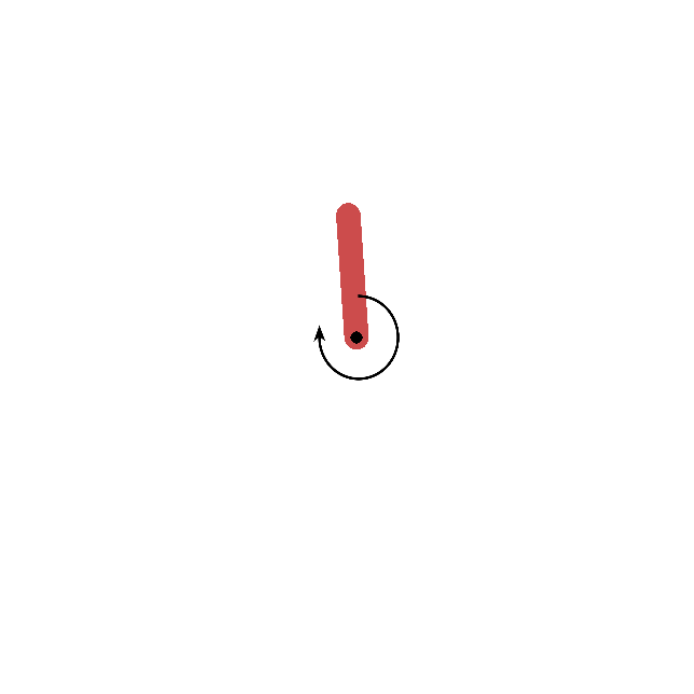
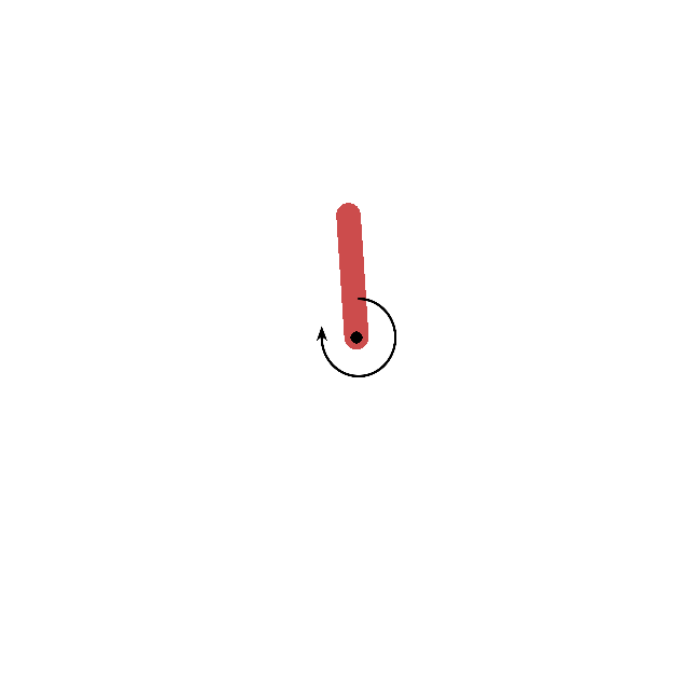
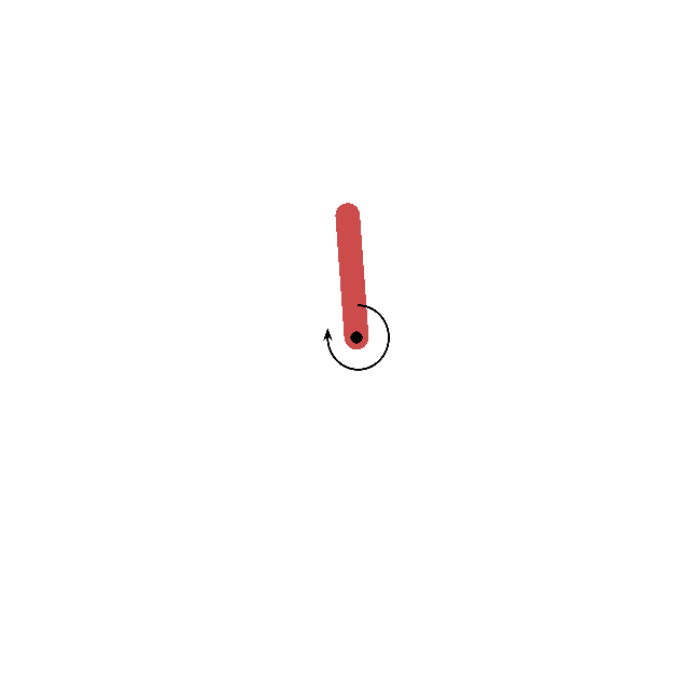
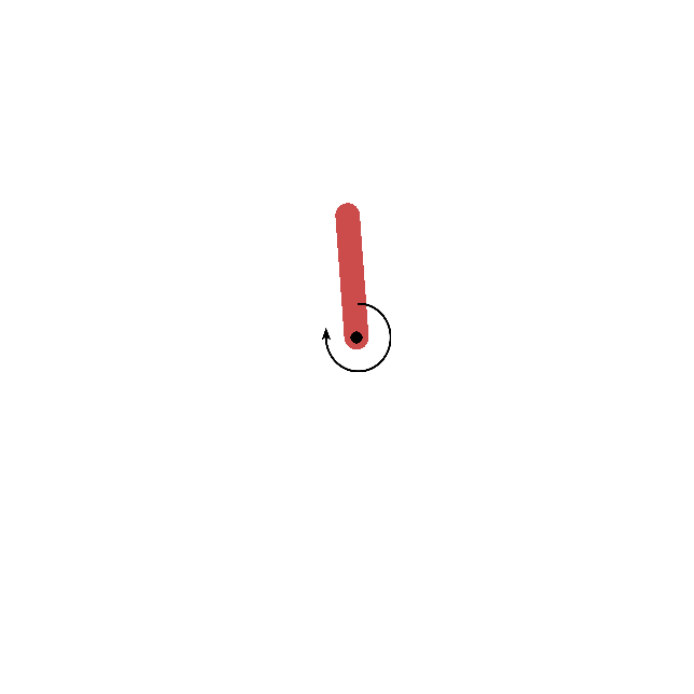
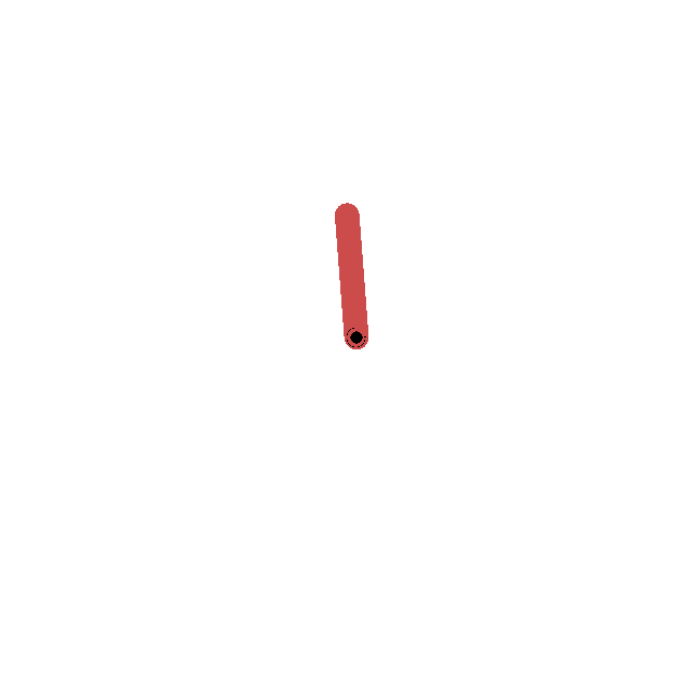
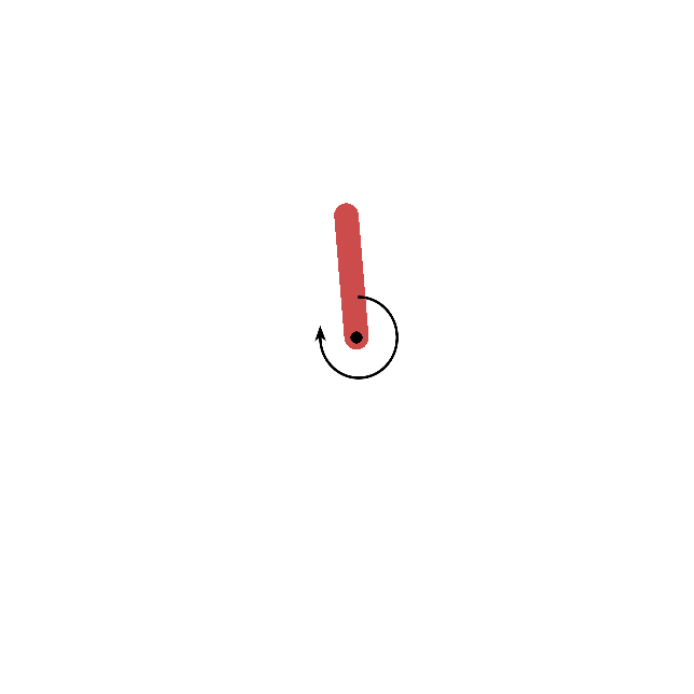
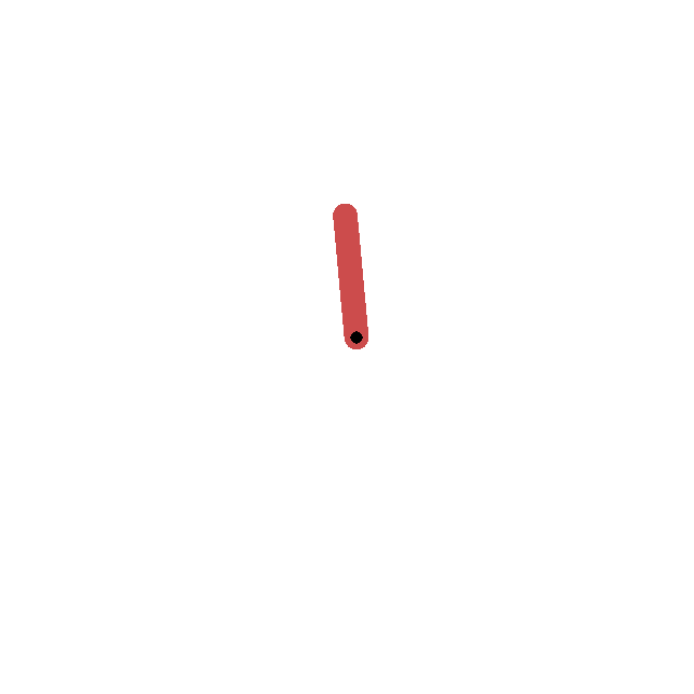
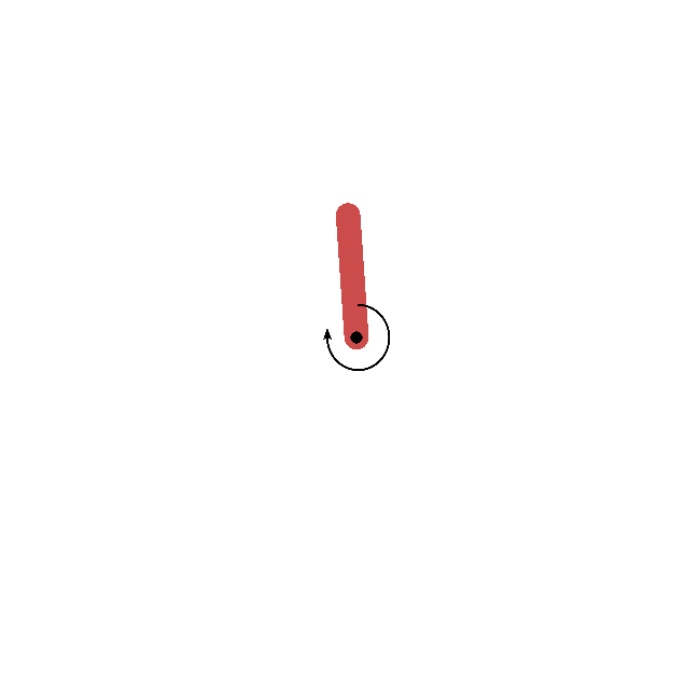
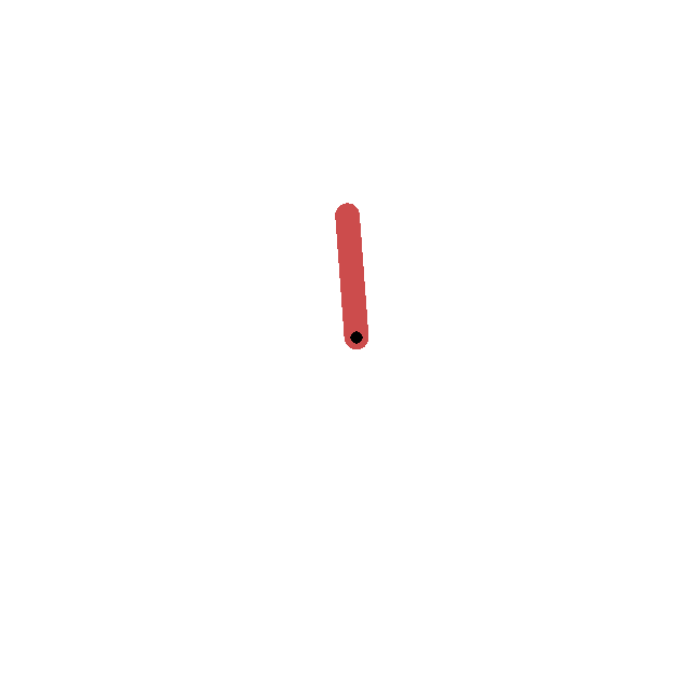
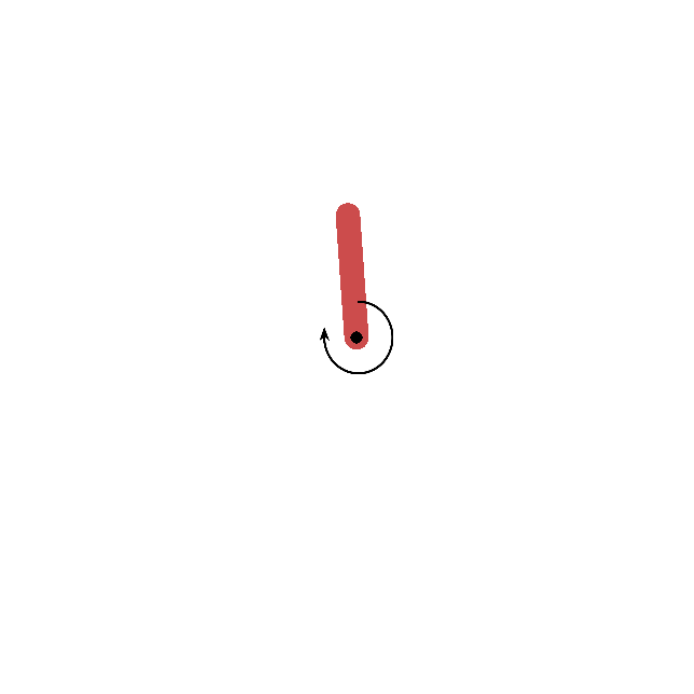
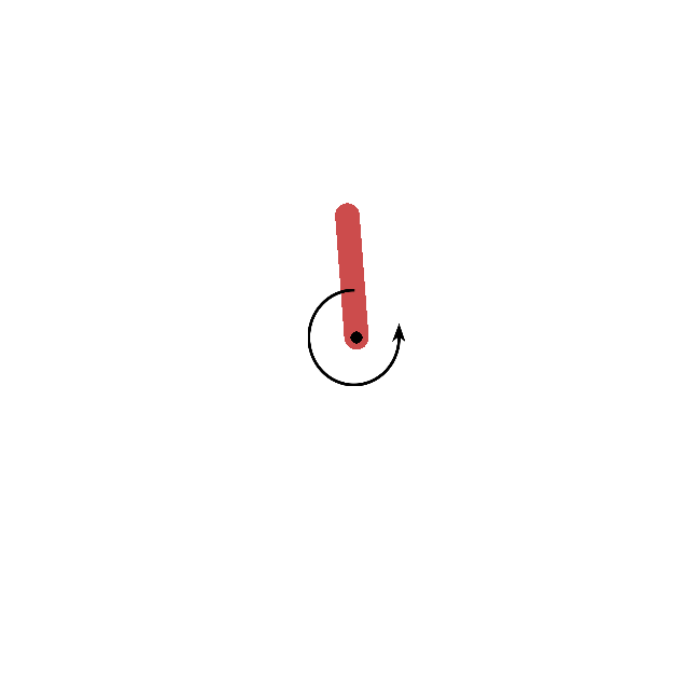
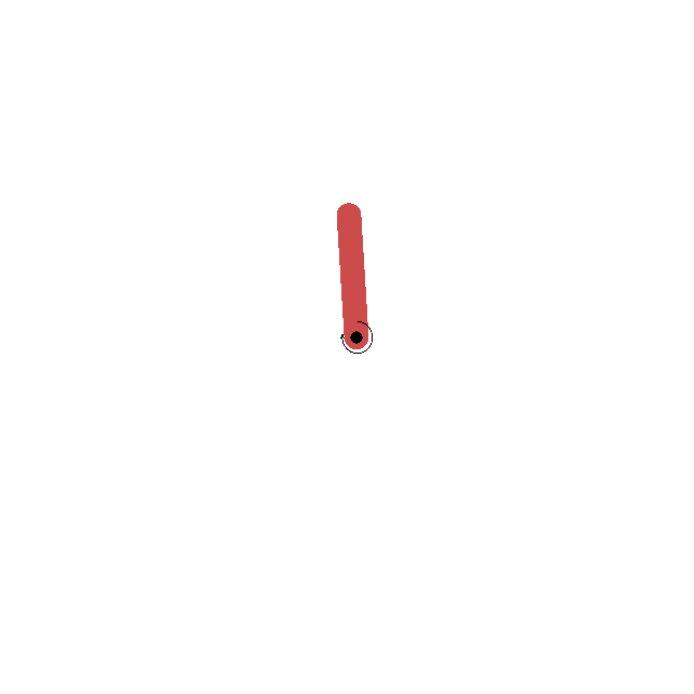
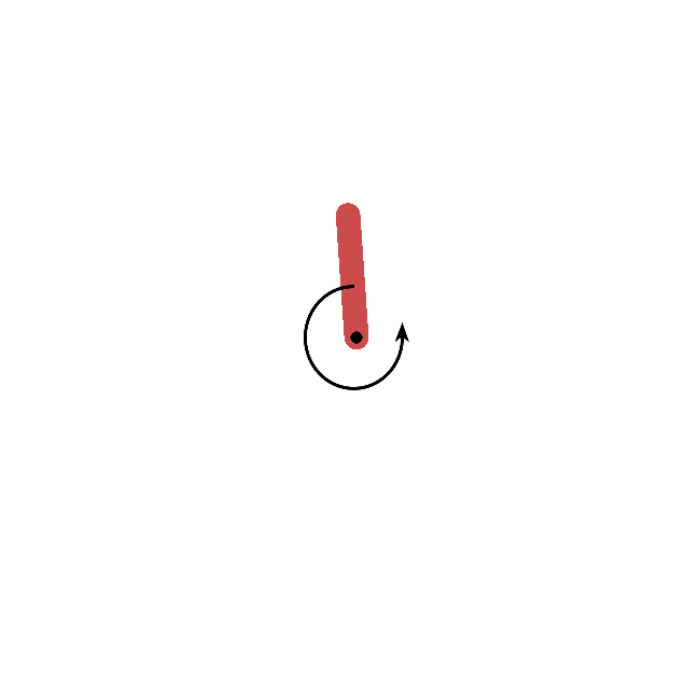
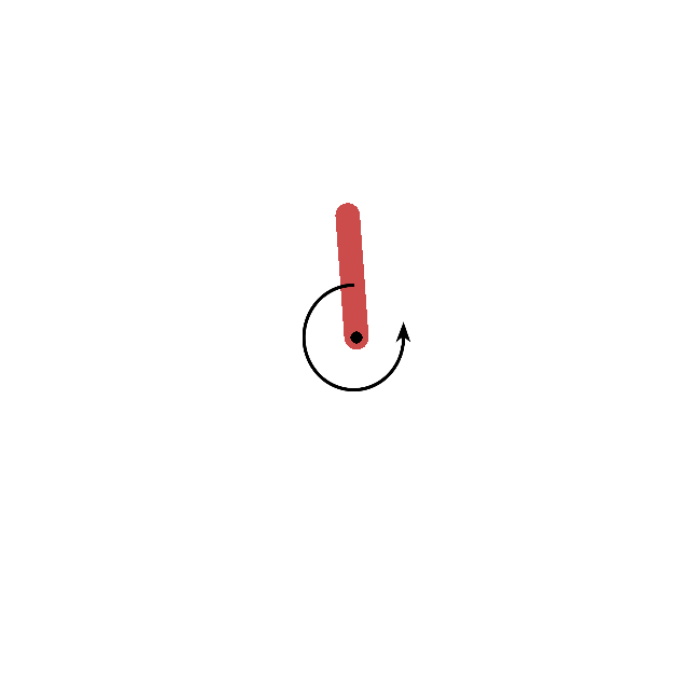
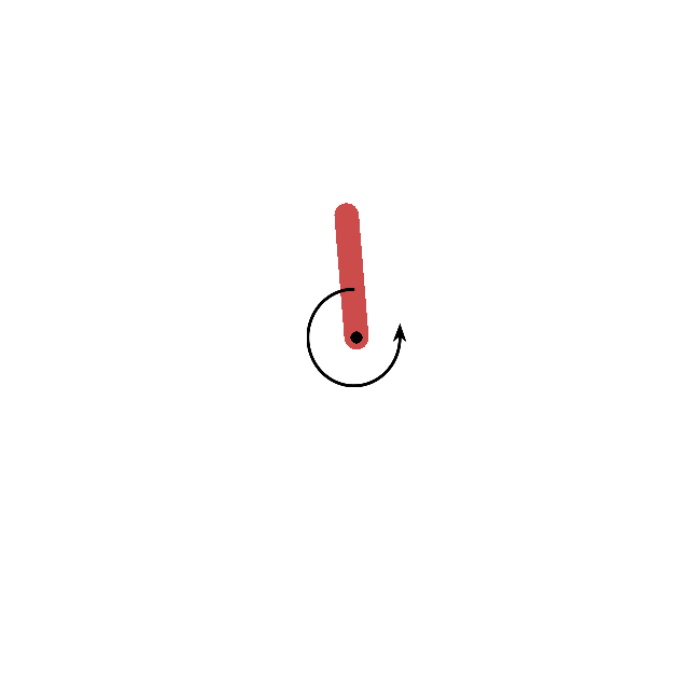
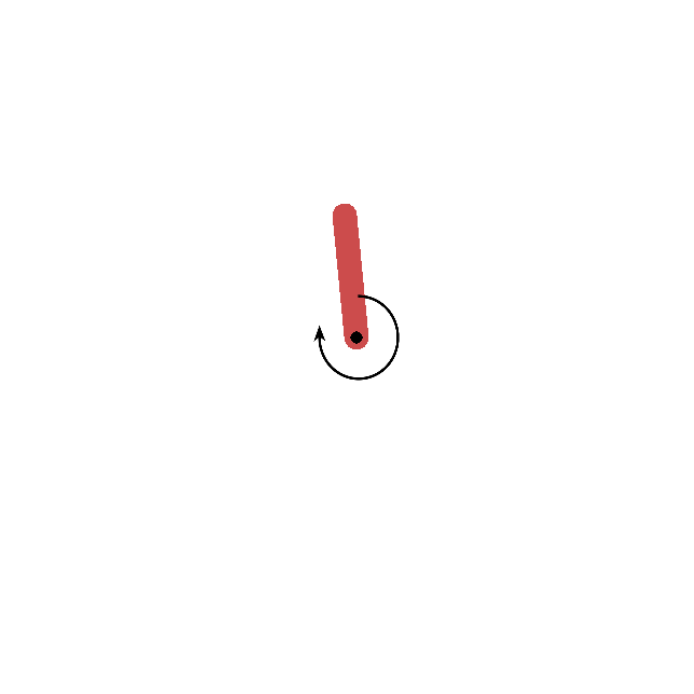
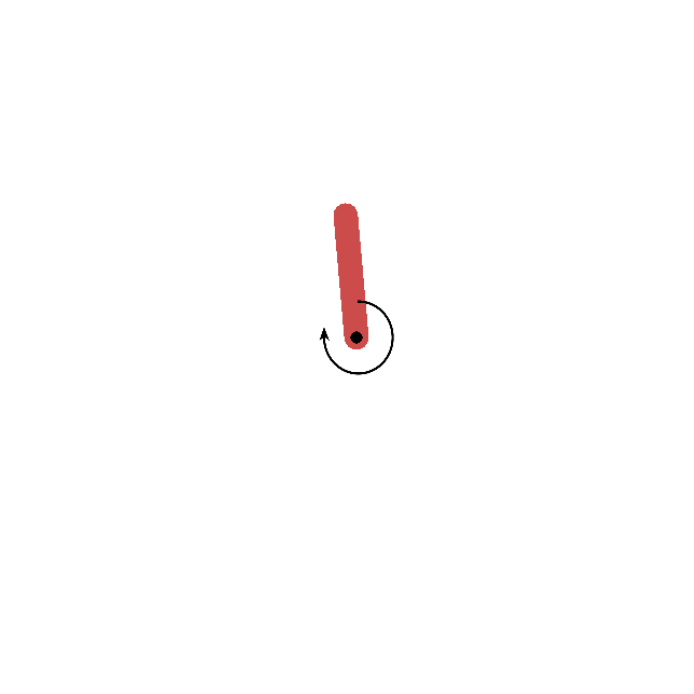
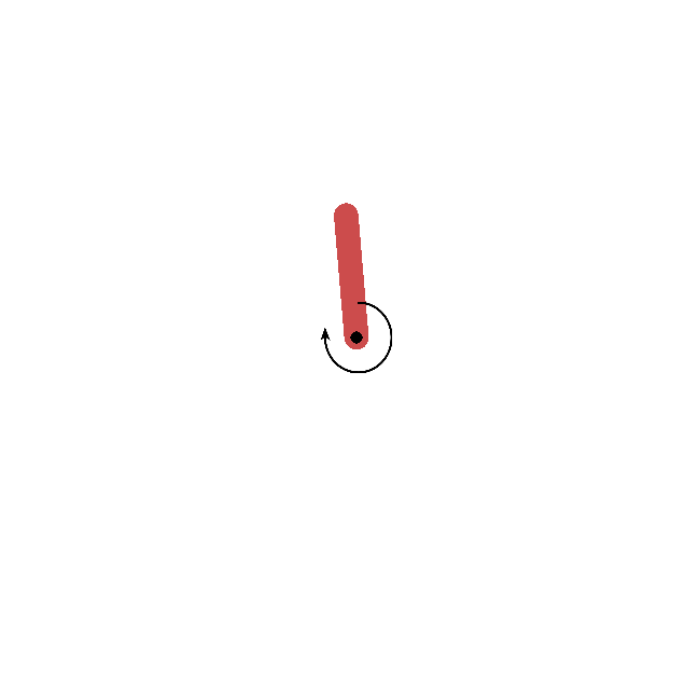
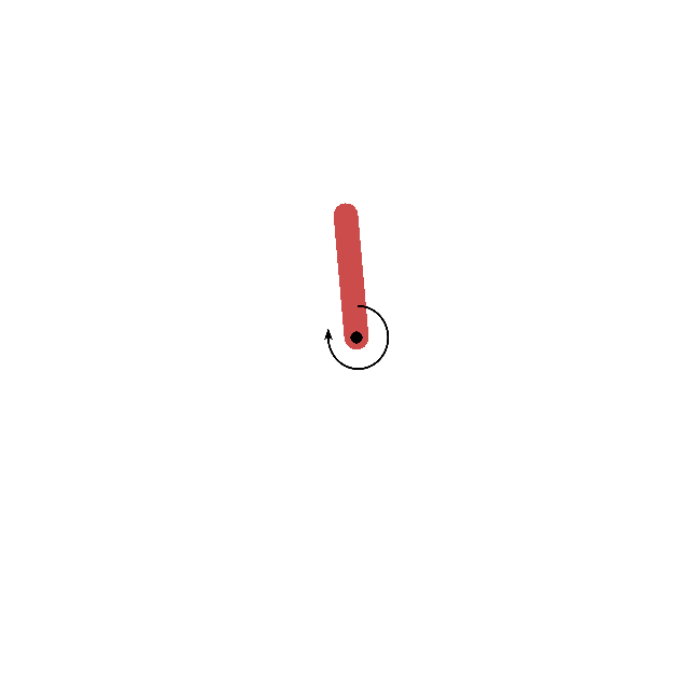
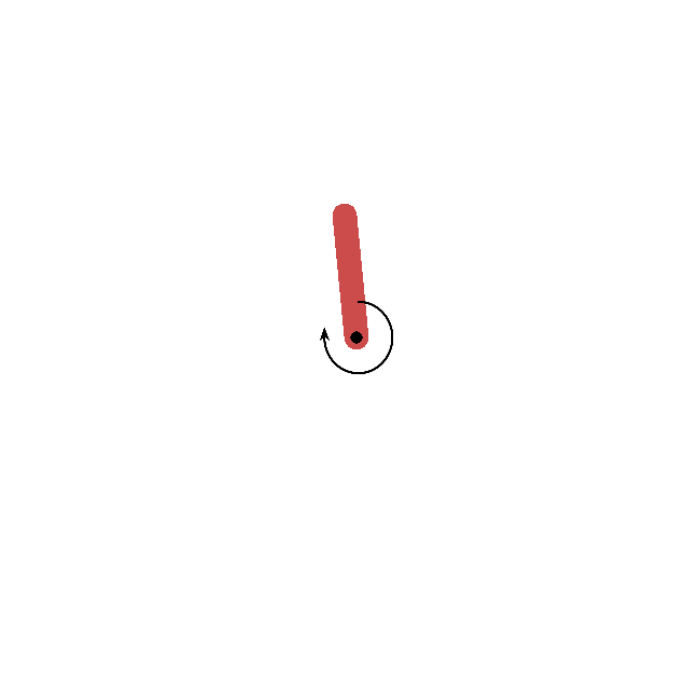
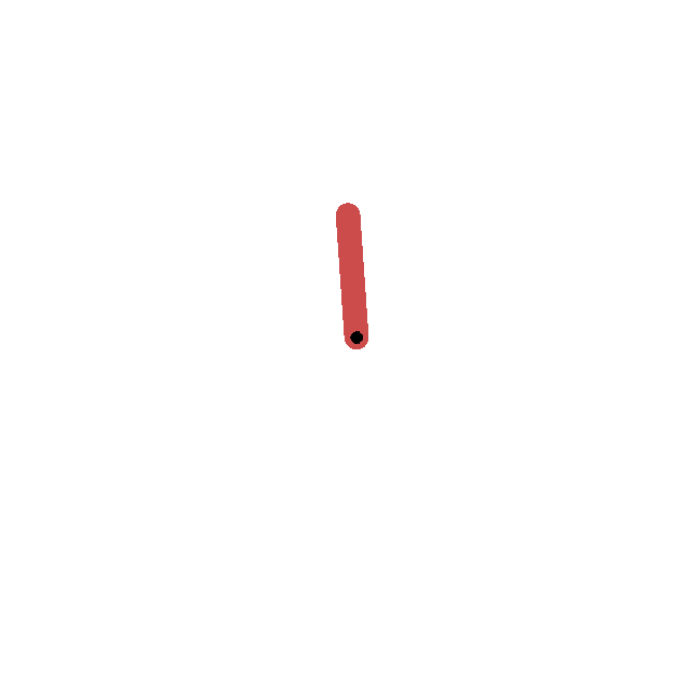
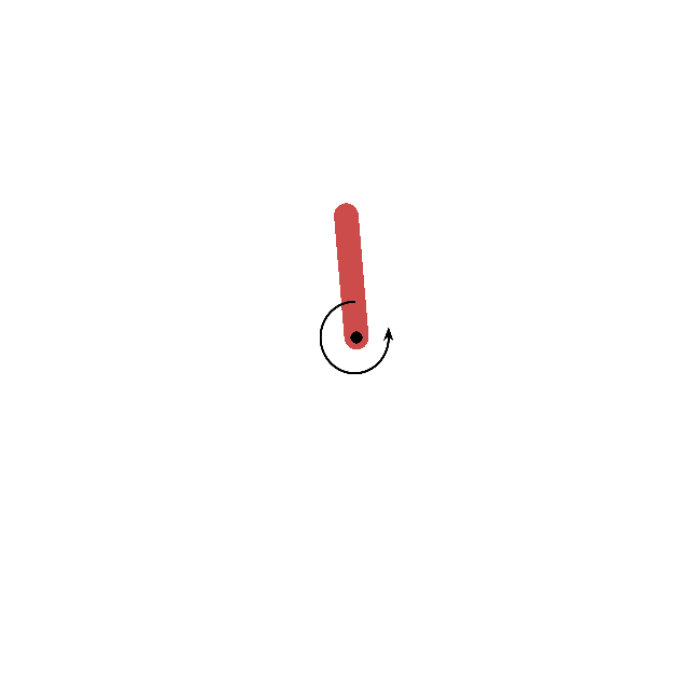
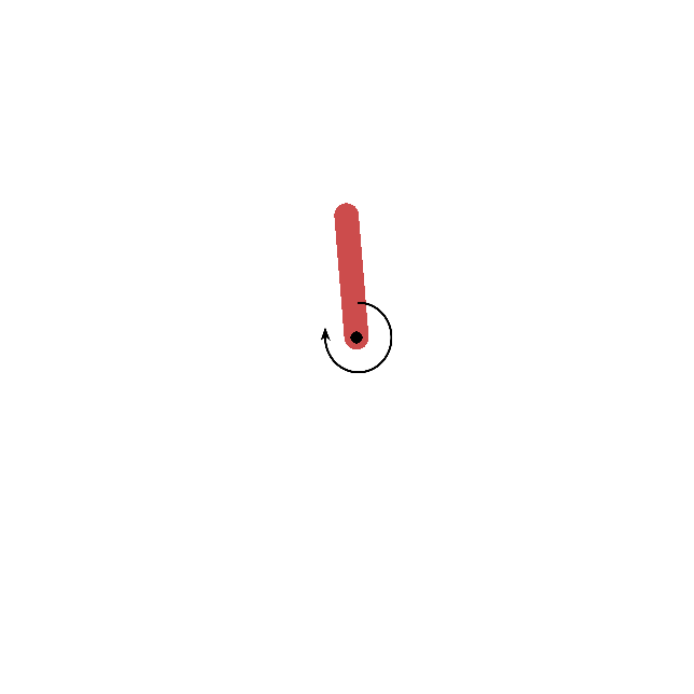
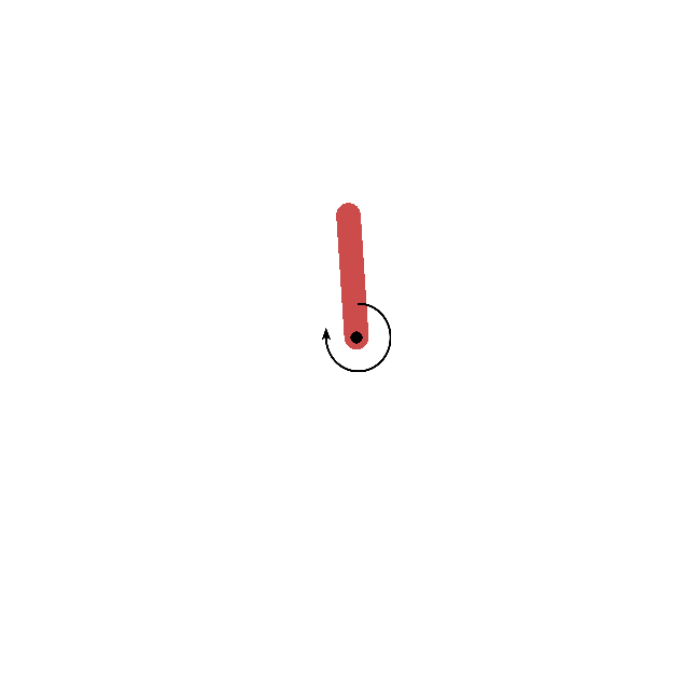
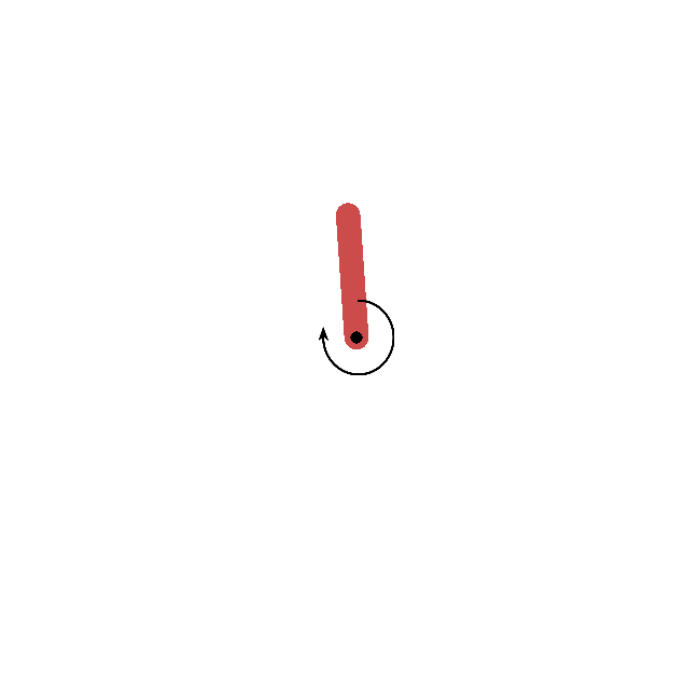
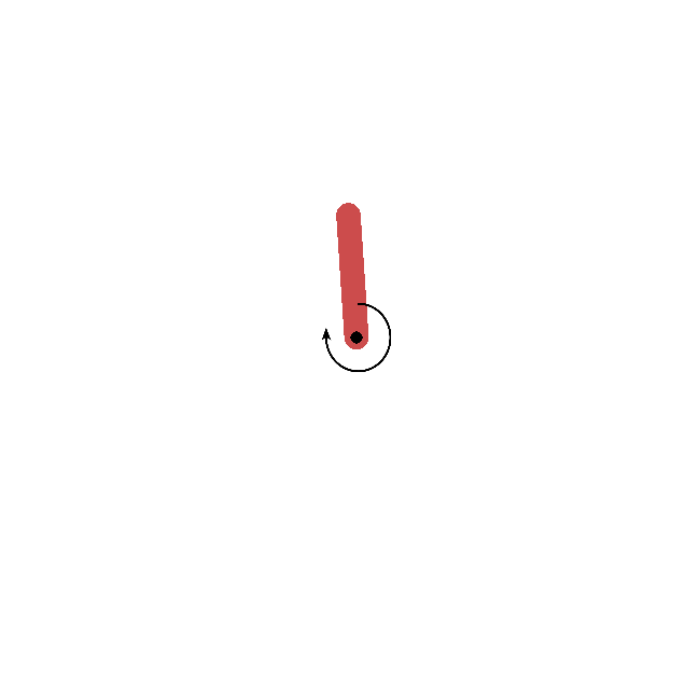
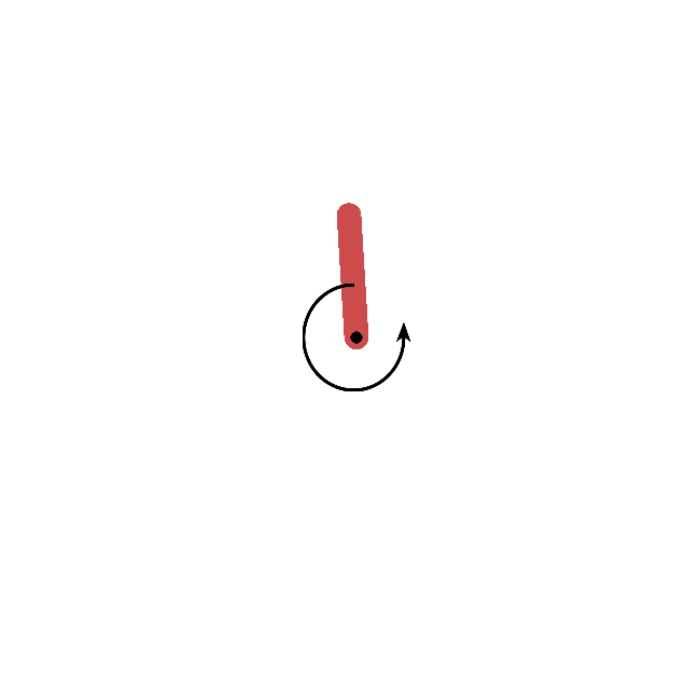
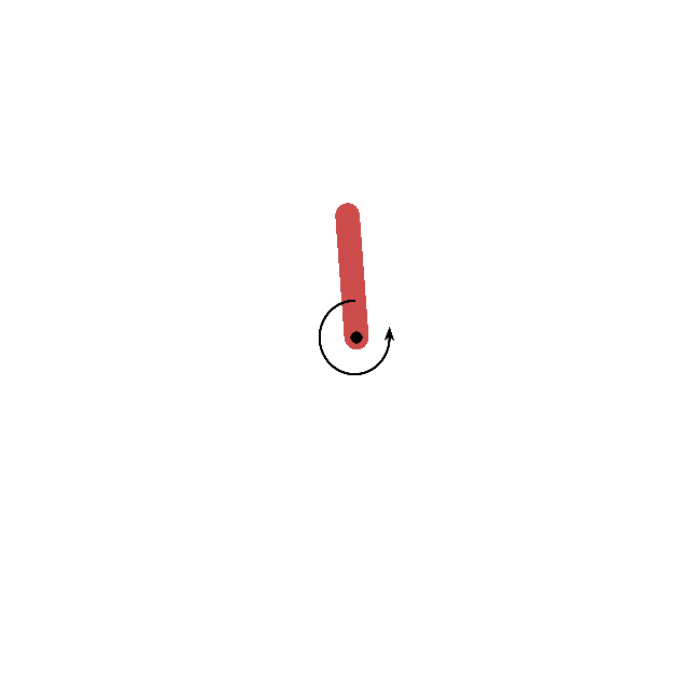
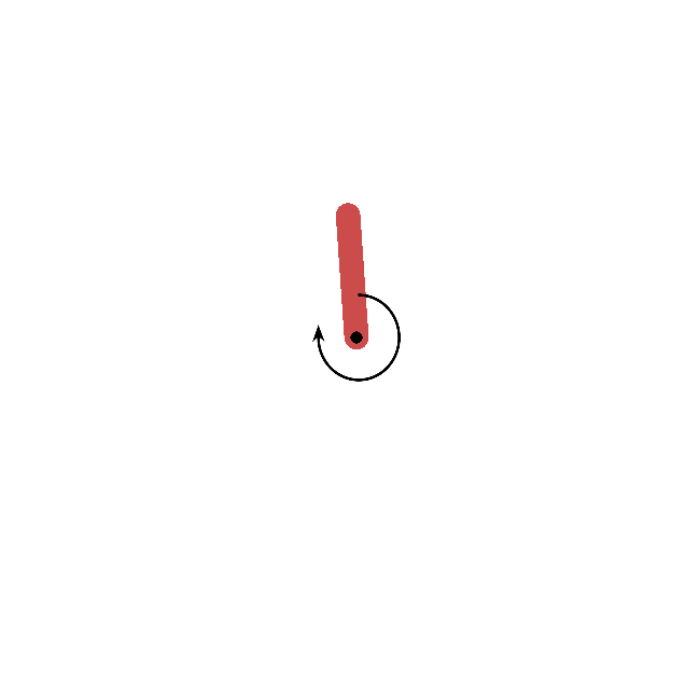
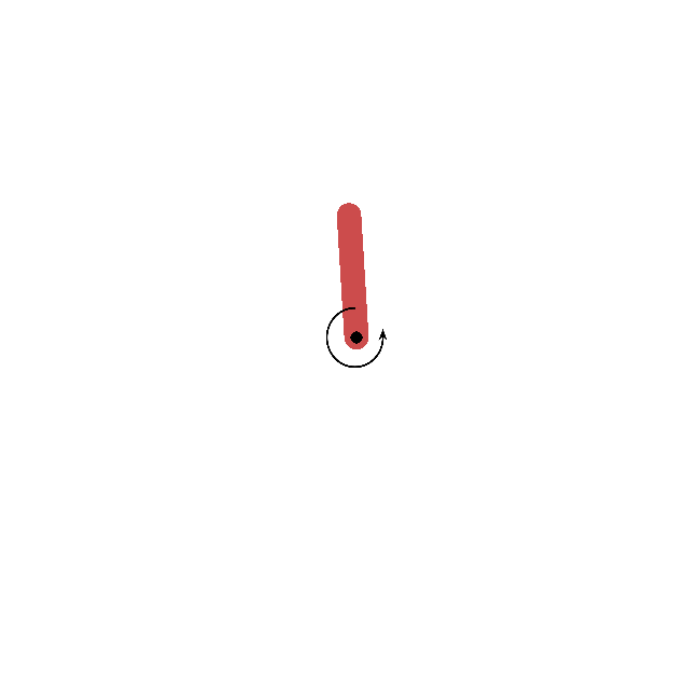
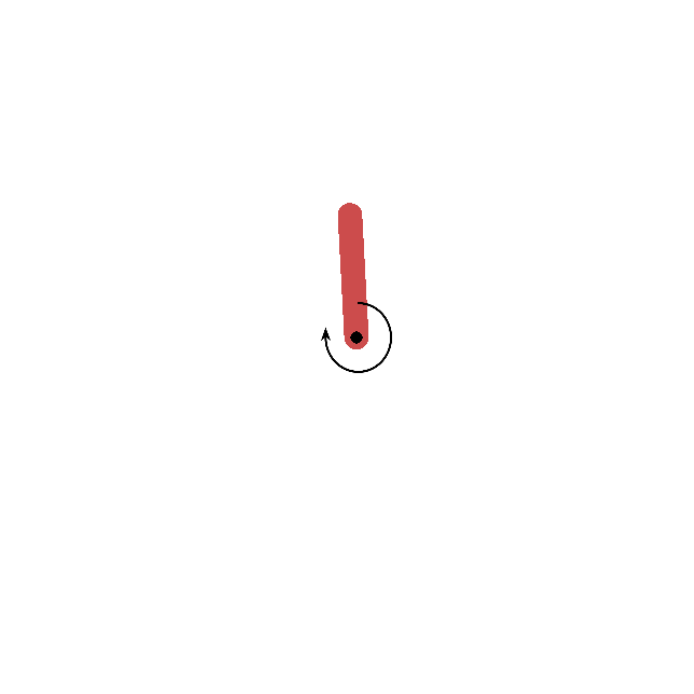
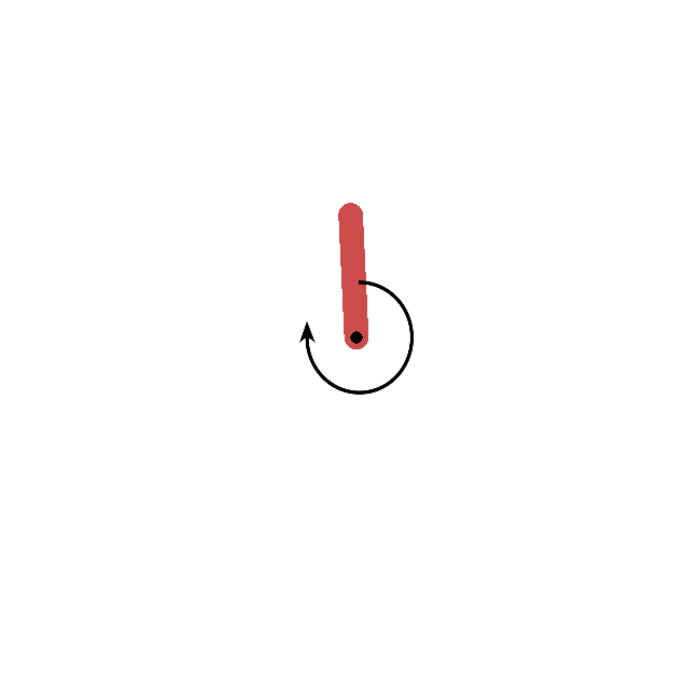

In [15]:
if RENDER:
    display_frames_as_gif(frames)